# Code used for generating datasets in branched and cyclic pathways

We reuse functions defined in the document "IterativeConstruction_SharedFunctions.ipynb" here. The respective functions are defined and explained in the shared notebook

Note that resource allocation data is generated from stochastically generated parameterizations and may therefore deviate from the exact data presented in the paper.

In [ ]:
# The notebook which holds the shared functions first needs to be converted to an .py file to be imported
!jupyter nbconvert IterativeConstruction_SharedFunctions.ipynb --to python

#Import of required packages and the shared functions
from IterativeConstruction_SharedFunctions import *;

import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import matplotlib.colors
from  matplotlib.colors import LinearSegmentedColormap
cmaprbg=LinearSegmentedColormap.from_list('rg',["r", "k", "g"], N=256) 

import warnings
warnings.filterwarnings("ignore")

font = {'size'   : 20}
plt.rc('font', **font)

Phimax = 1 #0.5

def monod(xs, v, K):
    return v/(1+K/xs)

### generalized Monod for two substrates
def doubleMonod(xs, ys, v, Ka, Kb, K):
    return v/(1+Ka/xs+Kb/ys+K/(xs*ys))

In [2]:
#special iterator for the branching point
def rhoy(rhoN, K, kappay, KMy, kappaN, KMN, kappay1, KMy1, rhoy1, sumrho, b):
    return (K*kappaN*kappay1*rhoy1**2+b*K*kappaN*kappay1*rhoN*rhoy1**2+b*kappaN*kappay1*KMy*rhoN**2*rhoy1**2+b*K*kappaN*kappay1*rhoy1**3+b*K*kappaN*kappay1*rhoy1**2*sumrho-np.sqrt(kappaN*kappay1*rhoy1**2*(kappaN*kappay1*rhoy1**2*(K+b*KMy*rhoN**2+b*K*(rhoN+rhoy1+sumrho))**2+4*kappay*rhoN*(K+KMy*rhoN)*(1+b*(rhoy1+sumrho))*(kappaN*KMy1*rhoN**2*(1+b*sumrho)-kappay1*rhoy1**2*(KMN+b*rhoN**2+b*KMN*(rhoN+rhoy1+sumrho))))))/(2*kappay*(kappaN*KMy1*rhoN**2*(1+b*sumrho)-kappay1*rhoy1**2*(KMN+b*rhoN**2+b*KMN*(rhoN+rhoy1+sumrho))))


In [3]:
#special iterator for the branching point - second solution
def rhoy2(rhoN, K, kappay, KMy, kappaN, KMN, kappay1, KMy1, rhoy1, sumrho, b):
    return (K*kappaN*kappay1*rhoy1**2+b*K*kappaN*kappay1*rhoN*rhoy1**2+b*kappaN*kappay1*KMy*rhoN**2*rhoy1**2+b*K*kappaN*kappay1*rhoy1**3+b*K*kappaN*kappay1*rhoy1**2*sumrho+np.sqrt(kappaN*kappay1*rhoy1**2*(kappaN*kappay1*rhoy1**2*(K+b*KMy*rhoN**2+b*K*(rhoN+rhoy1+sumrho))**2+4*kappay*rhoN*(K+KMy*rhoN)*(1+b*(rhoy1+sumrho))*(kappaN*KMy1*rhoN**2*(1+b*sumrho)-kappay1*rhoy1**2*(KMN+b*rhoN**2+b*KMN*(rhoN+rhoy1+sumrho))))))/(2*kappay*(kappaN*KMy1*rhoN**2*(1+b*sumrho)-kappay1*rhoy1**2*(KMN+b*rhoN**2+b*KMN*(rhoN+rhoy1+sumrho))))


In [4]:
### define regular chain iterators
Nenzymes = 20

def rhoIterator(kappas, KMs, bs, rho0approx, sumbrhoOut=0):
    rhoq = rho0approx
    rhos = np.array([rhoq])
    NEnzymes = np.shape(kappas)[0]
    #print(NEnzymes)
    for q in range(NEnzymes-1):
        # \rho_{q+1}^2\bigg(\frac{K_M^q}{\rho_q^2}\frac{1+b \sum_j^{q-1} \rho_j}{\kappa_q}-\frac{b}{\kappa_{q+1}}\bigg)
        #-\rho_{q+1}  \bigg(\frac{K_M^{q+1}}{\kappa_{q+1}}b\bigg)
        #-\bigg(\frac{K_M^{q+1}}{\kappa_{q+1}}(1+b \sum_j^{q} \rho_j)\bigg)\\

        sumqminus = np.sum(bs[:q]*rhos[:q])+sumbrhoOut
        sumq = np.sum(bs[:q+1]*rhos[:q+1])+sumbrhoOut
        #print(q, sumq, sumqminus)
        a = KMs[q]/rhos[q]**2*(1+sumqminus)/kappas[q]-bs[q+1]/kappas[q+1]
        b = -KMs[q+1]/kappas[q+1]*bs[q+1]
        c = -KMs[q+1]/kappas[q+1]*(1+sumq)
        rhoq = (-b+np.sqrt(b**2-4*a*c))/2/a
        rhos = np.append(rhos, rhoq)
        
    return rhos


def findPhis(kappas, KMs, bs, rhos):
    jlocals2 = [1]
    for k in range(np.shape(kappas)[0]-1):
        if rhos[k]>0:
            jlocals2 = np.append(jlocals2, jlocals2[-1]+jlocals2[0]*bs[k]*rhos[k])
        else:
            jlocals2 = np.append(jlocals2, np.nan)
            
    phis = jlocals2/kappas*(1+KMs/rhos)
    #print(np.sum(phis))
    jlocals2 = [1/np.nansum(phis)]
    for k in range(np.shape(kappas)[0]-1):
        if rhos[k]>0:
            jlocals2 = np.append(jlocals2, jlocals2[-1]+jlocals2[0]*bs[k]*rhos[k])
        else:
            jlocals2 = np.append(jlocals2, np.nan)
            
    phis = jlocals2/kappas*(1+KMs/rhos)
    #print(np.sum(phis))
    return phis

def wrapper3(logrho0, args=np.ones(4*Nenzymes+3)):
    #print(logrho0)
    kappas = args[0:Nenzymes]
    KMs = args[Nenzymes:2*Nenzymes]
    bs = args[2*Nenzymes:3*Nenzymes]
    nu = args[3*Nenzymes]
    lamapprox = args[3*Nenzymes+1]
    
    rhos = rhoIterator(kappas, KMs, bs, nu, np.exp(logrho0))
    phis = findPhis(kappas, KMs, bs, rhos)
    
    if np.isnan(phis[-1]):
        return np.sum(np.isnan(phis))+1-1/(1+np.nansum(rhos[rhos>0]))+np.any(rhos<0)
    else:
        lam = simulate(phis, kappas, KMs, bs, nu, lamapprox)
        return -lam/np.sum(phis)*np.sum(1/kappas)

In [5]:
### closing the boundary condition by construction
def findnuBC(rho1, sumbrhosFrom2, kappa0, KM0, kappa1, KM1, b):
    #print((kappa0/b*KM1/rho1**2/kappa1*(1+b*sumbrhosFrom2)-1))
    return KM0/(kappa0/b*KM1/rho1**2/kappa1*(1+b*sumbrhosFrom2)-1)


### solve the whole chain including the BC by construction.
def SolveBC_FWD(kappas, KMs, bs, rho0approx):
    rhos = rhoIterator(kappas, KMs, bs, rho0approx)
    
    rho1 = rhos[-2]
    sumbrhosFrom2 = np.sum(bs[:-3]*rhos[:-3])
    
    #print(rhos[-1])
    
    rhos[-1] = findnuBC(rho1, sumbrhosFrom2, kappas[-1], KMs[-1], kappas[-2], KMs[-2], bs[-1])
    
    #print(rhos[-1])
    
    return rhos

In [6]:
### define a solver of the branched chain

def SolveYchainBC_FWD(rho0approx, rhoRightapprox, K, argsStemIn, argsLeftIn, argsRightIn):
    ### copy args locally to be able to alter them
    argsStem = np.copy(argsStemIn)
    argsLeft = np.copy(argsLeftIn)
    argsRight = np.copy(argsRightIn)
    
    
    ### first solve the stem starting from rho0
    Nenzymes = int((np.shape(argsStem)[0]-2)/3)
    kappas = argsStem[0:Nenzymes]
    KMs = argsStem[Nenzymes:2*Nenzymes]
    bs = argsStem[2*Nenzymes:3*Nenzymes]
    nu = argsStem[3*Nenzymes]
    lamapprox = argsStem[3*Nenzymes+1]
    
    rhosStem = rhoIterator(kappas, KMs, bs, rho0approx, 0)
    sumbrhoStem = np.sum(bs*rhosStem)
    
    ### now solve the branching point from the right branch-substrate concentration.
    Nenzymes = int((np.shape(argsStem)[0]-2)/3)
    #rhoy2(rhoN, K, kappay, KMy, kappaN, KMN, kappay1, KMy1, rhoy1, sumrho, b)
    rhoyapprox = rhoy2(rhoRightapprox, K, argsLeft[0], argsLeft[Nenzymes], argsRight[0], argsRight[Nenzymes], argsStem[Nenzymes-1], argsStem[2*Nenzymes-1], rhosStem[-1], np.sum(bs[:-1]*rhosStem[:-1]), argsLeft[2*Nenzymes+1])
    #rhoyapprox = rhoy2(rhoRightapprox, K, argsLeft[0], argsLeft[Nenzymes], argsRight[0], argsRight[Nenzymes], argsLeft[1], argsLeft[Nenzymes+1], rhosStem[-1], np.sum(bs[:-1]*rhosStem[:-1]), argsLeft[2*Nenzymes])
    #print(rhoRightapprox, rhoyapprox)
    
    ### now solve the left branch including its BC by construction
    kappas = argsLeft[0:Nenzymes]
    KMs = argsLeft[Nenzymes:2*Nenzymes]
    bs = argsLeft[2*Nenzymes:3*Nenzymes]
    nu = argsLeft[3*Nenzymes]
    lamapprox = argsLeft[3*Nenzymes+1]
    
    KMs[0] = KMs[0]+K/rhoRightapprox
    
    ### this rhoIterator must know the sumbrho of the stem and use it
    rhosLeft = rhoIterator(kappas, KMs, bs, rhoyapprox, sumbrhoStem)
    
    ### same here
    rho1 = rhosLeft[-2]
    sumbrhosFrom2 = np.sum(bs[:-3]*rhosLeft[:-3])
    
    rhosLeft[-1] = findnuBC(rho1, sumbrhosFrom2, kappas[-1], KMs[-1], kappas[-2], KMs[-2], bs[-1])
    
    
    ### now solve the right branch including its BC by construction
    kappas = argsRight[0:Nenzymes]
    KMs = argsRight[Nenzymes:2*Nenzymes]
    bs = argsRight[2*Nenzymes:3*Nenzymes]
    nu = argsRight[3*Nenzymes]
    lamapprox = argsRight[3*Nenzymes+1]
    
    KMs[0] = KMs[0]+K/rhosLeft[0]
    
    ### this rhoIterator must know the sumbrho of the stem and use it
    rhosRight = rhoIterator(kappas, KMs, bs, rhoRightapprox, sumbrhoStem)
    
    ### same here
    rho1 = rhosRight[-2]
    sumbrhosFrom2 = np.sum(bs[:-3]*rhosRight[:-3])
    
    rhosRight[-1] = findnuBC(rho1, sumbrhosFrom2, kappas[-1], KMs[-1], kappas[-2], KMs[-2], bs[-1])
    
    ### return all Rhos
    return rhosStem, rhosLeft, rhosRight

In [7]:
### function to evaluate the other state variables
def findPhisAndJsY(argsY, rhosY):
    argsStem, argsLeft, argsRight, K, nuLeft, rhoRight = argsY
    rhosStem, rhosLeft, rhosRight = rhosY
    
    Nenzymes = int((np.shape(argsStem)[0]-2)/3)
    kappas = argsStem[0:Nenzymes]
    KMs = argsStem[Nenzymes:2*Nenzymes]
    bs = argsStem[2*Nenzymes:3*Nenzymes]
    nu = argsStem[3*Nenzymes]
    lamapprox = argsStem[3*Nenzymes+1]
    
    jlocalsStem = [1]
    for k in range(Nenzymes):
        if rhosStem[k]>0:
            jlocalsStem = np.append(jlocalsStem, jlocalsStem[-1]+jlocalsStem[0]*bs[k]*rhosStem[k])
        else:
            jlocalsStem = np.append(jlocalsStem, np.nan)
            
    jlocalsLeft = [np.copy(jlocalsStem[-1])]
    jlocalsRight = [np.copy(jlocalsStem[-1])]
    jlocalsStem = jlocalsStem[:-1]
    
    phisStem = jlocalsStem/kappas*(1+KMs/rhosStem)
    
    
    Nenzymes = int((np.shape(argsLeft)[0]-2)/3)
    kappas = argsLeft[0:Nenzymes]
    KMs = argsLeft[Nenzymes:2*Nenzymes]
    bs = argsLeft[2*Nenzymes:3*Nenzymes]
    nu = argsLeft[3*Nenzymes]
    lamapprox = argsLeft[3*Nenzymes+1]
    
    for k in range(Nenzymes-1):
        if rhosLeft[k]>0:
            jlocalsLeft = np.append(jlocalsLeft, jlocalsLeft[-1]+jlocalsStem[0]*bs[k]*rhosLeft[k])
        else:
            jlocalsLeft = np.append(jlocalsLeft, np.nan)
            
    phisLeft = jlocalsLeft/kappas*(1+KMs/rhosLeft)
    phisLeft[0] = 0
    KMleft = np.copy(KMs[0])
    
    
    Nenzymes = int((np.shape(argsRight)[0]-2)/3)
    kappas = argsRight[0:Nenzymes]
    KMs = argsRight[Nenzymes:2*Nenzymes]
    bs = argsRight[2*Nenzymes:3*Nenzymes]
    nu = argsRight[3*Nenzymes]
    lamapprox = argsRight[3*Nenzymes+1]
    
    for k in range(Nenzymes-1):
        if rhosRight[k]>0:
            jlocalsRight = np.append(jlocalsRight, jlocalsRight[-1]+jlocalsStem[0]*bs[k]*rhosRight[k])
        else:
            jlocalsRight = np.append(jlocalsRight, np.nan)
            
    phisRight = jlocalsRight/kappas*(1+KMs/rhosRight)
    phisRight[0] = jlocalsRight[0]/kappas[0]*(1+KMs[0]/rhosRight[0]+KMleft/rhosLeft[0]+K/rhosRight[0]/rhosLeft[0])
            
    phiSum = np.sum(phisStem) + np.sum(phisLeft) + np.sum(phisRight)
    
    return phisStem/phiSum, phisLeft/phiSum, phisRight/phiSum, jlocalsStem/phiSum, jlocalsLeft/phiSum, jlocalsRight/phiSum

In [8]:
### do the same thing but with a constraint on the right input branch's protein expression level

def SolveYchainConstrained_FWD(rho0approx, rhoRightapprox, K, alpha, eps, phi1_0, argsStemIn, argsLeftIn, argsRightIn):
    ### copy args locally to be able to alter them
    argsStem = np.copy(argsStemIn)
    argsLeft = np.copy(argsLeftIn)
    argsRight = np.copy(argsRightIn)
    
    ### the last enzyme of each branch is the two-substrate enzyme
    if argsLeft[0]!=argsRight[0]:
        print("Inconsistent Convergence enzyme")
    
    ### first solve the stem starting from rho0
    Nenzymes = int((np.shape(argsStem)[0]-2)/3)
    kappas = argsStem[0:Nenzymes]
    KMs = argsStem[Nenzymes:2*Nenzymes]
    bs = argsStem[2*Nenzymes:3*Nenzymes]
    nu = argsStem[3*Nenzymes]
    lamapprox = argsStem[3*Nenzymes+1]
    
    rhosStem = rhoIterator(kappas, KMs, bs, rho0approx)
    sumbrhoStem = np.sum(bs*rhosStem)
    JsStem = np.cumsum(rhosStem)-rhosStem+1
    MsStem = JsStem/kappas*(1+KMs/rhosStem)
    
    ### now solve the branching point from the right branch-substrate concentration.
    Nenzymes = int((np.shape(argsStem)[0]-2)/3)
    # rhoy2(rhoN, K, kappay, KMy, kappaN, KMN, kappay1, KMy1, rhoy1, sumrho, b)
    # There might be something wrong here. Check the definitions of kappay, kappay1 and kappayN. Two things must be the same.
    #rhoyapprox = rhoy2(rhoRightapprox, K, argsLeft[0], argsLeft[Nenzymes], argsRight[0], argsRight[Nenzymes], argsLeft[1], argsLeft[Nenzymes+1], rhosStem[-1], np.sum(bs[:-1]*rhosStem[:-1]), argsLeft[2*Nenzymes])
    rhoyapprox = rhoy2(rhoRightapprox, K, argsLeft[0], argsLeft[Nenzymes], argsRight[0], argsRight[Nenzymes], argsStem[Nenzymes-1], argsStem[2*Nenzymes-1], rhosStem[-1], np.sum(bs[:-1]*rhosStem[:-1]), argsLeft[2*Nenzymes+1])
    #print(rhoRightapprox, rhoyapprox)
    
    ### now solve the left branch including its BC by construction
    kappas = argsLeft[0:Nenzymes]
    KMs = argsLeft[Nenzymes:2*Nenzymes]
    bs = argsLeft[2*Nenzymes:3*Nenzymes]
    nu = argsLeft[3*Nenzymes]
    lamapprox = argsLeft[3*Nenzymes+1]
    
    KMs[0] = KMs[0]+K/rhoRightapprox
    
    ### this rhoIterator must know the sumbrho of the stem and use it
    rhosLeft = rhoIterator(kappas, KMs, bs, rhoyapprox, sumbrhoStem)
    
    ### same here
    rho1 = rhosLeft[-2]
    sumbrhosFrom2 = np.sum(bs[:-3]*rhosLeft[:-3])
    
    rhosLeft[-1] = findnuBC(rho1, sumbrhosFrom2, kappas[-1], KMs[-1], kappas[-2], KMs[-2], bs[-1])
    JsLeft = np.cumsum(rhosLeft)-rhosLeft+JsStem[-1]+rhosStem[-1]
    #Here the branching is ignored. Needs to be corrected later
    MsLeft = JsLeft/kappas*(1+KMs/rhosLeft)
    
    ### now solve the right branch including its BC by construction
    kappas = argsRight[0:Nenzymes]
    KMs = argsRight[Nenzymes:2*Nenzymes]
    bs = argsRight[2*Nenzymes:3*Nenzymes]
    nu = argsRight[3*Nenzymes]
    lamapprox = argsRight[3*Nenzymes+1]
    
    KMs[0] = KMs[0]+K/rhosLeft[0]
    
    ### this rhoIterator must know the sumbrho of the stem and use it
    rhosRight = rhoIterator(kappas, KMs, bs, rhoRightapprox, sumbrhoStem)
    
    ### same here
    rho1 = rhosRight[-2]
    sumbrhosFrom2 = np.sum(bs[:-3]*rhosRight[:-3])
    
    rhosRight[-1] = findnuBC(rho1, sumbrhosFrom2, kappas[-1], KMs[-1], kappas[-2], KMs[-2], bs[-1])
    JsRight = np.cumsum(rhosRight)-rhosRight+JsStem[-1]+rhosStem[-1]
    #Here the branching and the BC is ignored. Needs to be corrected later
    MsRight = JsRight/kappas*(1+KMs/rhosRight)
    
    KM1 = KMs[-1]
    kappa1 = kappas[-1]
    phi1 = phi1_0#*(1+alpha*eps/(1+eps*nu/KM1))
    
    ### both branches must produce the same outflux
    #print(JsRight[0], JsLeft[0])
    
    #Correct here for branching point and missing BC of right branch: 
    #sumM = np.sum(MsStem)+np.sum(MsRight)+np.sum(MsLeft)+(K/rhosRight[0]/rhosLeft[0]-1)*JsRight[0]/kappas[0]-MsRight[-1]#-wrong branchings + branching - rightside wrong BC = (K/rhoN/rhoy-1)*JoutBranches/kappa - MsRight[-1]
    #J1 = JsRight[-1]
    nuLeft = nu #unnecessary
    rhoRight = KMmean*2 #unnecessary
    argsY = [argsStemIn, argsLeftIn, argsRightIn, K, nuLeft, rhoRight]
    rhosY = [rhosStem, rhosLeft, rhosRight]
    phisStem, phisLeft, phisRight, jsStem, jsLeft, jsRight = findPhisAndJsY(argsY, rhosY)
    #output = argsY+rhosY
    J1 = jsRight[-1]
    sumM = np.sum(phisStem + phisLeft + phisRight)- phisRight[-1]
    nu1 = (-J1*KM1-eps*J1*KM1+J1*KM1*phi1+eps*J1*KM1*phi1+alpha*eps*J1*KM1*phi1+kappa1*KM1*phi1*sumM+alpha*eps*kappa1*KM1*phi1*sumM-np.sqrt(-4*(J1*KM1**2-J1*KM1**2*phi1-alpha*eps*J1*KM1**2*phi1)*(eps*J1-eps*J1*phi1-eps*kappa1*phi1*sumM)+(J1*KM1+eps*J1*KM1-J1*KM1*phi1-eps*J1*KM1*phi1-alpha*eps*J1*KM1*phi1-kappa1*KM1*phi1*sumM-alpha*eps*kappa1*KM1*phi1*sumM)**2))/(2*(eps*J1-eps*J1*phi1-eps*kappa1*phi1*sumM))
    nu2 = (-J1*KM1-eps*J1*KM1+J1*KM1*phi1+eps*J1*KM1*phi1+alpha*eps*J1*KM1*phi1+kappa1*KM1*phi1*sumM+alpha*eps*kappa1*KM1*phi1*sumM+np.sqrt(-4*(J1*KM1**2-J1*KM1**2*phi1-alpha*eps*J1*KM1**2*phi1)*(eps*J1-eps*J1*phi1-eps*kappa1*phi1*sumM)+(J1*KM1+eps*J1*KM1-J1*KM1*phi1-eps*J1*KM1*phi1-alpha*eps*J1*KM1*phi1-kappa1*KM1*phi1*sumM-alpha*eps*kappa1*KM1*phi1*sumM)**2))/(2*(eps*J1-eps*J1*phi1-eps*kappa1*phi1*sumM))
    nu = max(nu1, nu2)
    
    rhosRight[-1] = nu
    phi1 = phi1_0*(1+alpha*eps/(1+eps*nu/KMs[-1]))
    
    rhosY = [rhosStem, rhosLeft, rhosRight]
    phisStem, phisLeft, phisRight, jsStem, jsLeft, jsRight = findPhisAndJsY(argsY, rhosY)
    
    ### return all Rhos
    return rhosStem, rhosLeft, rhosRight

In [9]:
def wrapper4(logrho0, argsY):
    
    argsStem, argsLeft, argsRight, K, nuLeft, rhoRight = argsY
    
    rhosStem, rhosLeft, rhosRight = SolveYchainBC_FWD(np.exp(logrho0), rhoRight, K, argsStem, argsLeft, argsRight)
    #print(rhosStem, rhosRight, rhosLeft)
    
    #if np.isnan(rhosLeft[-1]) or rhosLeft[-1]<0:
    #    fLeft = np.sum(np.isnan(rhosLeft))+1-1/(1+np.nansum(rhosLeft[rhosLeft>0]))+np.any(rhosLeft<0)
    #    fStem = np.sum(np.isnan(rhosStem))+1-1/(1+np.nansum(rhosStem[rhosStem>0]))+np.any(rhosStem<0)
    #    #print(fLeft, fStem)
    #    return fLeft+fStem
    if np.isnan(rhosLeft[-1])|np.isnan(rhosRight[-1])|np.any(rhosLeft<0)|np.any(rhosRight<0)|np.any(rhosStem<0):
        #print("ohno")
        nansum = (np.sum(np.isnan(rhosLeft))+np.sum(np.isnan(rhosRight))+np.sum(np.isnan(rhosStem)))
        negsum = np.sum(rhosLeft<0)+np.sum(rhosRight<0)+np.sum(rhosStem<0)
        possum = 3-1/(1+np.nansum(rhosLeft[rhosLeft>0]))-1/(1+np.nansum(rhosRight[rhosRight>0]))-1/(1+np.nansum(rhosStem[rhosStem>0]))
        return nansum+negsum+possum+nuLeft**2
    else:
        #print(nuLeft)
        return (nuLeft/(2*rhosLeft[-1]))**2-nuLeft/(2*rhosLeft[-1])
        #x = rhosLeft[-1]/nuLeft
        #return -x*np.exp(-x)
    
    
#print(wrapper4(np.log(KMmean), argsY))
#print(SolveYchainBC_FWD(KMmean, rhoRight, K, argsStem, argsLeft, argsRight))
#print(nuLeft)

In [10]:
#This means: First maximize nuLeft by variation of rho0 at an intermediate rhoRight
#Then vary rhoRight until nuRight is sufficiently large to represent a nutrient rich environment

In [11]:
### do the same thing but with a constraint on the left input branch's protein expression level

def SolveYchainConstrained_FWDLeft(rho0approx, rhoRightapprox, K, alpha, eps, phi1_0, argsStemIn, argsLeftIn, argsRightIn):
    ### copy args locally to be able to alter them
    argsStem = np.copy(argsStemIn)
    argsLeft = np.copy(argsLeftIn)
    argsRight = np.copy(argsRightIn)
    
    ### the last enzyme of each branch is the two-substrate enzyme
    if argsLeft[0]!=argsRight[0]:
        print("Inconsistent Convergence enzyme")
    
    ### first solve the stem starting from rho0
    Nenzymes = int((np.shape(argsStem)[0]-2)/3)
    kappas = argsStem[0:Nenzymes]
    KMs = argsStem[Nenzymes:2*Nenzymes]
    bs = argsStem[2*Nenzymes:3*Nenzymes]
    nu = argsStem[3*Nenzymes]
    lamapprox = argsStem[3*Nenzymes+1]
    
    rhosStem = rhoIterator(kappas, KMs, bs, rho0approx)
    sumbrhoStem = np.sum(bs*rhosStem)
    JsStem = np.cumsum(rhosStem)-rhosStem+1
    MsStem = JsStem/kappas*(1+KMs/rhosStem)
    
    ### now solve the branching point from the right branch-substrate concentration.
    Nenzymes = int((np.shape(argsStem)[0]-2)/3)
    # rhoy2(rhoN, K, kappay, KMy, kappaN, KMN, kappay1, KMy1, rhoy1, sumrho, b)
    # There might be something wrong here. Check the definitions of kappay, kappay1 and kappayN. Two things must be the same.
    #rhoyapprox = rhoy2(rhoRightapprox, K, argsLeft[0], argsLeft[Nenzymes], argsRight[0], argsRight[Nenzymes], argsLeft[1], argsLeft[Nenzymes+1], rhosStem[-1], np.sum(bs[:-1]*rhosStem[:-1]), argsLeft[2*Nenzymes])
    rhoyapprox = rhoy2(rhoRightapprox, K, argsLeft[0], argsLeft[Nenzymes], argsRight[0], argsRight[Nenzymes], argsStem[Nenzymes-1], argsStem[2*Nenzymes-1], rhosStem[-1], np.sum(bs[:-1]*rhosStem[:-1]), argsLeft[2*Nenzymes+1])
    #print(rhoRightapprox, rhoyapprox)
    
    ### now solve the left branch including its BC by construction
    kappas = argsLeft[0:Nenzymes]
    KMs = argsLeft[Nenzymes:2*Nenzymes]
    bs = argsLeft[2*Nenzymes:3*Nenzymes]
    nu = argsLeft[3*Nenzymes]
    lamapprox = argsLeft[3*Nenzymes+1]
    
    KMs[0] = KMs[0]+K/rhoRightapprox
    
    ### this rhoIterator must know the sumbrho of the stem and use it
    rhosLeft = rhoIterator(kappas, KMs, bs, rhoyapprox, sumbrhoStem)
    
    ### same here
    rho1 = rhosLeft[-2]
    sumbrhosFrom2 = np.sum(bs[:-3]*rhosLeft[:-3])
    
    rhosLeft[-1] = findnuBC(rho1, sumbrhosFrom2, kappas[-1], KMs[-1], kappas[-2], KMs[-2], bs[-1])
    JsLeft = np.cumsum(rhosLeft)-rhosLeft+JsStem[-1]+rhosStem[-1]
    #Here the branching is ignored. Needs to be corrected later
    MsLeft = JsLeft/kappas*(1+KMs/rhosLeft)
    
    ### now solve the right branch including its BC by construction
    kappas = argsRight[0:Nenzymes]
    KMs = argsRight[Nenzymes:2*Nenzymes]
    bs = argsRight[2*Nenzymes:3*Nenzymes]
    nu = argsRight[3*Nenzymes]
    lamapprox = argsRight[3*Nenzymes+1]
    
    KMs[0] = KMs[0]+K/rhosLeft[0]
    
    ### this rhoIterator must know the sumbrho of the stem and use it
    rhosRight = rhoIterator(kappas, KMs, bs, rhoRightapprox, sumbrhoStem)
    
    ### same here
    rho1 = rhosRight[-2]
    sumbrhosFrom2 = np.sum(bs[:-3]*rhosRight[:-3])
    
    rhosRight[-1] = findnuBC(rho1, sumbrhosFrom2, kappas[-1], KMs[-1], kappas[-2], KMs[-2], bs[-1])
    JsRight = np.cumsum(rhosRight)-rhosRight+JsStem[-1]+rhosStem[-1]
    #Here the branching and the BC is ignored. Needs to be corrected later
    MsRight = JsRight/kappas*(1+KMs/rhosRight)
    
    KM1 = argsLeft[2*Nenzymes-1]
    kappa1 = argsLeft[Nenzymes-1]
    phi1 = phi1_0    #*(1+alpha*eps/(1+eps*nu/KM1))
    
    ### both branches must produce the same outflux
    #print(JsRight[0], JsLeft[0])
    
    #Correct here for branching point and missing BC of right branch: 
    #sumM = np.sum(MsStem)+np.sum(MsRight)+np.sum(MsLeft)+(K/rhosRight[0]/rhosLeft[0]-1)*JsRight[0]/kappas[0]-MsRight[-1]#-wrong branchings + branching - rightside wrong BC = (K/rhoN/rhoy-1)*JoutBranches/kappa - MsRight[-1]
    #J1 = JsRight[-1]
    nuLeft = nu #unnecessary
    rhoRight = KMmean*2 #unnecessary
    argsY = [argsStemIn, argsLeftIn, argsRightIn, K, nuLeft, rhoRight]
    rhosY = [rhosStem, rhosLeft, rhosRight]
    phisStem, phisLeft, phisRight, jsStem, jsLeft, jsRight = findPhisAndJsY(argsY, rhosY)
    #output = argsY+rhosY
    J1 = jsLeft[-1]
    sumM = np.sum(phisStem + phisLeft + phisRight)- phisLeft[-1]
    nu1 = (-J1*KM1-eps*J1*KM1+J1*KM1*phi1+eps*J1*KM1*phi1+alpha*eps*J1*KM1*phi1+kappa1*KM1*phi1*sumM+alpha*eps*kappa1*KM1*phi1*sumM-np.sqrt(-4*(J1*KM1**2-J1*KM1**2*phi1-alpha*eps*J1*KM1**2*phi1)*(eps*J1-eps*J1*phi1-eps*kappa1*phi1*sumM)+(J1*KM1+eps*J1*KM1-J1*KM1*phi1-eps*J1*KM1*phi1-alpha*eps*J1*KM1*phi1-kappa1*KM1*phi1*sumM-alpha*eps*kappa1*KM1*phi1*sumM)**2))/(2*(eps*J1-eps*J1*phi1-eps*kappa1*phi1*sumM))
    nu2 = (-J1*KM1-eps*J1*KM1+J1*KM1*phi1+eps*J1*KM1*phi1+alpha*eps*J1*KM1*phi1+kappa1*KM1*phi1*sumM+alpha*eps*kappa1*KM1*phi1*sumM+np.sqrt(-4*(J1*KM1**2-J1*KM1**2*phi1-alpha*eps*J1*KM1**2*phi1)*(eps*J1-eps*J1*phi1-eps*kappa1*phi1*sumM)+(J1*KM1+eps*J1*KM1-J1*KM1*phi1-eps*J1*KM1*phi1-alpha*eps*J1*KM1*phi1-kappa1*KM1*phi1*sumM-alpha*eps*kappa1*KM1*phi1*sumM)**2))/(2*(eps*J1-eps*J1*phi1-eps*kappa1*phi1*sumM))
    nu = max(nu1, nu2)
    
    rhosLeft[-1] = nu
    phi1 = phi1_0*(1+alpha*eps/(1+eps*nu/KMs[-1]))
    
    rhosY = [rhosStem, rhosLeft, rhosRight]
    phisStem, phisLeft, phisRight, jsStem, jsLeft, jsRight = findPhisAndJsY(argsY, rhosY)
    
    ### return all Rhos
    return rhosStem, rhosLeft, rhosRight

In [41]:
### a wrapper which is minimal if nuLeft matches a given value

def wrapperConstrained(logrho0, manyargs):
    logrhoRight, K, alpha, eps, phi1_0, argsStem, argsLeft, argsRight, nuLeftref = manyargs
    rhosStem, rhosLeft, rhosRight = SolveYchainConstrained_FWD(KMmean*10**(logrho0), KMmean*10**(logrhoRight), K, alpha, eps, phi1_0, argsStem, argsLeft, argsRight)
    if np.isnan(rhosLeft[-1])|np.isnan(rhosRight[-1])|np.any(rhosLeft<0)|np.any(rhosRight<0)|np.any(rhosStem<0):
        #print("ohno")
        nansum = (np.sum(np.isnan(rhosLeft))+np.sum(np.isnan(rhosRight))+np.sum(np.isnan(rhosStem)))
        negsum = np.sum(rhosLeft<0)+np.sum(rhosRight<0)+np.sum(rhosStem<0)
        possum = 3-1/(1+np.nansum(rhosLeft[rhosLeft>0]))-1/(1+np.nansum(rhosRight[rhosRight>0]))-1/(1+np.nansum(rhosStem[rhosStem>0]))
        return nansum+negsum+possum+nuLeft**2
    else:
        #print(nuLeft)
        return (nuLeftref/(2*rhosLeft[-1]))**2-nuLeftref/(2*rhosLeft[-1])
    #print(rhosStem, rhosLeft, rhosRight)
    #if np.isnan(rhosLeft[-1]) or rhosLeft[-1]<0:
    #    fLeft = np.sum(np.isnan(rhosLeft))+1-1/(1+np.nansum(rhosLeft[rhosLeft>0]))+np.any(rhosLeft<0)
    #    fStem = np.sum(np.isnan(rhosStem))+1-1/(1+np.nansum(rhosStem[rhosStem>0]))+np.any(rhosStem<0)
    #    #print(fLeft, fStem)
    #    return fLeft+fStem
    #else:
    #    #print("here")
    #    return (nuLeftref/(2*rhosLeft[-1]))**2-nuLeftref/(2*rhosLeft[-1])


In [43]:
def optimize2D(argsY):
    argsStem, argsLeft, argsRight, K, nuLeft, rhoRight = argsY

    logrho0min = -4
    logrho0max = 4
    logrhoRightmin = -4
    logrhoRightmax = 4
    delta = 1

    largeEnough = False
    q = 0
    while not largeEnough:
        q = q+1
        
        rho0s = np.logspace(logrho0min, logrho0max, 21)
        rhoRights = np.logspace(logrhoRightmin, logrhoRightmax, 21)
        results = np.zeros((21, 21, 6))
        i = 0
        for rho0 in rho0s:
            j = 0
            for rhoRight in rhoRights:
                #print(rho0)
                rhosStem, rhosLeft, rhosRight = SolveYchainBC_FWD(KMmean*rho0, KMmean*rhoRight, K, argsStem, argsLeft, argsRight)
                results[i, j, 0] = np.log(rhosLeft[-1])
                results[i, j, 1] = np.log(rhosRight[-1])
                results[i, j, 2] = np.log10(rho0)
                results[i, j, 3] = np.log10(rhoRight)
                results[i, j, 4] = np.log(rhosLeft[-1])+np.log(rhosRight[-1])
                argsY = [argsStem, argsLeft, argsRight, K, nuLeft, rhoRight]
                rhosY = [rhosStem, rhosLeft, rhosRight]
                phisStem, phisLeft, phisRight, jsStem, jsLeft, jsRight = findPhisAndJsY(argsY, rhosY)
                jsStem[jsStem<0] = np.nan
                results[i, j, 5] = jsStem[0]

                #if np.isnan(np.log(rhosRight[-1])):
                #    results[i, j, 1] = np.sum(np.isnan(rhosRight))+np.sum(np.isnan(rhosLeft))
                j = j+1
            i = i+1

        validmask = (~np.isnan(results[:, :, 4]))*(~np.isnan(results[:, :, 5]))
        logrho0min = np.nanmax(results[:, :, 2][validmask])
        maxmask = [results[:, :, 2] == logrho0min]


        logrho0max = logrho0min+np.log10(rho0s[-1]/rho0s[-5])
        #print(results[:, :, 3][validmask[0]*maxmask[0]])
        logrhoRightmin = np.nanmin(results[:, :, 3][validmask*maxmask[0]])-np.log10(rhoRights[-1]/rhoRights[-3])
        logrhoRightmax = np.nanmax(results[:, :, 3][validmask*maxmask[0]])+np.log10(rhoRights[-1]/rhoRights[-3])
        #print(logrho0min, logrho0max, logrhoRightmin, logrhoRightmax)


        logrho0 = results[:, :, 2][results[:, :, 4] == np.nanmax(results[:, :, 4])][0]
        logrhoRight = results[:, :, 3][results[:, :, 4] == np.nanmax(results[:, :, 4])][0]
        rhosStem, rhosLeft, rhosRight = SolveYchainBC_FWD(KMmean*10**(logrho0), KMmean*10**(logrhoRight), K, argsStem, argsLeft, argsRight)

        #print(rhosLeft[-1]/argsLeft[2*Nenzymes-1], rhosRight[-1]/argsRight[2*Nenzymes-1])
        largeEnough = ((rhosLeft[-1]>100*argsLeft[2*Nenzymes-1]) and (rhosRight[-1]>100*argsRight[2*Nenzymes-1]))
        
        if q>15:
            raise Exception("More than 15 iterations") 
            break
    
    print(rhosLeft[-1]/argsLeft[2*Nenzymes-1], rhosRight[-1]/argsRight[2*Nenzymes-1])
    return logrho0, logrhoRight

4477.365089358466 130.39228319216062
success 0
4477.365089358466 130.39228319216062 3.786612910949246
63723.269949899724 0.20105369578835777 1.874128437112534
-1.9911568696164714
46138.53699296412 0.20449165080326864 1.8928024707170026
-1.990925626612366
17598.239179378426 0.20458020865644713 1.8932798930520733
-1.9909134405297282
0.99 0.9776232021157992
0.95 0.9501422320972722
0.9 0.9005826850446895
0.7 0.7001290486841218
0.3 0.300001454745938
0.1 0.10000105628610807
0.05 0.049999774995679334
0.01 0.009999989736091671
167.87653053350164 146.48611833861224
success 1
167.87653053350164 146.48611833861224 2.914306490715436
17836.05108367175 0.07217836535914433 0.7634481607546657
-1.4385486505386242
70014.17852574201 0.2189943336541597 1.633080118395582
-1.5375531779688347
123155.71968377288 0.18247970097641517 1.4702163181933061
-1.5453051996843503
0.99 0.9694982784359263
0.95 0.9500041285934748
0.9 0.8999973158777264
0.7 0.7000036254550479
0.3 0.3000003829053643
0.1 0.10000031671137193


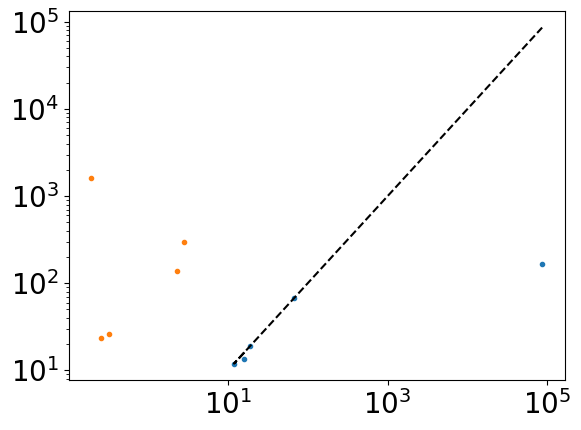

5113.461188078573 0.15273873084643924 0.8656643804142097
-1.807592265106275
0.99 0.9899983798205897
0.95 0.950077839253755
0.9 0.9001173371507465
0.7 0.7000119380946238
0.3 0.3000002895259147
0.1 0.1000000302626093
0.05 0.04999997050353491
0.01 0.010000001877356307
26652.056331753167 6127.552154647807
success 416
26652.056331753167 6127.552154647807 2.7278054660296283
27521.365725342137 0.09892171645451033 1.00476451968839
-1.7345617823955461
72604.47892884859 0.16604198052049482 1.4144754767918952
-1.7661858278499871
19856.44777061697 0.15645788959404866 1.364488941603783
-1.7665590692166417
0.99 0.9830346003673864
0.95 0.950018188760025
0.9 0.9000067139784186
0.7 0.7000004279166159
0.3 0.30000033162566725
0.1 0.10000017747440695
0.05 0.05000002557588084
0.01 0.010000002933699355
119.1042806885709 614.08986066571
success 417
119.1042806885709 614.08986066571 3.788872976713807
74727.9815274395 0.06674848779011554 1.0085198464109495
-1.4524087980491038
32212.50498019708 0.20533912495411

0.99 0.9864272083088348
0.95 0.9499466778929007
0.9 0.8999387009037044
0.7 0.7000015279929154
0.3 0.3000000655459538
0.1 0.09999992931563671
0.05 0.05000003940721766
0.01 0.009999998509884407
841.7443980596031 924.7133457368421
success 432
841.7443980596031 924.7133457368421 2.370673240741968
1314.1510527570808 0.054112798534631884 0.5623211803144508
-1.3522854799605712
26844.955089364976 0.19013123052432704 1.3806426846193478
-1.4847646683679923
256638.1684260597 0.1503842055366055 1.1995736819579879
-1.4951351225176472
0.99 0.9739167760605788
0.95 0.9500048925576405
0.9 0.8999998473954127
0.7 0.6999990335837751
0.3 0.30000333638615506
0.1 0.10000141323796304
0.05 0.049999314120460735
0.01 0.010000050807295394
1423.7052627924954 192.5593015663491
success 433
1423.7052627924954 192.5593015663491 3.112493497997096
252043.20374693308 0.05405138211981848 0.6971006360841246
-1.3024340436375683
77124.82108926997 0.21885722370398836 1.8510820715375391
-1.4531284782803837
281545.3526844388 0.

0.99 0.9431984802988764
0.95 0.9431984802988764
0.9 0.9000096555616038
0.7 0.700000624231808
0.3 0.2999998098882558
0.1 0.10000006769672644
0.05 0.04999999491938243
0.01 0.009999999001126338
6372.314174927034 106.62899446746644
success 448
6372.314174927034 106.62899446746644 2.539995213795725
985.2335429422405 0.04878137773160673 0.591489006970767
-1.336287549849401
44862.0160655346 0.18011578170845943 1.5090203550557142
-1.486071940607094
21581.96086832782 0.13739980214470157 1.2822523539416881
-1.4944131454280678
0.99 0.9826402700399318
0.95 0.9500107953065741
0.9 0.8999869332360416
0.7 0.7000008911291804
0.3 0.3000013724724467
0.1 0.10000126270234692
0.05 0.04999969136705845
0.01 0.009999985403958456
236.12832658959894 2359.7462787157347
success 449
236.12832658959894 2359.7462787157347 2.401398722468286
10911.740960715215 0.10812652111687983 0.902903182014442
-1.7524138079532872
38874.1068307617 0.17579493246853972 1.2386109620783365
-1.779415087424364
1587.7135859841592 0.1670173

0.99 0.9874624147914329
0.95 0.9499997579204205
0.9 0.9000129113408811
0.7 0.7000007410280003
0.3 0.30000027049116584
0.1 0.09999983217228947
0.05 0.050000058524028904
0.01 0.010000001562492136
382.9503270774356 258.19267637230666
success 464
382.9503270774356 258.19267637230666 1.468686226306655
12837.015119288752 0.05255556520793448 0.38569375924434257
-1.4406871709410303
9495.254880693994 0.15570765936912093 0.8379408293233466
-1.5553158228752781
27050.78058692326 0.12654640541602621 0.737277717580363
-1.5587799874806407
0.99 0.9905341957463996
0.95 0.9498230022626378
0.9 0.8998986980507385
0.7 0.7000003240017942
0.3 0.3000000424898288
0.1 0.10000023066635402
0.05 0.05000003797629241
0.01 0.009999999639707198
5702.751670467333 704.9167268514705
success 465
5702.751670467333 704.9167268514705 2.300095481083092
1299.6659990351661 0.09007418289230495 0.7574587764783668
-1.6372862658856528
2955.279608503546 0.18788047583564021 1.2281196544333446
-1.694335891207841
2190.1356154130117 0.1

0.99 0.9899932151672924
0.95 0.9500022035590839
0.9 0.9000008729914981
0.7 0.700003686739526
0.3 0.3000037398524016
0.1 0.10000175536870921
0.05 0.050000300933698553
0.01 0.009999997514185248
2482.562570287058 1220.2989241866128
success 480
2482.562570287058 1220.2989241866128 2.741123692123695
15151.89103063991 0.05733640281315014 0.7112154425434501
-1.430205080337414
243837.8872490851 0.18128991662391536 1.5804998517072377
-1.553996723822726
25977.701424425955 0.14326192593197914 1.375947061485866
-1.5574028985971875
0.99 0.9900230093510436
0.95 0.9497957678298509
0.9 0.8998720060569816
0.7 0.6999993024968246
0.3 0.3000010591988836
0.1 0.10000000627812969
0.05 0.05000006311425539
0.01 0.010000003300115284
35546.692792085734 2283.3968039756905
success 481
35546.692792085734 2283.3968039756905 2.9844384409283746
26593.295955207133 0.09218048405686313 1.0240239911561528
-1.6729550038922039
15541.014071991314 0.17898860520534118 1.5794288342620397
-1.722289869264987
15539.68998422439 0.1

3158.8373518265935 0.17103025085334578 1.0751485234609175
-1.6504093595094365
0.99 0.9900002006608403
0.95 0.9499821774393956
0.9 0.900022471935912
0.7 0.7000079753082731
0.3 0.2999999764338423
0.1 0.09999962044480361
0.05 0.05000011421165007
0.01 0.00999998539058478
670.2548990323468 823.1815276563914
success 496
670.2548990323468 823.1815276563914 2.5585773850528337
24790.033581063668 0.19699670025204327 1.4283238530269657
-2.095716255498991
9694.652866155311 0.1628914149191318 1.2840443202853256
-2.098939161384368
210780.4309170473 0.16184058880208038 1.2791852255320697
-2.098868908341081
0.99 0.9902293375311582
0.95 0.9500707757483118
0.9 0.900044599143435
0.7 0.700012624030779
0.3 0.3000000391617635
0.1 0.1000006830963197
0.05 0.05000016081660622
0.01 0.01000000487660446
923.3552260070949 173.0067072747773
success 497
923.3552260070949 173.0067072747773 2.3659097550756614
25771.66691206822 0.01942686384582723 0.27129713048454573
-0.7209540419339009
3009847.436464451 0.224752352152

13325.504099208896 0.15801934883844104 0.750040840159425
-1.4420203269814211
0.99 0.9893204937556461
0.95 0.9496932417172369
0.9 0.8996815353440745
0.7 0.6999850313058328
0.3 0.2999999892846337
0.1 0.09999982932830284
0.05 0.049999960705190395
0.01 0.009999998285889952
404.8350360664163 1202.7917371723906
success 512
404.8350360664163 1202.7917371723906 2.5775232027272748
17214.25231235363 0.07692187098425206 0.7577677291129314
-1.5387270366488808
22714.57572348348 0.1911021780795742 1.4032963372797704
-1.6126806443723365
37964.529613638784 0.16633647848178065 1.293708578926471
-1.6160083849239397
0.99 0.9798069429952396
0.95 0.9499999772042329
0.9 0.9000004929227933
0.7 0.6999999077162019
0.3 0.300000578906312
0.1 0.10000039178088761
0.05 0.05000007647203861
0.01 0.010000001467205737
481.0520329320367 300.4746149980622
success 513
481.0520329320367 300.4746149980622 2.806921677891974
15928.836276306714 0.0702282046067384 0.7885993252240594
-1.4993122043904954
92831.92332313758 0.20225

291.03751477478596 0.1737650286733866 1.1989663039897709
-1.196595495605222
0.99 0.9662862064393591
0.95 0.9536664077419295
0.9 0.9006046727621064
0.7 0.6999945828982115
0.3 0.3000000122168134
0.1 0.1000007382532603
0.05 0.04999954736128128
0.01 0.01000001739339637
3162.8299227910716 106.58221813439727
success 528
3162.8299227910716 106.58221813439727 2.667651251088455
838.8654258659777 0.036028697795459634 0.4721625641269354
-1.0979849875725383
22053.49536296684 0.2252961608855087 1.7540595715795189
-1.3358755515421323
3974.210672243079 0.14455274894393258 1.36731493619305
-1.3574145537208755
0.99 0.9827420607134387
0.95 0.9502406276110513
0.9 0.8998080868505682
0.7 0.6999617728443671
0.3 0.30000394487047993
0.1 0.09999982061661887
0.05 0.04999973897887143
0.01 0.00999999273818208
169.91385886447745 1126.970181982883
success 529
169.91385886447745 1126.970181982883 1.5481199309716362
606.410442507985 0.05278401332132518 0.3934590176503276
-1.4122497941243441
1577.881825862374 0.167531

0.99 0.9896765162501
0.95 0.9499874340750964
0.9 0.9000136710311507
0.7 0.7000054246107498
0.3 0.30000035317765844
0.1 0.100000078731587
0.05 0.050000045889434595
0.01 0.010000006111807477
1389.4772155563735 387.3155637444565
success 544
1389.4772155563735 387.3155637444565 2.609050330449046
6831.1983301200535 0.03841932633375525 0.49710913907635307
-1.1619985722149409
6245.665337009462 0.2135705916020369 1.681798719343985
-1.382641684352818
3304.0355158043344 0.14051333259331 1.3270330448141558
-1.3975002365860791
0.99 0.988352053729277
0.95 0.9495826900610594
0.9 0.8993721516492961
0.7 0.69993936185261
0.3 0.3000025064753407
0.1 0.09999979445172837
0.05 0.04999981903406351
0.01 0.010000023599355878
1019.6761663535602 184.58609352218042
success 545
1019.6761663535602 184.58609352218042 2.28973923717842
26568.996914440144 0.1835951039600684 1.1324867590808658
-1.9905542046789562
161564.10971776219 0.18700730475902397 1.1447582998197727
-1.9904697453186413
29719.24968647339 0.1870379058

0.99 0.977822192621313
0.95 0.9500105209935086
0.9 0.8999981294213935
0.7 0.700000580406803
0.3 0.29999998046718446
0.1 0.10000009606300878
0.05 0.05000002481161144
0.01 0.009999998219720564
319.98491611913465 728.6170667965615
success 560
319.98491611913465 728.6170667965615 1.9140158934881528
2079.2606145619047 0.1329296590691932 0.8568551622512778
-1.9039837469729146
3473.5202895223824 0.1611500613766193 0.9644680725006357
-1.9107283697466984
3328.291407003883 0.15901007674241935 0.9568652244365855
-1.9105988240450582
0.99 0.9900145712805081
0.95 0.9500409621928902
0.9 0.900034735022477
0.7 0.7000019511284632
0.3 0.3000018555982959
0.1 0.10000019853436122
0.05 0.0499999062127641
0.01 0.009999987386955166
8067.484986834513 398.05643170490004
success 561
8067.484986834513 398.05643170490004 2.147521052440974
24062.49762254283 0.04270237582064842 0.4745380987949908
-1.2907273032970614
27222.469017571082 0.17454191853834777 1.3087171507431798
-1.462604022442524
32566.881368080372 0.1275

0.99 0.990004485333453
0.95 0.9501271564324386
0.9 0.9001410092919779
0.7 0.7000158514738402
0.3 0.29999914076785444
0.1 0.10000010990296508
0.05 0.0499999748875402
0.01 0.009999983508707962
408.38875333769516 862500.9835440262
success 576
408.38875333769516 862500.9835440262 1.6583261395124114
2569.576131239932 0.05913786794338454 0.18317914432965773
-0.6884721505383825
23562.040794280092 0.4298008498572476 0.8608352691297636
-0.7210323532527254
12278.531527844516 0.4178777738751055 0.8472345639769483
-0.7397597818660544
0.99 0.617730805862072
0.95 0.617730805862072
0.9 0.617730805862072
0.7 0.617730805862072
0.3 0.30490570507005693
0.1 0.1002648504941812
0.05 0.05002904203644107
0.01 0.01000012168066416
106.93493479499323 133.76483848513143
success 577
106.93493479499323 133.76483848513143 2.0578366304234397
1249.097766228567 0.055290464300715825 0.49851331823505957
-1.3705917348873424
2230.4370353011413 0.19658291131282163 1.2023251460327131
-1.505873799540255
2389.618329716805 0.15

0.99 0.9868022301413373
0.95 0.9498299363178204
0.9 0.8992104687859158
0.7 0.6999159266069404
0.3 0.3000020110328671
0.1 0.09999992875723787
0.05 0.050000008778440234
0.01 0.009999999352604098
470.2019947806756 440.72028217213153
success 592
470.2019947806756 440.72028217213153 2.130111220327377
19844.89607879188 0.10212335497418783 0.8034463188648913
-1.7551691618804475
55501.86801886466 0.16609792392524667 1.0998387986599172
-1.7830826653387786
39004.06105591633 0.1573708886637114 1.065218918723945
-1.7832158387973993
0.99 0.9899999871661945
0.95 0.9500297805347065
0.9 0.9000566005939278
0.7 0.7000030382961201
0.3 0.30000054144054716
0.1 0.10000037066777723
0.05 0.05000006912380817
0.01 0.01000000010658568
305.61745200942744 357.8299667517378
success 593
305.61745200942744 357.8299667517378 2.6105987316482078
821.8505156805215 0.13506863365806404 1.0596527651810046
-1.8189068975040266
2125.4443126237475 0.19433945563741073 1.3288896352154878
-1.8344644717209146
6080.541437566456 0.18

0.99 0.9900190277273724
0.95 0.9495198341694123
0.9 0.8995785198851359
0.7 0.6999746054714617
0.3 0.3000014317323875
0.1 0.09999992552960714
0.05 0.0500000006864997
0.01 0.009999998320243415
3033.1325734782827 181.79167100324244
success 608
3033.1325734782827 181.79167100324244 2.4828182549480617
46397.81337882802 0.04165318008440001 0.42748021513115625
-1.074002170125869
361856.50515340455 0.28021970852974853 1.62431141839149
-1.3075108962371176
115677.38075325901 0.17934928718722762 1.2804334799927135
-1.3343950703800571
0.99 0.9745869608094425
0.95 0.9504466609049412
0.9 0.9000509474529149
0.7 0.6999922622076579
0.3 0.30000020705556674
0.1 0.10000000416143212
0.05 0.04999999253775776
0.01 0.010000000085960012
43219.09862503699 3839.593817116556
success 609
43219.09862503699 3839.593817116556 1.8934214912812357
993.8215689333152 0.06766557921705683 0.5380043582881917
-1.5091369744530445
1795.9795812460814 0.18099541432063707 1.0574323486812727
-1.605207545423738
1317.2909215789587 0.

0.99 0.8447601789240765
0.95 0.8447601789240765
0.9 0.8447601789240765
0.7 0.6995219100916137
0.3 0.3000132270867342
0.1 0.10000005367398164
0.05 0.0499997924836636
0.01 0.010000008819843236
9309.087028256736 1121.4439336635826
success 624
9309.087028256736 1121.4439336635826 2.664915964926168
10559.402779984892 0.11526636699215179 0.8758250032919289
-1.6355276329111055
13106.693628419653 0.23261081143030635 1.3933607293414243
-1.6743477193591936
42866.94128695481 0.21667100197514458 1.33681703081129
-1.6771846129987582
0.99 0.9535140891716214
0.95 0.9492588220610788
0.9 0.8997953462242368
0.7 0.7000665666058266
0.3 0.30000116070298194
0.1 0.10000030937642128
0.05 0.049999989598613126
0.01 0.009999992966269227
764.7217869125457 269.3628533837464
success 625
764.7217869125457 269.3628533837464 2.5747228383363105
11203.919981358207 0.0442201075800555 0.5073687984416868
-1.1912465326681883
422319.5323980691 0.2212277942593857 1.6030931057496587
-1.381763046157691
216249.51454836963 0.1566

0.99 0.9902282258373934
0.95 0.9499588772111175
0.9 0.8999406421748674
0.7 0.6999983923178806
0.3 0.30000322527421336
0.1 0.10000103964648469
0.05 0.0500001794044857
0.01 0.010000000575108439
1379.0595751603453 740.889219400855
success 640
1379.0595751603453 740.889219400855 2.4377209079371225
441.1347884490777 0.04995682169818074 0.41701160320704483
-1.068388305372112
2066.6914797388968 0.3301149635709174 1.5573652055797609
-1.2812612673183108
1093.666345619768 0.22209895339203586 1.2650447836466139
-1.3135650945579973
0.99 0.9528992681889351
0.95 0.950057749991801
0.9 0.8999998328018598
0.7 0.7000005560757127
0.3 0.30000180683929245
0.1 0.10000006541845864
0.05 0.0499999815593621
0.01 0.01000000472079323
247.2909552343432 2076.994779049088
success 641
247.2909552343432 2076.994779049088 2.563219379972983
67811.68260802522 0.048519754832610104 0.5878205172872872
-1.3229779165042859
229302.2081356363 0.189983499936921 1.531690772161531
-1.4778085435984427
52710.92753356043 0.1418883916

0.99 0.9900808487942471
0.95 0.9499399943924215
0.9 0.8999919919863882
0.7 0.700002361391513
0.3 0.29999993041333867
0.1 0.10000009725562574
0.05 0.050000009690306775
0.01 0.0099999969274441
3225.5621763047393 103.65968811474897
success 656
3225.5621763047393 103.65968811474897 2.2913234093265302
1943.0951816104134 0.0644630647598604 0.6244750103254784
-1.4729173348340827
4708.503572505195 0.19678806130313642 1.3152978943532114
-1.592852791673288
1590.6165604452042 0.1539220891292432 1.1451528908441941
-1.5924669463272598
0.99 0.9898572412338289
0.95 0.9483425374533773
0.9 0.8992311325704004
0.7 0.6999638186188768
0.3 0.300004117506665
0.1 0.1000005126643694
0.05 0.04999998065139543
0.01 0.009999980315721396
648.6995124500611 3414.8277186626783
success 657
648.6995124500611 3414.8277186626783 1.4433373728710845
918.0284103099958 0.1086039163981817 0.5629704543160711
-1.7842954829110915
1287.8110324076656 0.1687992452182517 0.7443438011861396
-1.8111669119328515
2393.1695216116946 0.159

6021.301033993888 0.17639932674387993 1.0800436183591837
-1.4978905627980827
0.99 0.9763445939092079
0.95 0.9500022971269595
0.9 0.8999990893093327
0.7 0.7000006695713257
0.3 0.2999999906919956
0.1 0.10000000287146207
0.05 0.050000014096353955
0.01 0.009999998922770441
1184.898097398649 693.9570065556959
success 672
1184.898097398649 693.9570065556959 2.777553617960767
1400.4998532874467 0.04910370970893462 0.550729582555187
-1.1966118993326966
10038.706296098415 0.2589770670533467 1.747564704847938
-1.3962135175769237
8027.532589301843 0.1755663901787647 1.4130871112175971
-1.4112864766686435
0.99 0.9789587903617404
0.95 0.9500387026229702
0.9 0.8999420528462951
0.7 0.699984516694838
0.3 0.3000003358350665
0.1 0.09999988701481342
0.05 0.05000012492441376
0.01 0.009999983923267038
24866.148291976 378.3914876753561
success 673
24866.148291976 378.3914876753561 2.8107741054069795
22166.6514012349 0.08343746867055751 0.9327708330086496
-1.643958018718999
42141.128973594015 0.1724681548674

0.99 0.9628792023719415
0.95 0.9514111499773118
0.9 0.9000516238151997
0.7 0.7000001532762976
0.3 0.29999996588905875
0.1 0.10000003922111964
0.05 0.050000002304476265
0.01 0.010000000350806624
21503.526059059208 7234.712022723942
success 688
21503.526059059208 7234.712022723942 2.7480392285073294
24870.98677993753 0.09049897912576105 0.9524279247588284
-1.681678375755988
65532.91838927111 0.17555924105656426 1.4625942466776254
-1.7359402324998068
140643.95993298225 0.1572455249769721 1.372082620440715
-1.7347148944867792
0.99 0.9900012182673161
0.95 0.9500750300415582
0.9 0.9001741919341733
0.7 0.7000198997516716
0.3 0.3000014912670111
0.1 0.09999999900239206
0.05 0.04999997251799942
0.01 0.009999997699956263
139289.66600177356 294.9331838820971
success 689
139289.66600177356 294.9331838820971 2.4549687806191614
1694.0378311822594 0.05377006829711517 0.3568529355461104
-0.9269465914317502
9800.823221297682 0.3938784476180513 1.51368497447804
-1.108985635345693
27455.086084253122 0.296

0.99 0.9714463988449443
0.95 0.9500038722994124
0.9 0.9000000052369104
0.7 0.6999994504599905
0.3 0.29999975664180023
0.1 0.10000003714960064
0.05 0.049999901268414644
0.01 0.00999999706642822
1688.9126992257968 151.6160381069411
success 704
1688.9126992257968 151.6160381069411 2.9008897979007657
371.3056386136698 0.10495479788164622 1.0605239387928844
-1.7280384822269976
519.1298502593571 0.18283206689748732 1.51057660091345
-1.7633215184447566
538.3961700476558 0.17044977839172404 1.45064831324821
-1.7634433231587312
0.99 0.990000043539271
0.95 0.9500120896737249
0.9 0.9000289433615136
0.7 0.7000017262465544
0.3 0.29999937397998155
0.1 0.09999992341773814
0.05 0.05000002364373614
0.01 0.009999999133642643
14867.038731839644 274.52353005283857
success 705
14867.038731839644 274.52353005283857 2.4399656438031743
1116.2047349689517 0.07832849194608317 0.7624866339999673
-1.5917570390756504
2164.697171339757 0.18274235223943144 1.3307357787874097
-1.667233275264063
2730.3992915697713 0.1

0.99 0.9642688370767939
0.95 0.9505074208954754
0.9 0.9000034424683441
0.7 0.7000001032815693
0.3 0.30000118334533943
0.1 0.09999964077786101
0.05 0.04999985965061005
0.01 0.01000002428052706
644.7005407705557 120.3759093405435
success 720
644.7005407705557 120.3759093405435 1.8096455417743647
30242.758260293373 0.11620957658882634 0.737458691119994
-1.8223483533650862
21918.438213491856 0.16412662311392853 0.9214185853903796
-1.8381352460380178
14612.497661760755 0.15929496358360282 0.9048736195233344
-1.8381840570589516
0.99 0.9856950363840247
0.95 0.9500564408180038
0.9 0.9000249545055933
0.7 0.700000968974459
0.3 0.3000002736142446
0.1 0.10000015107325527
0.05 0.0500000226335394
0.01 0.009999989444587711
1924.649670928335 227.3598941580745
success 721
1924.649670928335 227.3598941580745 2.630261043743133
5876.4646927947515 0.12934818433166145 1.0884961447355284
-1.835716076175874
18327.10191514456 0.1799009088208658 1.336970205248284
-1.850021819977233
6885.844995368269 0.174895591

122355.14686480869 0.16994749798213715 1.3076246871240955
-1.8425141962013027
0.99 0.9882047823176913
0.95 0.9500127028095946
0.9 0.9000057653344322
0.7 0.6999997710867348
0.3 0.2999998816544893
0.1 0.10000010183494938
0.05 0.050000014239602625
0.01 0.01000000151722382
113.76239274212813 71255.16034072643
success 736
113.76239274212813 71255.16034072643 2.6112283674837453
19016.944455247063 0.20122773307303018 1.413609704092582
-2.069029316751867
9567.681833198989 0.17590962600062823 1.3110347279648618
-2.0726279895457305
15704.320685051964 0.17466949356495723 1.3056776414290734
-2.072670205161964
0.99 0.9900213650828862
0.95 0.9500406458230641
0.9 0.9000580689846344
0.7 0.7000204717824764
0.3 0.3000035419635715
0.1 0.1000007882213795
0.05 0.05000012048351845
0.01 0.01000000259635243
14328.981518902381 331.60617738832633
success 737
14328.981518902381 331.60617738832633 2.511365499139136
3202.19913375212 0.08429924268440138 0.8213731174381115
-1.6313211136125734
11711.209989084897 0.17

81055.87204849135 0.13961214481890177 1.2002208054374455
-1.3693565081431034
0.99 0.985644616507901
0.95 0.9500885302358574
0.9 0.8996666411775737
0.7 0.6999583190677768
0.3 0.30000066905968786
0.1 0.1000000359481355
0.05 0.04999999502094414
0.01 0.009999996107778877
222.88834768275535 618.6397335065551
success 752
222.88834768275535 618.6397335065551 2.386175657233723
53570.70531233094 0.11803700239759136 0.9202380987211641
-1.7744555885253905
126033.1226449747 0.18613549660196274 1.225625701148403
-1.7978264769712018
37837.94992129596 0.17773756879933844 1.1933569036612586
-1.798022346258957
0.99 0.9899995001532923
0.95 0.9500108850012184
0.9 0.9000171943680114
0.7 0.7000002826130783
0.3 0.3000004076175528
0.1 0.10000025810522792
0.05 0.05000004769204656
0.01 0.010000001659677755
532.490891712819 125.58917957511376
success 753
532.490891712819 125.58917957511376 2.3861906074545014
793.8788729770811 0.05003335287254488 0.5552561555629733
-1.3356364911909484
3075.6602735557453 0.195991

3311.0267297765445 0.14456816040712178 1.1886873417882233
-1.7130397876934953
0.99 0.9899981530059394
0.95 0.9499692207056136
0.9 0.9000541547553849
0.7 0.7000088994471927
0.3 0.3000007377547964
0.1 0.09999982877986385
0.05 0.049999898746095645
0.01 0.010000002364291652
8190.968779915442 2143.540089356896
success 768
8190.968779915442 2143.540089356896 2.4416820661566607
7444.6386384672505 0.03907109315512488 0.4204079323876988
-1.074023568251741
42444.33701211868 0.2517683150802699 1.5792912190225663
-1.2976297741671625
23627.61318844099 0.16720625694176697 1.2623539249690041
-1.32667380816757
0.99 0.9710382058948172
0.95 0.9509325513394209
0.9 0.9000830874921625
0.7 0.6999995047868324
0.3 0.3000000350451858
0.1 0.10000000601514224
0.05 0.049999986000429666
0.01 0.010000001070585431
429.8141011402059 79547.25027858203
success 769
429.8141011402059 79547.25027858203 2.1718073275252356
2628.791250209697 0.06021518321572645 0.5538536970406864
-1.4152075212333315
33638.842679554065 0.1997

0.99 0.9900003103370559
0.95 0.950010879623678
0.9 0.9001046377249523
0.7 0.7000156208349725
0.3 0.3000051403952313
0.1 0.10000046878711
0.05 0.04999958985283407
0.01 0.009999949179065411
160.94287192572835 5249.806851228163
success 784
160.94287192572835 5249.806851228163 2.8165224046522446
3898.39117663052 0.046084343971894995 0.4559588683264779
-1.0204849049427924
7328.595894235033 0.30752215140546174 1.7850722453230896
-1.2264300707985067
218419.909702703 0.2166306331013908 1.47599992596245
-1.2672363129774649
0.99 0.9289830620586831
0.95 0.9289830620586831
0.9 0.9000367294306161
0.7 0.6999940864261632
0.3 0.2999995648470014
0.1 0.09999992904292669
0.05 0.05000006451137023
0.01 0.009999999656498572
877.839120977553 12390.198433866672
success 785
877.839120977553 12390.198433866672 2.899433007537842
12968.85144242885 0.11367141143704036 1.092464635527293
-1.7542486084020998
6200.618683964528 0.18656269684744237 1.4962374469243984
-1.7816834820011513
13856.051118334994 0.176785497012

0.99 0.9900000890912888
0.95 0.9500438428398648
0.9 0.9001137479829818
0.7 0.7000154347369224
0.3 0.3000001012694861
0.1 0.10000030608756225
0.05 0.05000002186577806
0.01 0.0099999998374066
2801.5936609779424 506.2063327096793
success 800
2801.5936609779424 506.2063327096793 3.8360182284247397
1720.0872991954564 0.0547330641685277 0.7625940485506343
-1.1988854901068275
13977.23358584108 0.27174621392133497 2.3483249747911907
-1.3747005508016712
7904.668621235238 0.19677643894757946 1.9640372335762706
-1.3952986511471948
0.99 0.9576378233569287
0.95 0.9500382713723144
0.9 0.9000017762342563
0.7 0.6999992833769402
0.3 0.3000004322591615
0.1 0.09999999200341027
0.05 0.05000015609569182
0.01 0.009999949796789075
48595.15434220561 630.3188350167477
success 801
48595.15434220561 630.3188350167477 3.104675446053465
3901.113850819479 0.08990258612103272 0.9216295348360771
-1.547140345063746
2080.7881845444676 0.2242178983111717 1.68770994610091
-1.619763542054913
1619.1168828661707 0.194973178

45564.61480623168 0.13376733797307758 0.6409346363803428
-1.3138403256278959
0.99 0.9910288803795243
0.95 0.9499803013742603
0.9 0.8992687453412929
0.7 0.6999398957173191
0.3 0.30000213367426637
0.1 0.10000001649942958
0.05 0.050000006558544335
0.01 0.010000000031890631
430.3521621954833 170.9812279429561
success 816
430.3521621954833 170.9812279429561 2.632239784134129
2807.3075259219045 0.04561662077577933 0.43570580039320606
-1.039795776803661
38010.92614924426 0.31403480512883314 1.7028777194314646
-1.2635717968114546
8061.303720747172 0.20871799876799407 1.370298077029005
-1.298610987000533
0.99 0.9485472576573194
0.95 0.9485472576573194
0.9 0.9000082475891503
0.7 0.6999996766705745
0.3 0.30000000744071104
0.1 0.1000001179971211
0.05 0.05000002412883274
0.01 0.010000002428569328
3567.41970655165 1319.5004783013085
success 817
3567.41970655165 1319.5004783013085 2.941191060536724
476.65225671222504 0.10323806656391174 1.1412496361426192
-1.7797748208740043
212.27287233170784 0.1602

0.99 0.974232119867892
0.95 0.9506698737685315
0.9 0.9001045233309305
0.7 0.6999900264387418
0.3 0.3000001794959522
0.1 0.09999998323683403
0.05 0.04999998421283996
0.01 0.010000000270293357
103.34265878937703 551.7035864735471
success 832
103.34265878937703 551.7035864735471 3.0902516410547434
13269.835654679386 0.10910881750199133 1.2024191541821276
-1.7821840715088826
8365.919239267592 0.16780456334439234 1.5876111585642543
-1.8057446567748008
153360.85631217246 0.1603754893989786 1.5451770231505468
-1.8057734397359937
0.99 0.990004754779754
0.95 0.9500001835520986
0.9 0.900004566747508
0.7 0.6999991176975082
0.3 0.30000051953405926
0.1 0.10000026696399492
0.05 0.050000067421082824
0.01 0.009999998658196597
3132.6464487820813 1130.7904426525058
success 833
3132.6464487820813 1130.7904426525058 2.6341721921833776
10684.113865312711 0.051921399464340906 0.566909355933704
-1.2677989185386516
57480.75020464866 0.2199730816902688 1.5761312250595567
-1.4237553343395988
49763.947009126394 

0.99 0.9880540213416603
0.95 0.9499794691480022
0.9 0.900002652770332
0.7 0.7000066883410209
0.3 0.30000067770468514
0.1 0.09999993002551409
0.05 0.049999957556951566
0.01 0.00999999768262565
3279.4522258053735 1524.2205415310862
success 848
3279.4522258053735 1524.2205415310862 2.982823002352142
18610.71184555984 0.13039819784464027 1.0466687680830675
-1.6924235548412099
23060.18464936093 0.23623321764887292 1.5374075688336175
-1.7188066087313214
10169.501609297347 0.22498533540020305 1.4946014448188396
-1.7206624284798824
0.99 0.9547217181454191
0.95 0.9488340422121949
0.9 0.8998595985702393
0.7 0.7001001497804917
0.3 0.30000236275067405
0.1 0.10000039052764555
0.05 0.04999979846402397
0.01 0.01000000655877335
2810.298222900128 332.4329541413874
success 849
2810.298222900128 332.4329541413874 3.520644432277832
37662.80649478514 0.03065000478826975 0.4472997832751233
-0.81001303545741
122382.33692405428 0.340518369262303 2.5020544493613497
-1.115422208449394
165797.78352867576 0.19531

599.9101045616962 0.15261218998930612 0.9844501573461854
-1.768269006539348
0.99 0.9899996480172729
0.95 0.9503677856130013
0.9 0.9003621583456479
0.7 0.70002675607878
0.3 0.3000037571139932
0.1 0.10000023618480142
0.05 0.05000001561800175
0.01 0.010000004591152868
388.19202669917127 1594.4438130819267
success 864
388.19202669917127 1594.4438130819267 2.1758304523145675
12482.840283954967 0.033997627754994895 0.3876009070897781
-1.1035794593661676
81393.66584604811 0.18810398870795741 1.3901247651733153
-1.3164969100303157
7323.242790005367 0.13190896485223583 1.1227689370903364
-1.3438875774838726
0.99 0.9647696306900997
0.95 0.9508495188626963
0.9 0.9000027640513484
0.7 0.6999999005979789
0.3 0.29999992460583524
0.1 0.1000000289171773
0.05 0.05000003016688913
0.01 0.010000001098670918
219.6698540776847 195.6367122495569
success 865
219.6698540776847 195.6367122495569 2.2265509505399144
16203.238453712573 0.047731798304118625 0.5005830675803344
-1.305747026775774
33046.98491790245 0.1

2895.0182172925356 0.14937096491875276 1.4521317522234611
-1.5497578734786024
0.99 0.9873412370432288
0.95 0.9499747182802906
0.9 0.8999483429476175
0.7 0.69999380354834
0.3 0.30000184047595785
0.1 0.09999990246291086
0.05 0.050000030251089275
0.01 0.010000003704703123
372.39256479205596 1675.284552727178
success 880
372.39256479205596 1675.284552727178 2.0526336267509935
641.2625646493141 0.0429956030271402 0.4153729317091682
-1.2143134962033482
1248.0286415897071 0.2105381804558359 1.2788570754503175
-1.4053946300683555
1222.0795984779727 0.1474499039830731 1.0439414806901
-1.4201840516725452
0.99 0.9835541659610787
0.95 0.9501213135800827
0.9 0.8998956891333758
0.7 0.6999923053090359
0.3 0.3000006559530866
0.1 0.10000000224505194
0.05 0.05000011649899073
0.01 0.010000030737344755
1585.9890613243342 1975.5049083255046
success 881
1585.9890613243342 1975.5049083255046 3.1219927673047287
2546.55649981477 0.05614340708780006 0.7745395229507551
-1.3912833735221628
25048.809098310456 0.18

0.99 0.9900175128221264
0.95 0.9499391343939516
0.9 0.8999882213612481
0.7 0.7000051386340747
0.3 0.3000003010823558
0.1 0.1000004309590949
0.05 0.05000007915332979
0.01 0.00999999782652647
9613.002612043263 640.6115571666512
success 896
9613.002612043263 640.6115571666512 2.3046632849821975
705.0534922254142 0.0823820900315356 0.6947644614799481
-1.5605202155671336
4489.657098184066 0.20261840335087367 1.2595395516847296
-1.637788859688583
286.28821038656605 0.17407835850391623 1.1550035676994619
-1.6398005359940002
0.99 0.9861649105243943
0.95 0.9499972213040326
0.9 0.900007625477547
0.7 0.7000030007851374
0.3 0.30000035430270366
0.1 0.09999965495568212
0.05 0.05000033602981218
0.01 0.009999987309290779
6228.206171142755 388.81105574462583
success 897
6228.206171142755 388.81105574462583 2.260526860730991
359.985182587555 0.04394254245095109 0.4778486490051801
-1.2522213724896647
1228.273756088692 0.19715760107310215 1.394389192844589
-1.4346300362667592
474.26118940881355 0.14073248

4516.167613956443 0.2033739144695784 1.4051752028613669
-1.4570114067669513
0.99 0.961339720928133
0.95 0.9500210204439882
0.9 0.8999998057005372
0.7 0.7000016621283235
0.3 0.299998956309258
0.1 0.0999999769786532
0.05 0.049999995700613024
0.01 0.010000003469185517
2744.009707562403 2290.086172478133
success 912
2744.009707562403 2290.086172478133 1.7961873831370943
2328.5631295006674 0.04929837406068729 0.25791924084822915
-0.9163241920581812
81750.81839660379 0.40522413410127006 1.1614997775563842
-1.1397191623668226
754113.491534711 0.27706488328683376 0.955356820417029
-1.1934070876247926
0.99 0.8906238027189702
0.95 0.8906238027189702
0.9 0.8906238027189702
0.7 0.699967590694128
0.3 0.2999999323436894
0.1 0.0999999557760152
0.05 0.04999998936828585
0.01 0.009999986766068445
113.82703960944478 614.5074872888467
success 913
113.82703960944478 614.5074872888467 2.3719456612489718
81894.22687274519 0.03262129646203552 0.376023894485268
-1.002281406367549
107081.60629677294 0.253350244

5885.619787553682 0.16671449348302014 2.038271429760799
-1.5967247514891898
0.99 0.9804936548966592
0.95 0.950000051961603
0.9 0.900000853083369
0.7 0.6999987876010046
0.3 0.3000013596228207
0.1 0.09999994196873423
0.05 0.04999991123670603
0.01 0.009999966562673084
28630.70886717527 179.38646058890944
success 928
28630.70886717527 179.38646058890944 3.0209605104203847
4315.431186087608 0.04359104482005453 0.6187598579929271
-1.2248141570102076
16001.624655142623 0.22107204111163398 1.9030148400115625
-1.4254684017876347
8865.55062340298 0.1484448401631434 1.5278456255291013
-1.4353972467145932
0.99 0.9897074905565094
0.95 0.9474495963210408
0.9 0.8986581799934156
0.7 0.699925463301307
0.3 0.3000026534482883
0.1 0.10000004398129979
0.05 0.04999998549568688
0.01 0.009999995009588333
24817.483187719434 261.6801211914506
success 929
24817.483187719434 261.6801211914506 2.0036383723819995
18133.132933466088 0.13113705600137618 0.7514519168597155
-1.7502237037190131
12847.713255677607 0.2108

0.99 0.986542421648449
0.95 0.9499959059897429
0.9 0.9000062148669757
0.7 0.7000019917980815
0.3 0.2999997413002521
0.1 0.10000016247544222
0.05 0.050000105188503785
0.01 0.00999999714413807
1423.3705815292783 917.8184901154609
success 944
1423.3705815292783 917.8184901154609 1.6984040407056544
255.32457490372354 0.08721450807748984 0.5189562095152563
-1.5722393881788101
576.5645151187025 0.20767277066109774 0.9223599278994986
-1.6440182040938829
3364.1419877910143 0.1806578635375274 0.8513674521460286
-1.6462302527098784
0.99 0.9825959675770536
0.95 0.9499998897808224
0.9 0.9000013373012701
0.7 0.6999957785643356
0.3 0.29999984430656373
0.1 0.09999959895487416
0.05 0.050000176209067757
0.01 0.009999951806655413
198.66351481088444 161.06298577551516
success 945
198.66351481088444 161.06298577551516 2.7064008761841567
16938.366547167774 0.04597946187603486 0.5283013931611018
-1.1830392524624638
19500.690234524347 0.2564310911726117 1.740571842559281
-1.4016989002468634
10655.91555739890

0.99 0.990096398175352
0.95 0.9499912665296377
0.9 0.899974326510614
0.7 0.6999890462448722
0.3 0.30000298933078867
0.1 0.10000447251103825
0.05 0.05000085031708575
0.01 0.009999832341376188
26036.133926629587 301.0120581957413
success 960
26036.133926629587 301.0120581957413 1.5931347311315278
60900.49294696597 0.06813797747712427 0.3261019918150101
-1.2242618831264338
68437.7188480039 0.29438761296281435 0.9201853328285653
-1.3495674765357624
65200.36807228954 0.23829929378846226 0.8169266506209563
-1.3714885853186989
0.99 0.9159073654993173
0.95 0.9159073654993173
0.9 0.8993756522196146
0.7 0.6999610282390799
0.3 0.2999975317366808
0.1 0.09999923351441704
0.05 0.04999970489024783
0.01 0.009999993685421971
5932.575456569945 127.4729950113663
success 961
5932.575456569945 127.4729950113663 1.8835659198264
1710.7014444141582 0.038458658610043966 0.36677106183984837
-1.1808884686121706
7508.2718221391 0.20285317917820914 1.1974951691778395
-1.3895343522132577
16913.661175717498 0.137278

0.99 0.9863793891516978
0.95 0.9500904024109744
0.9 0.9000821683882113
0.7 0.7000316607336594
0.3 0.30000466130931075
0.1 0.10000255842279523
0.05 0.050000374668632476
0.01 0.009999991502556626
171.30190834072795 103.29530890530194
success 976
171.30190834072795 103.29530890530194 1.9506533903964838
12225.499409555185 0.10359106865458316 0.6858814116899066
-1.6941978436170722
32765.341554568266 0.18750111422629254 1.0148712711109604
-1.7287195385503307
39829.42446292065 0.17583118805296358 0.9767353631691722
-1.7299731397464215
0.99 0.9770241892045547
0.95 0.9499578738638019
0.9 0.9000391336083137
0.7 0.7000101766610523
0.3 0.3000011718403187
0.1 0.1000003181368109
0.05 0.05000005785146405
0.01 0.0100000042935594
8547.20951951193 271.07473393423334
success 977
8547.20951951193 271.07473393423334 1.6741475526156422
3240.9166341020614 0.06307318582516057 0.3879925834663997
-1.332119374855423
1822.0936920779038 0.23837538140732667 0.9766733884130859
-1.4660906107336094
5846.786943671777 0

0.99 0.8834899495592771
0.95 0.8834899495592771
0.9 0.8834899495592771
0.7 0.699772464667774
0.3 0.3000020633630461
0.1 0.09999994734130555
0.05 0.05000001175761616
0.01 0.010000000598895721
395.08961017934274 297.69655988721325
success 992
395.08961017934274 297.69655988721325 2.8554983254066366
23173.509693697844 0.03819444127953817 0.5584874198708956
-1.1847229615522776
551294.1865196691 0.1926057272054324 1.7947759515605333
-1.383439616720429
214493.60347825536 0.13466935192017074 1.456435839458559
-1.400718503143648
0.99 0.9877444681599146
0.95 0.9503978203051331
0.9 0.8998705737173464
0.7 0.6999923740899335
0.3 0.30000068501328225
0.1 0.10000001123223637
0.05 0.0499999998897659
0.01 0.010000001082723954
6363.947453165578 209.34585845758525
success 993
6363.947453165578 209.34585845758525 3.782818767677447
59234.0703527666 0.08971235069065665 1.0822791719906948
-1.5151075226870134
38273.42787562568 0.2364359225636316 2.064096977153494
-1.590996639602109
226802.43826198767 0.204767

71322.81351790183 0.1706186475380558 1.0526961235162682
-1.4832225099234166
0.99 0.977397545954861
0.95 0.9500070272738329
0.9 0.8999977694014042
0.7 0.7000012733199079
0.3 0.2999999231841315
0.1 0.10000002655912237
0.05 0.04999999767799489
0.01 0.009999999245088148
417.93077128613095 113.43508132919922
success 1008
417.93077128613095 113.43508132919922 1.5726464372199775
59039.09326370314 0.19920147722884035 0.8522394830544011
-2.0699211016936703
16322.055110371723 0.17444442447626138 0.7912721876800743
-2.0753707042981318
28254.43205672475 0.17263784396983653 0.78652495952474
-2.075593522921694
0.99 0.9901345000642431
0.95 0.9499780784417388
0.9 0.8999642755423622
0.7 0.7000136645127728
0.3 0.30000499500154804
0.1 0.10000181634520065
0.05 0.049999385246492334
0.01 0.009999908550248598
366338.63356011524 2778.4426892210577
success 1009
366338.63356011524 2778.4426892210577 3.2644720864251777
22791.27968177144 0.04424620655760091 0.5455976525757233
-1.0481790586892819
31886.22318246714

2368.457013595453 0.16682800759199123 1.2065490068740452
-1.4656523369925138
0.99 0.9770062299935314
0.95 0.9500202938455413
0.9 0.8999979552375804
0.7 0.6999999590122783
0.3 0.2999998021889902
0.1 0.10000021361327915
0.05 0.04999997307041285
0.01 0.00999999466647771
286529.1477638609 272.5238084708231
success 1024
286529.1477638609 272.5238084708231 2.349367858592452
8174.984296912717 0.05419732400044152 0.5831480783252971
-1.3917156430978728
17291.22278943545 0.18891902086506293 1.3822893564876284
-1.5330715165725934
6247.10807110295 0.14353592701743936 1.1789790799915878
-1.536241659977569
0.99 0.9900475876617559
0.95 0.9493364854873725
0.9 0.8995788557115871
0.7 0.6999777023872295
0.3 0.3000017452439497
0.1 0.10000018805845255
0.05 0.05000003071828675
0.01 0.009999995890339753
1110.4978025132953 1066.5627548986884
success 1025
1110.4978025132953 1066.5627548986884 2.7134923564939863
357.00507097755394 0.07737983542056559 0.8226196309032329
-1.5654009246838847
6715.433120902376 0.18

0.99 0.9542203230038975
0.95 0.9499984191381105
0.9 0.8999644861987021
0.7 0.7000017880920978
0.3 0.3000001098467596
0.1 0.10000003774659016
0.05 0.050000026256495855
0.01 0.009999994172996983
134.85444335865049 338.8331484287347
success 1040
134.85444335865049 338.8331484287347 2.8392814633927754
231.57546419400592 0.05849429465660528 0.7391133162960893
-1.4330651508284629
2359.0492175304826 0.18505022990766937 1.6396295136316448
-1.558199702144225
2448.823967866833 0.14553281866604872 1.4242321254849255
-1.5610043545590988
0.99 0.9900714164100067
0.95 0.9497259637524603
0.9 0.8998413516554689
0.7 0.6999979628263403
0.3 0.2999991655065944
0.1 0.10000086339567238
0.05 0.05000000735551017
0.01 0.010000025292744161
1715.5296598668638 3380.660858469808
success 1041
1715.5296598668638 3380.660858469808 2.4944934436010113
131612.17695266253 0.0642718240127563 0.7315034088877823
-1.5365279663832772
1639382.234351171 0.1550732335928835 1.3558878969856452
-1.609070792358927
422883.0560745546 0

0.99 0.8246731648451612
0.95 0.8246731648451612
0.9 0.8246731648451612
0.7 0.697887710200566
0.3 0.3000202093074697
0.1 0.10000019863610811
0.05 0.05000002966415135
0.01 0.01000000559713264
169.8764936196574 1928.7929620238815
success 1056
169.8764936196574 1928.7929620238815 2.6833940818495554
57212.04857968605 0.20127561470810418 1.453507336494389
-2.069525532472711
10476.15476991686 0.17584991773641218 1.3460718988344784
-2.072353124233461
5284.27286800587 0.17487674258646782 1.3416942635020468
-2.0723513261813262
0.99 0.9898238409339674
0.95 0.950144608788208
0.9 0.9000563072016576
0.7 0.7000049358421796
0.3 0.30000162733782954
0.1 0.10000026645951285
0.05 0.049999982671420924
0.01 0.010000001350855658
6386.596783248751 337.75389076001795
success 1057
6386.596783248751 337.75389076001795 2.8184448100582227
1682.8508911323786 0.09400661767607262 0.8719773824017101
-1.5830513617466562
1651.6550521315964 0.20890486454936988 1.4994214528715242
-1.636939723431745
1015.0893100672673 0.18

28338.872373423168 0.16204188919443216 1.7670441529845442
-1.901921896595237
0.99 0.9899771531970579
0.95 0.9500174060572973
0.9 0.9000489641657413
0.7 0.7000073095428477
0.3 0.29999961883178455
0.1 0.10000020259142224
0.05 0.050000049039867066
0.01 0.010000002304669187
177.48758782895843 9963.339045891944
success 1072
177.48758782895843 9963.339045891944 2.3694812135946894
12275.945034318836 0.01959102558589582 0.12223450695176886
-0.1
1572773.6611338167 0.6935677772773153 1.713922811810892
-0.4207359701299069
252016.01631654834 0.40123347317757896 1.3999043931275452
-0.5656861748069945
0.99 0.7233325176740846
0.95 0.7233325176740846
0.9 0.7233325176740846
0.7 0.6996978092795963
0.3 0.3004482107672015
0.1 0.10004113006779924
0.05 0.05000626999224361
0.01 0.010000069024853925
4571.815268436922 111.62436902890789
success 1073
4571.815268436922 111.62436902890789 3.271429113791611
8803.401259420005 0.06383975689031057 0.895831622908958
-1.4770377406752462
34008.905882264946 0.18428110865

1392302.5578976863 0.15935733660650606 1.1679248538287934
-1.6435092019788293
0.99 0.9900001600394888
0.95 0.9499524037000785
0.9 0.8999831141739342
0.7 0.7000057910215444
0.3 0.30000066954083
0.1 0.1000005146478736
0.05 0.05000009233901631
0.01 0.00999999817850313
187.46641700047977 247.5449688376993
success 1088
187.46641700047977 247.5449688376993 2.2820711285262765
3346.214368023435 0.06750073438392677 0.5513025890751345
-1.3681817023166911
8974.458505701108 0.23755256976146077 1.3154021267179314
-1.4917004198885306
21124.943894222797 0.1889648117434936 1.1544601469887013
-1.5018599486392576
0.99 0.9651638854976401
0.95 0.9500078403256519
0.9 0.8999978963296564
0.7 0.6999993615178893
0.3 0.29999948073123345
0.1 0.10000011037758313
0.05 0.05000000197269686
0.01 0.010000010050936144
524.1158332183257 972.6229354344814
success 1089
524.1158332183257 972.6229354344814 2.1315117261945877
3725.992663355637 0.02484835758802439 0.18704500073393773
-0.48857674900612336
247323.68107687082 0.

0.99 0.9789668047912365
0.95 0.9576155563364428
0.9 0.9013414690261561
0.7 0.6999777434029878
0.3 0.30000064802843235
0.1 0.10000015537616219
0.05 0.04999997791290526
0.01 0.009999998298709227
125.98516381803289 935.0518021698847
success 1104
125.98516381803289 935.0518021698847 2.357980318289358
4294.694869806943 0.011592723765851047 0.17812309238648333
-0.3584200923430295
1298611.0277127083 0.27435339844071766 1.9496499418746114
-0.7953130143589351
27480.227239032916 0.13441219486448477 1.3866058788076043
-0.9361987284203837
0.99 0.9319189000858338
0.95 0.9319189000858338
0.9 0.9166102236990932
0.7 0.7001352948156361
0.3 0.2999998320300694
0.1 0.09999999575321081
0.05 0.0500000042197388
0.01 0.009999998332494826
199.30113249892347 9884.620253403273
success 1105
199.30113249892347 9884.620253403273 3.0738063426765794
6764.760118424284 0.10670196312529152 1.1785248350448119
-1.7693844641896392
10006.691210668545 0.1698230358442695 1.5867454549158688
-1.7971059766807622
13871.7636242127

26279.55187696488 0.17671835308725556 0.9995841700606425
-1.331312324448612
0.99 0.9671255088202657
0.95 0.9504471676348247
0.9 0.9000340723337746
0.7 0.699998690260222
0.3 0.2999999912104352
0.1 0.09999993543367923
0.05 0.04999998067921147
0.01 0.010000000617027913
9021.797684174564 1482.2879797035328
success 1120
9021.797684174564 1482.2879797035328 2.2573670203994274
28547.36088488056 0.1689895263571829 1.1523804363667256
-2.0180473932535548
13032.395056112224 0.16298592605841408 1.1282931650167498
-2.017746947506728
8021.103536268188 0.16308415336779208 1.1286933242065214
-2.0177544999347266
0.99 0.9901839022386126
0.95 0.9500694021317029
0.9 0.9000678358855746
0.7 0.7000124329114323
0.3 0.2999998506265799
0.1 0.1000002124568614
0.05 0.05000006601116523
0.01 0.009999999617951798
2792.2512512851117 365.38341074671655
success 1121
2792.2512512851117 365.38341074671655 3.1276539115575166
7999.898537948652 0.029793676065198317 0.4479473074962562
-0.914076471352952
380309.4207051425 0.2

0.99 0.9750108262531589
0.95 0.9499421567616736
0.9 0.9000463604595952
0.7 0.7000197857234229
0.3 0.2999998291408234
0.1 0.10000004780047521
0.05 0.050000013328613264
0.01 0.009999999915243382
1948.0765389338499 156.72141288554508
success 1136
1948.0765389338499 156.72141288554508 1.9474282804052419
1453.3787323260465 0.1392563394869145 0.9014242578334987
-1.9329955283147022
1590.8604569522347 0.15896233678855617 0.9777058489294927
-1.936549001172426
10809.429700130815 0.1578626722202787 0.9736557918143555
-1.936496950696258
0.99 0.9900053896128073
0.95 0.949996683473915
0.9 0.8999924863663151
0.7 0.7000013677329228
0.3 0.29999934134921935
0.1 0.10000023544171197
0.05 0.05000008126447034
0.01 0.0100000054784068
258.0081199268543 198.10438128224033
success 1137
258.0081199268543 198.10438128224033 2.041647756455404
14043.19670127279 0.05706705973530356 0.35916811815828387
-1.0926939181545405
23992.449092954514 0.33151525625751394 1.2477537818226947
-1.2670500675728658
19694.028403881373

0.99 0.9459906601162889
0.95 0.9459906601162889
0.9 0.9000016071912672
0.7 0.7000016016856054
0.3 0.3000007280332912
0.1 0.09999992285787623
0.05 0.04999999232347444
0.01 0.010000002260939778
144.96179485681378 103526.08178220694
success 1152
144.96179485681378 103526.08178220694 3.0542344080135746
19852.087360087746 0.1025004736167842 1.1398039276188177
-1.7459155587266473
28561.81068357356 0.1712100215395963 1.584558145115498
-1.7779871795006505
23874.533894777895 0.16070425061645824 1.526752736107211
-1.7777798538430785
0.99 0.990000650663207
0.95 0.9500731240489405
0.9 0.9001167707362211
0.7 0.7000118849079181
0.3 0.30000057667109675
0.1 0.10000102761410065
0.05 0.04999999935558237
0.01 0.00999997079735317
1374.808028452557 239.97682420104087
success 1153
1374.808028452557 239.97682420104087 2.54874558204816
21445.170955466856 0.09314038392105481 0.8848352092320737
-1.6831318107242599
45438.11104782058 0.17424344898865107 1.340077045869753
-1.726798366557852
107926.2010481747 0.160

16644.778358088693 0.20895519548511557 1.753863059145875
-1.414096877774922
0.99 0.9642242459161948
0.95 0.9500138182547027
0.9 0.9000002612773049
0.7 0.699998919260806
0.3 0.29999993847262546
0.1 0.10000003703821035
0.05 0.049999986801381756
0.01 0.009999998828563398
4347.535641704001 1762.892811189847
success 1168
4347.535641704001 1762.892811189847 1.699889801975076
4698.6904261597165 0.08605947888673181 0.5624142392485431
-1.641331069696031
68938.6957610126 0.17728681812370573 0.9059416924426844
-1.6967500177497838
5378.072061831429 0.15924078210390386 0.850755730165239
-1.697578237973548
0.99 0.9900888165077057
0.95 0.9499965133398519
0.9 0.9000155242465049
0.7 0.7000018531830106
0.3 0.3000000312179185
0.1 0.0999999110388725
0.05 0.05000001572305001
0.01 0.00999999704607333
333.1449188257656 420.40436011494415
success 1169
333.1449188257656 420.40436011494415 1.8522696951253748
536.6471430671512 0.15442653314776544 0.8948288306722245
-1.9701314852354865
302.1681403399584 0.1640847

4808.8289881288165 0.21265092649081072 1.3613170246459676
-1.1950924797646703
0.99 0.9243987244946695
0.95 0.9243987244946695
0.9 0.9000225415497357
0.7 0.6999930793335415
0.3 0.30000105570128216
0.1 0.10000047701888268
0.05 0.0500001693301983
0.01 0.010000005903368187
1308.9004066480302 411.63814962167595
success 1184
1308.9004066480302 411.63814962167595 2.6807990928781633
6957.042317281308 0.11897456776199855 0.9986905441059537
-1.7443933313217062
26137.445344193933 0.198410918794373 1.3847886162484375
-1.772691756373833
28225.7278620175 0.18779274166193535 1.34114418903191
-1.7731741563781145
0.99 0.9812940189871017
0.95 0.9500200566626154
0.9 0.9000146709054724
0.7 0.7000027167021863
0.3 0.3000006624157115
0.1 0.10000020783292984
0.05 0.050000032899276556
0.01 0.009999995712700372
2653.8937534567954 170.2166067605538
success 1185
2653.8937534567954 170.2166067605538 1.2955535360866912
12316.27753877804 0.10259976332238015 0.45032814390888243
-1.6842074426353961
24571.70990362011 0

36665.811819404305 0.16678230391191592 1.1316667157978684
-1.6551184158676553
0.99 0.9899993422837602
0.95 0.949890659077118
0.9 0.8999799518264642
0.7 0.7000076365475723
0.3 0.30000090754830144
0.1 0.09999993374251653
0.05 0.049999971790909134
0.01 0.009999995951541394
2353.1332830325455 3458.962669405796
success 1200
2353.1332830325455 3458.962669405796 2.637190274724767
1286.9506391783304 0.03636183889939772 0.46578357123201386
-1.0961453930306386
4000.9407758145103 0.23245499171539405 1.7302249687982645
-1.3321276033619858
6961.936565466756 0.14848863097423629 1.352514000542852
-1.35418820247069
0.99 0.9886442602400358
0.95 0.9501030916425472
0.9 0.8995506672013395
0.7 0.6999664469185365
0.3 0.3000015016009287
0.1 0.10000000410736219
0.05 0.04999998725866725
0.01 0.01000000638749669
161.52804687347734 478.8337940334715
success 1201
161.52804687347734 478.8337940334715 2.187082179704101
34193.57809767052 0.0550897514553123 0.5919307813301455
-1.4668716364811907
68701.48312191754 0.1

10441.820993934887 0.14241999435403271 0.9656967789429666
-1.7034436175759933
0.99 0.9900000222361062
0.95 0.9499995097170911
0.9 0.9000826711305285
0.7 0.7000134887746504
0.3 0.30000032105898217
0.1 0.10000005689912954
0.05 0.05000000568921857
0.01 0.01000000496502008
459.6904678181803 5661.939830753702
success 1216
459.6904678181803 5661.939830753702 2.9077201994016484
1532680.5628614903 0.08468182186174453 0.8083941348267718
-1.4902010722681212
82604.74374845739 0.22922515148155367 1.5909334855768376
-1.5684598824497442
66679.52019849292 0.19864965491399375 1.4645637100983357
-1.574831184327829
0.99 0.9581849458228243
0.95 0.9499456947641036
0.9 0.8999217370498122
0.7 0.700017810431159
0.3 0.30000062825491985
0.1 0.10000022613690933
0.05 0.049999957197471384
0.01 0.009999985424418573
763.3182534354645 2413.355113720074
success 1217
763.3182534354645 2413.355113720074 1.77705119727387
1637.021660501033 0.0952134581229728 0.6436675655417371
-1.7199833621949796
4234.475979371645 0.1686

0.99 0.9904461885105014
0.95 0.9494805171327199
0.9 0.8995506613452964
0.7 0.6999776301825684
0.3 0.3000003461494754
0.1 0.09999993203108118
0.05 0.05000005925915987
0.01 0.00999999999864506
1169.6125057980971 495.41451931054576
success 1232
1169.6125057980971 495.41451931054576 1.7143835252666548
6614.404853432418 0.06670416010778503 0.5418304538301351
-1.6015708443197645
79852.40542172833 0.14068909949428898 0.9214087208262418
-1.6643195032076634
4152.936735460281 0.12613602885994235 0.8591216422071459
-1.6662728443643917
0.99 0.9796881090586527
0.95 0.9499975977705583
0.9 0.9000047090877016
0.7 0.6999987753057219
0.3 0.29999718651242535
0.1 0.10000085483764454
0.05 0.05000034516427079
0.01 0.009999988746626217
476.70312535173315 245.5162401389847
success 1233
476.70312535173315 245.5162401389847 2.2601782018768533
6787.214314297599 0.06833669320413803 0.6444117612447712
-1.5121015435281377
12873.496043860947 0.18902818396986537 1.276843664667038
-1.618151622644736
9509.585919009209 

0.99 0.9289908359324766
0.95 0.9289908359324766
0.9 0.8998665525829701
0.7 0.6999417451767806
0.3 0.2999890393500519
0.1 0.0999977044876467
0.05 0.049999499186123245
0.01 0.009999992269381067
223.2515451033532 427.7523166054557
success 1248
223.2515451033532 427.7523166054557 3.0770265187072967
2196.5796069971657 0.07154215727705926 0.9092718376629577
-1.543184993349731
3524.6018484281617 0.18037711785677266 1.701775416339568
-1.6307869975903704
7464.1806435041 0.15225939050702972 1.5402178885405502
-1.6317488368542103
0.99 0.990028584820696
0.95 0.9499656893685253
0.9 0.9000051232827188
0.7 0.7000068844849324
0.3 0.30000034990207586
0.1 0.09999999257757605
0.05 0.05000000118640719
0.01 0.01000000232168671
7907.228369633775 219.8442228349471
success 1249
7907.228369633775 219.8442228349471 2.821787311518034
590.9610011284908 0.10430829950297318 0.9610400670176104
-1.6664944274692326
212692.9173963841 0.20169213810309836 1.4815990750215766
-1.70896726264265
1020.7949877152279 0.18609472

0.99 0.965348127567662
0.95 0.9501997624161285
0.9 0.9000001468609287
0.7 0.700000247980364
0.3 0.29999954871848167
0.1 0.09999995270091368
0.05 0.05000006398170093
0.01 0.010000003061253407
329.7388296567899 667.3826241722564
success 1264
329.7388296567899 667.3826241722564 2.381748200576031
19685.33228665714 0.03577334218652792 0.3858731906190836
-1.0211575118999814
851882.4909620631 0.27819215394253916 1.6102893374878509
-1.2832336462012466
31984.588928773668 0.16558458502612486 1.2280733919994031
-1.3099505896618235
0.99 0.9846465433724759
0.95 0.9504919956942266
0.9 0.8995159948176658
0.7 0.6999394620955407
0.3 0.30000077334090147
0.1 0.10000000004267219
0.05 0.05000000482827047
0.01 0.009999999382546596
1833.1352202738722 312.57911018734353
success 1265
1833.1352202738722 312.57911018734353 3.146478915368654
45726.12391986446 0.07887780370920418 0.8939716153336529
-1.5090577988699208
50632.30679650361 0.21497479326983715 1.7461961464515956
-1.5996541893935288
20994.487348647475 0

529870.386545253 0.17707417630309086 1.4324822856871664
-1.7624370121346833
0.99 0.9900000201561091
0.95 0.9500080551621501
0.9 0.900022269765671
0.7 0.6999998885411505
0.3 0.30000159540823346
0.1 0.10000066787556704
0.05 0.05000011126099937
0.01 0.010000000741394016
1397.714722594002 303.9980727673371
success 1280
1397.714722594002 303.9980727673371 1.6886062065135614
2007.302295448785 0.0350613110911464 0.2866984457848802
-1.0618539061433818
11844.487151073754 0.2350608247313381 1.1177701448667703
-1.3055621463236262
14572.638494407027 0.14961737529848096 0.8703819490506817
-1.3319851263818672
0.99 0.9809228086731961
0.95 0.9507741809957835
0.9 0.8999754401962688
0.7 0.6999808871075882
0.3 0.300000958863928
0.1 0.10000002264025579
0.05 0.049999991291230346
0.01 0.010000001569648965
206.47215206434387 343.6165522803191
success 1281
206.47215206434387 343.6165522803191 1.399033139692825
758.92622752579 0.08158073864793962 0.4170900910867402
-1.5508637319926115
3500.482306145263 0.20300

28785.8845319633 0.21683647834681827 1.3674396657784613
-1.6127977541966583
0.99 0.9619658109322893
0.95 0.9497420063429365
0.9 0.8999970801239585
0.7 0.700011927418962
0.3 0.3000005705693
0.1 0.10000028067591778
0.05 0.050000038610225735
0.01 0.010000002264701527
3022.700199342219 5559.176242488601
success 1296
3022.700199342219 5559.176242488601 2.372519167937475
1480.4761369503597 0.08023581708590048 0.6968537393020089
-1.5379238012380694
5605.243946765951 0.20403900029092764 1.3025656907047312
-1.6191636024129596
4074.584169390244 0.1745346218960787 1.1902786576542608
-1.6221014271151426
0.99 0.9801475354339458
0.95 0.9500000153549151
0.9 0.9000007443744464
0.7 0.6999998016698343
0.3 0.2999977304724186
0.1 0.09999977952509385
0.05 0.04999987811938638
0.01 0.009999990742320412
256.16943263266444 228.191929781835
success 1297
256.16943263266444 228.191929781835 2.8899448377636676
2959.8505311088848 0.032097173837383475 0.32113279016619545
-0.6936501903518788
367846.0252823053 0.39369

3947.253859788864 0.18018802643215012 1.3413907670978769
-1.3953673958569481
0.99 0.9690824885039042
0.95 0.9500009208085117
0.9 0.9000003287682115
0.7 0.6999940519391266
0.3 0.29999898423850746
0.1 0.09999992700856601
0.05 0.049999908527017425
0.01 0.009999984452669699
2600.6286355936645 536.6700420947072
success 1312
2600.6286355936645 536.6700420947072 2.202687186540195
5475.566610129584 0.11153489392127908 0.8746523474525978
-1.7998252726080848
8196.131592219972 0.1658519027866388 1.1278039607249746
-1.8204468439804156
4103.681749110465 0.15937149599195685 1.1012936824001451
-1.8204074802310586
0.99 0.9894819468564238
0.95 0.9499995363196538
0.9 0.90000189937506
0.7 0.7000003035011123
0.3 0.299999927431442
0.1 0.10000006431386184
0.05 0.04999998633451636
0.01 0.009999998572600123
661.6979165720136 60010.52559642363
success 1313
661.6979165720136 60010.52559642363 4.075454890077675
1030.4627731958108 0.05970527302008147 0.9380178341726126
-1.3261300015276756
3422.7276743474417 0.230

0.99 0.9792949901627036
0.95 0.9499998944574481
0.9 0.9000015304287173
0.7 0.6999985456661282
0.3 0.3000006350593456
0.1 0.10000032705501496
0.05 0.04999994417964706
0.01 0.009999985025677808
3162.6812906725063 271.1992073117771
success 1328
3162.6812906725063 271.1992073117771 3.4519656290447513
160.28890861313673 0.06648275006719424 0.9933536881035909
-1.5201348827886891
577.9856100313715 0.17847071002619797 1.939958902819801
-1.6216470078388565
536.3206629891286 0.14612291792414292 1.7256909937343434
-1.6215001386208603
0.99 0.9899955962954903
0.95 0.9495830415123008
0.9 0.8998217847027484
0.7 0.6999941378776083
0.3 0.3000030162278468
0.1 0.0999992550046499
0.05 0.04999933319329582
0.01 0.01000004544803349
224.06041971369817 902.9772312632379
success 1329
224.06041971369817 902.9772312632379 3.004871594031997
2825.649942622892 0.07246244126089828 0.8216449075995359
-1.4757764907567719
4726.8480818128455 0.21382089065852922 1.698462256388456
-1.5822964463232574
2044.3648201211709 0.1

0.99 0.9241608581651545
0.95 0.9241608581651545
0.9 0.8999997046867028
0.7 0.699999873322994
0.3 0.3000012936723467
0.1 0.10000046880054088
0.05 0.04999972019181095
0.01 0.010000052553206015
388.7063813145367 1184.5572053351098
success 1344
388.7063813145367 1184.5572053351098 2.7775579639424626
65149.71330965879 0.080197650099958 0.8832628979293821
-1.6069137055742215
97073.99908346187 0.17952832569909116 1.5022594926901107
-1.6751373491410804
61010.82559494963 0.15682758009327896 1.3893070126075526
-1.6754675344482872
0.99 0.9899731563749562
0.95 0.949795592171746
0.9 0.900003976807396
0.7 0.7000090328290317
0.3 0.3000000454952682
0.1 0.1000000391534633
0.05 0.050000026702473034
0.01 0.009999998935400137
4102.193592932638 115.21626832667572
success 1345
4102.193592932638 115.21626832667572 3.4653453798342424
2310.5151683749905 0.06719344834239464 0.8988781211447388
-1.4299685591488165
5701.859594154555 0.2149422859820269 1.975913618239768
-1.5440714076991318
13585.067086849358 0.1724

0.99 0.9900052792322703
0.95 0.9499107789960699
0.9 0.8999684003046883
0.7 0.7000051897797772
0.3 0.30000256349233284
0.1 0.09999992833845472
0.05 0.05000003242407372
0.01 0.010000008418593555
704.7178420416088 127.88576773120442
success 1360
704.7178420416088 127.88576773120442 2.294629247672715
2243.8421507954563 0.06464117520648603 0.6314961384921363
-1.4813763401033384
9072.138197509224 0.18800251403579135 1.302285444347277
-1.591423654650642
34593.91708033115 0.15144340015984725 1.149298361467311
-1.5929241713270512
0.99 0.9900206707007189
0.95 0.9497304663082702
0.9 0.8998749885825481
0.7 0.7000013208182402
0.3 0.30000101353491376
0.1 0.10000010792485575
0.05 0.04999996275773787
0.01 0.009999989657830945
616.2549102937203 582.8245378509349
success 1361
616.2549102937203 582.8245378509349 2.107290041821352
8220.045944158674 0.079334636441389 0.6612914328445526
-1.5953971543454473
19544.055035536283 0.17876883524575057 1.1397115896367553
-1.6635984451501193
18165.108105671774 0.156

21087.153534839446 0.18096252709289506 1.4692483892457828
-1.4779414307847794
0.99 0.9693455082173501
0.95 0.9500010019238078
0.9 0.9000000600890747
0.7 0.7000004628340654
0.3 0.30000051417792334
0.1 0.10000004082606705
0.05 0.05000000232588453
0.01 0.009999998602670458
972.585867227536 108.18324980699056
success 1376
972.585867227536 108.18324980699056 2.7366895345250755
44477.83423922726 0.06806926329434396 0.8039886633552961
-1.5381087785849044
66944.64984370128 0.1719975876969471 1.5117811911500036
-1.6246955826425709
104805.70071492784 0.1457272057502766 1.3704378645486444
-1.6260232101335026
0.99 0.9900254084089105
0.95 0.9498470076818035
0.9 0.899964094784378
0.7 0.7000059293794959
0.3 0.29999996980368254
0.1 0.10000008930955882
0.05 0.05000004414413692
0.01 0.009999999215975301
1699.6475533856376 8058.56411621553
success 1377
1699.6475533856376 8058.56411621553 2.405654303008825
2130.0786158359183 0.06350282384438968 0.5052625734603922
-1.2466278136822986
6425.252016834139 0.27

0.99 0.9845199995728959
0.95 0.9499998688693428
0.9 0.9000213430088653
0.7 0.7000031946144811
0.3 0.30000004362119165
0.1 0.10000020446525747
0.05 0.04999999375369503
0.01 0.009999997800090461
402.23640869323157 1031.2287166674282
success 1392
402.23640869323157 1031.2287166674282 2.400000499157843
5557.154415776673 0.06364762820278146 0.6206859355825929
-1.4273811364774374
12016.17034925677 0.20176053299667515 1.3724402644895843
-1.5440053654329673
6564.3291047731045 0.161754859829078 1.207575786937336
-1.5494714855142664
0.99 0.9819521028596438
0.95 0.9500011134789798
0.9 0.8999987978593798
0.7 0.70000200175943
0.3 0.2999998022491571
0.1 0.10000002292995608
0.05 0.04999999271946142
0.01 0.009999999743213434
1640.7285633577496 166.573787121977
success 1393
1640.7285633577496 166.573787121977 2.6156340368378337
21213.251413579186 0.10256824958500221 0.9436801308833108
-1.7165556532722215
5503.300939680965 0.18351713167153405 1.3654291250851815
-1.754000008870546
3889.5836752514183 0.17

0.99 0.9900024114429536
0.95 0.9500486029852858
0.9 0.9000483808475415
0.7 0.7000130430928357
0.3 0.3000003570772995
0.1 0.09999906677524838
0.05 0.049999935589191496
0.01 0.010000024228579284
7193.325258773422 5619.793771076539
success 1408
7193.325258773422 5619.793771076539 2.515722745401131
27342.721583171835 0.10117080184688318 0.9648131359105961
-1.7696208540832954
41948.03769894264 0.160815719633375 1.3005297069014152
-1.7985958464077287
66491.7217722032 0.15193804118237167 1.2573529120417535
-1.798244668915243
0.99 0.9899996966196959
0.95 0.950062572777961
0.9 0.9000943512394167
0.7 0.7000095389611716
0.3 0.3000001982135708
0.1 0.0999999100319407
0.05 0.04999996388697408
0.01 0.010000000315103647
964.7608652605165 104.71029869440639
success 1409
964.7608652605165 104.71029869440639 2.3918314537553558
3484.537687589508 0.08448260707231577 0.6852118461971622
-1.5162485709870381
14819.119316754375 0.21693705886525566 1.3022563849268949
-1.5902404076558523
7150.375156055172 0.18953

0.99 0.9884816052948042
0.95 0.9499810244996134
0.9 0.8999858685005997
0.7 0.700002682433474
0.3 0.3000000006900682
0.1 0.1000000433566521
0.05 0.05000003181600257
0.01 0.00999999939874739
27308.019043556276 466.0756361519137
success 1424
27308.019043556276 466.0756361519137 2.224987121807828
63423.7858586296 0.06586106547524347 0.3924146009659892
-1.094895304542478
234314.36191696473 0.3449730890682184 1.2907499869861427
-1.2239845512829772
581937.0751528767 0.2815584389223976 1.153917703956021
-1.2557392124545543
0.99 0.8697566493498196
0.95 0.8697566493498196
0.9 0.8697566493498196
0.7 0.6995013156855062
0.3 0.3000070458140338
0.1 0.10000011217427503
0.05 0.05000004680876966
0.01 0.010000001894468874
110.1899169558492 268.6037019469385
success 1425
110.1899169558492 268.6037019469385 2.7122803744536106
2095.1412536162775 0.045383260786888195 0.5775816035076395
-1.2586175325499478
7140.64644337527 0.20001409508039333 1.6647226259077792
-1.43669212536027
13767.030122761988 0.143982562

0.99 0.9787528858408606
0.95 0.9500015635023545
0.9 0.8999872328903754
0.7 0.7000008599254942
0.3 0.2999999446897999
0.1 0.10000000871953194
0.05 0.05000000718862024
0.01 0.01000000323549919
126.22244200143227 406.17691742986483
success 1440
126.22244200143227 406.17691742986483 3.172402910161498
51696.3665568756 0.058245613942449675 0.746006886530056
-1.3447689852185047
14524.694607144149 0.2262877900926448 1.8842364946621117
-1.4943231196113704
41358.99643554566 0.16863134611502117 1.599013650206545
-1.5013107740960876
0.99 0.9856700609524243
0.95 0.9499545985000974
0.9 0.8999008320517251
0.7 0.6999957229978409
0.3 0.3000003882590899
0.1 0.09999997841137317
0.05 0.049999991735900806
0.01 0.009999999381488402
2076.030885510318 9046.325190171388
success 1441
2076.030885510318 9046.325190171388 1.6660500745283198
18122.773921617903 0.07253988971235255 0.4920935617475046
-1.542779256679818
10256.063014384423 0.1825062972549032 0.9147841540637018
-1.624100413565
19075.21384517425 0.155738

238061.11762441596 0.13324558202363088 0.8310891888566222
-1.1272992815309268
0.99 0.9449493452028195
0.95 0.9449493452028195
0.9 0.9015720908538212
0.7 0.7000004395806589
0.3 0.30000005373855787
0.1 0.09999975120699528
0.05 0.04999997076119197
0.01 0.010000000110426132
2441.5535022550234 741.7145248457014
success 1456
2441.5535022550234 741.7145248457014 3.3152442710800516
28973.64502016938 0.10404497703383264 1.2652465505214376
-1.7653792487420026
82279.05034770818 0.16623105352250475 1.7127256735260843
-1.7937837891598527
8506.630796931879 0.1573124843953012 1.6573799160464855
-1.7936568576068652
0.99 0.9900000365586694
0.95 0.9500151200074256
0.9 0.9000292519741733
0.7 0.7000029314375933
0.3 0.2999994753344639
0.1 0.0999998579521659
0.05 0.05000002594124736
0.01 0.009999996777168963
102.15311997844681 145.21670876250923
success 1457
102.15311997844681 145.21670876250923 3.176971471680656
5031615.433965338 0.04637392242827196 0.633265903317844
-1.2012055715519896
162172.42901999716 

1686.1553735281439 0.14349220144959177 0.6705601020094398
-1.6439543248111044
0.99 0.9900019674715433
0.95 0.9498266013817046
0.9 0.8999824717681955
0.7 0.7000089890421791
0.3 0.3000012076655415
0.1 0.10000006449476119
0.05 0.049999985454101226
0.01 0.010000006606421991
2403.9699206222567 463.7466932364372
success 1472
2403.9699206222567 463.7466932364372 2.360048025228146
4152.5643340414645 0.12368005912215559 0.9883992755020454
-1.8460831468497332
6079.965034329036 0.1692280347699777 1.2005396200037617
-1.8610544511999185
5690.289969232328 0.16422089101034473 1.1796468919368979
-1.8607768168396568
0.99 0.9900142624477738
0.95 0.950120041242629
0.9 0.900126571418476
0.7 0.7000115688242499
0.3 0.3000007241826544
0.1 0.10000005968685985
0.05 0.049999999387470705
0.01 0.009999997237290274
438.56022491208137 207.25282991985276
success 1473
438.56022491208137 207.25282991985276 2.6357214688630455
12216.276935198495 0.024169872299757127 0.34982337305575595
-0.8479586092121412
161691.2465365

0.99 0.9900082323119467
0.95 0.9500131606509321
0.9 0.9000434374452801
0.7 0.7000051045092974
0.3 0.3000002794995864
0.1 0.1000007505067797
0.05 0.050000158758149844
0.01 0.009999997861111148
200.4706951820092 1552.961671564931
success 1488
200.4706951820092 1552.961671564931 2.264730497197569
3519.8316993889425 0.048565369806252784 0.5177188862955446
-1.3202149510358374
28918.10776835302 0.1905255098472855 1.354082554131673
-1.4755321709898213
208222.0273667403 0.14255106801511072 1.143892780317684
-1.484329743411036
0.99 0.9904757993917668
0.95 0.9498151598480629
0.9 0.8998520645573604
0.7 0.6999976270617799
0.3 0.30000044367535433
0.1 0.10000021730789722
0.05 0.0499999523627817
0.01 0.00999999704133198
262.9599220708194 250.83033101215378
success 1489
262.9599220708194 250.83033101215378 2.7336442702652395
200935.3158688659 0.0474642713620179 0.5884883889235833
-1.2680517901568527
67133.08542902369 0.20671127326659608 1.6615501719660821
-1.437654702773659
68184.26963630508 0.1506686

0.99 0.9899382681083371
0.95 0.9494420331839075
0.9 0.8998317763311471
0.7 0.7000054127518629
0.3 0.30000088087698645
0.1 0.10000104853059685
0.05 0.0500002468490192
0.01 0.010000047051301175
294.6916146636052 313.9545288229335
success 1504
294.6916146636052 313.9545288229335 2.5004791941643103
13528.297124193678 0.04460773157561386 0.47166074624013604
-1.1532729683945888
12712.642408848738 0.2408119680084965 1.5657492064365286
-1.3487308697502447
6647.421936445747 0.16856164534907248 1.281597701539008
-1.370247810307833
0.99 0.9665315331557951
0.95 0.9500265578966124
0.9 0.9000055270535853
0.7 0.699999435468046
0.3 0.2999999281616459
0.1 0.10000001422744051
0.05 0.0499999863000606
0.01 0.010000001065040273
130.68404067267755 2402.795869108798
success 1505
130.68404067267755 2402.795869108798 2.669623185763785
6768.464130036942 0.04428864713221368 0.5834086597547297
-1.2811058027390978
48321.35842549067 0.17947251111602577 1.6099416566742524
-1.4438861385054311
21439.66445494229 0.1344

0.99 0.9681645087296312
0.95 0.9500083386144751
0.9 0.8999991331888483
0.7 0.7000021241472121
0.3 0.30000033676134064
0.1 0.10000011029136661
0.05 0.050000017784492694
0.01 0.009999999707285757
2766.2752951526923 295.5351239662963
success 1520
2766.2752951526923 295.5351239662963 2.2367176350173374
446.20704101284036 0.045585502762280926 0.5102924824211159
-1.3184760083549594
46476.53133363013 0.18026022041124648 1.3545410714705752
-1.484898031818616
2022.8056378464958 0.1319610964465941 1.1261192072854003
-1.4909044312585444
0.99 0.9901291061380835
0.95 0.9488480854971039
0.9 0.8993474239309517
0.7 0.6999665814078746
0.3 0.2999948770241302
0.1 0.10000029012353669
0.05 0.04999923228337205
0.01 0.010000018262682413
2632.471508730723 2488.0504411705706
success 1521
2632.471508730723 2488.0504411705706 1.8116430222070945
15439.240284592468 0.0519377201973589 0.41610312925120113
-1.3243167038663897
73471.08792085001 0.2041450763693235 1.0792310985546074
-1.476460346498532
35798.4810792892 

0.99 0.9882481879114461
0.95 0.9499670320307431
0.9 0.8999890191093243
0.7 0.700006781810229
0.3 0.300003615594355
0.1 0.09999973941532427
0.05 0.05000046189189258
0.01 0.010000051294694987
100.49586443363617 687.3982382525861
success 1536
100.49586443363617 687.3982382525861 2.401233841110186
2515.2065385058236 0.07256427849308371 0.44743330718988666
-1.1426477008455218
12217.133326991823 0.35276715567842387 1.3824453869981899
-1.2651347488469535
8379.484355142346 0.29067641533886945 1.242418942145484
-1.2948619577155183
0.99 0.8662735498883218
0.95 0.8662735498883218
0.9 0.8662735498883218
0.7 0.6994473672593099
0.3 0.3000005683349912
0.1 0.09999980689274013
0.05 0.049999914821087746
0.01 0.010000009376697302
306.4653039176607 1508.6884803680343
success 1537
306.4653039176607 1508.6884803680343 2.7580733518216993
5749.144460893781 0.08054609014933725 0.8342339456256508
-1.5634240822431829
11993.218735174936 0.19616836749307787 1.5070823430487015
-1.6405464125511409
7976.839760881063 

0.99 0.9859908619718835
0.95 0.9500005949985437
0.9 0.8999999023396686
0.7 0.7000008248854148
0.3 0.2999998015750902
0.1 0.1000000631142527
0.05 0.0500001449157291
0.01 0.009999996708105346
4882.551669785506 343.94864182614015
success 1552
4882.551669785506 343.94864182614015 1.2713923528490312
600.5750009391038 0.06882767131092228 0.3588950277229224
-1.5034356844653072
3284.096115547757 0.19468170396125833 0.7235693104140964
-1.6158967626479273
2009.1462946167496 0.15509856760716778 0.6345423527028614
-1.614318793150915
0.99 0.9899955566566755
0.95 0.9499830409648657
0.9 0.8998638249206964
0.7 0.6999576817338603
0.3 0.30000181252612795
0.1 0.09999996490136513
0.05 0.050000080645214516
0.01 0.010000046481547092
191.5762657681512 657.7283112629418
success 1553
191.5762657681512 657.7283112629418 3.210403176459288
41552.95863616501 0.02798475221191284 0.3781543445173216
-0.7442790269858969
141134.986085978 0.3552935182620471 2.3354099035732796
-1.0699461005597055
1148405.420612471 0.1964

0.99 0.9614097171916635
0.95 0.9499587328145177
0.9 0.8999903483860825
0.7 0.7000006675122068
0.3 0.3000003436441017
0.1 0.10000004034639705
0.05 0.04999983479832929
0.01 0.00999997775647436
228.61350650774688 130.5124718357778
success 1568
228.61350650774688 130.5124718357778 2.8612720982987616
5691.1361602187535 0.08356899778927171 0.9690899990540224
-1.6616698950185007
4795.177466470427 0.16582918907128175 1.5256412917111373
-1.7175164355170554
3731.3798655584387 0.14869765401825424 1.430062912388159
-1.7171683945110614
0.99 0.9899998760854991
0.95 0.9499870566031319
0.9 0.9000747903076126
0.7 0.7000125234570763
0.3 0.30000068343058
0.1 0.10000009004945482
0.05 0.05000005423490236
0.01 0.00999999045899914
668.4812991648579 182.97685161042145
success 1569
668.4812991648579 182.97685161042145 2.3480322115572956
331.78884709298313 0.029492697283219366 0.3149192212926728
-0.8570502280933132
15512.875219686406 0.3177711561302469 1.6911933460173696
-1.174088640901236
10551.698482960528 0.

0.99 0.9900003520717712
0.95 0.9499965107960117
0.9 0.9000350240747845
0.7 0.7000060684113275
0.3 0.29999990019767825
0.1 0.09999998149759362
0.05 0.05000000084076204
0.01 0.00999999899932352
606.653826539772 326.6826666300133
success 1584
606.653826539772 326.6826666300133 2.6734124805106148
2024.8428529860503 0.050779111720521325 0.5248657398040013
-1.188024499910901
9082.983690839052 0.26877605927929266 1.663090586043609
-1.377784359355166
3767.4911091015247 0.18681851787297044 1.3659774579859727
-1.3965994732753662
0.99 0.972838729227607
0.95 0.9500716224656441
0.9 0.9000078387930062
0.7 0.6999992232151004
0.3 0.3000002180262171
0.1 0.10000006561005267
0.05 0.049999993861550775
0.01 0.010000000837835463
1186.3138386555702 135.3644975097786
success 1585
1186.3138386555702 135.3644975097786 2.0978448042123325
2721.761105568421 0.043823449039662565 0.43882600319487797
-1.243097986978387
23985.069112733447 0.2012029067255766 1.2977640578583474
-1.4280027493071872
10606.454181070558 0.1

1724.317128646301 0.14581818042616684 1.3127490081222322
-1.8044536759265302
0.99 0.9900030866628131
0.95 0.9501406567177776
0.9 0.9002030031283174
0.7 0.7000243167323432
0.3 0.2999937679997197
0.1 0.10000523643846009
0.05 0.04999968936189012
0.01 0.009999980131388855
152754.09349040728 574.5529402069818
success 1600
152754.09349040728 574.5529402069818 1.6231031433116485
1463.8111682679762 0.03003673285592918 0.25690686163821647
-1.0009191614019852
12862.743614759473 0.21722154926660622 1.0947652643737367
-1.260928933711084
1891.9189488908198 0.13731466722514132 0.8433511370160016
-1.2943135569978028
0.99 0.9767552158137742
0.95 0.9515336095294705
0.9 0.900156358413718
0.7 0.6999876996026121
0.3 0.3000004914922431
0.1 0.10000004869770163
0.05 0.04999998774313587
0.01 0.010000000152988249
23801.03352108362 140.65533928226463
success 1601
23801.03352108362 140.65533928226463 2.464537700310225
10755.417633979227 0.07532162783593911 0.7308635165105687
-1.5462616256775727
22125.45650265376

539.5247926318232 1238.1218082179432
success 1615
539.5247926318232 1238.1218082179432 3.094990444968714
10584.800739392058 0.06881568515780413 0.8604788068602514
-1.4902217228709715
12429.723643427114 0.1970411442802487 1.7413169303251637
-1.5927187341636135
17725.46169674748 0.16071519396490028 1.5506764419134862
-1.5945024784863955
0.99 0.9900074951953669
0.95 0.9495916256331023
0.9 0.8998117075955773
0.7 0.7000000205759428
0.3 0.3000000659337395
0.1 0.10000008114741245
0.05 0.05000003531694254
0.01 0.009999998347896695
6652.657736698025 405.2845684263337
success 1616
6652.657736698025 405.2845684263337 2.0922174307672305
1047.3994348719855 0.04363148058777069 0.41089389829860784
-1.1883057435824684
4178.815546559372 0.2399325661565144 1.3322196597429563
-1.3983037795565134
2385.9672624401373 0.15800836368990348 1.0622986388750593
-1.4116433889431086
0.99 0.9902195181516183
0.95 0.9490341615143534
0.9 0.899187762751891
0.7 0.6999451355089158
0.3 0.30000167373898423
0.1 0.10000004364

0.99 0.9859131193829285
0.95 0.950000593827365
0.9 0.9000128823782428
0.7 0.7000040663439834
0.3 0.2999990728556741
0.1 0.0999997804577707
0.05 0.04999995052045013
0.01 0.009999991343065867
1128.1361245017247 115.26851287031509
success 1631
1128.1361245017247 115.26851287031509 2.029485707809558
41491.066290010516 0.018999598494417073 0.18992111601365358
-0.5444345040743844
996700.0630251054 0.3200570746921017 1.5445512864794968
-0.9093271679697367
775527.8589920527 0.17461164934690987 1.1469877797164647
-1.0157327465055288
0.99 0.9268523429667038
0.95 0.9268523429667038
0.9 0.9056960617171761
0.7 0.7000070524273185
0.3 0.30000004281917686
0.1 0.10000000220031266
0.05 0.05000001324446922
0.01 0.009999999789574566
202.52731532369666 835.4882407316162
success 1632
202.52731532369666 835.4882407316162 2.4730893262589406
639.6217140381556 0.05111666623192965 0.5061784929899732
-1.224187762177799
15541.920028936389 0.2505357134104386 1.5334310764829227
-1.4110966682149615
2468.5360919488394

0.99 0.9881324359104442
0.95 0.9495920093917425
0.9 0.8994492465703032
0.7 0.69995570102694
0.3 0.30000141978389405
0.1 0.10000021421994564
0.05 0.049999961239981384
0.01 0.01000001429738711
1196.2771077154455 2088.3739327562157
success 1647
1196.2771077154455 2088.3739327562157 2.217087916882014
260.0073594615886 0.06278867282296129 0.5021804039259494
-1.3122136845553958
720.4241152633969 0.25563004407217554 1.312921869765814
-1.4591856109004209
1003.7348550245529 0.19285468859561378 1.1236992751030899
-1.4709799735049591
0.99 0.9728392047654639
0.95 0.9500007234616693
0.9 0.899999992543062
0.7 0.6999983237575197
0.3 0.29999908732731206
0.1 0.09999985832771348
0.05 0.050000026629328974
0.01 0.009999992171643428
159.59494943469866 456.46428984057934
success 1648
159.59494943469866 456.46428984057934 2.7813723070884087
9393.640231810527 0.05609905404616469 0.6445774609022671
-1.332091969533168
15173.417535218312 0.21963856362074216 1.64998812294431
-1.480595344460155
19354.645463772962 

2000.811425862409 0.15288778776225412 1.258724401506552
-1.7649461057045306
0.99 0.9900006854084493
0.95 0.9500451195435904
0.9 0.9001433236727342
0.7 0.7000146620624993
0.3 0.299999262850579
0.1 0.10000071052576784
0.05 0.04999989208070272
0.01 0.010000028129637503
124403.47894329188 277.9107452858075
success 1663
124403.47894329188 277.9107452858075 2.2997842190810776
58207.45439833932 0.08774122844137336 0.7771899165024981
-1.6597401268054632
106394.95572246655 0.1707506981532871 1.21692306965379
-1.7089521875398994
1236105.8693954023 0.1557735917869497 1.151143446706563
-1.7098968906815812
0.99 0.9809411378882368
0.95 0.9500031099435774
0.9 0.9000055807788169
0.7 0.7000003329999556
0.3 0.30000072699769187
0.1 0.09999993431453172
0.05 0.05000003601998641
0.01 0.009999999540778555
147.2173273107962 107.16636054259388
success 1664
147.2173273107962 107.16636054259388 2.6214803878913897
3026.6389065093476 0.08921582173349477 0.8546759878098086
-1.6285697705725706
2983.1135748735464 0.1

14018.500324534418 0.16193279893319093 1.313794110032084
-1.4949236809983018
0.99 0.9861248423246971
0.95 0.9499441809081628
0.9 0.8998932445308993
0.7 0.6999959937187257
0.3 0.30000084184421233
0.1 0.10000000423295632
0.05 0.049999974473373995
0.01 0.00999999958220753
1408.6910684364668 1589.755440452025
success 1679
1408.6910684364668 1589.755440452025 2.7324351360890957
9805.06763581636 0.06644924437456047 0.48226029997406156
-1.0955232927370104
1162639.8747797038 0.36080095316900823 1.6119644422890627
-1.2391944768513508
24640.036043492 0.28623767342931666 1.421342655507771
-1.2735523251296423
0.99 0.8746350231606588
0.95 0.8746350231606588
0.9 0.8746350231606588
0.7 0.6996733983903379
0.3 0.3000010580679474
0.1 0.09999993871847333
0.05 0.05000000499114879
0.01 0.010000002522383096
1484.838246968016 5617.947590701856
success 1680
1484.838246968016 5617.947590701856 2.16212696590581
413.2388675812084 0.04750238243553002 0.5950859071614645
-1.481456935546329
6592.751946320173 0.12434

0.99 0.9799267420403266
0.95 0.9503363006345704
0.9 0.8999812188606514
0.7 0.6999960189864662
0.3 0.2999995669009963
0.1 0.09999990459667703
0.05 0.05000001367764558
0.01 0.01000001906290248
2966.6780492156527 167.92814329054647
success 1695
2966.6780492156527 167.92814329054647 3.579734480202933
48170.703374783225 0.11218224525901109 1.376878503617621
-1.7721496007488757
97307.83033776518 0.1763997188117249 1.8313614693763398
-1.7920561076472221
62690.515000118365 0.16965705824490657 1.7905271039707513
-1.7923762681803286
0.99 0.9899999851991009
0.95 0.9500370947297041
0.9 0.9000721070611649
0.7 0.7000026863935435
0.3 0.30000076240755624
0.1 0.0999910356648061
0.05 0.049994535907458226
0.01 0.00999967060676362
417.6826787151403 423.03424888854147
success 1696
417.6826787151403 423.03424888854147 3.597209343510271
25579.107304564965 0.04924581205692045 0.7105244995745844
-1.1932866805746585
46203.22454960952 0.25095974816243305 2.2208295709352837
-1.376445709434357
78819.70437068732 0.

0.99 0.9650339928527701
0.95 0.9516985197222931
0.9 0.9001124696833098
0.7 0.69999413077522
0.3 0.300000370495182
0.1 0.09999999609004286
0.05 0.05000003675635878
0.01 0.009999994846322037
1583.9312915608214 1215.0431918371169
success 1711
1583.9312915608214 1215.0431918371169 1.8841909133562453
2652.8991492310315 0.10636494797159039 0.7628331342608142
-1.8166692786495453
21559.99304740594 0.15314315804884404 0.9645120734962381
-1.8370947966678601
175826.8922255944 0.14718692279233667 0.9416789955027473
-1.8367107447594593
0.99 0.9900000316678808
0.95 0.9500795936471943
0.9 0.9000985180483075
0.7 0.7000120266363167
0.3 0.2999999548950142
0.1 0.0999999678566742
0.05 0.04999999353445643
0.01 0.010000003559894482
1720.1132441321781 1633.5032812233437
success 1712
1720.1132441321781 1633.5032812233437 2.076895847163962
64008.01125964684 0.0818849279268647 0.6496181919670521
-1.59254691229362
64960.72620055809 0.18536296881871053 1.1220831986669468
-1.6598275868923487
72951.36629518068 0.16

66290.9278475626 0.18844494746897927 1.5931956029709762
-1.5813355658943682
0.99 0.9782988472582514
0.95 0.9500000381361284
0.9 0.9000003445318814
0.7 0.7000001580269173
0.3 0.3000004294266331
0.1 0.10000032301184145
0.05 0.050000060510080775
0.01 0.009999999224819658
4237.864030213245 25679.781177386823
success 1727
4237.864030213245 25679.781177386823 2.011370867615576
43558.03275020135 0.07606107469936309 0.5828798731543459
-1.5262337989347432
30618.9414612935 0.20034782499827364 1.111257637755834
-1.6129389969482932
14943.054023247925 0.16911736427257648 1.0088488744884758
-1.6156669047432646
0.99 0.9870927950569898
0.95 0.9499910719655366
0.9 0.9000030679003587
0.7 0.7000011701613091
0.3 0.30000036784167516
0.1 0.09999999290149504
0.05 0.050000039066094654
0.01 0.010000009207069196
147.37495810093662 6081.497445754049
success 1728
147.37495810093662 6081.497445754049 2.112863164432277
1281.6734780340892 0.023223692378153513 0.35116755573154546
-1.0433460174084623
18444.15018229535

55329.20372987919 0.14646646102755886 1.5754426708231368
-1.7401895167621158
0.99 0.990000182718172
0.95 0.9500213046782109
0.9 0.9000652247450907
0.7 0.7000093497108325
0.3 0.3000005100208591
0.1 0.10000032271063714
0.05 0.04999993692571211
0.01 0.010000007498071117
305.47357967200514 241.0300275968988
success 1743
305.47357967200514 241.0300275968988 2.1533996576806596
493.858712959741 0.04750379459932437 0.2715314737670974
-0.8034510655751711
10306.813114740997 0.44071039758591846 1.376186835383088
-1.0166165756761287
5184.348609535688 0.3178360872404023 1.1646126409701463
-1.0847902871043293
0.99 0.8434292132394134
0.95 0.8434292132394134
0.9 0.8434292132394134
0.7 0.6994784394757257
0.3 0.3000176046077052
0.1 0.10000065357575491
0.05 0.05000011171268716
0.01 0.009999998969936913
185.83690251214182 346.9994746928217
success 1744
185.83690251214182 346.9994746928217 1.4933181881256627
1522.2437947328892 0.1629676422294319 0.7876498832883997
-2.046421707921404
128451.055579535 0.1488

0.99 0.8609430830185101
0.95 0.8609430830185101
0.9 0.8609430830185101
0.7 0.6996221648345355
0.3 0.3000085028050404
0.1 0.10000039695049691
0.05 0.050000096962049496
0.01 0.010000002048296267
913.1521532887053 188.73707657306113
success 1759
913.1521532887053 188.73707657306113 3.1178290990611264
24016.654208592583 0.08720552598188663 1.0770383221188193
-1.6788176916483513
13328.272429947187 0.168054830297319 1.6579955868583631
-1.7323398113518842
22206.42204686824 0.15116046088702353 1.5573213076811419
-1.7314516421175434
0.99 0.9900003481126785
0.95 0.9500631994165917
0.9 0.9001425568214633
0.7 0.7000197262037039
0.3 0.30000099576297035
0.1 0.09999998610378037
0.05 0.050000040224381904
0.01 0.009999999058102275
612.0671947581003 6474.603944556671
success 1760
612.0671947581003 6474.603944556671 2.665975737180497
1186.8383817446525 0.053206003901451346 0.600283590462305
-1.3070605491109433
4653.0543944065985 0.2128458194774986 1.5918530490666447
-1.461214102451006
4091.314205911438 0

4190.329769552918 0.16825225145154957 1.327554206742088
-1.696987507145436
0.99 0.9900000080688286
0.95 0.9500045701729083
0.9 0.9000371480376774
0.7 0.7000038448805211
0.3 0.3000008800923424
0.1 0.10000033020612875
0.05 0.050000161488882935
0.01 0.010000002676950497
1176.1065517559637 132.95716399085006
success 1775
1176.1065517559637 132.95716399085006 2.4989073677601668
3064.0598018285204 0.0677216147811336 0.6593468205273947
-1.4447875088746303
3466.4728279378833 0.21040140267838628 1.4213612102959499
-1.5567561034426372
73815.57984769462 0.16935077666976528 1.2561856563889118
-1.561423440039363
0.99 0.9855378201666445
0.95 0.9499934262856277
0.9 0.8999906209040112
0.7 0.7000023188865989
0.3 0.29999998079516804
0.1 0.10000009635342955
0.05 0.04999999066658768
0.01 0.010000000015712602
999.9985572993454 271.6646377946697
success 1776
999.9985572993454 271.6646377946697 4.129723418100041
6527.952184021087 0.06927254012412604 1.1557066545424246
-1.4959132863739357
10475.338612684587 0

0.99 0.9798569792334141
0.95 0.9500620263336906
0.9 0.8999392185739074
0.7 0.6999931494117818
0.3 0.2999999246112237
0.1 0.10000000725300713
0.05 0.04999996421510232
0.01 0.010000001964848824
444.44941091289587 691.3063955856301
success 1791
444.44941091289587 691.3063955856301 1.5389353200676201
3624.4636444315847 0.05085198572733494 0.3373728156409383
-1.2838394282029124
34482.6137288095 0.22665879857744273 0.9436033474808195
-1.4610376308335902
7471.675339096317 0.1594688092706549 0.7762524047366012
-1.4686628048258028
0.99 0.9898603813647893
0.95 0.9494651729176652
0.9 0.8994477406325682
0.7 0.699959421162377
0.3 0.3000015747968601
0.1 0.10000002427042813
0.05 0.04999996907605183
0.01 0.010000000441951411
430.21943511161965 145.83068733507437
success 1792
430.21943511161965 145.83068733507437 1.9183462929080264
1377.8858695656102 0.06429048842809576 0.5234375529836274
-1.4739357310053591
1005.750162857212 0.19265095403052745 1.099513201858446
-1.592542604590731
63118.18720124867 0.

3107.027079413048 0.16219413667850024 1.1618806822046246
-1.7738594568210941
0.99 0.9900004656379529
0.95 0.9500741966653452
0.9 0.9001189676478564
0.7 0.7000152952023796
0.3 0.30000089770068494
0.1 0.10000024110435521
0.05 0.049999988130243485
0.01 0.01000000804897398
3818.716219380022 189.4310470245697
success 1807
3818.716219380022 189.4310470245697 2.2263146763528687
785.050784312252 0.025979803835311024 0.34249561003248064
-0.9761969112766772
7886.728145327218 0.20535178274671478 1.5712146140044
-1.275554823785497
816.9126884417668 0.11881962975104896 1.1478543352293087
-1.3022152741714252
0.99 0.9892902949509158
0.95 0.9484952216038864
0.9 0.8980011367161284
0.7 0.6997554218702785
0.3 0.3000075593086864
0.1 0.10000043030549874
0.05 0.05000013709169629
0.01 0.009999993291333333
113.24620386931444 937.9455568125413
success 1808
113.24620386931444 937.9455568125413 2.5164255983385058
2125.7192594131393 0.08446101363539396 0.7778781315865013
-1.5823149272989707
27965.694974407328 0.1

178107.58901918304 0.12099693060833137 1.0456276667721494
-1.2124946946674982
0.99 0.9764228826840373
0.95 0.9535714664865776
0.9 0.9006580920650992
0.7 0.6999661931492738
0.3 0.3000007369280896
0.1 0.10000001300322067
0.05 0.05000000170926046
0.01 0.010000000321279554
173.4649728795628 161.46548617026298
success 1823
173.4649728795628 161.46548617026298 1.8604364136774012
11473.237694334073 0.1720567058333826 0.9813735648460323
-2.046499039409339
7374.728817039739 0.15720982708362216 0.9308766150457677
-2.047113608983626
16382.336734004992 0.15702135806496198 0.9302100955499869
-2.047106035054709
0.99 0.990109033315426
0.95 0.9499715544586002
0.9 0.8999532360711026
0.7 0.6999971782904522
0.3 0.3000003999788289
0.1 0.10000033973588085
0.05 0.05000007892839728
0.01 0.009999998099091719
1339.354415342181 452.6189338456964
success 1824
1339.354415342181 452.6189338456964 3.4297840419433383
5972.212733878397 0.11214999502249472 1.324589207556878
-1.7756888650472282
24516.57890918366 0.1772

95032.18885217088 0.14630141381596742 1.2871787606600715
-1.2804855061630753
0.99 0.9922390090190434
0.95 0.9467428465098241
0.9 0.8974133431346313
0.7 0.6997983210914027
0.3 0.30000411375140296
0.1 0.10000008088731828
0.05 0.04999995937673527
0.01 0.009999998669112352
925.7130160477134 555.9083155205473
success 1839
925.7130160477134 555.9083155205473 2.013863854453109
141584.0699310728 0.11293054130543767 0.7912262820783682
-1.790601186607171
29478.020783648506 0.1738484211768638 1.034972378140133
-1.814458482289669
151641.58184118976 0.16565699156927313 1.0066692096219507
-1.8142318300405464
0.99 0.9899949416125424
0.95 0.950064282555845
0.9 0.9000966605437953
0.7 0.7000067171820796
0.3 0.29999989747732425
0.1 0.09999999888241239
0.05 0.050000012548376147
0.01 0.00999999737187475
777.1748532054288 1294.4234691908343
success 1840
777.1748532054288 1294.4234691908343 1.6715758178853775
7935.786679639392 0.015725487068909503 0.20059357464344535
-0.760441867291601
28825.012537706825 0.1

0.99 0.9523498930752707
0.95 0.9500597433504272
0.9 0.8999498477403529
0.7 0.7000060562163835
0.3 0.2999979956496479
0.1 0.09999935781015469
0.05 0.049999764072107655
0.01 0.009999990506223322
1163472.169879281 128.40806709504852
success 1855
1163472.169879281 128.40806709504852 2.9540624056592937
173565.86875157166 0.08685736439626429 0.9097940069580177
-1.5791068033123585
258801.63877204485 0.20056431041122919 1.5963866972296397
-1.6466036634907562
104810.31713872474 0.17648825502451748 1.480991563978188
-1.6489294928118172
0.99 0.978798581243136
0.95 0.9499959707717116
0.9 0.90000123891818
0.7 0.6999998561473575
0.3 0.29999997453780153
0.1 0.10000005492635915
0.05 0.050000010117689786
0.01 0.010000002997199019
1576.557184389031 113.22568433758016
success 1856
1576.557184389031 113.22568433758016 2.104612276913202
2144.216873033655 0.037126567405433214 0.4090762499993656
-1.179324324653437
8881.112364784181 0.1976800653370156 1.353350565269876
-1.397860734420993
13944.977399222515 0.

0.99 0.9900459946252927
0.95 0.9483357738471178
0.9 0.8981917463364579
0.7 0.6998083921970163
0.3 0.3000056448550026
0.1 0.10000004794537744
0.05 0.05000001951444825
0.01 0.010000001360727338
315.79585938672585 1162.236438549661
success 1871
315.79585938672585 1162.236438549661 3.154144420564656
50083.54113363176 0.051710253486599016 0.717138095070504
-1.3155024283821375
114051.08932995175 0.2121907616455843 1.8951188888312136
-1.4750721908283622
333120.78685641324 0.15531714307169447 1.5906994157521197
-1.4825452758172222
0.99 0.9900544433459764
0.95 0.9494911193855807
0.9 0.8996445672516202
0.7 0.6999859760548571
0.3 0.3000003760472422
0.1 0.1000000841745812
0.05 0.05000000685364736
0.01 0.009999993970459304
910.2028469877337 284.83716572092595
success 1872
910.2028469877337 284.83716572092595 2.740005383217329
14940.742559049404 0.06472548319713016 0.7009375846816545
-1.4179158546534374
40653.11499404238 0.21846871837680096 1.5993941808894274
-1.552384037006948
2940.3753183766703 0.

0.99 0.9765696309855197
0.95 0.9500516790470961
0.9 0.8999959027595309
0.7 0.6999974220930492
0.3 0.30000040148458795
0.1 0.09999999937878172
0.05 0.049999995366102126
0.01 0.009999996323389077
517.0157998722639 387.4948570137085
success 1887
517.0157998722639 387.4948570137085 3.217403202302823
25166.9225232156 0.04535095813285469 0.721888834446874
-1.3039896610003496
13288.68068963027 0.18668335256903557 1.9618729321340342
-1.4763804234271445
26883.790754214686 0.13451621758749896 1.6199519015367878
-1.4824336752214529
0.99 0.9902536815149753
0.95 0.9489938567913342
0.9 0.89931829143415
0.7 0.6999523757498364
0.3 0.3000016526810624
0.1 0.10000003862521926
0.05 0.04999999654296496
0.01 0.01000000341695681
37099.330835675726 172.83342187672017
success 1888
37099.330835675726 172.83342187672017 1.9390636971450783
80756.22322926522 0.05903000103274231 0.45408308262252683
-1.3411464841890652
128097.50685304152 0.2264453577163505 1.1462942818564406
-1.4866145762161926
79128.02397225649 0.1

0.99 0.9622119936394655
0.95 0.9534339670786268
0.9 0.9005751888428624
0.7 0.6999993538987508
0.3 0.30000173890458665
0.1 0.10000458257074529
0.05 0.05000260076263997
0.01 0.009998946254170946
347.67485398588434 294.6280832482353
success 1903
347.67485398588434 294.6280832482353 2.089603515984246
101.21464979827662 0.05071476059099045 0.3207910731218739
-0.9743767593681787
502.18531873738874 0.34617968909665675 1.291885643502504
-1.1587571140557957
5706.794283544822 0.2585979663828441 1.103699721233798
-1.2063911904159015
0.99 0.8881583480735048
0.95 0.8881583480735048
0.9 0.8881583480735048
0.7 0.6997863585750966
0.3 0.3000021532218759
0.1 0.09999998632988578
0.05 0.050000001313405866
0.01 0.009999993772985992
315.0926774463074 1950.575524634979
success 1904
315.0926774463074 1950.575524634979 2.344647322789736
1553.0957071905086 0.11496060139453619 0.9010587569542844
-1.7714111622767468
5555.252181899696 0.1812842295455657 1.2047958696969314
-1.795143041116237
18250.431582925678 0.17

0.99 0.9585351981557539
0.95 0.9501212074111048
0.9 0.8999983852469167
0.7 0.7000016232413853
0.3 0.30000013918987223
0.1 0.1000000909558096
0.05 0.05000000225854362
0.01 0.009999999231803685
5238.739739930124 109.43472255486388
success 1919
5238.739739930124 109.43472255486388 2.180410917473233
6736.169078231212 0.08155797838318367 0.7015261355378078
-1.6170710063570437
9438.4379085797 0.1730984155678504 1.1589787314573603
-1.6702052343802902
7241.781802708947 0.15660441209085857 1.0925938628670193
-1.6721060433792367
0.99 0.9900383294428005
0.95 0.9499461523911377
0.9 0.9000052764251973
0.7 0.7000003804078267
0.3 0.3000010150859295
0.1 0.10000054566980641
0.05 0.05000010482997745
0.01 0.009999998698421123
1148.730404010797 306.00513816921637
success 1920
1148.730404010797 306.00513816921637 1.501977249689646
24243.184779947518 0.09508995913156007 0.5018259638358744
-1.6498395371345473
16600.898588204964 0.19478202026545488 0.8023972954236255
-1.7073517318095177
37363.92312293166 0.17

21301.36370833709 0.14445259219902992 1.1187752653570984
-1.5231696161197665
0.99 0.9894571674088107
0.95 0.9482110240471853
0.9 0.8991863145596067
0.7 0.6999651523357521
0.3 0.3000018043314521
0.1 0.09999999674780334
0.05 0.04999998610267117
0.01 0.010000000859122121
11815.083686170721 110.53301391702878
success 1935
11815.083686170721 110.53301391702878 3.0305794784893085
321.59205680671266 0.0632649909385307 0.7402712119762132
-1.3777903564643292
5477.384647112103 0.22430419844229207 1.753880478170325
-1.5047989798908619
1149.7362701552943 0.17593145079421083 1.530330744993297
-1.5133782220378258
0.99 0.9796946712049758
0.95 0.950022271087184
0.9 0.8999985998928572
0.7 0.7000027929548398
0.3 0.29999975812791047
0.1 0.09999990962571881
0.05 0.050000401741953804
0.01 0.010000021450095313
36431.72826710906 597.6485306511981
success 1936
36431.72826710906 597.6485306511981 1.6961207614975475
46777.43187429602 0.028517916149348923 0.25079008729110835
-0.9417671841469437
50738.66080674181

0.99 0.990000004966461
0.95 0.9500180326999782
0.9 0.9000163728146575
0.7 0.7000261666984394
0.3 0.2999762858930494
0.1 0.09999319745066666
0.05 0.0499973954346807
0.01 0.009999872389931748
185.58748007864415 921.7661130677805
success 1951
185.58748007864415 921.7661130677805 2.289667677064408
1560.4146446092902 0.04813976093286052 0.4417177325203062
-1.1728047529709162
2901.791218827633 0.246567762882043 1.4136437029371967
-1.3559997636169476
6297.694329708276 0.17780302139437001 1.1756065673403522
-1.379038855385061
0.99 0.9588666358254098
0.95 0.9504113558910627
0.9 0.9000028726902951
0.7 0.7000000143341558
0.3 0.30000040087092195
0.1 0.10000004737917952
0.05 0.04999999289868428
0.01 0.009999999979476273
989.9689576041785 1579.886360887064
success 1952
989.9689576041785 1579.886360887064 2.9875215725629274
285.97239672928237 0.08308862170427245 1.0069267377273468
-1.6574336377621612
1733.3309729996788 0.16465980482891854 1.5900856444990699
-1.71171256263081
3507.2186921073026 0.1484

70324.4648761201 0.18628908832018248 1.1410839672916853
-1.6555440978219136
6642.255088180783 0.1613863339910226 1.0491920506296328
-1.6566823688815195
0.99 0.9893089343989815
0.95 0.9499952651038052
0.9 0.900017573649869
0.7 0.7000042339887108
0.3 0.2999997944407994
0.1 0.09999992175001618
0.05 0.050000017471365885
0.01 0.010000003016293077
530.3200470013788 161.16152231256441
success 1967
530.3200470013788 161.16152231256441 1.8800053608541647
9562.111724887514 0.04998899403633154 0.4268063638986523
-1.314203588708893
48808.96161058992 0.19219088540481485 1.1139919090632198
-1.4617094778419366
67307.48905647834 0.14747154936618062 0.9525406215230158
-1.4732183047008471
0.99 0.9783701004668363
0.95 0.9500529181002171
0.9 0.8999995023235997
0.7 0.7000000524660894
0.3 0.2999994067456448
0.1 0.09999995407849845
0.05 0.05000000383274298
0.01 0.009999999451911868
13022.254416977783 5610.112807357051
success 1968
13022.254416977783 5610.112807357051 2.4986787416956053
1361915.939973952 0.08

0.05 0.04999983931519052
0.01 0.009999993458995111
164.10218875736274 444.0220518121553
success 1982
164.10218875736274 444.0220518121553 1.6488690207290577
19030.992099008025 0.08329283277186735 0.5040417191176171
-1.5726206426385776
120188.97959084423 0.1956014825185011 0.8888948812055155
-1.6380091275712356
41611.183416409185 0.1725604310667025 0.8269080149776074
-1.640611204829778
0.99 0.9860017176797168
0.95 0.94999646288688
0.9 0.900004977997378
0.7 0.7000004399189844
0.3 0.30000063048602965
0.1 0.10000036492775374
0.05 0.05000006993059713
0.01 0.010000000016910855
3755.3264401267243 3224.4468955106727
success 1983
3755.3264401267243 3224.4468955106727 2.258686160103009
490.8405439880806 0.055813808923996074 0.5328027062582814
-1.3474810539410373
23147.0484805823 0.222353533686951 1.3613024724261593
-1.509738530319938
835.3507710224579 0.15979778549783277 1.1332463445593943
-1.5127353938257937
0.99 0.9900001493384515
0.95 0.9492469016604896
0.9 0.8992452144426061
0.7 0.6999313142

0.99 0.9801398565629706
0.95 0.9500000791026184
0.9 0.9000031161393526
0.7 0.7000033152292683
0.3 0.3000001547760821
0.1 0.10000002984042988
0.05 0.049999907988138526
0.01 0.009999991457073575
100.40537703363542 485.5831150035789
success 1998
100.40537703363542 485.5831150035789 3.2871085716976585
780.5994303904573 0.09201605919395099 1.194451882391411
-1.722769212007459
795.4763895904016 0.16068985568986247 1.7227160067055813
-1.7636284836120992
964.2348107525205 0.14839614289030595 1.6424807462222908
-1.7630609518019427
0.99 0.9900000043590129
0.95 0.9500590906675541
0.9 0.9001104275555325
0.7 0.7000138849225811
0.3 0.30000036971458827
0.1 0.10000028812608663
0.05 0.0500000136865572
0.01 0.010000010360463177
15086.218672502657 4348.497668966451
success 1999
15086.218672502657 4348.497668966451 2.3495377681648053
13055.313708944255 0.03669351034085298 0.3837961733355432
-1.0282964106921748
27291.943264606547 0.262980763674377 1.559121756888
-1.2741516048275385
22758.433281308804 0.166

0.99 0.9759936118822571
0.95 0.9509397181440062
0.9 0.9001079981165723
0.7 0.6999900826475591
0.3 0.2999999468198072
0.1 0.09999997481887458
0.05 0.05000004625699573
0.01 0.009999998736757972
488.4487578263214 861.2503047673515
success 2014
488.4487578263214 861.2503047673515 2.1398094613883036
1000.6692436392643 0.03708068388889861 0.4055499336098326
-1.1573984536799027
303096.12044152396 0.20203502783380975 1.3711285360640406
-1.372864577104681
39007.15206071749 0.1359095848956894 1.0913621696355327
-1.3901121526389815
0.99 0.9877601081060492
0.95 0.9500306349142967
0.9 0.8997079440824518
0.7 0.6999723453270316
0.3 0.3000016158632079
0.1 0.1000000305946516
0.05 0.05000001831397136
0.01 0.009999987157513948
8816.325616388647 1294.924603274386
success 2015
8816.325616388647 1294.924603274386 3.7361620407329674
80251.63306434464 0.054686055716072206 0.8682902715919117
-1.3345384542497438
14647.707788660877 0.20694519163442635 2.1989237407073863
-1.476167374489084
19308.96515102505 0.159

0.99 0.9899964135895137
0.95 0.9501148617794436
0.9 0.900171422725075
0.7 0.7000180801251986
0.3 0.30000286742073284
0.1 0.10000010281358787
0.05 0.05000013647852758
0.01 0.009999993385827435
2870.5740883316475 87775.6993974645
success 2030
2870.5740883316475 87775.6993974645 2.459760631090041
28985.74270871332 0.1375989530049512 1.0763690145247735
-1.8841966732319755
216463.274810336 0.173311521262479 1.2410269904242417
-1.8920334256978186
107564.89082014431 0.17066337816521746 1.2298094135604523
-1.891983350535414
0.99 0.9899836504526062
0.95 0.9500058324678166
0.9 0.8999920573878938
0.7 0.7000002546957638
0.3 0.3000000452283146
0.1 0.09999983464059121
0.05 0.05000006920078867
0.01 0.010000001867693337
377.4039502624216 164.41782406746998
success 2031
377.4039502624216 164.41782406746998 1.358604122351055
1004.1909908057258 0.02905871436704982 0.19662278559340543
-0.9231418243830296
10963.267718770889 0.2690383450754298 0.9624574647297459
-1.225779050082385
2748.3713821553015 0.15088

4010.512154135148 0.19057300226539636 1.1437504459754668
-1.6805515362773547
0.99 0.9848645098320845
0.95 0.9500003999831076
0.9 0.9000152004780523
0.7 0.7000018991242813
0.3 0.3000000812157899
0.1 0.09999988499444067
0.05 0.05000002793124828
0.01 0.009999994812555878
184.38356159818798 308.34335717517865
success 2046
184.38356159818798 308.34335717517865 2.916251841038409
13215.689362196621 0.0789768533827429 0.8390399890929809
-1.5199752594381952
3329.2123785247486 0.2140418622873366 1.6255864916874492
-1.614405362249215
8216.59721645044 0.17718570138713763 1.4607671956888972
-1.6159773164096534
0.99 0.9884770888052958
0.95 0.9499779137254969
0.9 0.8999959371999634
0.7 0.7000061018295606
0.3 0.30000078912316924
0.1 0.09999992782397932
0.05 0.04999998315547517
0.01 0.010000002547719907
739.341690306853 315.6785127066237
success 2047
739.341690306853 315.6785127066237 3.018582846297976
51108.63826966485 0.08375581204832688 0.8682199696638474
-1.519713333212119
74398.19258089269 0.22279

0.99 0.9457305890894536
0.95 0.9457305890894536
0.9 0.8999110690778317
0.7 0.7000052229630057
0.3 0.2999996928902937
0.1 0.10000019931131558
0.05 0.050000064506883775
0.01 0.010000003326177566
995.7570178591272 157.1630263620282
success 2062
995.7570178591272 157.1630263620282 2.956485545750039
8641.62026937779 0.08207382725693115 0.9855972456058539
-1.6479074334229882
49388.909789929094 0.16922918904024478 1.5877942802416296
-1.7100043708780683
13249.606344241758 0.14951754658857447 1.4765202692348856
-1.7089916684717512
0.99 0.9899979500633302
0.95 0.9498422394606624
0.9 0.9000687146004901
0.7 0.7000141185971691
0.3 0.30000066744816495
0.1 0.10000002248472575
0.05 0.05000000352539075
0.01 0.009999998219325679
184.89311142388894 516.6355356648335
success 2063
184.89311142388894 516.6355356648335 2.718486024776688
755.0758601786763 0.10258465604964906 1.0356170237822437
-1.7638041436609533
2832.594561566647 0.16657490427582594 1.4120905691598138
-1.79693503063541
5315.809557837197 0.15

0.99 0.951828935927008
0.95 0.9506457113116903
0.9 0.9000066805534555
0.7 0.6999994905068091
0.3 0.3000003730791804
0.1 0.10000006538834533
0.05 0.049999970003570274
0.01 0.009999993030766412
1435.3078840141748 517.5925594129097
success 2078
1435.3078840141748 517.5925594129097 2.8038198114007233
4544.411217309787 0.031153369545629375 0.4687717903997225
-1.0484827290828627
49340.39532862438 0.22758224849878414 1.9310251554333542
-1.3266183829712699
53136.18085392615 0.13209421998987517 1.430746093106893
-1.3443033114685328
0.99 0.9897666187985609
0.95 0.9449295177596082
0.9 0.8962679129760461
0.7 0.699669830617166
0.3 0.3000076800061639
0.1 0.09999989832650615
0.05 0.05000004004108145
0.01 0.010000014948354419
639.1861157173079 1484.4818297581542
success 2079
639.1861157173079 1484.4818297581542 2.2138054110412644
10588.506322192496 0.045385199853912664 0.24238384187763476
-0.6807884319330808
382136.6099207737 0.43458539214010194 1.3373283550567339
-0.845045639904718
161320.59056929618

0.99 0.9900001476085282
0.95 0.9496463146229476
0.9 0.8997587165940619
0.7 0.6999928077340241
0.3 0.3000003320020435
0.1 0.10000002375691255
0.05 0.050000008504983255
0.01 0.009999998348137659
8248.971258045787 669.6042951402449
success 2094
8248.971258045787 669.6042951402449 2.9069391784352074
10102.129472753864 0.05789300312241922 0.6653287895400464
-1.3212607335334527
103087.36090725452 0.22280817390357152 1.711856400820503
-1.4633834966200643
14461.888311178918 0.17170689237956474 1.4732425877310287
-1.4751201270542422
0.99 0.966421689881464
0.95 0.9500086219309706
0.9 0.8999999104064039
0.7 0.6999994518027103
0.3 0.30000005153815745
0.1 0.0999998730605938
0.05 0.05000001682205662
0.01 0.01000000489734209
240.88311165314894 4785.548553550398
success 2095
240.88311165314894 4785.548553550398 2.85869410678396
26729.01853700817 0.054040380458248556 0.525966977479286
-1.1316415747755657
11984.209559968265 0.30507415175398384 1.763774818908014
-1.3142524693041917
9411.36044659965 0.218

0.99 0.9696682158584993
0.95 0.9497460124473597
0.9 0.9001122859601138
0.7 0.7000720437292811
0.3 0.3000027294367247
0.1 0.10000068736342375
0.05 0.050000027204670984
0.01 0.010000005702229493
1477.8272001726941 218.3512039832767
success 2110
1477.8272001726941 218.3512039832767 2.961005663183882
885.0158037377355 0.06109953032631257 0.7830906773138816
-1.4468056227491264
2050.9909747895153 0.1845227126847175 1.6863646461266593
-1.5598901157244367
2024.781142775135 0.14930535948714843 1.4879096514499164
-1.564224752756282
0.99 0.984458647843486
0.95 0.9499966960710862
0.9 0.8999951524593883
0.7 0.7000032886899017
0.3 0.3000009744690422
0.1 0.09999995703577906
0.05 0.050000096035337956
0.01 0.009999990537149409
8604.127052785609 1954.5381065261104
success 2111
8604.127052785609 1954.5381065261104 4.09680414218667
1257.0082783778437 0.05591510907538726 0.9339867968122911
-1.317851061311607
5870.239434789218 0.2334235890136724 2.467370663276228
-1.479489442220818
4064.7742356862213 0.1690

61363.477275697376 0.1506862360438217 1.3025740657852665
-1.0916880317953856
0.99 0.9394174523695428
0.95 0.9394174523695428
0.9 0.9005858677047064
0.7 0.7000141983141855
0.3 0.30000001776741214
0.1 0.1000000010861718
0.05 0.050000008565456396
0.01 0.009999998906984619
1382.6573408918155 1338.7042170834427
success 2126
1382.6573408918155 1338.7042170834427 2.491131954240437
3659.8974054814703 0.05204247283269268 0.5484504217246645
-1.2875412757638343
15764.34500983536 0.2258049041641187 1.513306157031217
-1.4566614000915081
6745.416439597007 0.1626303235040701 1.2592953318579192
-1.4661831132374488
0.99 0.983443387009453
0.95 0.9499899945833744
0.9 0.8998941775965852
0.7 0.6999909690511444
0.3 0.30000094150047324
0.1 0.10000005867427576
0.05 0.05000000531155977
0.01 0.010000002716047594
206656.20838029822 100203.16402935739
success 2127
206656.20838029822 100203.16402935739 2.5617098935279565
6696.8997142133885 0.09581153879063872 0.9376172645778593
-1.729051291247165
345721.2937718199

0.99 0.9900003545589416
0.95 0.9499998865042325
0.9 0.9000356088710086
0.7 0.700007419731919
0.3 0.30000162481439696
0.1 0.10000087917353923
0.05 0.04999994203936869
0.01 0.010000018095111998
217.56460394041508 190.16014424483336
success 2142
217.56460394041508 190.16014424483336 2.7808440993992707
7044.279841677744 0.13084519894603563 1.2392605611869703
-1.9000319648033779
9804.184706054708 0.15954569194282886 1.4014115074510163
-1.9068700307737574
8238.35982649833 0.1574237229870727 1.3902557054305291
-1.9067661102124884
0.99 0.9899975897912633
0.95 0.9500031157519319
0.9 0.900000968262181
0.7 0.7000011640763907
0.3 0.2999994946148893
0.1 0.10000014252371318
0.05 0.04999999382517446
0.01 0.009999999448543751
275.9937786015606 3764.4187838847606
success 2143
275.9937786015606 3764.4187838847606 1.581661791420252
9992.781492540616 0.0749209765907917 0.4006296194206333
-1.4093188535014756
15501.234197315023 0.24773732341996169 0.8972941519731737
-1.5190212726161894
7717.869692933217 0.2

455019.07973284094 0.15154709990898238 1.3693738314346862
-1.6688231258991941
0.99 0.9885076568817623
0.95 0.9500374547687933
0.9 0.900089252150307
0.7 0.700009879754784
0.3 0.3000010461821626
0.1 0.09999997868229855
0.05 0.05000004431706645
0.01 0.010000000746196756
564.3050900062669 720.191026395616
success 2158
564.3050900062669 720.191026395616 2.8229506251761496
48681.13503737405 0.12851002241707138 1.1583151336999036
-1.8283068880692084
1241.8235551113228 0.18183973902718656 1.4369271212868453
-1.8438297989291532
825.9989199152756 0.17632217341736683 1.411428641940274
-1.8438010784269538
0.99 0.9899996699782215
0.95 0.9500017604344615
0.9 0.8999980193381374
0.7 0.699999007691862
0.3 0.30000186938916495
0.1 0.10000054427890072
0.05 0.04999980133544199
0.01 0.010000001343248187
324.03210782812295 149.084190173779
success 2159
324.03210782812295 149.084190173779 2.744677161105983
5530.765801240986 0.02198555107293873 0.29562964443193274
-0.6665734164041646
74544.21785364735 0.286521

0.99 0.945130938150676
0.95 0.945130938150676
0.9 0.9000103553743416
0.7 0.7000000004694866
0.3 0.3000005366347646
0.1 0.10000026274301524
0.05 0.04999991868247822
0.01 0.009999996755097967
2823.789328577771 2151.278051450817
success 2174
2823.789328577771 2151.278051450817 2.5261020197899735
1903.6559501774407 0.0675685195846053 0.6834367059078822
-1.4665548193427647
10369.63632955161 0.1998227660399108 1.429647042955264
-1.5741706991119393
2327.2966769118543 0.16239585363153441 1.2683028819085407
-1.5777748768054554
0.99 0.9860814994483544
0.95 0.9499887075527083
0.9 0.8999927059678932
0.7 0.7000027085790477
0.3 0.3000014808165947
0.1 0.09999931249133688
0.05 0.04999973267583586
0.01 0.010000001957144369
64781.810838992744 296.48116429645404
success 2175
64781.810838992744 296.48116429645404 2.4706050995181927
9231.689544214583 0.03952909701740221 0.4256619196168791
-1.074582922823136
12330.092408358834 0.27330283045007736 1.6384025188756568
-1.3198774611066113
9721.644434601694 0.16

0.99 0.9899987906121597
0.95 0.9493564303156921
0.9 0.8996375921981696
0.7 0.6999749735363147
0.3 0.3000030440586241
0.1 0.0999997973730567
0.05 0.04999991185680054
0.01 0.010000003875981765
906.4949868180233 210.18213704033764
success 2190
906.4949868180233 210.18213704033764 2.436695824641844
7932.546308211293 0.07480256636749712 0.7078950954099583
-1.528395159820168
79339.63108694316 0.19230555333734725 1.336401248669967
-1.6087262584063353
36898.404331987396 0.16508974244823205 1.2233894991406977
-1.6123131083879494
0.99 0.9839160353844344
0.95 0.9500007283075844
0.9 0.9000005952798176
0.7 0.6999995198891603
0.3 0.30000034970656975
0.1 0.10000012668101818
0.05 0.05000002076551563
0.01 0.009999997096761682
2113.33931675131 483.18537903981945
success 2191
2113.33931675131 483.18537903981945 2.4473522260583205
10405.098015930169 0.0687916576650914 0.6792692809853194
-1.4887509845286186
15622.031849405077 0.19926257207309306 1.376267567378621
-1.5908237708646642
10620.837878524839 0.16

0.99 0.9704879756269907
0.95 0.9500961438973488
0.9 0.9000110815754623
0.7 0.6999991299877097
0.3 0.3000000089154133
0.1 0.1000000487736776
0.05 0.04999999756315685
0.01 0.010000000397042866
18294.882313262282 286.60891167122935
success 2206
18294.882313262282 286.60891167122935 0.9985220266645441
36835.7140861812 0.029519223327999524 0.15829945417999566
-1.0023035270828358
317085.360219407 0.2173310824517578 0.6747441558306567
-1.263926482719746
226042.1706747052 0.1356786301866478 0.5177692727478891
-1.2955437219081178
0.99 0.9851221742706776
0.95 0.9522731200198217
0.9 0.9000428343265264
0.7 0.6999762528777421
0.3 0.3000003756830379
0.1 0.09999998933264942
0.05 0.050000003927487595
0.01 0.00999999996638826
652.8427514199503 836.3623155018054
success 2207
652.8427514199503 836.3623155018054 3.473670200317294
75445.34005180787 0.03747485753484005 0.6080191873726741
-1.088317394585158
63433.58633486998 0.2504472554187703 2.3152732457046326
-1.3380047265316777
30027.208253917324 0.15377

0.99 0.9830567549469652
0.95 0.9504179385519966
0.9 0.8997579289182496
0.7 0.6999610308362271
0.3 0.3000013637456094
0.1 0.10000017260558633
0.05 0.05000009059123837
0.01 0.0100000128650846
682.9831356500474 1447.4303588755072
success 2222
682.9831356500474 1447.4303588755072 2.8995222164884944
6577.3281714672175 0.06977873023927882 0.84442384230296
-1.5305280841232425
7847.343247934147 0.1825728958775652 1.6166582497948614
-1.6251716396318585
92955.2643792727 0.15165077395662507 1.4507684510931562
-1.6257749549221254
0.99 0.990001238938055
0.95 0.9498158233687691
0.9 0.8999425625944921
0.7 0.7000038742361196
0.3 0.3000015409299827
0.1 0.10000001887135816
0.05 0.05000003550560021
0.01 0.010000006341616213
675.8800099099647 1591.6087806183157
success 2223
675.8800099099647 1591.6087806183157 2.1487398060582152
490.4927083580307 0.05303426291385263 0.4670178777882797
-1.2763593446372639
1767.3951655419773 0.24111684301389966 1.3182491118634203
-1.4540466520983213
1217.8489853130313 0.169

0.99 0.990072853480506
0.95 0.9498463894886586
0.9 0.8999255075102183
0.7 0.7000029360212652
0.3 0.29999999331714977
0.1 0.10000014028964828
0.05 0.050000014642228786
0.01 0.010000002879156164
139.98299401188322 219.70005510831265
success 2238
139.98299401188322 219.70005510831265 2.6534822739843
2373.0623742090042 0.043132875086627796 0.46292266645012814
-1.0854445018169456
16042.917514217677 0.27594403041875254 1.7065275185704594
-1.3040987033695575
5675.304985341879 0.18375040866743333 1.3713017851343718
-1.3327923958996402
0.99 0.9673881148318824
0.95 0.9505076921804919
0.9 0.900041672401468
0.7 0.7000002756925774
0.3 0.3000000758056715
0.1 0.10000018007057171
0.05 0.05000007970993404
0.01 0.010000008231001598
2338.263876978043 809.3936649710594
success 2239
2338.263876978043 809.3936649710594 2.2296458866322917
4929.209592373635 0.08097077039046251 0.6934756894164633
-1.5876506859427308
8775.014055217223 0.1877917736523778 1.2157739904751463
-1.662944586147607
66414.90005833472 0.

0.99 0.9898917598290481
0.95 0.949508574441043
0.9 0.8994523674955255
0.7 0.6999544409920713
0.3 0.3000018125256912
0.1 0.1000001100515935
0.05 0.050000070420407675
0.01 0.009999993590309026
1336.4359466562496 742.1573277342919
success 2254
1336.4359466562496 742.1573277342919 3.1800420147451516
5720.179771903864 0.1704501497362956 1.5759381352137114
-1.9922726052585482
6710.207192249467 0.17307793546801362 1.590127856347237
-1.9923309722370746
23020.530693721983 0.17305832173148544 1.5900226312126737
-1.9923318593001142
0.99 0.9899582577402672
0.95 0.9499987786665162
0.9 0.8999861777820296
0.7 0.7000002350002577
0.3 0.300000869592822
0.1 0.10000025829766303
0.05 0.05000004724596753
0.01 0.009999999936051756
122.70302255041967 119.8401491385591
success 2255
122.70302255041967 119.8401491385591 2.6943407556652965
510.2336438495654 0.11286111855551598 1.0136739294642203
-1.752951504550467
1593.371130237143 0.1858375595812899 1.39367702200892
-1.7824307344428654
3258.2363735922927 0.17538

0.99 0.9899353246208872
0.95 0.9495863215076926
0.9 0.8999385829689474
0.7 0.7000078519742865
0.3 0.3000018893272418
0.1 0.10000013773794339
0.05 0.04999998068714099
0.01 0.010000002477942398
18678.913457886185 397.3235282101421
success 2270
18678.913457886185 397.3235282101421 2.911996835344625
69806.78268057179 0.06154242875216185 0.6578660970554047
-1.3099532054566532
10153.588510985657 0.25033663687956337 1.7264755369819897
-1.457952257580161
5170.476482796116 0.18883051553118035 1.475948933959764
-1.4697731149483084
0.99 0.9723600586835769
0.95 0.9499999154009363
0.9 0.9000001881514779
0.7 0.6999986691014869
0.3 0.2999998575972095
0.1 0.09999994250622889
0.05 0.04999995751688681
0.01 0.009999985691251302
143.76212305613683 8387.693593498932
success 2271
143.76212305613683 8387.693593498932 1.7465470937346217
2239.2257394018466 0.03462266426075463 0.29716046556164705
-1.0636814506859475
14988.671935083325 0.22638522706888478 1.1582240336348997
-1.3089659861655014
1549.5091823859984

4203.386237390136 0.1642250423403313 1.8426210135718923
-1.6489089860109676
0.99 0.9900000679502872
0.95 0.949985843006894
0.9 0.9000212332147378
0.7 0.700008357890393
0.3 0.3000003028331388
0.1 0.10000005725896537
0.05 0.05000006264161362
0.01 0.010000002168895747
592.7828883773936 2149.3518279675877
success 2286
592.7828883773936 2149.3518279675877 3.5043695312050205
1757.2256456082923 0.09772160905812202 1.1452850461945547
-1.6306673804142242
2072.0278951098453 0.2065797230467911 1.8667782974819753
-1.6856930669155956
17891.311128446367 0.18555012475261626 1.7551971618954034
-1.6871850828249433
0.99 0.9820427138171608
0.95 0.9500002467531852
0.9 0.8999999052951624
0.7 0.6999990390601314
0.3 0.2999989979469424
0.1 0.10000016052167197
0.05 0.05000012054535715
0.01 0.009999982392485956
14758.53288821398 7086.343861223976
success 2287
14758.53288821398 7086.343861223976 2.1562080761389164
5155.081282045657 0.056267158177148904 0.34635028369526316
-1.0137097499958834
15922.136356718518 0

4270.116032107055 214982.51845326016
success 2301
4270.116032107055 214982.51845326016 2.795876431631403
3531.731594804238 0.05311525719744532 0.6087056059522108
-1.2778386479778354
29647.64441397569 0.22661785840146098 1.6839188124778286
-1.4395049907045947
3255.436040853682 0.1678129856279329 1.4192004718697842
-1.4526165295306939
0.99 0.9736253815407805
0.95 0.950004198815348
0.9 0.8999998665265407
0.7 0.6999993110607038
0.3 0.30000175862479755
0.1 0.09999930999830724
0.05 0.04999983558475775
0.01 0.009999955102295685
13624.963379531964 649.5373051488708
success 2302
13624.963379531964 649.5373051488708 2.4804373650453413
9500.908280226604 0.01884667361965424 0.337669573021724
-0.8699873188911903
71456.81102107865 0.1626617287794579 1.7927399211609005
-1.1900253595660728
38734.545526587804 0.09637621684594432 1.3049335636627248
-1.2342056242796573
0.99 0.983660922341019
0.95 0.9534504526985849
0.9 0.9001678119443641
0.7 0.6999302641821886
0.3 0.30000171297868955
0.1 0.09999997651264

0.95 0.9500032659284539
0.9 0.8999998120154992
0.7 0.700000992230314
0.3 0.3000000655195896
0.1 0.10000010425423254
0.05 0.04999998121926038
0.01 0.009999995933111043
1811.6991746515805 699.6174382308033
success 2317
1811.6991746515805 699.6174382308033 2.2708704482417894
25162.367559982948 0.1695775850359663 1.0966620545219634
-1.9698209074521713
26285.641385016344 0.17984777728283913 1.1357605919951201
-1.9700697727808738
35980.62618224938 0.1797611625815219 1.1354387888625592
-1.9700724997443697
0.99 0.9879300374801792
0.95 0.9501558638428614
0.9 0.9001390350555991
0.7 0.700019870017162
0.3 0.3000022746376705
0.1 0.10000044354575428
0.05 0.05000011212455388
0.01 0.009999996424224084
76055.03343597677 327.21342011094083
success 2318
76055.03343597677 327.21342011094083 2.733629296407658
2112.897266070933 0.10626854847012458 1.03642235596244
-1.7596542955681964
2385.75042753196 0.17433533046607225 1.419462969558903
-1.7924831811461734
2602.2945226193333 0.16317875822324335 1.365846015

0.99 0.9879446839693286
0.95 0.9497044917200755
0.9 0.8995198330546229
0.7 0.6999467250842363
0.3 0.30000203933322567
0.1 0.10000026983719949
0.05 0.05000002142167273
0.01 0.010000005001733609
154.72369037378013 1818.7237877664381
success 2333
154.72369037378013 1818.7237877664381 2.3917275777674636
2911.4874068636436 0.050146625222647095 0.4544238303909472
-1.1595587651446897
33844.48059950234 0.26803675779849795 1.479069512566193
-1.344172504570165
4157.920215694158 0.19143696805834615 1.22900316180853
-1.3679150738953914
0.99 0.9597397708050633
0.95 0.9501916593370193
0.9 0.8999999755972962
0.7 0.6999996369632041
0.3 0.3000002722694319
0.1 0.10000001501768445
0.05 0.04999998553248999
0.01 0.00999999978534898
144.71926849130435 1082.4658256522857
success 2334
144.71926849130435 1082.4658256522857 2.7909667949280332
13732.716773381846 0.04270762693527878 0.46110845690947694
-1.038156827030947
47865.37569824367 0.31721073260511023 1.8548175213321776
-1.2853098587331777
33162.7864961761

0.99 0.9900353834434013
0.95 0.9494418213623936
0.9 0.8997991215454314
0.7 0.6999910332489844
0.3 0.3000010221368914
0.1 0.10000021080184425
0.05 0.05000007734288181
0.01 0.009999998189798394
112395.77933370246 982.1871693495592
success 2349
112395.77933370246 982.1871693495592 2.0194574962473673
88942.58165250218 0.0825493218957637 0.641045167198112
-1.6053678182427833
162267.41707461956 0.18810276558163264 1.1000087832926044
-1.6797506814653735
694929.7960887937 0.16178448365765122 1.0088371742044961
-1.6789833928587274
0.99 0.990000355314894
0.95 0.9499224057062592
0.9 0.9000300687476931
0.7 0.7000094273400124
0.3 0.3000014735125761
0.1 0.10000003781093782
0.05 0.04999997461147756
0.01 0.010000000579655244
1993.503938699389 3559.617717616282
success 2350
1993.503938699389 3559.617717616282 2.016109750324911
1085.6180191601704 0.10344149481938752 0.7266133933888991
-1.7156384489646057
4727.79922482112 0.18512253968669368 1.0553800253534806
-1.7554878408492183
1700.7959787550224 0.170

2158.459665573235 0.16565633314977907 1.246187694812885
-1.5323347717280191
0.99 0.9794342731686119
0.95 0.9500002538087924
0.9 0.8999978354303444
0.7 0.7000014015220559
0.3 0.2999998234795839
0.1 0.10000006252276367
0.05 0.050000003752943174
0.01 0.010000002090252515
1402.8618228258433 21303.772819849095
success 2365
1402.8618228258433 21303.772819849095 3.485543607779381
3650.3124786858502 0.05258713090429133 0.7671887226352129
-1.2873233706743155
4079.000083906506 0.22545561571249906 2.0920127621713487
-1.4459709800072995
3926.564910884158 0.16635698882966451 1.7667713849564615
-1.45785064358614
0.99 0.9835870798181257
0.95 0.9501281448277523
0.9 0.8999624293647914
0.7 0.7000001273018338
0.3 0.3000002119190727
0.1 0.10000003518622458
0.05 0.050000023611478026
0.01 0.010000001555367713
373.68888397771906 726.8256966139764
success 2366
373.68888397771906 726.8256966139764 3.096123238262276
869.8065540918884 0.07741570295584027 0.9678557419883036
-1.5920447751291409
5412.611458510514 0

0.99 0.8201202354667759
0.95 0.8201202354667759
0.9 0.8201202354667759
0.7 0.6986684410310593
0.3 0.3000462599360438
0.1 0.10000133944683208
0.05 0.05000027919706959
0.01 0.009999999635586817
217.52989265741502 554.1290362328061
success 2381
217.52989265741502 554.1290362328061 2.3172796841344976
3730.2046739182174 0.08476305111880048 0.6875093534412606
-1.5466603051342185
10219.083885006417 0.21346793214873164 1.2693143834446299
-1.6259017909029514
4445.689658947933 0.18288177935058228 1.1620666837004616
-1.6284669743534774
0.99 0.98247873972879
0.95 0.9500000432314756
0.9 0.9000041182090737
0.7 0.7000010353240036
0.3 0.29999990210544875
0.1 0.09999991775269683
0.05 0.050000085892472734
0.01 0.009999986796661095
97451.6335850216 1057.9926812070817
success 2382
97451.6335850216 1057.9926812070817 2.4445319976251056
24087.07292379191 0.06349059883263056 0.3943850035083566
-1.0175093237525534
130946.05120359067 0.36977590702160434 1.4248465662984382
-1.1507140627097119
54852.468886563765

0.99 0.9811850506382018
0.95 0.9505591079261759
0.9 0.8998551480178266
0.7 0.6999660569081125
0.3 0.30000072562424046
0.1 0.10000002589114705
0.05 0.04999999413235298
0.01 0.0100000004070717
646.0559056394114 465.55330899387485
success 2397
646.0559056394114 465.55330899387485 2.3410665890279665
1085.889681155914 0.07862784354122547 0.7557112084608967
-1.619944184696909
1883.5007560058755 0.16966152104297552 1.2620974175074746
-1.685362398412085
1247.5476604144585 0.1494244146811231 1.1708972964284918
-1.6856324624058816
0.99 0.9900012553757978
0.95 0.9499159950601815
0.9 0.900032208099536
0.7 0.7000074475625908
0.3 0.300000350429383
0.1 0.10000019383885331
0.05 0.049999883935331876
0.01 0.01000000281495328
7815.538290835482 621.722462810554
success 2398
7815.538290835482 621.722462810554 2.606237588825046
156911.90914204897 0.0882928664416692 0.8368968753370368
-1.6153758757272751
384957.7245009998 0.19253539929528563 1.3964621288055763
-1.675466183515608
416294.1150809655 0.171029451

0.99 0.9858946326252996
0.95 0.9499967383180482
0.9 0.9000036240238534
0.7 0.7000036962149382
0.3 0.30000013420739147
0.1 0.10000012917788534
0.05 0.04999999264140074
0.01 0.010000000221478187
1871.407213009586 2232.400845851167
success 2413
1871.407213009586 2232.400845851167 2.5504281588677995
1768.9847138545465 0.08361486696085264 0.7827153591957031
-1.5760415139890938
2271.3162928863867 0.20007104609490672 1.389251495339468
-1.6504370617135018
1337.3426343464446 0.17264909378103865 1.2773413626006527
-1.651884814877945
0.99 0.9894599593359877
0.95 0.949985771194432
0.9 0.9000130316061964
0.7 0.7000048636692874
0.3 0.30000063100891095
0.1 0.0999997151483779
0.05 0.04999997720592038
0.01 0.009999999704942156
1215.339441301392 265.6236084706125
success 2414
1215.339441301392 265.6236084706125 3.080781146129602
18421.229677837637 0.03827962975524923 0.5742844972264146
-1.142992481077768
54149.87982433304 0.2372087210978783 2.0404262845801644
-1.3871725956527179
22161.446719998836 0.144

0.99 0.9849102102204114
0.95 0.9499993907373661
0.9 0.9000062913859261
0.7 0.7000011580349205
0.3 0.3000005278213087
0.1 0.10000032165615722
0.05 0.05000006779639535
0.01 0.010000000160573966
246.08137376846068 204.59892264539727
success 2429
246.08137376846068 204.59892264539727 2.148734937762016
450.7677914556134 0.030317097951844646 0.2651475020917213
-0.7846693806886796
68955.86791306197 0.3439130626324022 1.5205827667908731
-1.086383809639023
12252.653704848008 0.20152296472822503 1.1606793976523084
-1.1535026615535537
0.99 0.9448743382697468
0.95 0.9448743382697468
0.9 0.9003970385761465
0.7 0.700000796500626
0.3 0.3000000795283431
0.1 0.10000020233856233
0.05 0.04999977580256797
0.01 0.010000038171017942
350.88618214165524 392.7690083524654
success 2430
350.88618214165524 392.7690083524654 2.54844630988804
3287.6657677747407 0.0960537030369064 0.8730372537319584
-1.6715745666480077
9066.368809919955 0.1872829721377965 1.3443273758460013
-1.7180936665443918
3609.957481903189 0.17

0.99 0.9824778529570087
0.95 0.9500016832807329
0.9 0.9000002340601863
0.7 0.7000002835447758
0.3 0.2999998723171706
0.1 0.10000015062638835
0.05 0.05000001426315956
0.01 0.009999999398183934
372.4540428234587 1446.0683280433323
success 2445
372.4540428234587 1446.0683280433323 2.4771527162701146
11589.171869525831 0.047968049042908086 0.5178543803417748
-1.2425697363388175
289047.8247109122 0.23215566790620104 1.54073184260706
-1.432178281022231
20617.073561512756 0.15967344716526813 1.2528037972489554
-1.4420988312118477
0.99 0.9868203333797749
0.95 0.9497868225687807
0.9 0.8995975718390048
0.7 0.6999590511610791
0.3 0.3000011463841738
0.1 0.10000002842151677
0.05 0.05000000549152688
0.01 0.010000002088020729
163.53788446841875 1415.2931339228246
success 2446
163.53788446841875 1415.2931339228246 1.9502005736472547
550.2813974854733 0.06970969934447539 0.4883515738488503
-1.3993666150137287
1274.741100117244 0.23833747585459744 1.1240695102714509
-1.5228543826221057
4766.751940495747

23448.837497215663 0.15759511430521733 1.2768957729386952
-1.6169383029871
0.99 0.9883269448870303
0.95 0.949988338057513
0.9 0.9000055441693341
0.7 0.700004421951204
0.3 0.30000006067753954
0.1 0.09999985452947854
0.05 0.05000003304544961
0.01 0.009999997773388425
138.26791163641434 8405.786532707667
success 2461
138.26791163641434 8405.786532707667 1.9560517936833666
289.85562319060233 0.030533271352379248 0.26624292777488756
-0.8698554518498968
3319.263296777952 0.3172973489981408 1.3865975266174362
-1.1730555852315696
1165.644079673876 0.17760500055176975 1.0339371336492849
-1.2213431426713095
0.99 0.9743051261276888
0.95 0.9545355896785835
0.9 0.9008048041460577
0.7 0.6999898027995538
0.3 0.30000000858019155
0.1 0.1000001024338336
0.05 0.04999992960578384
0.01 0.010000008651270811
210922.85962303655 35718.57902303489
success 2462
210922.85962303655 35718.57902303489 1.7561071121792773
9994.523190605834 0.061409461942563526 0.4634578235024668
-1.4449784232883516
9900.652389531544 0

0.99 0.9899532442921911
0.95 0.9500440862355762
0.9 0.9000267566413498
0.7 0.7000040278803339
0.3 0.30000176013727964
0.1 0.10000054251817207
0.05 0.050000095269537546
0.01 0.009999999900180155
527.2238964515977 387.15871686785
success 2477
527.2238964515977 387.15871686785 2.2717759507669277
1866.3726043897425 0.0946173100109541 0.7922151157392553
-1.6870152451005551
3413.653896662571 0.17998070593041174 1.2023113072931275
-1.7363781039398718
133252.98323462892 0.1630956739996215 1.1352989793910464
-1.7359275946331556
0.99 0.9899998760100427
0.95 0.9500415854189227
0.9 0.9000982230853432
0.7 0.7000114327621456
0.3 0.3000017321265113
0.1 0.10000017850494447
0.05 0.05000000010757489
0.01 0.009999981327601193
641.3361815934659 261.8011863874518
success 2478
641.3361815934659 261.8011863874518 2.2531207970391467
3492.7089427355377 0.019451032693740898 0.22287164542436452
-0.5926006775976747
35445.551835576836 0.31244836187878217 1.7185806015173202
-0.959431527155042
14980.400277567509 0.1

0.99 0.9890007994211142
0.95 0.9497439530646405
0.9 0.8996024104272441
0.7 0.6999736925847905
0.3 0.300000400205246
0.1 0.09999995464237903
0.05 0.05000001666330658
0.01 0.01000000135831898
351.50761320426705 143.21530773575577
success 2493
351.50761320426705 143.21530773575577 2.069761275904165
36454.31119592946 0.0741005744929416 0.5742721428636224
-1.4884549763292396
22570.25412117738 0.21229568297512003 1.1603756345019494
-1.5878716549806193
15230.595522575808 0.17455558089902845 1.0387743390234723
-1.5911335570725904
0.99 0.9881295990017741
0.95 0.9499654056018916
0.9 0.8999869220401445
0.7 0.7000021248256297
0.3 0.2999992941067633
0.1 0.10000000625999643
0.05 0.050000048976725685
0.01 0.010000006006586999
4706.02533351688 2438.898002968998
success 2494
4706.02533351688 2438.898002968998 2.212559895468232
2982.1377529868446 0.0700058741700178 0.58522707854159
-1.4469187445622917
12009.766029115912 0.2176728934597509 1.2630704161467947
-1.5620437898265798
5605.86362643837 0.1738396

0.99 0.9902322504108645
0.95 0.9494238831292576
0.9 0.899528671742842
0.7 0.6999702008452844
0.3 0.3000018963718873
0.1 0.10000012083488538
0.05 0.050000022895038486
0.01 0.010000001531748475
267.71356613790005 9127.339593191087
success 2509
267.71356613790005 9127.339593191087 1.8581271063612133
13817.650718355353 0.051271755556250055 0.42615799480926775
-1.323050434215258
34451.674951993 0.2047160485261457 1.111910154871174
-1.4790989809786803
30476.836803456055 0.151399553015533 0.9367804250509041
-1.4862837488779195
0.99 0.9900002903849172
0.95 0.9494917677053117
0.9 0.899560908934774
0.7 0.6999830684322514
0.3 0.3000001045040621
0.1 0.1000000083023402
0.05 0.049999995050718136
0.01 0.00999999954799402
105996.02506933275 220.18675743557586
success 2510
105996.02506933275 220.18675743557586 1.9809037928897277
1089.0447661480503 0.035225975769984846 0.34314695775171267
-1.0792935300426507
5142.087403578944 0.2419345230722902 1.3233350415598695
-1.3309663795784066
1446.713703395261 0.

481.6730370003165 0.14458242778147212 0.9697096364370028
-1.7648652804699676
0.99 0.9893276884807688
0.95 0.9500013411106167
0.9 0.900010741822003
0.7 0.700007305647652
0.3 0.2999955346581023
0.1 0.09999993967393177
0.05 0.050000711392685616
0.01 0.010000030737583383
8773.782303053344 163.44774507172755
success 2525
8773.782303053344 163.44774507172755 1.9448869042671457
115285.93928074201 0.08145274028571431 0.6357147445501926
-1.63079585608375
163444.58062166066 0.17108586200897827 1.0425711303804892
-1.6912785329171738
906839.8150373582 0.15222237658553003 0.9729080892305532
-1.6916934488372068
0.99 0.9900001062298426
0.95 0.9499928378593899
0.9 0.9000416058530721
0.7 0.7000074972513046
0.3 0.3000000980213597
0.1 0.09999995711878201
0.05 0.0499999989647783
0.01 0.00999999802302603
393.55372617986785 574.0631128684167
success 2526
393.55372617986785 574.0631128684167 1.8950354853708415
2244.7585506017667 0.030830776499140334 0.44017807272677
-1.334082107000822
9135.725218609503 0.100

1084.1311432794278 0.1697915452849039 1.0390590425017223
-1.8471185317164738
0.99 0.9866160752363474
0.95 0.9500341377618319
0.9 0.9000168392923116
0.7 0.6999975696301335
0.3 0.2999999555993103
0.1 0.09999963588393979
0.05 0.05000015169998049
0.01 0.009999999049067102
2479.876814271113 542.0675419858057
success 2541
2479.876814271113 542.0675419858057 3.1357997197327596
182484.69620512766 0.06249475841490792 0.5974023927761027
-1.1618972729085295
58357.03469341631 0.30718550053205174 1.852653048313637
-1.3068488210176326
43337.994950276996 0.2411913687065305 1.6200695031996646
-1.3352794719634806
0.99 0.912454935284274
0.95 0.912454935284274
0.9 0.899772081756552
0.7 0.6999336793462049
0.3 0.29999833148421284
0.1 0.09999987739071957
0.05 0.05000001305104807
0.01 0.010000003284849204
2355.258266221731 559.0241057101649
success 2542
2355.258266221731 559.0241057101649 2.0872238870501905
22132.31619979563 0.05279766142964182 0.4922416443862262
-1.3472786243765231
54425.643328931226 0.2082

25265.783159467 0.16222711560540795 1.4829608273183736
-1.5299537740665794
0.99 0.9900000207032577
0.95 0.9492577974893063
0.9 0.8991725393920381
0.7 0.6999158805464746
0.3 0.30000222467558996
0.1 0.10000000641135302
0.05 0.05000002421626077
0.01 0.010000002292144757
560.5762157110103 147.86440712089976
success 2557
560.5762157110103 147.86440712089976 2.1496999820450267
1870.6964748168675 0.05816373119144217 0.5974511392540329
-1.4899090728747957
5154.327762660711 0.158916179806622 1.219293256103196
-1.5994297020033146
3104.1384707945977 0.1298062939713976 1.0755878107374885
-1.600025731413074
0.99 0.9851600336909377
0.95 0.950005329051008
0.9 0.9000279927335464
0.7 0.6999965936464043
0.3 0.30000117142496596
0.1 0.09999994768507335
0.05 0.04999999626416166
0.01 0.01000000393340496
1379.3590286052101 75870.65396197837
success 2558
1379.3590286052101 75870.65396197837 2.930523080032196
24684.010215980197 0.06011493324519296 0.6938481382608348
-1.350698553736049
99689.8067792784 0.212343

0.99 0.99001784968279
0.95 0.9499913823087514
0.9 0.900020701313783
0.7 0.7000035260275764
0.3 0.299997580346881
0.1 0.10000061269169991
0.05 0.05000009381545596
0.01 0.009999991586241935
1369.267504561828 180.83094901050586
success 2573
1369.267504561828 180.83094901050586 2.5519586994972148
5797.2461817089115 0.06862865420194485 0.7717448510546944
-1.563260189480178
32554.418175073362 0.16445811130379695 1.4007002072542147
-1.6442632835263449
9098.210073282447 0.14098090323982648 1.2774244562016641
-1.6452464446289803
0.99 0.9899863332240568
0.95 0.9498029528558438
0.9 0.8999892460853404
0.7 0.7000058541190012
0.3 0.30000079128414925
0.1 0.10000005654453237
0.05 0.05000001442476924
0.01 0.010000005952316015
354.7835480720504 318.23622918843967
success 2574
354.7835480720504 318.23622918843967 1.4632284416144308
121345.13975443931 0.04141776286150348 0.34252597069466534
-1.3408227344842412
7497.236723201536 0.13791634082102538 0.8539320378760723
-1.475105072947188
1895.8894955839519 0

0.99 0.970315815539885
0.95 0.949688723420135
0.9 0.9003109509838602
0.7 0.7001096416415098
0.3 0.3000048180883462
0.1 0.1000014675058636
0.05 0.050000246790694855
0.01 0.010000001316739504
514.5015656295238 283.9120669005829
success 2589
514.5015656295238 283.9120669005829 2.5580254195502627
12958.681083070522 0.048022692410610884 0.582401832783047
-1.3166957456886632
35711.21515278478 0.197909880199639 1.5633412967864022
-1.4910536258455773
130007.7957702155 0.14045311333553284 1.2837734987373557
-1.4942807179023139
0.99 0.9900059057402817
0.95 0.9488026798045106
0.9 0.8989089444336583
0.7 0.6998903104799806
0.3 0.3000037049877722
0.1 0.09999998063434619
0.05 0.04999999051482226
0.01 0.010000001459577537
1697.3992081310835 367.090761485672
success 2590
1697.3992081310835 367.090761485672 1.95555519055887
6251.165439480019 0.100388560646188 0.5872397119013527
-1.5571506705554794
12674.561096713245 0.23999227679325036 1.0476123103136121
-1.6170716934596443
8485.135532237853 0.214627022

0.99 0.990164457600096
0.95 0.9499030000015347
0.9 0.8999744677490589
0.7 0.7000055990811974
0.3 0.2999989820885571
0.1 0.10000016712539403
0.05 0.049999934919499105
0.01 0.009999986216969299
12384.230264364998 104.43117424267773
success 2605
12384.230264364998 104.43117424267773 2.0476259620498505
11860.978110540394 0.1087668706819111 0.8534716433925976
-1.8419369290776266
47554.589516972504 0.14820190002530886 1.0419564660197207
-1.8571948138269048
28106.57051905383 0.14393764390412378 1.023537084594091
-1.8569607155156769
0.99 0.9900000662859944
0.95 0.9500627333884066
0.9 0.9000646866093872
0.7 0.7000051008359464
0.3 0.30000021681675676
0.1 0.09999999467537948
0.05 0.050000038843512416
0.01 0.009999993157638037
3166.063195112845 2188.926515710162
success 2606
3166.063195112845 2188.926515710162 2.4228047041036342
1990.501391508847 0.0735624402230269 0.7336164335369351
-1.5643612774572422
3462.0717531571277 0.1781456487922586 1.335171263692459
-1.6488584056366395
1398.7996977542387 

28935.42925021099 0.16681252981788122 1.9234651024302212
-1.3946869887416464
0.99 0.9786514958481018
0.95 0.9501372232323013
0.9 0.8999731047682776
0.7 0.6999920864800714
0.3 0.3000003082958769
0.1 0.0999999755539093
0.05 0.05000003351674539
0.01 0.010000001360448386
405.2858795345925 426.41403735253914
success 2621
405.2858795345925 426.41403735253914 3.163199334893409
37177.17967579115 0.11904402062563173 1.0365596994235433
-1.632995509670754
58851.36224092702 0.23887617066821587 1.6435395773415065
-1.666362712881892
29582.88482649576 0.2249771501276428 1.587061024342328
-1.6693568353112789
0.99 0.9477678560431768
0.95 0.9477678560431768
0.9 0.89956655562632
0.7 0.7000933700752647
0.3 0.30000042067080335
0.1 0.10000056943724223
0.05 0.05000008098985035
0.01 0.010000000005327449
4251.717635852991 114.02745929105646
success 2622
4251.717635852991 114.02745929105646 3.435341509941021
1545.1827721870172 0.05458132192508137 0.8237334839055258
-1.3616935970667625
4236.728227612062 0.194345

432.8716939971384 11803.386880848479
success 2636
432.8716939971384 11803.386880848479 2.563963336861552
164.5910689167745 0.05742361850269459 0.47897433393951705
-1.1448608541830927
1346.565330566668 0.31141995011733853 1.5700459394592148
-1.3209219440864644
662.3019523598068 0.22717007577944803 1.3232737082836163
-1.3484576813753475
0.99 0.9396353586902203
0.95 0.9396353586902203
0.9 0.9000031362092025
0.7 0.7000010845582383
0.3 0.2999977661231768
0.1 0.0999998072317773
0.05 0.050000122210212376
0.01 0.009999991562969733
146.930717621432 5489.139971379548
success 2637
146.930717621432 5489.139971379548 1.9844608883756663
57889.555746015685 0.1378653092173008 0.8883752995486394
-1.903967853420277
52520.484184330984 0.1676364092046437 0.999747535465899
-1.9105234414686512
21165.57375065784 0.16543496654112005 0.9920997445185552
-1.9104090207022706
0.99 0.990001114324137
0.95 0.9501052063207917
0.9 0.9000673547600846
0.7 0.7000028660414785
0.3 0.2999992512614714
0.1 0.10000004769313683


0.99 0.9912297874587406
0.95 0.9495276277474366
0.9 0.8997436368179532
0.7 0.699990915386392
0.3 0.2999997819591198
0.1 0.09999984269253023
0.05 0.05000004743011406
0.01 0.010000015528660661
249.64331111519002 307.2513147070874
success 2652
249.64331111519002 307.2513147070874 2.4339052800517633
145051.465467509 0.06438280558784427 0.6302767302849269
-1.4285151923151924
574597.6553894269 0.20146801372900464 1.3826500613017407
-1.5393923924200852
3052331.8553771484 0.1635669247773593 1.225192165935957
-1.5452534604539272
0.99 0.9797559282069049
0.95 0.9500008055577992
0.9 0.8999995692194908
0.7 0.7000010057056341
0.3 0.30000008050033966
0.1 0.10000015636784815
0.05 0.05000004034263747
0.01 0.010000003055463712
2786.6120473200926 410.0915508283766
success 2653
2786.6120473200926 410.0915508283766 3.3638138403701476
34824.97152678142 0.06938992853473167 0.9096407166880156
-1.4661358684413839
60857.64228071464 0.20167748158952958 1.8828429099525608
-1.564160128114412
91550.23936352682 0.16

0.99 0.9900167879700492
0.95 0.9451811099484303
0.9 0.8949243918008793
0.7 0.699359860066946
0.3 0.3000149795141472
0.1 0.10000041498202802
0.05 0.05000003186883382
0.01 0.009999997214179315
229.7894328469171 511.11480847959524
success 2668
229.7894328469171 511.11480847959524 2.4160102328575794
219.48829759825057 0.09475870646307209 0.8255156356296884
-1.6693130593796255
1748.7497738750899 0.18567376876386385 1.281044016011825
-1.720303616219345
1410.9080708796375 0.1679581735796953 1.2082461761111492
-1.720476927481346
0.99 0.9893797340363802
0.95 0.9500068960950633
0.9 0.9000299286619706
0.7 0.7000088685488953
0.3 0.3000088317754822
0.1 0.09999917676222841
0.05 0.05000022910804635
0.01 0.009999894606539802
5180.669504609249 676.6891101651976
success 2669
5180.669504609249 676.6891101651976 3.112355510765577
2962639.4220806086 0.15254637327347229 1.4168714156774784
-1.9185424715410295
4439695.358294764 0.17531805068453285 1.5436479345942116
-1.9115205777850803
2453221.5507068746 0.17

0.99 0.9855796503760467
0.95 0.9500018369642708
0.9 0.9000160251220265
0.7 0.700005806608912
0.3 0.2999999942867197
0.1 0.1000000708807942
0.05 0.050000030202421226
0.01 0.010000003410995552
236.6165194205266 1683.8398282625037
success 2684
236.6165194205266 1683.8398282625037 1.6620294135349707
235151.90579462078 0.048929577981817095 0.20340710249890528
-0.7775148073552887
332361.87902489543 0.4325811330726386 1.0231481614156517
-0.9581744442500014
123122.82716704335 0.3354535536616113 0.8962479322136793
-1.0238133581944089
0.99 0.8006523717638586
0.95 0.8006523717638586
0.9 0.8006523717638586
0.7 0.6977579069980332
0.3 0.30010560697907357
0.1 0.10000597417048243
0.05 0.050000844928236865
0.01 0.010000013824186927
259.4422822814826 575.8587336768586
success 2685
259.4422822814826 575.8587336768586 3.490971474828447
77383.27942818293 0.10538272665907206 1.2224735777746745
-1.6906463533601028
2942.2178319260865 0.19709808362931228 1.8294838327840055
-1.7314708963080265
12609.10264011442

0.99 0.9899999027100543
0.95 0.949356708710924
0.9 0.8993925890444529
0.7 0.6999262020364659
0.3 0.30000533469605567
0.1 0.09999948681094686
0.05 0.04999986021943781
0.01 0.009999987440548459
301.24646368684273 3081.90877433155
success 2700
301.24646368684273 3081.90877433155 2.483105678128987
14972.403857049958 0.03368241557181805 0.4017843700385858
-1.0200556614655834
26194.635075645365 0.265588869599615 1.6911572201924703
-1.2884932149748631
26865.859225055505 0.15580144136485483 1.2800724886830748
-1.31503192790244
0.99 0.9922416406800822
0.95 0.9484540437838668
0.9 0.8986741230955252
0.7 0.699914039512162
0.3 0.3000019142932271
0.1 0.100000148198029
0.05 0.04999999376863641
0.01 0.00999999314110616
415.4542351313744 134.06350902931763
success 2701
415.4542351313744 134.06350902931763 1.8416208753846344
4411.3544487927065 0.086639776551297 0.6129651986422788
-1.6465311688880544
4241.2272266974 0.1783850161616223 0.98270436077368
-1.7030364683407508
5017.986133388746 0.1595710328284

0.99 0.9875944709345357
0.95 0.9499124199688007
0.9 0.8998679733039519
0.7 0.6999974432875149
0.3 0.29999997497281133
0.1 0.1000000956345109
0.05 0.05000002257725431
0.01 0.010000000909064064
1563.7240146086635 1213.2349186688468
success 2716
1563.7240146086635 1213.2349186688468 2.265293773919137
3545.1587581271096 0.07273351583339951 0.6682101106827856
-1.541637013953303
5820.715380739276 0.18401939360229042 1.2513563175322993
-1.6282099236134775
3596.8879734633942 0.15562228051799784 1.1343233901370229
-1.6294946272003794
0.99 0.9896832719946687
0.95 0.9499846057286637
0.9 0.9000091540289752
0.7 0.7000067694174614
0.3 0.30000007049131805
0.1 0.10000003422582197
0.05 0.05000001176482083
0.01 0.009999995998979475
172.77393360514176 177.84793461994963
success 2717
172.77393360514176 177.84793461994963 2.8045253077964927
6407.970781669121 0.054456696798896004 0.7031427434867625
-1.400428262835231
3919.959885780778 0.1827685538467322 1.6346724238855406
-1.5336310000695967
3049.5047568393

0.99 0.9816801535339986
0.95 0.9500372405234632
0.9 0.8998755860595954
0.7 0.6999864312425378
0.3 0.3000004528525146
0.1 0.09999996268224065
0.05 0.04999999507488514
0.01 0.01000000082145812
1023.6824041704142 444.1102216318111
success 2732
1023.6824041704142 444.1102216318111 2.1901911020615863
4909.222263311366 0.0581497313715347 0.4969490338600228
-1.3137196720416524
26239.83761462969 0.23612222138317113 1.3079776090180932
-1.4680162617872587
7427.059980551793 0.1755585953719119 1.107445777261912
-1.4777571756088852
0.99 0.9776124576165655
0.95 0.9500023833642475
0.9 0.8999909153297961
0.7 0.6999997686191789
0.3 0.2999999983912648
0.1 0.09999985196789235
0.05 0.0500000229227577
0.01 0.009999994245037929
16569.978378131764 124.36459239121139
success 2733
16569.978378131764 124.36459239121139 2.0392510656187075
3130.5553624317854 0.06608324597503704 0.5421278204966922
-1.4513219847672194
8686.919864978667 0.2072276984043087 1.1674210895572155
-1.5688956494725668
4972.539102598718 0.16

0.99 0.9879264846470057
0.95 0.9498625339426837
0.9 0.8997773089823206
0.7 0.6999964998267009
0.3 0.3000001447532994
0.1 0.10000007949630511
0.05 0.05000002446426525
0.01 0.010000000355337027
744.0035619892449 471.0671633653349
success 2748
744.0035619892449 471.0671633653349 2.1703171084128687
1797.1423124681858 0.0693641754282983 0.6198333911662668
-1.5135635404656262
1243.5038884465612 0.1899576724022672 1.2141825634520949
-1.6111451275296442
2544.265856886915 0.1564767030835688 1.0869992733384621
-1.6126172385208302
0.99 0.9900133788074997
0.95 0.9496700417330671
0.9 0.8999185815201688
0.7 0.7000024850611435
0.3 0.3000012746982708
0.1 0.10000004452570925
0.05 0.04999999904434126
0.01 0.010000010125806534
267.67840028803755 370.75950955639286
success 2749
267.67840028803755 370.75950955639286 4.142135348644543
12243.26733757367 0.08115554954893836 1.1868934496791481
-1.5164348857466496
23750.657378664866 0.2134689693001832 2.2683842209552485
-1.595479540716103
16931.87838234736 0.18

0.99 0.961867384067298
0.95 0.9499180698136259
0.9 0.8999777566483224
0.7 0.700022786898214
0.3 0.300000526542555
0.1 0.10000021159093408
0.05 0.0500000624448133
0.01 0.0099999984292196
27799.240700067174 186.47312427195277
success 2764
27799.240700067174 186.47312427195277 2.9736169309144587
42225.70379541417 0.08552873169251428 0.9563541432144452
-1.6167274370487386
22332.74493104082 0.1858707303708837 1.5936125470225544
-1.6769828675586114
13948.431106897382 0.1652684511306867 1.4889678090898075
-1.6782434343515953
0.99 0.9900393586391808
0.95 0.9499815283303598
0.9 0.9000155988861722
0.7 0.7000020181553873
0.3 0.29999985458758843
0.1 0.10000010077769338
0.05 0.05000000994322449
0.01 0.010000000131994874
276.1252134528502 343.79107533048034
success 2765
276.1252134528502 343.79107533048034 2.1757652669953913
396462.6743154552 0.059217030993496705 0.40883578544640736
-1.1499337174479316
208954.021553994 0.3063336643578745 1.3024375430096815
-1.3062834423095944
314665.3469408709 0.232

30383.331664965826 0.15022824210000935 1.1360107978420981
-1.5572941664073277
0.99 0.9900209607545184
0.95 0.949521479876573
0.9 0.8997459439619886
0.7 0.6999963210820583
0.3 0.30000032284774
0.1 0.10000002449459909
0.05 0.05000000312341464
0.01 0.009999999373543912
50432.42074025877 174.3071449374882
success 2780
50432.42074025877 174.3071449374882 1.9676859512301557
420329.5340168484 0.08303568170903425 0.6999039942627104
-1.7042253655307165
4605720.77730646 0.142877658061303 1.0117154380723374
-1.728490541245397
480051.8869843151 0.13687116426849813 0.9851102816022431
-1.7296086664646635
0.99 0.9900001497319972
0.95 0.9499229604568417
0.9 0.9000260433422134
0.7 0.7000004038765314
0.3 0.29999517781284557
0.1 0.099997387078904
0.05 0.04999882710141604
0.01 0.009999937878429536
216.0932569404027 520.9419195306355
success 2781
216.0932569404027 520.9419195306355 2.2328412076363717
2571.0601164773366 0.021923691608928778 0.3100773118389038
-0.8872842948885493
35028.79519675051 0.23948056

0.99 0.9900015115466863
0.95 0.9500131675406337
0.9 0.9000310245488474
0.7 0.7000012637790184
0.3 0.30000084829697043
0.1 0.10000047616434922
0.05 0.050000079074751964
0.01 0.01000000269558514
1122.9930457968583 276.4702819945775
success 2796
1122.9930457968583 276.4702819945775 2.808937137697526
64890.119578765174 0.06967331211553639 0.7892527777709935
-1.499408189327502
2281058.4323973446 0.19881830863502292 1.584711780296004
-1.604284713244227
83362.64574495832 0.16074050846819635 1.405451727598988
-1.6048925318190403
0.99 0.9899916203358348
0.95 0.9492890356179251
0.9 0.8996709783538739
0.7 0.699992288962043
0.3 0.3000008891588714
0.1 0.09999998963962162
0.05 0.050000027411569926
0.01 0.010000001196309534
469.8167020927324 2708.688413842328
success 2797
469.8167020927324 2708.688413842328 2.6068429352300218
6763.469571952227 0.07959358300940428 0.8599067653278086
-1.6387329922871816
10556.97553396409 0.16430171909236224 1.3979594703588158
-1.6995524140674048
16034.404912684733 0.14

0.99 0.984303492043672
0.95 0.949964951371862
0.9 0.8998679044825054
0.7 0.6999890088961898
0.3 0.3000000031216151
0.1 0.10000005077804558
0.05 0.04999985549769034
0.01 0.009999986200419125
374.87578669019086 935.3097500154962
success 2812
374.87578669019086 935.3097500154962 3.289305579177744
1163.2530633900506 0.02542551944381602 0.5159670923422648
-0.9930955556239219
36144.35070218172 0.18167028962471646 2.2662108561045478
-1.2715477349525115
4433.029336071244 0.11254060086258708 1.702368649658512
-1.301506508629324
0.99 0.9863642736590027
0.95 0.9505915526859101
0.9 0.8995111303946101
0.7 0.6999248661383282
0.3 0.30000116626267853
0.1 0.09999962804694697
0.05 0.0499996463422426
0.01 0.00999995357446918
484.2413143545002 357.51696013526947
success 2813
484.2413143545002 357.51696013526947 1.4365310816981682
4087.596439814642 0.06490784360930339 0.38874979267873216
-1.4667702779758247
3109.757937595433 0.1952115193861473 0.8192055040769535
-1.5809859382600737
1122.5826267274524 0.155

0.99 0.9807098426217506
0.95 0.9500143113924129
0.9 0.8999931261495677
0.7 0.7000019588151336
0.3 0.30000088777388506
0.1 0.09999990059443811
0.05 0.04999999546782847
0.01 0.010000000213336791
14520.972635096243 979.3428165099596
success 2828
14520.972635096243 979.3428165099596 4.244643190302696
821.117010253886 0.04664183817486335 0.7166895227639256
-1.0570397248969805
139984.7822196982 0.2873112923274748 2.6557382618481533
-1.2517878798198687
3473.0557275653823 0.2068337331721721 2.2153254523007564
-1.2890405679702746
0.99 0.9328608483010568
0.95 0.9328608483010568
0.9 0.9000319703785631
0.7 0.6999933535694848
0.3 0.299994831017995
0.1 0.10000119818502466
0.05 0.050000499093524144
0.01 0.010000046896839239
114565.86187963941 359.99872188826055
success 2829
114565.86187963941 359.99872188826055 2.191150044776913
12427.082574539516 0.09304518256525068 0.7410998112125738
-1.6604691605199966
37481.98855480272 0.18412540116865128 1.1590883935089444
-1.7094180298879913
5089971.868929863 0

0.99 0.9430220919112107
0.95 0.9430220919112107
0.9 0.8995991664491014
0.7 0.7000255349126729
0.3 0.300000526075261
0.1 0.10000014070340878
0.05 0.05000014770091927
0.01 0.009999988367399985
872.9138661866754 10108.231585498828
success 2844
872.9138661866754 10108.231585498828 2.0498082763644936
158551.36418479172 0.13229680092409968 0.9112205732452209
-1.8978805397763217
1282433.1589624356 0.1618380331187632 1.0313811911528983
-1.9033524606760042
58522.38698481274 0.16011990981304525 1.0249010026280947
-1.9033498033427019
0.99 0.9900060653352885
0.95 0.9500962957379272
0.9 0.9000755097765837
0.7 0.6999998395918435
0.3 0.3000015136314123
0.1 0.10000067787163824
0.05 0.05000012770009498
0.01 0.010000002652602556
518.8046887758527 6637.296940922155
success 2845
518.8046887758527 6637.296940922155 3.207224859118977
14393.622857758663 0.043032997007650904 0.569504217670256
-1.1007950619107847
45218.04182613368 0.26590996047113924 2.0550700270718645
-1.3162494846509571
47180.87095063162 0.1

1059908.0254474862 0.16153283807592744 1.2129706223774088
-1.6232836892746596
0.99 0.9900000965256571
0.95 0.949868657901856
0.9 0.899886703510251
0.7 0.6999963765528406
0.3 0.3000003357178695
0.1 0.10000010385941795
0.05 0.05000003198610009
0.01 0.009999998008134251
3277.994801394571 373.92644535528655
success 2860
3277.994801394571 373.92644535528655 2.0959887238177126
1963.4341841394262 0.10263577234514742 0.7468281742514726
-1.7057234944777038
56300.35763380256 0.18172674414319662 1.0903970407599277
-1.740174930463759
1812.1025236773867 0.17044748439409313 1.0492079546153783
-1.7411801871724668
0.99 0.9794530583894968
0.95 0.949979380736669
0.9 0.9000491539634999
0.7 0.7000111851419832
0.3 0.30000224665274644
0.1 0.09999927874080841
0.05 0.05000030734531969
0.01 0.00999998393102661
257.6540788113061 261.3464682979559
success 2861
257.6540788113061 261.3464682979559 1.5820510620554686
799.889598181062 0.03263826931094412 0.27387885045750643
-1.0787359907970904
5136.293706633284 0.22

0.99 0.9855618125314757
0.95 0.9499838642035294
0.9 0.8999751375961951
0.7 0.7000010642234591
0.3 0.2999999394344669
0.1 0.10000017622415745
0.05 0.05000000513156082
0.01 0.009999999639269954
177.628779222011 1651.8923037767167
success 2876
177.628779222011 1651.8923037767167 2.071821207419811
4551.324943661012 0.053297071640433215 0.4212263991776381
-1.2183866059300845
4846.830735435638 0.24943818164969916 1.2519100178271279
-1.3828882781309662
4642.303369757917 0.18571334303963946 1.0603214445710023
-1.4031188108139572
0.99 0.955581307176138
0.95 0.9501946529123149
0.9 0.900000921430549
0.7 0.700000325736638
0.3 0.3000002151074958
0.1 0.10000008176885554
0.05 0.049999982419047934
0.01 0.010000000333570189
673.6253772901351 320.76679443490565
success 2877
673.6253772901351 320.76679443490565 2.3223879463972605
24541.21191458463 0.04749948096368525 0.49195076016170325
-1.254033725755386
36205.13128456809 0.22388630994238853 1.4375561059665318
-1.439473786849607
9129.599697477739 0.1555

0.99 0.9900002120309316
0.95 0.9499608015432592
0.9 0.9000027705032073
0.7 0.7000070798463518
0.3 0.29999960116366525
0.1 0.09999975096974208
0.05 0.05000003426663409
0.01 0.010000002765061819
337.9523742016377 468.573904008605
success 2892
337.9523742016377 468.573904008605 2.2956784250504416
5452.761162330199 0.06002825374018089 0.5689893385174949
-1.3904461435918325
29043.435783986144 0.20467984250485147 1.3273940069681491
-1.5166837345363557
19474.471985100598 0.16136315153042652 1.1574910808331011
-1.5239569268435558
0.99 0.9815787390824137
0.95 0.9500099084229889
0.9 0.8999954451195661
0.7 0.7000003972474907
0.3 0.3000003210751109
0.1 0.0999998261945809
0.05 0.049999940345071416
0.01 0.010000005320065298
4400.704929717523 9780.128754396586
success 2893
4400.704929717523 9780.128754396586 2.186705855840219
17210.693794867817 0.05559777063994608 0.510810129010587
-1.338998256280154
20346.370481385515 0.2168315058151181 1.3028798417974141
-1.4912862411188887
312000.815682714 0.16103

0.99 0.9503065458574516
0.95 0.9500000401080222
0.9 0.8999996440011134
0.7 0.7000001247993335
0.3 0.29999991553292216
0.1 0.10000001478579477
0.05 0.0500000090275332
0.01 0.009999998165281633
587.6347055470354 54408.099901705085
success 2908
587.6347055470354 54408.099901705085 1.8075694001058467
1821.9107817896934 0.0980847269926947 0.6426959644930107
-1.7038811759544619
4124.997354741266 0.17993106801011607 0.9497110622911574
-1.7469341994095589
2059.795682700802 0.16513072909798568 0.903621884941952
-1.746777710648162
0.99 0.9900000177288922
0.95 0.9500250294927993
0.9 0.9000670894843699
0.7 0.7000085990421258
0.3 0.30000050598672545
0.1 0.0999999617469039
0.05 0.05000000258569848
0.01 0.010000000199757577
362.96218838040403 118.82971761580646
success 2909
362.96218838040403 118.82971761580646 3.807644143634003
23570.432660871167 0.07777942867278666 1.0953646620755753
-1.5198647368526377
14900.3836529287 0.20745727740425374 2.1073492176883595
-1.6080850425742497
10257.802276268345 0

0.99 0.9865045877739848
0.95 0.9499299049072887
0.9 0.8997033616507939
0.7 0.6999780172432666
0.3 0.2999999574674517
0.1 0.10000004443516106
0.05 0.04999999453572164
0.01 0.009999998046936407
3551.1543974360948 147.72956741272503
success 2924
3551.1543974360948 147.72956741272503 2.6151131606693587
6567.576035331012 0.032176318254426635 0.2653780264527713
-0.6148089387557546
59980.98494701084 0.46177687205903706 1.8388199885340673
-0.9109663894855724
55321.56684182522 0.2851916415875702 1.4610531366555952
-1.0073774301062268
0.99 0.8789399596732014
0.95 0.8789399596732014
0.9 0.8789399596732014
0.7 0.6999768465936844
0.3 0.30000429361978076
0.1 0.10000032019734782
0.05 0.05000009341024285
0.01 0.010000004925266927
2858.043367254816 131.58921060774483
success 2925
2858.043367254816 131.58921060774483 2.009653361230042
12513.3447721288 0.055323823658121 0.48586302608532894
-1.3688453852268454
11431.990751138119 0.20863643872257565 1.196786290592021
-1.5206962802159738
29951.76032669613 0

0.99 0.9625994422803661
0.95 0.9534023587351015
0.9 0.901085392892248
0.7 0.7000103769564974
0.3 0.30000121719831996
0.1 0.09999973910069292
0.05 0.049999876227553114
0.01 0.009999982553504918
15472.403334746185 585.5748612386623
success 2940
15472.403334746185 585.5748612386623 2.1895796574430544
9925.376495957074 0.05664760160798363 0.5524890211849497
-1.4059857968919511
4596.841973993211 0.19785426722618027 1.289980953823792
-1.5484908853514883
4008.1827072424885 0.14829001005392226 1.0960052347909195
-1.5494546344709803
0.99 0.9896016282616689
0.95 0.9475813363478847
0.9 0.8988017823902563
0.7 0.6999351922316653
0.3 0.3000044126810433
0.1 0.100000266000198
0.05 0.049999894754968154
0.01 0.010000009174148075
670.5561738507959 12087.49938351234
success 2941
670.5561738507959 12087.49938351234 2.3066423681399932
10305.789092097722 0.05709561079388036 0.5895007197373463
-1.4170681410023493
23312.247219995716 0.18500244403281002 1.330819492959854
-1.5414059096589903
33626.39303454834 0.

0.99 0.9772521355808447
0.95 0.9507207278014531
0.9 0.900049632814787
0.7 0.6999922207137926
0.3 0.3000003455564693
0.1 0.10000006576791044
0.05 0.050000031625701775
0.01 0.009999991356734753
1450.5135955277995 2165.5444488574717
success 2956
1450.5135955277995 2165.5444488574717 2.9495680240951305
116.21291499389011 0.0843541446116934 0.8610315457233128
-1.5325812844428113
283.92831094176734 0.21651789482140704 1.6161682638636043
-1.6120975916364566
245.65385625755627 0.18588306584981917 1.480931288345375
-1.615710567519305
0.99 0.9763043511144267
0.95 0.9499980230034616
0.9 0.9000005155346302
0.7 0.6999985494440175
0.3 0.2999980925852998
0.1 0.10000016411649952
0.05 0.04999980609338595
0.01 0.009999979623133037
346.6197005981148 179.28161516406516
success 2957
346.6197005981148 179.28161516406516 2.303825402203628
222587.7452547249 0.022476371067225623 0.2986555069512019
-0.8275019205952031
348187.98452588456 0.22618681152851144 1.659477655518305
-1.1446056050606739
673872.4029080977

0.99 0.9796425928871993
0.95 0.9636418643793919
0.9 0.9030387193222381
0.7 0.7000005676631292
0.3 0.3000003793518461
0.1 0.10000000038621855
0.05 0.0500000049672364
0.01 0.010000002157411123
2760.4228621177153 8952.494780934287
success 2972
2760.4228621177153 8952.494780934287 1.5604767536156514
94935.03116853266 0.05479233935412674 0.39948118455470494
-1.4185380425584815
42557.394410576686 0.1743967065947403 0.895159200583676
-1.5378839866763097
73561.28391864966 0.13924559341680315 0.7837679604163811
-1.5418043832896249
0.99 0.9900039307502452
0.95 0.9490734931581303
0.9 0.8995419184000336
0.7 0.6999914548735824
0.3 0.30000007598264056
0.1 0.10000021377161336
0.05 0.050000030580877874
0.01 0.009999997262689391
18541.910603741704 132.55968075311898
success 2973
18541.910603741704 132.55968075311898 3.072299666438177
2291.2096199090956 0.05004374798931357 0.7331139832264786
-1.3574758503242248
13478.446127019786 0.18786779650438165 1.8430741581984842
-1.5156943140495422
46442.476140223

0.99 0.9447169720230011
0.95 0.9447169720230011
0.9 0.9000100751461629
0.7 0.699999653996156
0.3 0.30000071860487376
0.1 0.09999972625270435
0.05 0.05000019494233221
0.01 0.0100000067266886
390.54848747641614 1305.1561689526316
success 2988
390.54848747641614 1305.1561689526316 2.0810724085540855
10264.12384944311 0.12363155508649032 0.8539411163888322
-1.8283414585987738
3690.0427330616767 0.17561002260860314 1.060463539567975
-1.8448185501510699
7779.8030130212255 0.16988831684573968 1.0403837797060338
-1.8446913042199942
0.99 0.9900000108404102
0.95 0.950033180378946
0.9 0.90002610813012
0.7 0.7000007331619221
0.3 0.29999871538171957
0.1 0.09999973633373627
0.05 0.050000004644491586
0.01 0.00999998585454623
264601.3889840317 192.535901201002
success 2989
264601.3889840317 192.535901201002 2.3843494217403167
6345.6459735111775 0.07522169438611886 0.7450585920818569
-1.591701044655888
10717.870589943865 0.17430071572493902 1.3036209292040901
-1.6693238831146466
14295.31622452884 0.149

0.99 0.9899657717462748
0.95 0.9498092361311019
0.9 0.9000130000254348
0.7 0.7000091409755779
0.3 0.30000007820271923
0.1 0.10000003654884
0.05 0.0500000017025799
0.01 0.009999993752407853
280.47353598800834 484.4164940520254
success 3004
280.47353598800834 484.4164940520254 2.617753775624521
14070.543598327175 0.045653712467846524 0.49013875039777416
-1.146840480455211
87661.45605032591 0.2501471941166364 1.6447516209283564
-1.3452435286238988
31725.883915254377 0.17451843206699952 1.3446711713129897
-1.3686781187364718
0.99 0.9635745999107761
0.95 0.9501522747402782
0.9 0.8999999903925264
0.7 0.6999994075157708
0.3 0.3000005894120812
0.1 0.10000000491195787
0.05 0.050000005803353786
0.01 0.010000001200778123
147.16028852449682 1292.7076767290107
success 3005
147.16028852449682 1292.7076767290107 2.608811231304449
12035.786563256783 0.1204290581606343 1.077029664459108
-1.8336300106597485
17438.243617033135 0.16728679979141284 1.3275513819483789
-1.8489073692708615
212876.39394310708 

0.99 0.9701795060367246
0.95 0.9498162466495259
0.9 0.9000355558556353
0.7 0.7000432432125617
0.3 0.2999902607661329
0.1 0.09999667951299114
0.05 0.049998698740947374
0.01 0.009999939577062798
426.5636214004747 139.63692390905842
success 3020
426.5636214004747 139.63692390905842 3.4793813164497642
3328.464815478111 0.09736381141774667 1.077923970078393
-1.5842321962971309
10444.929976021836 0.225485871800772 1.8757622133106961
-1.6496436992387802
5305.733582070052 0.19866533549207716 1.7446004410555385
-1.6520915923008093
0.99 0.9749149859385621
0.95 0.9499825329531557
0.9 0.9000032759478924
0.7 0.7000005397031905
0.3 0.3000001595090479
0.1 0.1000002310396205
0.05 0.05000001449243858
0.01 0.009999990155866861
398.3743763309977 1091.6483417463453
success 3021
398.3743763309977 1091.6483417463453 2.0270165544088723
8190.5738788391245 0.05568278567556894 0.5000244319981337
-1.3863278506107464
13972.773928585148 0.1919499868845457 1.1839158087543151
-1.521314890271713
8989.190954844162 0.1

0.99 0.9884575984882791
0.95 0.9498874025845944
0.9 0.8998803651059075
0.7 0.6999962758795932
0.3 0.30000025621348364
0.1 0.10000003710936861
0.05 0.050000004718365944
0.01 0.010000000571229371
4588.99282359929 121.54196376674895
success 3036
4588.99282359929 121.54196376674895 2.5589081976478107
8961.735021903703 0.04201466424993885 0.5527913293011193
-1.2710730248988855
7365.4848801196995 0.17001559770659808 1.5446464539621783
-1.4346817885296226
11615.558297242633 0.12842774693366357 1.2996332953716305
-1.4482740267253595
0.99 0.9747710595027769
0.95 0.9500235548123374
0.9 0.9000000562041977
0.7 0.6999996119245133
0.3 0.3000003263002335
0.1 0.09999989777034252
0.05 0.04999999850338291
0.01 0.010000000546584585
564.6102740908251 118.56996024196452
success 3037
564.6102740908251 118.56996024196452 2.193591613044061
6755.0936338091815 0.05022743173073744 0.4311155024666098
-1.1889357172131625
11220.30809022116 0.2609845104488312 1.3676723403761237
-1.3806482823911037
6691.580882940155 

0.99 0.9871011132923642
0.95 0.9499001181140245
0.9 0.8998633642322703
0.7 0.6999935763849933
0.3 0.3000036412573846
0.1 0.10000328073157752
0.05 0.04999880093391067
0.01 0.009999928288661558
1152.217335153514 311.05956432553
success 3052
1152.217335153514 311.05956432553 2.686165641765367
239.98493949684496 0.0668764291337053 0.7477481331219177
-1.4913050865112507
710.8988341637279 0.18176635437945973 1.499948409373992
-1.5872521417558316
648.7395820941364 0.1523879979968483 1.349155770528136
-1.5911707439208795
0.99 0.9805428765211504
0.95 0.9499999844550402
0.9 0.8999999494845359
0.7 0.7000005444084257
0.3 0.29999903130190725
0.1 0.10000050910613625
0.05 0.049999921461209074
0.01 0.010000018778452118
13171.152421276276 1220.5328121096143
success 3053
13171.152421276276 1220.5328121096143 1.4989654816853641
11851.825103235937 0.04286752713443623 0.32282150304353585
-1.2684016378249792
31684.48561563588 0.1714251026284581 0.8950461040162019
-1.422569178159861
24037.896733417445 0.1323

0.99 0.9377395781000473
0.95 0.9377395781000473
0.9 0.8998441252624059
0.7 0.6999994990701787
0.3 0.2999988591533562
0.1 0.09999978609490391
0.05 0.04999991801737046
0.01 0.009999995942836125
883.8438139408031 105.59500962123613
success 3068
883.8438139408031 105.59500962123613 1.7834928690753138
403.31186530835555 0.0526553163261222 0.3637536925553977
-1.2211320581424283
4132.064827739126 0.2517174863223334 1.091535389074553
-1.3967249363791898
8814.707246163289 0.18190458936972773 0.9101247620016769
-1.4144440342061413
0.99 0.9660886529405468
0.95 0.9500024415500494
0.9 0.8999999360160509
0.7 0.7000011733514422
0.3 0.3000007874088908
0.1 0.10000066104656044
0.05 0.04999991659139215
0.01 0.010000002801208671
347.75275631237986 36026.660136814964
success 3069
347.75275631237986 36026.660136814964 2.842098167338682
17959.771413005015 0.0633856688129832 0.677271844972142
-1.356307885822828
49382.70508760516 0.23608282400559064 1.6649701769924976
-1.4939026456257318
101649.41182727389 0.1

0.99 0.9888936795361081
0.95 0.9497340247155427
0.9 0.8996314993117519
0.7 0.6999622632020729
0.3 0.30000208289148694
0.1 0.09999998693433537
0.05 0.05000000600340434
0.01 0.010000000271186336
398.49772132772 246.2582867935241
success 3084
398.49772132772 246.2582867935241 2.282646717949485
55875.85141871463 0.07212165775613387 0.6549425884455454
-1.517589052006224
74443.30273140846 0.1952532567226575 1.2844712377610623
-1.6202204079907634
23024.26878193162 0.15929543271098562 1.140944600075589
-1.619932110727978
0.99 0.9871292347236515
0.95 0.9500185702050716
0.9 0.9000481865369301
0.7 0.6999965060082669
0.3 0.30000205483547326
0.1 0.10000000101284619
0.05 0.05000001406171742
0.01 0.009999997552604167
3981.820649643054 1108.6415867633746
success 3085
3981.820649643054 1108.6415867633746 1.7800071348052466
450.9495053969965 0.027059983052945137 0.2482163640600495
-0.8908773244638882
23031.984618048053 0.2813008564762407 1.290568809500882
-1.2136561593168245
10440.109611880769 0.1485890

14628.08503669183 0.2905455094039162 0.9870048455327587
-1.0847965743531918
0.99 0.8567385491460605
0.95 0.8567385491460605
0.9 0.8567385491460605
0.7 0.6995520091649078
0.3 0.3000134186788733
0.1 0.10000045990620995
0.05 0.05000007212215376
0.01 0.009999999208757857
105.7310538203207 818.841470502556
success 3100
105.7310538203207 818.841470502556 2.7000702097562854
1290.5197016305683 0.014138063385823003 0.27055456303806463
-0.6038196027001619
25920.89321329669 0.18717567075321237 2.060107659088105
-0.9709093130343143
4325.745913740267 0.1087490347092916 1.5049537668103032
-1.0652655065200134
0.99 0.9510127288639268
0.95 0.9510127288639268
0.9 0.9054952502640032
0.7 0.7000261798600316
0.3 0.3000001552385676
0.1 0.09999968538490078
0.05 0.04999989789138192
0.01 0.010000002498822033
337.4825264876224 1454.4026756108753
success 3101
337.4825264876224 1454.4026756108753 1.8040046109854024
12522.133457507714 0.04722163595499955 0.31734358656538364
-1.092644156335478
4794.312548019349 0.28

0.99 0.9308048699842821
0.95 0.9308048699842821
0.9 0.9000031461816541
0.7 0.7000000168497745
0.3 0.2999999537103863
0.1 0.0999999759438934
0.05 0.050000024785055566
0.01 0.010000003864312773
8120.646177064383 1107.371671536909
success 3116
8120.646177064383 1107.371671536909 2.2835872845285414
305.45820230750076 0.07167575305288768 0.5907834389527321
-1.4276813841550833
3881.5711666348056 0.23185865910779674 1.3035229732324198
-1.542743522395507
2516.8949724282757 0.18527076082137328 1.149440849828183
-1.5485415363316533
0.99 0.9792127539413217
0.95 0.9500004139283417
0.9 0.8999991823708835
0.7 0.6999999066059446
0.3 0.30000387614372065
0.1 0.09999942003996913
0.05 0.04999941711515056
0.01 0.009999945615616474
1078.4638507963698 1823.3416494384512
success 3117
1078.4638507963698 1823.3416494384512 2.130362104567747
7671.157694663363 0.05236581613998019 0.46553039960960385
-1.2810492272453817
6137.793796789548 0.21985818366148038 1.273429857032666
-1.4361524186244403
4481.897336075186 

0.99 0.9652444767984171
0.95 0.9500087731031575
0.9 0.8999997166257682
0.7 0.7000007699205824
0.3 0.3000009489011549
0.1 0.10000005992321606
0.05 0.05000023247901705
0.01 0.00999999927931445
143008.56696265153 156.50409206125573
success 3132
143008.56696265153 156.50409206125573 3.078753149082496
28945.76638566032 0.11811291020394199 1.2808968482067173
-1.840338567245666
35835.09624047642 0.16324673627780908 1.5683565051224386
-1.856538399656657
31198.862320293432 0.15806122225638108 1.53880359056219
-1.8562150348503743
0.99 0.9900000578992745
0.95 0.9501131196183668
0.9 0.9001151603695169
0.7 0.7000110811902278
0.3 0.3000004101371874
0.1 0.10000003314334194
0.05 0.050000001409986006
0.01 0.010000000669068584
489.1539983615842 1217.8570832344801
success 3133
489.1539983615842 1217.8570832344801 3.9222618840797203
16885.730195067958 0.07862742573232272 0.9719021102135986
-1.3902318663780768
1030.045664186722 0.2642466451798035 2.2218702469542007
-1.4986560693331414
613.2413997859877 0.2

0.99 0.9900109032889162
0.95 0.9499852833359247
0.9 0.9000258103898723
0.7 0.7000051722971131
0.3 0.3000001951405159
0.1 0.09999997874529612
0.05 0.04999997751815127
0.01 0.010000001069086606
248.73748204900124 226.78287745091095
success 3148
248.73748204900124 226.78287745091095 2.022711476813469
3940.4436049975548 0.04283719427511469 0.3703284107557719
-1.1273661768661238
24614.921265876077 0.2547631907871729 1.3074109547922061
-1.3503825300962293
2809.5740265601307 0.16713036013913235 1.0359481880232078
-1.3712507143744426
0.99 0.971884480301546
0.95 0.9500130852471471
0.9 0.9000001193247912
0.7 0.6999863309832184
0.3 0.2999994873479538
0.1 0.0999956304075546
0.05 0.04999950596919548
0.01 0.010000070755164143
2250.3747176849547 720.8444588700218
success 3149
2250.3747176849547 720.8444588700218 2.568539762507466
19245.01422571058 0.0658890402463825 0.6581604546568623
-1.4193509734519647
157451.27621452347 0.20820011064214144 1.4555337057715318
-1.5280829119704546
58926.25463972225 0

0.99 0.9829565571031944
0.95 0.949999386291817
0.9 0.9000023083327929
0.7 0.7000035237916132
0.3 0.3000015151041416
0.1 0.10000024886694002
0.05 0.050000369937328974
0.01 0.0100000335456668
130.18595182547728 354.28341274304853
success 3164
130.18595182547728 354.28341274304853 2.5547495881131175
380.2137980316458 0.034683306884744206 0.4344167812808459
-1.0631765026401507
3880.5992363492965 0.24294827019062257 1.7109413752607545
-1.317010076087494
1105.364666075114 0.14860091958836322 1.3115831796788933
-1.3399650687031617
0.99 0.9900606704174415
0.95 0.9492002581278104
0.9 0.8990318945729378
0.7 0.6999267060108241
0.3 0.3000023186326729
0.1 0.10000003502830267
0.05 0.05000000918856935
0.01 0.010000008692537497
130.7167416587256 139805.95078051073
success 3165
130.7167416587256 139805.95078051073 3.151831342512552
482052.03166154015 0.05984761060543317 0.7294510959357928
-1.330926413696322
262915.10677234083 0.21055823002933535 1.781630573444214
-1.4374957786557887
160210.4712359629 0

0.99 0.9900000424382841
0.95 0.9500872228499699
0.9 0.9000552504523719
0.7 0.7000064399045003
0.3 0.3000007108357204
0.1 0.09999989916691925
0.05 0.04999997727675502
0.01 0.010000007042131543
484.8765345600323 399.24709622524915
success 3180
484.8765345600323 399.24709622524915 2.30458412157696
130.2072976058282 0.0789379195085366 0.6558439504750062
-1.5104758946316472
724.3588109686715 0.21533194186238294 1.2793912629170452
-1.6013575164662488
1219.417020983086 0.18019553138991506 1.1565804017909815
-1.604584035047347
0.99 0.9841518203071331
0.95 0.9499987454703166
0.9 0.9000030921818966
0.7 0.6999988496796296
0.3 0.2999996042117245
0.1 0.09999981232953979
0.05 0.05000010402769794
0.01 0.01000000805080782
261.9455863575486 599.2955775366264
success 3181
261.9455863575486 599.2955775366264 1.757827936836484
9733.978566847827 0.11178593826547138 0.6624589666857102
-1.7544252323100602
16451.300968903135 0.1833502740619912 0.9098752531822504
-1.7844962054011368
19121.786582986675 0.172846

0.99 0.986513205167619
0.95 0.9499802973557692
0.9 0.8999799210249283
0.7 0.7000038269774927
0.3 0.300000503259541
0.1 0.10000009551261405
0.05 0.049999934402267465
0.01 0.009999999156796974
23077.525572933955 1393.7062951572868
success 3196
23077.525572933955 1393.7062951572868 3.3204295900167105
89912.49771359525 0.11249314530885689 1.2752528984466518
-1.7708640790565806
15010.146810791386 0.1803461761593246 1.715668176456653
-1.7994021109607932
18939.380342864282 0.17025364949901914 1.6596162498044336
-1.7990889084170005
0.99 0.9900010961892812
0.95 0.9500625077456518
0.9 0.9000879370546315
0.7 0.7000123578929983
0.3 0.2999995071327923
0.1 0.09999984112758627
0.05 0.05000009665289653
0.01 0.009999987702803819
17192.611704095256 687.3047261966484
success 3197
17192.611704095256 687.3047261966484 2.0489760269759194
1446.3975596415435 0.02773490084769843 0.27416317964454245
-0.8550044934389102
23775.418415449763 0.2841623648190444 1.4627643094448433
-1.1643394409485384
6938.28092383069

0.99 0.9844124543189967
0.95 0.9500018176497196
0.9 0.9000099879562395
0.7 0.7000036884504776
0.3 0.30000006429924436
0.1 0.09999967895325317
0.05 0.049999901149953424
0.01 0.010000002983578579
419.5585292730822 244.12104476460325
success 3212
419.5585292730822 244.12104476460325 2.448437442834425
1233.875368541271 0.05201799110112758 0.5994190103562019
-1.3797429912777732
33295.098500128566 0.1798389546365506 1.437936176725637
-1.5195041782558518
9989.466334258206 0.13863440344974462 1.2317414761288514
-1.5248252760178604
0.99 0.9884090736999922
0.95 0.9498860966128059
0.9 0.8998925704450833
0.7 0.6999966195780888
0.3 0.29999988004262107
0.1 0.1000001477262941
0.05 0.049999958398769216
0.01 0.01000000272111639
387.9549528098867 1563.1506516759357
success 3213
387.9549528098867 1563.1506516759357 2.1103087935272278
3108.1069117025695 0.16146801942765587 0.9310019638529263
-1.8912691682491727
9051.46560168403 0.1992656319408016 1.058906071125742
-1.894352018921696
7098.974278773832 0.19

0.99 0.9875316825049532
0.95 0.9500012527408992
0.9 0.8999987483445704
0.7 0.7000005875249423
0.3 0.3000000032652678
0.1 0.09999974069742047
0.05 0.04999998736232282
0.01 0.010000013079654257
219.5686122081865 199.65970115272862
success 3228
219.5686122081865 199.65970115272862 2.1465045301155596
5455.400675654802 0.04832868915192869 0.48022194243671434
-1.3014803727325612
45900.36337548718 0.19506410182411515 1.2860041329643321
-1.4585614739589234
17816.50267431828 0.14604526332255144 1.0867672982896306
-1.4694309698681025
0.99 0.9839362727205584
0.95 0.9500836774882256
0.9 0.8999732281989938
0.7 0.6999993194556776
0.3 0.30000008038205633
0.1 0.09999995253893226
0.05 0.050000025461994294
0.01 0.010000002639290058
7500.409427610096 141.11482925211953
success 3229
7500.409427610096 141.11482925211953 2.4543654829729036
2049.7390702815715 0.06826608645442268 0.6775788491196603
-1.4841012038608299
2652.7801058336718 0.19827137889029997 1.3859948659457981
-1.5898059690842818
2829.347911231

0.99 0.990000002202431
0.95 0.9500010789845045
0.9 0.9000617472282421
0.7 0.7000090238290592
0.3 0.3000000700970557
0.1 0.0999999895199484
0.05 0.04999996847637238
0.01 0.009999995030866531
1077.9811567752051 140.0767349950251
success 3244
1077.9811567752051 140.0767349950251 3.1782333756528556
3619.9824839405924 0.0539914547546493 0.6486597459790218
-1.221722318624897
15554.3154884352 0.2647512710613161 1.9614102911389333
-1.4045476411914863
33132.10833959829 0.18675859395026942 1.6180240522365306
-1.42020601088976
0.99 0.9684265420607593
0.95 0.9500047003435317
0.9 0.9000000167709464
0.7 0.6999980166464347
0.3 0.3000000543385302
0.1 0.1000000679219937
0.05 0.05000003317206912
0.01 0.009999993504477759
374.3146213726292 2596.4292709693814
success 3245
374.3146213726292 2596.4292709693814 2.210001945134043
5409.509958571585 0.10038840506741284 0.6882524741215155
-1.5887702419977563
1616.8981009627885 0.22848258730776597 1.1830149198435034
-1.6480253651850851
7428.42807280523 0.20403433

0.99 0.9077256975677204
0.95 0.9077256975677204
0.9 0.8993789935821452
0.7 0.6999598070079512
0.3 0.29999933023654607
0.1 0.09999998315478907
0.05 0.04999998531840176
0.01 0.009999999505078037
212.69603553431952 2023.841084063543
success 3260
212.69603553431952 2023.841084063543 2.65072936122414
6037.163698243953 0.08058509350599748 0.8196691467429057
-1.5826063901765315
4095.939861320052 0.18800991901784989 1.4421252869238914
-1.6559415883079627
19662.7009025933 0.16301479362869273 1.3271239113925857
-1.6570937505976746
0.99 0.9868315042945354
0.95 0.9500009425277077
0.9 0.9000182383987239
0.7 0.7000045479162753
0.3 0.3000001500359535
0.1 0.09999999259655049
0.05 0.049999984092884586
0.01 0.01000000161601051
1315.0244719762347 793.4748654086893
success 3261
1315.0244719762347 793.4748654086893 2.140749225067391
2813.3670684198523 0.12969531736212675 0.9561887257416225
-1.9020156377573305
2227.399173938061 0.15770542449324473 1.079302925564384
-1.9092307466456628
1737.8771846103195 0.1

2269.4972844725926 0.15406962117709588 1.6863566847820681
-1.6044979256048983
0.99 0.9825720033742835
0.95 0.9499999363096455
0.9 0.9000034917109458
0.7 0.7000033105377403
0.3 0.3000001530114132
0.1 0.10000015218259493
0.05 0.05000003102541498
0.01 0.009999979171033459
415.4218761003193 481.9526926080674
success 3276
415.4218761003193 481.9526926080674 2.9939412510836916
3462.5587532081036 0.05654276674899809 0.6992756935343138
-1.3388703084186138
13205.053134441037 0.22149328680248864 1.7801629331943891
-1.4893632592468609
6365.148026290763 0.16500388907131847 1.509919833184086
-1.496844481815947
0.99 0.9873902604549658
0.95 0.9499173293721848
0.9 0.899881735211676
0.7 0.6999957270901541
0.3 0.2999998814053643
0.1 0.10000002897166033
0.05 0.04999999102450394
0.01 0.009999994985695853
1157.7749940901103 106.52843608106214
success 3277
1157.7749940901103 106.52843608106214 2.557140239041152
3879.427881353473 0.06900821888306496 0.7191264228078691
-1.5001613912837954
1543.6057053965103 0

0.99 0.990000279742364
0.95 0.9500013069347273
0.9 0.9000571661219169
0.7 0.7000074610591525
0.3 0.3000000540785981
0.1 0.10000006214676244
0.05 0.05000001687531212
0.01 0.010000001676575988
505.92898019853544 539.9519394201511
success 3292
505.92898019853544 539.9519394201511 1.369188189655774
2447.1517992794934 0.04513352553514051 0.306160826601341
-1.3010329461720649
13132.5799957131 0.18230043719238812 0.8270220449332615
-1.4652008211575562
1672630.4992592414 0.13458501371461132 0.6914146451726831
-1.4738116723879975
0.99 0.9903899271471006
0.95 0.9494859591839157
0.9 0.8996431593560519
0.7 0.6999874166933479
0.3 0.3000002765412178
0.1 0.09999995254351343
0.05 0.04999997715127864
0.01 0.00999999737892228
106.95609644236397 291.2889193796834
success 3293
106.95609644236397 291.2889193796834 2.358155882279023
619.8479972764623 0.09509364423702445 0.853371702161654
-1.7191914462510978
1175.2155913083868 0.16972548177961957 1.2422342273806768
-1.7645133998725213
419.07561444759256 0.15

0.99 0.9827835204315866
0.95 0.9506983618241794
0.9 0.8998733016514552
0.7 0.6999802395444535
0.3 0.29999870296962494
0.1 0.10000105446522523
0.05 0.04999949063256066
0.01 0.009999991357094395
4500.219067100499 407.7903713651453
success 3308
4500.219067100499 407.7903713651453 2.2149955594626753
3738.4520485722796 0.05975462394118123 0.5590384456506884
-1.4061976231076736
9825.777030666908 0.20054470060721116 1.2866183861610727
-1.5364114012423762
5970.93568526003 0.15602948114775897 1.1132580398499186
-1.5409173532648595
0.99 0.9879143377235126
0.95 0.9499308492124687
0.9 0.8999250266040987
0.7 0.7000000957212839
0.3 0.3000008084789352
0.1 0.09999989667196907
0.05 0.050000006348551736
0.01 0.009999997850092904
3275.0817320804263 251.6983331488789
success 3309
3275.0817320804263 251.6983331488789 2.0536818020077847
306.7766325558738 0.03257089172570632 0.36345508304371005
-1.0978951757656683
2504.739802558884 0.19707863847737175 1.3517889849839961
-1.3367066641162215
952.1790395141635 

0.99 0.9899461096977691
0.95 0.9492461431490384
0.9 0.8997331569685046
0.7 0.6999982603788595
0.3 0.30000101939074536
0.1 0.10000008219027863
0.05 0.05000000800794072
0.01 0.009999998057462163
365.55010749830234 506.86545785074435
success 3324
365.55010749830234 506.86545785074435 1.9722252378121028
4496.296510982118 0.10002114963166252 0.721188898473768
-1.7282450330194559
5418.971827581472 0.17333432586736322 1.0294527076440871
-1.765604800784463
3343.2108827857055 0.16106007132445443 0.9858772831468879
-1.7653974873048592
0.99 0.989999961828614
0.95 0.9500298154493878
0.9 0.9000638138338433
0.7 0.7000078538343563
0.3 0.30000084403742805
0.1 0.1000001771382914
0.05 0.049999914143549005
0.01 0.010000000330862737
449.5721209433224 3896.1933507704534
success 3325
449.5721209433224 3896.1933507704534 4.086642017286287
8795.147575519906 0.07942755311967148 1.2542051596007524
-1.5760639655738664
22104.932792066742 0.18577757644550796 2.214133117293387
-1.645798220664835
51985.5856743059 0.

0.99 0.968023301741032
0.95 0.9510969872162777
0.9 0.9001033485002253
0.7 0.6999907257286027
0.3 0.30000026580862793
0.1 0.09999996529495195
0.05 0.050000001995734775
0.01 0.010000000136324008
17886.54026453402 10555.590278317097
success 3340
17886.54026453402 10555.590278317097 2.908028149866571
239455.67779890774 0.04736075942945151 0.6092504603107822
-1.2444545108902587
10490.358753301702 0.2207153095002239 1.7854836344286442
-1.4228290375074768
24570.429591853706 0.15733164442598374 1.47624557934447
-1.4360090366684946
0.99 0.9825965988171024
0.95 0.9500938463372302
0.9 0.8999328550759302
0.7 0.6999957313630085
0.3 0.3000001277649486
0.1 0.1000000204774139
0.05 0.050000007158177866
0.01 0.010000000092724351
153.2520172262896 4641.251841451434
success 3341
153.2520172262896 4641.251841451434 2.354972272447889
292.69274214346524 0.05928030962013849 0.524126114806721
-1.2969599934425882
1732.3978470094848 0.2389076106344979 1.3863609255801088
-1.4388010072657853
23805.660744416393 0.1

0.99 0.9734477731158809
0.95 0.9500022282162985
0.9 0.9000000508940841
0.7 0.7000011268425329
0.3 0.2999995764069802
0.1 0.09999993281689813
0.05 0.0500000168322585
0.01 0.009999995349526392
555178.0059673924 339.72349906965457
success 3356
555178.0059673924 339.72349906965457 1.4032056546255898
1480.7639873558228 0.07923316858769561 0.45457681506192155
-1.6230319020100692
47555.2474785362 0.1732549112878406 0.7613859565100186
-1.6940589653485851
4765.033832974246 0.15019633770857815 0.700620305326028
-1.6928417441029744
0.99 0.9899726366882772
0.95 0.9495469323235144
0.9 0.8999697347518204
0.7 0.7000082786753397
0.3 0.3000021419556025
0.1 0.09999881631007085
0.05 0.05000045581181754
0.01 0.009999991199966436
396838.17245798564 568.0438946657579
success 3357
396838.17245798564 568.0438946657579 3.0246477339850073
11003.910505327796 0.06573906608329144 0.7423521966791845
-1.3819303837552337
9799.563755055677 0.23203354622700617 1.7468714529944183
-1.5071626670225113
36130.26912809744 0.

0.99 0.9896265030821354
0.95 0.9499461896444557
0.9 0.8999912580799933
0.7 0.7000040230183987
0.3 0.30000020041209563
0.1 0.09999980774673399
0.05 0.050000085869420445
0.01 0.00999999747524399
980.7882749517114 880.6080962392813
success 3372
980.7882749517114 880.6080962392813 2.287883392369863
27773.76588044323 0.10904771620170782 0.9267993801902883
-1.8171636890959397
17017.639021036823 0.15715472294538252 1.1716986855590918
-1.8379877942766614
5929.798378964368 0.15088648365438978 1.1433447665133962
-1.8375344303932204
0.99 0.9900024107515912
0.95 0.9500708509459447
0.9 0.9001106214135275
0.7 0.7000143146468653
0.3 0.3000019884967423
0.1 0.10000002119194015
0.05 0.05000015396143698
0.01 0.01000001024409501
164.52236332644216 197.0892105572375
success 3373
164.52236332644216 197.0892105572375 1.8676969207331027
3141.5393806093166 0.13920423521431466 0.8187480903947429
-1.8857477859476806
3396.445419005507 0.1756959035912628 0.942723926565894
-1.893964031189675
513.354537901032 0.1728

0.99 0.9899969333234875
0.95 0.9493645246566055
0.9 0.8997174401385086
0.7 0.7000011809917334
0.3 0.29999962625329524
0.1 0.09999472325247398
0.05 0.049997317927398234
0.01 0.009999865930846178
20207.203107802492 191.68433708108964
success 3388
20207.203107802492 191.68433708108964 2.6757672038020113
7196.976748041523 0.06363116996664957 0.7373730138678725
-1.4825378173261514
24729.91480504216 0.1830504397494675 1.5110790031318144
-1.5882754978106208
75039.40183579497 0.14902523744400117 1.3413501613478092
-1.5905231680209646
0.99 0.9900356881691744
0.95 0.9495654431270683
0.9 0.8998669712217673
0.7 0.7000026945303233
0.3 0.3000006215739602
0.1 0.09999990495740972
0.05 0.05000002069062447
0.01 0.010000001791812572
1664.6380112977963 209.09970985898792
success 3389
1664.6380112977963 209.09970985898792 2.8954642767804555
1262.2200222072695 0.08734097083251958 0.9742091954901635
-1.6559280181267404
1404.9315593626839 0.17613114744665415 1.543239591192992
-1.7114183000539778
10418.3721538

0.99 0.9713391609830031
0.95 0.9499932463951415
0.9 0.900001129975249
0.7 0.7000000984881944
0.3 0.2999998245653497
0.1 0.0999999246707081
0.05 0.049999875568790916
0.01 0.009999987599438584
1324.3564495501084 521.1339652380066
success 3404
1324.3564495501084 521.1339652380066 2.042223889959863
2543.6565137846064 0.07977474957763313 0.6034904107549712
-1.543194034202821
20490.894318190472 0.2056508307186512 1.1257730011532636
-1.6279489789613244
7753.337315123182 0.17362352513546295 1.0232160080581805
-1.6297369177423933
0.99 0.9900514662153453
0.95 0.9499311421353412
0.9 0.899996765266024
0.7 0.7000065818873598
0.3 0.30000232421511774
0.1 0.0999991959091182
0.05 0.04999997415821299
0.01 0.010000007660512839
111.70215133272406 11870.834212085314
success 3405
111.70215133272406 11870.834212085314 1.4293187823914848
4047.7979916012387 0.05422449477421174 0.31602422112827766
-1.291242529160767
29039.883386380843 0.21583642306225473 0.8394713538430891
-1.431056080725264
5452.168941320499 0

0.99 0.9834035595705606
0.95 0.9499978810254509
0.9 0.8999966999005127
0.7 0.7000027923094255
0.3 0.30000031436351154
0.1 0.10000001975642221
0.05 0.049999972129261806
0.01 0.010000006356540017
35519.41146350213 126.02206284629773
success 3420
35519.41146350213 126.02206284629773 1.6112261387640092
8475.125674316672 0.049099141956433404 0.22109883400134606
-0.87691989829302
59208.023041878485 0.4205931774713768 1.0374069838384299
-1.096565226741774
282260.8990360074 0.293337472261583 0.8622703508283469
-1.1555991267801062
0.99 0.8745259398504864
0.95 0.8745259398504864
0.9 0.8745259398504864
0.7 0.6998867213768569
0.3 0.3000028462949002
0.1 0.09999988120674645
0.05 0.05000001279818425
0.01 0.010000009956298263
2892.9149677682603 160.33848557542635
success 3421
2892.9149677682603 160.33848557542635 2.825744424592304
98.3886618039573 0.09207135073977539 1.0041998081429486
-1.7034345007009506
2321.6347749437937 0.1700180184191659 1.4970265976243717
-1.753687766289136
281.50088207106745 0.

0.99 0.9879009481402439
0.95 0.9500006861725871
0.9 0.9000054041944174
0.7 0.7000001351344454
0.3 0.30000029239425285
0.1 0.10000003391087516
0.05 0.04999999282372351
0.01 0.009999999387560743
2366.9997572743664 1615.9092879656073
success 3436
2366.9997572743664 1615.9092879656073 2.0144842635188662
8717.872586334672 0.04999414556479406 0.473021346693497
-1.3434937133655211
20850.3417115565 0.18093554199222872 1.1864502063353248
-1.485724978747456
84107.73980258829 0.1400503362000555 1.0174833374989132
-1.4945118234607946
0.99 0.9811284943257473
0.95 0.9500148350470258
0.9 0.8999878608510082
0.7 0.7000008702423286
0.3 0.29999979998370235
0.1 0.09999998859171308
0.05 0.049999976108487325
0.01 0.010000006475981666
111.67830239701361 967.0792317980148
success 3437
111.67830239701361 967.0792317980148 3.3558800754972817
22001.711486000673 0.02347150747486443 0.26862607550052037
-0.4087434606205396
3138778.0420844685 0.5151482025002 2.5185284084348134
-0.7614842945891942
247585.04745573466 

33382.57016330299 0.14463375017387212 1.1147180255812232
-1.3782630255821902
0.99 0.9881520994911764
0.95 0.9493787649667863
0.9 0.8990785973109644
0.7 0.6999053016705546
0.3 0.30000303198625045
0.1 0.10000007643784459
0.05 0.050000040587102466
0.01 0.009999998781796051
6693.714980386298 604.8212772261462
success 3452
6693.714980386298 604.8212772261462 2.8445874892545318
2265.020195646438 0.08068991908704014 0.6202688816821812
-1.2791813871605016
6919.97063455741 0.31551402102111703 1.606981246652167
-1.3852244044246476
36426.557660727834 0.2637771680182079 1.454142369855613
-1.404459662103977
0.99 0.9016430337707895
0.95 0.9016430337707895
0.9 0.8972958145439086
0.7 0.699911723553663
0.3 0.2999979151941775
0.1 0.10000001189789183
0.05 0.0499998671642526
0.01 0.010000000568169218
1570.636823661227 346.05076758653894
success 3453
1570.636823661227 346.05076758653894 2.994234417685942
4766.334027628046 0.07036776179813731 0.9489384354913646
-1.603964470116639
6177.687136018255 0.1524405

0.99 0.9747154880034873
0.95 0.9500005453574725
0.9 0.899999811595795
0.7 0.6999998802883314
0.3 0.30000030877255807
0.1 0.09999991471417444
0.05 0.04999991809218167
0.01 0.010000006045100512
2853.5202758206633 769.6633798210347
success 3468
2853.5202758206633 769.6633798210347 2.9978485980732805
1216.1553195373883 0.055679590068585444 0.7051743135561954
-1.345033568901255
3491.6953590101934 0.20425442355422319 1.7538735293025993
-1.4814707158269815
4235.643459228647 0.15910214748946205 1.516857215211077
-1.4918007192420404
0.99 0.9751174881581013
0.95 0.9500049967357483
0.9 0.8999999918185161
0.7 0.699997729402017
0.3 0.29999763261589796
0.1 0.09999956838577366
0.05 0.05000006797010712
0.01 0.009999984677619294
227.9978458056789 174.65020511281335
success 3469
227.9978458056789 174.65020511281335 2.6183333700744402
12290.438553234246 0.12688864500877048 1.093127127422669
-1.843351453905074
9576.045464112633 0.1736423973888751 1.3292368193285748
-1.8565662888457994
8769.068055998065 0.

0.99 0.9888030716087032
0.95 0.949597774310526
0.9 0.8992788107118219
0.7 0.699933430879047
0.3 0.3000018821736382
0.1 0.10000000159997496
0.05 0.05000000807453461
0.01 0.010000000320375731
639.1721989780178 697.8681072098225
success 3484
639.1721989780178 697.8681072098225 1.9700777936344873
330.5558476528952 0.07601189548881047 0.6130703714387846
-1.588113895803045
736.5429219836922 0.17453417585756836 1.0755998596527843
-1.6645086094078652
1055.0309010774629 0.15062150494766244 0.9852317985631892
-1.6646786899237613
0.99 0.988181653594937
0.95 0.9500097663300239
0.9 0.9000468440403842
0.7 0.7000085258247358
0.3 0.30000066912982465
0.1 0.10000102123786277
0.05 0.049999939525075775
0.01 0.010000001379906144
1433.5375507374326 1560.9199101114018
success 3485
1433.5375507374326 1560.9199101114018 3.0092774554739483
32957.823859178476 0.07282082155303289 0.8773265250386802
-1.531458048208412
16982.408366604468 0.18976824355046226 1.6655884353946597
-1.619728969954075
24510.2939062061 0.1

5588.492247840665 0.1728386647940991 1.1841940085318492
-1.7889032652804815
0.99 0.98360294774661
0.95 0.9500185632191215
0.9 0.900022900974625
0.7 0.7000049381193806
0.3 0.3000003430358665
0.1 0.10000025510886157
0.05 0.05000005556590007
0.01 0.010000003477875274
624.8835404411158 1619.9427392282444
success 3500
624.8835404411158 1619.9427392282444 2.600711196289149
1598.6270348300093 0.063448255745974 0.7342390219853432
-1.503550660357874
1400.8728337392477 0.17255545393769406 1.461824138116767
-1.6052166546225832
2332.714598161876 0.14214101738447033 1.302553242013232
-1.6066833595911294
0.99 0.9900710974986479
0.95 0.9498758768392046
0.9 0.8999601251673116
0.7 0.7000020131705532
0.3 0.2999981505148276
0.1 0.10000015548064908
0.05 0.05000023023914917
0.01 0.010000047603645534
793.7212730047999 1546.043293976231
success 3501
793.7212730047999 1546.043293976231 1.5481712431062369
25123.075993887887 0.06832208799669151 0.4337857024578309
-1.4969724659647743
78725.9899133525 0.194320515

0.99 0.9900000085418769
0.95 0.9500074950782348
0.9 0.9000730820231713
0.7 0.7000090664092514
0.3 0.30000228890696945
0.1 0.10000155033943373
0.05 0.04999995002823737
0.01 0.010000001308578364
323.6217727550472 246.9089944563252
success 3516
323.6217727550472 246.9089944563252 2.3803203035258464
403.2591237264022 0.06154519555486975 0.3970168299358126
-1.046407023888017
45778.328915863836 0.3634443434186464 1.4242495427297754
-1.2023683905126115
2882.563038118707 0.28393891838656815 1.245651343721473
-1.2419505814310257
0.99 0.8707483872783323
0.95 0.8707483872783323
0.9 0.8707483872783323
0.7 0.6996081429690667
0.3 0.29999917276156096
0.1 0.10000073496049913
0.05 0.04999992873479814
0.01 0.009999952643586614
187.01894773345524 170.8275381665417
success 3517
187.01894773345524 170.8275381665417 1.5444640868877253
798.7181895205463 0.07150104003188965 0.44864677603769076
-1.5283134654845212
2902.2686604264154 0.18687746579205902 0.8581107700143565
-1.619904533963277
2149.915637332457 0.

0.99 0.9898059013747956
0.95 0.950023272329441
0.9 0.900074739431282
0.7 0.7000113800199601
0.3 0.2999998665609781
0.1 0.10000007265040034
0.05 0.05000002851902413
0.01 0.010000004228031403
174.93136623239138 900.7307424884784
success 3532
174.93136623239138 900.7307424884784 2.2837192409810183
553.1474073016149 0.06399700287707726 0.5435130600688898
-1.3551945378116517
19344.55177768935 0.24094226746377725 1.3396182923331694
-1.4939312455126683
1820.8188511549538 0.18393816377412509 1.1530157508310046
-1.5023762949896817
0.99 0.9790729872457757
0.95 0.9500057568815979
0.9 0.8999906862763111
0.7 0.7000005196075346
0.3 0.30000023163765643
0.1 0.10000032770547214
0.05 0.04999989243004958
0.01 0.009999986103571716
396.7597477208197 231.37942396568798
success 3533
396.7597477208197 231.37942396568798 2.2260980575145854
15111.581401971396 0.04421558160159406 0.4048948905585512
-1.1216560026909375
84017.52436180341 0.2732307692260608 1.4343923398490919
-1.3419633272115843
682184.1541023558 0

0.99 0.9899984299062424
0.95 0.9500109631523906
0.9 0.9000092282062724
0.7 0.700000913660063
0.3 0.30000054595194914
0.1 0.10000020469591299
0.05 0.05000003649454095
0.01 0.010000001656141596
112.85542272343197 360.46635167396494
success 3548
112.85542272343197 360.46635167396494 3.391263172709531
7096.584722344516 0.1740336669049506 1.7429277792960518
-2.023895787655664
10545.134215047452 0.16594089500362338 1.6956222629063427
-2.023891011696821
9431.927654387177 0.16594244870617522 1.6956315348068178
-2.023890985291333
0.99 0.9900432919638145
0.95 0.9499859597068929
0.9 0.8999652506997305
0.7 0.6999977379794107
0.3 0.3000002150062874
0.1 0.10000018149179453
0.05 0.05000007349359547
0.01 0.009999999441463044
5168.861808187687 865.6093163108345
success 3549
5168.861808187687 865.6093163108345 2.9192808723498977
2504.775449574205 0.12591374489945137 1.2593364316749807
-1.8717917626283969
30700.260804501395 0.16322480378436513 1.478506832513687
-1.8829466622141766
3073.8736905379105 0.15

0.99 0.9797395843586248
0.95 0.9500660656750916
0.9 0.8999748755645005
0.7 0.6999988914851274
0.3 0.3000000956532352
0.1 0.10000005734158195
0.05 0.04999998964647472
0.01 0.009999991486110488
8407.773155487283 889.6758300073362
success 3564
8407.773155487283 889.6758300073362 3.371044614325908
1384.4365834966932 0.020287072602183927 0.4694332018390675
-0.8896785966364306
396423.5767323828 0.15954872183881127 2.3508906174965367
-1.1786744328298306
12645.83319198097 0.10190846213869441 1.7846201818625642
-1.2282970236683044
0.99 0.9672851325369042
0.95 0.9568219154071363
0.9 0.9003707082212652
0.7 0.6999989751039777
0.3 0.3000005417366736
0.1 0.09999964663267873
0.05 0.04999993457115126
0.01 0.009999997016321671
1253.1492475319153 806.9779803329928
success 3565
1253.1492475319153 806.9779803329928 2.5622365364606443
1985.3328797301679 0.054892052071408244 0.6406454241150836
-1.3980570087892343
12942.743459564621 0.1821112554901538 1.48629148533204
-1.5270865402156568
7305.705644784186 0.

0.99 0.9900002294583001
0.95 0.9500119958624558
0.9 0.9000260575482791
0.7 0.7000031595095326
0.3 0.30000052657959353
0.1 0.09999998635182616
0.05 0.049999962933969445
0.01 0.009999991088885595
643.0767504381419 268.3151452659283
success 3580
643.0767504381419 268.3151452659283 2.043935032421014
12013.531690445605 0.058972869808002426 0.4320127442082052
-1.2521189335781349
14035.733287767065 0.2739163310211335 1.2400831233788308
-1.420146344330674
18215.304390757134 0.19805950428474 1.039439734843116
-1.4348707901732634
0.99 0.9691916757846384
0.95 0.9500019051794001
0.9 0.9000005040893939
0.7 0.6999994319628438
0.3 0.3000000343521641
0.1 0.09999993906877762
0.05 0.05000003225305336
0.01 0.010000000351150366
130.2320041897431 278.7979747243766
success 3581
130.2320041897431 278.7979747243766 2.582252521875949
2303.263336479282 0.05106630079017552 0.6040719122531122
-1.340239856162017
272655.8385938396 0.20438676503255493 1.564292774275847
-1.5069385054782802
118989.06345528217 0.146116

0.99 0.990797505391628
0.95 0.9440853149674356
0.9 0.8960441724089224
0.7 0.6996925033065012
0.3 0.3000070809206154
0.1 0.10000045608911816
0.05 0.05000010622358823
0.01 0.009999969994167895
64185.94533255382 130.59008122521763
success 3596
64185.94533255382 130.59008122521763 4.5381292295941815
102073.68595505602 0.044740932437725596 0.9538332872472712
-1.2472512226712305
56791.372408138406 0.2084001744735666 2.807491136098438
-1.4321942837945376
29578.16034657154 0.14641905193779767 2.2982075296521107
-1.4432790437846381
0.99 0.9903811795975459
0.95 0.9495740512390709
0.9 0.8996215172748888
0.7 0.6999791148420467
0.3 0.3000009641650455
0.1 0.1000001254430018
0.05 0.049999966297101246
0.01 0.010000001424082663
175.40325038718194 2807.693782929566
success 3597
175.40325038718194 2807.693782929566 2.057442518216852
1869.4177581497586 0.05688330974383329 0.5158002755773236
-1.4003677099277967
5217.161517199196 0.19836967698088284 1.2088382079942905
-1.5405086369526797
4118.850569873185 0

0.99 0.9649887689988804
0.95 0.9498591636014084
0.9 0.8999563097496236
0.7 0.7000508207963535
0.3 0.3000005454806802
0.1 0.09999973322296749
0.05 0.049999974656621114
0.01 0.009999982687527324
590.9077165212412 324.26203244708165
success 3612
590.9077165212412 324.26203244708165 1.8880385801617634
918.6207927419088 0.06444591844633303 0.4662934224798348
-1.3873568411913249
251813.09518925022 0.22297905542436453 1.0945055273990418
-1.5158310219847193
13384.708789854245 0.17454442366895198 0.9517537260682245
-1.5229184559307098
0.99 0.9749790991193648
0.95 0.9500004759344258
0.9 0.8999999323664509
0.7 0.7000014658369988
0.3 0.3000010515344379
0.1 0.10000027575812534
0.05 0.049999979330554445
0.01 0.009999990048467711
392.9441084220821 570.1760581680782
success 3613
392.9441084220821 570.1760581680782 1.9987619537626962
1603.4641832876341 0.10411116378812317 0.6882030223617709
-1.675970994270862
3694.2753039179347 0.19995240504767522 1.0519070110020525
-1.7204635368253038
4429.79132299149

0.99 0.9900032768288736
0.95 0.9500009301059514
0.9 0.9000204217191328
0.7 0.700001826756081
0.3 0.29999992952799165
0.1 0.10000022213666197
0.05 0.04999995812668495
0.01 0.010000002090518767
337.8907390079938 852.2887331744711
success 3628
337.8907390079938 852.2887331744711 3.0046451887720886
7682.936853329217 0.09225010117663748 0.9659914955631579
-1.616420208093121
6440.536242530158 0.19932716806492137 1.6069453250471986
-1.6748960112679716
5313.086576162144 0.17811165952962993 1.505277982964775
-1.6766030323058039
0.99 0.9809838337299931
0.95 0.9499999633282951
0.9 0.900000488031058
0.7 0.6999989833321865
0.3 0.30000060378705845
0.1 0.10000007750166835
0.05 0.05000002301557664
0.01 0.009999997955140628
154.49009992726246 295.03940248880616
success 3629
154.49009992726246 295.03940248880616 3.137934481812549
19142.868095441707 0.061342034376163736 0.7447405289062161
-1.3527822259847948
6926.703149305272 0.23021475494104707 1.8445435260592273
-1.4933322898709493
8370.28827615024 0.1

0.99 0.9893130699470474
0.95 0.9500046403834936
0.9 0.9000222306492026
0.7 0.7000028010913694
0.3 0.2999989659988683
0.1 0.09999998349340958
0.05 0.05000001912876727
0.01 0.009999996185177279
175.5392796476902 364.252784155512
success 3644
175.5392796476902 364.252784155512 2.286809928510782
8497.918918802652 0.06424818256383091 0.6147561878933807
-1.4610056708722194
55155.79008656416 0.19762102503935433 1.3103451766198697
-1.5793769528047192
3500.700087643847 0.15584221329365208 1.1448269561740263
-1.580456499536951
0.99 0.9899920980287145
0.95 0.9492591605234322
0.9 0.8995887858855471
0.7 0.6999828245974674
0.3 0.30000151192027763
0.1 0.10000000694343243
0.05 0.050000036008230365
0.01 0.010000004062469987
666.7943933693621 268.2060824064818
success 3645
666.7943933693621 268.2060824064818 3.0851380383212423
7329.586502778514 0.1418972280847307 1.4193131860378208
-1.9276672655906097
72745.46566241985 0.1643177387355212 1.5503971634291898
-1.93206398630195
118298.68011530947 0.16287042

0.99 0.9702768779174952
0.95 0.9499854034972118
0.9 0.9000014034308013
0.7 0.7000063734065334
0.3 0.3000013842183396
0.1 0.0999995826517318
0.05 0.05000058762594016
0.01 0.010000033273198131
5872.653170123642 349.8127956250753
success 3660
5872.653170123642 349.8127956250753 1.8829087479804465
7632.624353147889 0.08354185749481774 0.5485635399305594
-1.530855323000858
29482.692205960535 0.21852853322471133 1.0398398614635653
-1.6171896915102704
9080.206464949022 0.1844262098276469 0.9441028455701678
-1.6196297497321004
0.99 0.982838472986032
0.95 0.9500001480114018
0.9 0.900007037529316
0.7 0.7000035473434777
0.3 0.2999989142230512
0.1 0.09999949796998575
0.05 0.050000231060213576
0.01 0.010000032008336608
109.20526733529034 141.5482356219131
success 3661
109.20526733529034 141.5482356219131 2.3195123544706564
4560.627080070381 0.06169222149055901 0.6404546713276239
-1.4842434065054522
2836.3931878848944 0.17627061340342964 1.3150939589344313
-1.5934235832854367
1941.7186785677147 0.14

270294.9251190695 0.15589077702351287 0.9319135532849359
-1.3355935965494539
0.99 0.9902510879781081
0.95 0.9454658916642373
0.9 0.8973036836610441
0.7 0.6998337033137048
0.3 0.3000033051771018
0.1 0.10000002084525507
0.05 0.049999977373835165
0.01 0.010000000768539399
2043.1135173683517 409.38064994934126
success 3676
2043.1135173683517 409.38064994934126 2.9119833856660335
1382093.1574002628 0.045337453275675454 0.5822887555600079
-1.2039590130325843
24356.60083751926 0.22819284785233132 1.8109462548781974
-1.393452341897608
78325.17189972682 0.15975747346885802 1.4838945580587513
-1.4099406319253258
0.99 0.9828700519161935
0.95 0.9502913811322025
0.9 0.8999581324753094
0.7 0.6999964048783136
0.3 0.30000070474220514
0.1 0.09999996301635143
0.05 0.05000003492814752
0.01 0.010000002011800421
1004.4449299729259 154.25706854816514
success 3677
1004.4449299729259 154.25706854816514 2.8436216551778903
3624.483483659917 0.05453251474764418 0.7258292972615582
-1.4159853536076104
15653.558468

0.99 0.9738168486203683
0.95 0.9500584847616468
0.9 0.9000032297537441
0.7 0.6999986488743614
0.3 0.3000001045493738
0.1 0.09999997061104324
0.05 0.04999995634465035
0.01 0.00999999962709172
163.89418069174744 426.47681850057785
success 3692
163.89418069174744 426.47681850057785 3.1825740025255826
8215.145499435535 0.08637604013768428 0.9253283433982187
-1.5290946998295025
29183.661197646692 0.22323384739039787 1.741324777438088
-1.607357228827042
14393.470848122623 0.19208571342015976 1.5985563517168242
-1.6113160994111284
0.99 0.9746772875466801
0.95 0.9499968787967735
0.9 0.9000008147691637
0.7 0.7000012126835626
0.3 0.30000008024200425
0.1 0.10000008618771036
0.05 0.05000000543265966
0.01 0.009999992485762083
69052.5964139639 189.73653924692317
success 3693
69052.5964139639 189.73653924692317 2.662151479849681
92185.89993139802 0.07947781142910317 0.813500739535585
-1.5723103679743318
13545.91093925106 0.1908444854068944 1.458931211034618
-1.6519744623565997
16263.004624461142 0.16

0.99 0.9668950808597717
0.95 0.9499813128309114
0.9 0.8999975810418825
0.7 0.7000042420196452
0.3 0.3000002940713203
0.1 0.10000006959783528
0.05 0.05000003739721838
0.01 0.010000004202147611
281.80683258202885 170.02320870646815
success 3708
281.80683258202885 170.02320870646815 2.766979708861412
5004.790729300095 0.09077609875701781 0.912826153447194
-1.638824191841831
6362.965627999698 0.19024917355876522 1.4783488838788645
-1.6964261100127869
10562.330890317475 0.16974358363145758 1.3844747296349547
-1.6970442189106842
0.99 0.9900027962184841
0.95 0.9499999364243578
0.9 0.9000221221054017
0.7 0.7000037555287568
0.3 0.30000006934745665
0.1 0.09999997473376827
0.05 0.0500000042838508
0.01 0.010000000617646984
1442.5956831829558 430.13467833665607
success 3709
1442.5956831829558 430.13467833665607 4.038797719398493
2960.634625158337 0.09402103446540137 1.414238438336386
-1.6906010605982893
11995.905618670564 0.17658153995389553 2.1299122956625003
-1.7368802885630004
19486.359730652104

0.99 0.9873286342770772
0.95 0.9499126725057314
0.9 0.8998563081133732
0.7 0.6999929180059894
0.3 0.29999967235505104
0.1 0.10000025950803466
0.05 0.04999999625402258
0.01 0.010000000350472804
2843.5602179022385 7006.711830983508
success 3724
2843.5602179022385 7006.711830983508 2.029266349833363
10779.87666112891 0.06865088031515354 0.5606137779413336
-1.4847094177990698
70360.986357807 0.19261111046115392 1.1361006926378188
-1.5829249508116836
13762.931291508996 0.16005016004463926 1.0193013637394723
-1.5869120451209098
0.99 0.9789332656953588
0.95 0.9500000100821628
0.9 0.9000007568872673
0.7 0.6999986447257274
0.3 0.2999981958906423
0.1 0.10000025487029088
0.05 0.04999988875311964
0.01 0.009999997298929555
2997.2562131524587 883.3930093938156
success 3725
2997.2562131524587 883.3930093938156 3.063264413229415
140.85473382080266 0.14224799258711113 1.4238611312453429
-1.9366262895862338
190.42431595973275 0.16134463170610777 1.537599041768594
-1.9400035090092103
144.3232853085533 0.

0.99 0.948521912001418
0.95 0.948521912001418
0.9 0.8998675760196251
0.7 0.7000131680324491
0.3 0.3000002950423022
0.1 0.10000007703337849
0.05 0.050000061671615616
0.01 0.010000005845346634
6211.644663331222 415.898265114651
success 3740
6211.644663331222 415.898265114651 2.6107872559417573
9290.133886472433 0.08463658908494931 0.5916393534688934
-1.3126311307342384
28535.26242548284 0.3099130740070154 1.459693049763181
-1.409671234178084
26363.579858438006 0.26293408791510897 1.3310766329475876
-1.4265943762242144
0.99 0.9046865347510504
0.95 0.9046865347510504
0.9 0.8972054634617305
0.7 0.699930056151661
0.3 0.29999679907668575
0.1 0.10000017157907633
0.05 0.04999999032906499
0.01 0.00999999662371619
1442.056637508503 3881.978206523799
success 3741
1442.056637508503 3881.978206523799 2.833371118662813
4446.253586540665 0.07015207458923138 0.7174357942733205
-1.4090191472759137
9204.393241559981 0.23502590936537315 1.6284064180055382
-1.5299978239643368
8768.661322995906 0.1858367067

9473.099733234747 0.19643159001504668 1.542606811991263
-1.8822990260034786
0.99 0.9806265090277563
0.95 0.9500768165063623
0.9 0.9001544764100947
0.7 0.7000348752840065
0.3 0.3000025977788844
0.1 0.10000062203510313
0.05 0.0500001190755027
0.01 0.010000000508736392
295.16395935816115 210.1734031337472
success 3756
295.16395935816115 210.1734031337472 2.500670696540042
967.2512999968097 0.07395577408158305 0.7417577167043243
-1.5464711275793996
2802.56543627902 0.18557397724253846 1.3777547087988506
-1.6307619169762158
5970.470754795146 0.1576261472166771 1.2526163201814813
-1.6323450299084257
0.99 0.9880637870524421
0.95 0.9499899040322517
0.9 0.9000110002385766
0.7 0.7000051375954678
0.3 0.30000042001442595
0.1 0.09999995962276528
0.05 0.04999993420970304
0.01 0.01000000423111283
189.65344377597265 10586.767826256424
success 3757
189.65344377597265 10586.767826256424 3.5026485161161127
86256.09322162207 0.0423638604126466 0.6591090945515222
-1.1511814818823962
59703.80804866697 0.242

0.99 0.9866599004994007
0.95 0.9499959702228361
0.9 0.9000025984049712
0.7 0.7000020267966411
0.3 0.3000000864940562
0.1 0.10000008691833216
0.05 0.04999998623763963
0.01 0.010000004889720412
100.83530845392055 423.08873597353926
success 3772
100.83530845392055 423.08873597353926 2.6121439423999155
762.5245576390362 0.04852469663308075 0.6219435119984269
-1.35556766453543
3299.579452196167 0.16740793232802936 1.528868121365565
-1.4923734961154254
3338.340618433079 0.1318861845723609 1.3198376176286957
-1.501480281930048
0.99 0.9802697984973614
0.95 0.950021507480167
0.9 0.8999992847382919
0.7 0.7000005950607582
0.3 0.29999979143091654
0.1 0.10000109827608693
0.05 0.049999603974392584
0.01 0.009999956040540712
246.51620970406282 402.205478995627
success 3773
246.51620970406282 402.205478995627 2.5586452720014408
1969.2061418447815 0.07853892391269683 0.8057347615918533
-1.5984240328941068
27998263.253154237 0.17696904791079626 1.3858805418565385
-1.667915458790707
11729.842725144046 0.1

0.99 0.9835652236479423
0.95 0.9499714436887662
0.9 0.8998644030423015
0.7 0.6999896872582047
0.3 0.300000499727138
0.1 0.09999998796684026
0.05 0.049999996553257986
0.01 0.0100000021999392
1472.5071714094986 608.7172991630017
success 3788
1472.5071714094986 608.7172991630017 1.9560667096626148
7496.142988786557 0.06269921493924689 0.487207139173698
-1.3947199545820907
53270.67795134415 0.21858674818311502 1.1385918736236655
-1.5267487818259016
9473.127800483864 0.16871331494052844 0.9841080968300993
-1.5321270594339054
0.99 0.9863296380186343
0.95 0.9499524272067799
0.9 0.8999331494168883
0.7 0.6999996479977226
0.3 0.30000045982278506
0.1 0.09999993624757168
0.05 0.050000025162102175
0.01 0.009999999183435833
2375.6777121578402 22779.283966855553
success 3789
2375.6777121578402 22779.283966855553 2.7108696690730554
549.4489810270526 0.029974517254822988 0.23950451061960276
-0.4944701083618056
32393.05950959085 0.47459961589561966 1.8659213073135548
-0.7720994708578591
73143.6722699958

0.99 0.9900070104969043
0.95 0.9500079493194755
0.9 0.9000256373667529
0.7 0.7000040624634561
0.3 0.2999998864737527
0.1 0.1000001069546612
0.05 0.05000005353691435
0.01 0.009999999752005181
10024.59496492986 464.7083190192522
success 3804
10024.59496492986 464.7083190192522 3.08874652066152
329208.36011285265 0.13201896314520248 1.3271239094774494
-1.8683183999297468
63509.79804669761 0.17161614168780479 1.5606643833355316
-1.8774328913576532
196111.78401765472 0.16857575529761212 1.5443698193228543
-1.8774309560581388
0.99 0.9899805664395183
0.95 0.9499989797161195
0.9 0.8999957028373181
0.7 0.7000003259779674
0.3 0.300000461356741
0.1 0.10000021959330033
0.05 0.050000054071760225
0.01 0.009999997118465378
363.31034074765523 128.1818245654202
success 3805
363.31034074765523 128.1818245654202 2.932924540374347
308.5378426063523 0.045337914294661115 0.5957404800572207
-1.217572434615796
2227.6894740600724 0.22336731221095155 1.8125873090332865
-1.4016285169938074
821.9290797438667 0.15

40362.884186966934 0.2043562303356471 1.1970188712051133
-1.8020316207007385
0.99 0.9729672101806984
0.95 0.949849459270291
0.9 0.9001289896104647
0.7 0.7000464508528081
0.3 0.30000261339618506
0.1 0.10000106301350908
0.05 0.0500001921255817
0.01 0.010000004099977386
126.90095959305337 730.3666826605298
success 3820
126.90095959305337 730.3666826605298 2.43539693494557
40.60689767554708 0.05482854023618481 0.5826917491472497
-1.359798218223619
171.02903448671324 0.20049297855493933 1.4314682253370585
-1.5002821239464268
72.3803743465658 0.1536546705846135 1.2284459178578275
-1.5079146880080314
0.99 0.9852422757494299
0.95 0.9499949723602038
0.9 0.8999592022471468
0.7 0.7000014146728577
0.3 0.29999793307049216
0.1 0.10000163173705173
0.05 0.04999970948838685
0.01 0.009999967578761287
274.65456162972566 505.8864623746929
success 3821
274.65456162972566 505.8864623746929 1.2800624173928519
1858.2023600912462 0.026116156355229663 0.17615306762843505
-0.8793781188125657
107732.54855683004 0

208.12163577201616 134.81573454557932
success 3835
208.12163577201616 134.81573454557932 2.3700893523687894
284.7138789712289 0.05197541714920516 0.4207308609687889
-1.100539291001222
7703.016822253468 0.31927296043887754 1.4945071123523208
-1.3020658162589218
4549.30107827572 0.21989343606824657 1.2261302689882154
-1.3316695967814012
0.99 0.9522546672557884
0.95 0.9500566501050625
0.9 0.9000026689950991
0.7 0.7000001911574267
0.3 0.3000034950669895
0.1 0.10000027297646476
0.05 0.04999993563159944
0.01 0.0099999711448017
1835.866937772233 480.8606916558258
success 3836
1835.866937772233 480.8606916558258 2.505798228293537
4716.290101580921 0.05001390871185393 0.5406120210907613
-1.2699391926062649
91761.2474739596 0.22329158244861172 1.5300936373745082
-1.4435430066944168
9370.024718593124 0.1598239209909485 1.2681488964765788
-1.4540512985915621
0.99 0.9854379967438711
0.95 0.9499685722468426
0.9 0.8998496713043882
0.7 0.6999895071010936
0.3 0.3000006274194369
0.1 0.09999998747627253


0.99 0.9856883089074756
0.95 0.9500000186526063
0.9 0.9000006907493502
0.7 0.7000015226955849
0.3 0.30000047856536083
0.1 0.10000017050771201
0.05 0.050000043891801314
0.01 0.010000000705848418
1672.9177214702115 353.8884042450838
success 3851
1672.9177214702115 353.8884042450838 2.8149655375313762
9953.321940425129 0.11463917842070462 1.0873751646416303
-1.7758726458845657
7231.7099353640715 0.18207143285721078 1.4519630711620997
-1.8028976141023587
48178.81438595371 0.17237608639504576 1.4070717982664378
-1.8026439580199243
0.99 0.9900002612860462
0.95 0.9500561475002607
0.9 0.9000787370369637
0.7 0.7000072426890527
0.3 0.29999993944939224
0.1 0.09999996989220584
0.05 0.0500000045554078
0.01 0.009999998298774947
186.44698756831121 1116.4570776640612
success 3852
186.44698756831121 1116.4570776640612 1.9939815504008873
856.8417266508764 0.04536039808552885 0.4141416932084514
-1.236915629621292
111975.41975438791 0.20832886933465633 1.2195110360244577
-1.4119048193774115
8585.698322526

0.99 0.9899236703741183
0.95 0.9500170437236772
0.9 0.9000008525148956
0.7 0.6999894183181394
0.3 0.2999957432619961
0.1 0.09999902701643593
0.05 0.04999981470629943
0.01 0.009999971868934454
278.78517094364867 841.4333568624298
success 3867
278.78517094364867 841.4333568624298 2.697965330037158
46491.701601444714 0.151122873846989 0.8765769945201644
-1.625567399407944
1201048.7417271382 0.28728600237676205 1.3476141820467498
-1.6246858072561001
75642.49779220282 0.2876826048944671 1.3487107739142108
-1.6245107231564742
0.99 0.8612994110752318
0.95 0.8612994110752318
0.9 0.8612994110752318
0.7 0.6991886604522568
0.3 0.2999651495860221
0.1 0.09999943637763387
0.05 0.049999966931612565
0.01 0.010000000738005253
5779.843693436687 3705.2671381318305
success 3868
5779.843693436687 3705.2671381318305 3.154672893972996
1903.6247910633222 0.1046109606542886 0.9606595509687575
-1.569290332754428
5969.718294870028 0.23967191443270996 1.6736778517594626
-1.6207853937494467
5668.715968422711 0.218

0.99 0.9899935723782237
0.95 0.9499602585918129
0.9 0.9000628565197015
0.7 0.7000087936165615
0.3 0.3000001826677205
0.1 0.09999995355517786
0.05 0.04999998946717587
0.01 0.00999999473815992
660.9068333761387 633.6733518466654
success 3883
660.9068333761387 633.6733518466654 2.5596351153899364
36.464954419393976 0.03769523427799912 0.48318536539301427
-1.1539314161651864
70598.38390706733 0.2142793737336203 1.6561361119469427
-1.3778273424025709
415.86769662401537 0.13985189676645696 1.3024061680226824
-1.3930241031875608
0.99 0.9905124433055049
0.95 0.9482582991754964
0.9 0.898813934953677
0.7 0.6999251191387434
0.3 0.29999940820311444
0.1 0.09999883399084693
0.05 0.0499997615672822
0.01 0.009999862018280016
156.0407437530724 22817.238186626222
success 3884
156.0407437530724 22817.238186626222 2.2889656101501483
6919.133340034714 0.10943205996876597 0.9251171118305542
-1.8151748840187796
8776.27943854978 0.15909417818816854 1.1732377456440803
-1.8367283932314695
813815.5322789835 0.15

0.99 0.9689013488765633
0.95 0.9499083166042036
0.9 0.9000105961638016
0.7 0.7000073154221134
0.3 0.30000047332822666
0.1 0.10000011961680107
0.05 0.05000002072445984
0.01 0.010000000035406978
35014.19075464285 8641.113411187078
success 3899
35014.19075464285 8641.113411187078 3.896492082048003
91643.2255506092 0.08315760578244331 1.3299842362864005
-1.6684053822061968
121119.17892202438 0.15971873181427987 2.0674051010359
-1.7199689444178805
98269.15744396618 0.14491480352131939 1.9482721771962128
-1.7199805966619959
0.99 0.9897901519204608
0.95 0.9500088239153384
0.9 0.9000489219842354
0.7 0.7000095323298605
0.3 0.2999997603411075
0.1 0.10000008263629558
0.05 0.05000002185224491
0.01 0.010000002918290972
1695.1636551835147 439.55081056078404
success 3900
1695.1636551835147 439.55081056078404 2.1943146969372456
1369.2959988677408 0.01995495922175957 0.2305913922160407
-0.645148350332488
31901.791136205084 0.27948312662746266 1.6445303509115454
-0.9966943040202259
70014.97601199533 0.1

0.99 0.9487989344377723
0.95 0.9487989344377723
0.9 0.9309714546238995
0.7 0.7003018432804786
0.3 0.29999953146772695
0.1 0.10000000225159697
0.05 0.0500000190189704
0.01 0.00999999644814547
2545.198333994838 160.82269140676007
success 3915
2545.198333994838 160.82269140676007 3.0567701599827535
13386.828152688791 0.13210378158184985 1.2566788639345308
-1.829983042540291
4740.036909882061 0.18607896779061753 1.5549604342574015
-1.8449561494692037
12581.82965468241 0.18065172193460885 1.5283937858486987
-1.8449610970378192
0.99 0.9891710569823561
0.95 0.9500019985844225
0.9 0.8999963847724489
0.7 0.7000005909354701
0.3 0.29999899635792604
0.1 0.09999945680840279
0.05 0.049999486591991396
0.01 0.010000026711665392
1246.5831393598066 136.20586629529882
success 3916
1246.5831393598066 136.20586629529882 3.4978832719939845
12595.910776785822 0.10541077517265017 1.3598105592165464
-1.7814061847562757
10482.063734777292 0.16303252834156295 1.8009178817366045
-1.8068433716509031
16108.33580236

0.99 0.9705082411166112
0.95 0.9500468511226209
0.9 0.9000039451926618
0.7 0.7000001526448855
0.3 0.29999989556425466
0.1 0.09999998957048974
0.05 0.05000001010128048
0.01 0.010000001815508808
155.89898848902686 299.08141689217115
success 3931
155.89898848902686 299.08141689217115 1.774987549020815
6437.114956893357 0.05092303301558796 0.4017091357645685
-1.3114927867471262
12568.604599237931 0.1988594738000798 1.0506117557033703
-1.45804666811793
6492.635333975143 0.1523687886899674 0.8997054594031402
-1.4699167490835372
0.99 0.9761055502577366
0.95 0.9500333922147244
0.9 0.8999997769417887
0.7 0.7000007530098644
0.3 0.3000000987997845
0.1 0.0999999438375774
0.05 0.04999997591497293
0.01 0.010000002356611925
1145.7141334238097 183.06939804525544
success 3932
1145.7141334238097 183.06939804525544 2.63671161908715
15809.516492568731 0.04588398997929175 0.718301730825962
-1.4725485511894785
24572.487496091686 0.11623293019557152 1.4616609167850165
-1.5621765456667667
14005.482752332482 0

532043.0359027395 0.16579744332679064 1.267667242134041
-1.7413003150228745
0.99 0.9900001373191977
0.95 0.9500116105501513
0.9 0.900037010138605
0.7 0.7000030552663369
0.3 0.30000020151314705
0.1 0.10000013956380767
0.05 0.05000001864555167
0.01 0.00999999962571198
287.8955054482435 1750.7559832346308
success 3947
287.8955054482435 1750.7559832346308 2.4764164107993225
18214.226219456057 0.07872029293611711 0.7576536829692947
-1.5733541220068576
40703.66142563357 0.19141374152051727 1.3597163605400853
-1.6546634129395188
66375.6484606384 0.16247943370962062 1.238318362216795
-1.6547406832559086
0.99 0.9899999192158481
0.95 0.9497931283970901
0.9 0.8999700451905788
0.7 0.7000094057099114
0.3 0.30000067001691694
0.1 0.09999996348061581
0.05 0.05000000214292717
0.01 0.009999998434835811
746.5526346130412 393.6382412140943
success 3948
746.5526346130412 393.6382412140943 3.8497423296663236
4590.621585898159 0.05844141791342153 0.8364067356955432
-1.2760317098048926
85387.56007535316 0.243

0.99 0.9455118555813414
0.95 0.9455118555813414
0.9 0.9008982812327316
0.7 0.7000097561893629
0.3 0.30000036301305594
0.1 0.10000005379618913
0.05 0.0499999946120548
0.01 0.01000000072949079
157.1663474283556 9526.514380278013
success 3963
157.1663474283556 9526.514380278013 1.9853993019685099
353.21574180514443 0.07124093224185894 0.45331834261613857
-1.3191708461576273
682.6822236511339 0.27735983022038746 1.1548726168206855
-1.4506032756073106
452.473321869697 0.21737522624068828 1.0085827477479323
-1.4643906074053943
0.99 0.9512756754981664
0.95 0.9499926580947773
0.9 0.8999612397654769
0.7 0.7000038537226927
0.3 0.2999992066098943
0.1 0.10000016592425189
0.05 0.050000039090323856
0.01 0.010000023043344092
486.0753871479819 620.2280584071937
success 3964
486.0753871479819 620.2280584071937 2.4788774872216104
647.8410700125878 0.0763759947927134 0.7114409984791482
-1.5178276423754506
3011.9604393047975 0.20275923323356634 1.3744955657556368
-1.6076641933233742
2464.1224320761294 0.1

3910.2990272360635 0.19065749413733396 1.3271867308873166
-1.5397874972743246
0.99 0.952046915561257
0.95 0.9500124145535879
0.9 0.8998003230749092
0.7 0.7000236818101832
0.3 0.30000003371839007
0.1 0.10000002040968577
0.05 0.05000003662981744
0.01 0.010000001562257848
203.71672237477793 208.13974532393644
success 3979
203.71672237477793 208.13974532393644 2.245483161033191
6658.993164598608 0.12297826586297105 0.9247812896967613
-1.831518455007345
53742.87867144866 0.17215548041333226 1.142877874739471
-1.8469584914574486
12298.306214333623 0.16702920962499995 1.1226325583026038
-1.846874144274215
0.99 0.9899984068935089
0.95 0.9499992158118895
0.9 0.9000047995371278
0.7 0.7000011264529404
0.3 0.300000303564646
0.1 0.10000008259757565
0.05 0.05000004499964511
0.01 0.009999995334529119
5558.386262817882 812.4550085981238
success 3980
5558.386262817882 812.4550085981238 2.2620821180591633
1787.8781290394495 0.11019713081237188 0.8511310272262557
-1.753036103325822
7239.780552905252 0.18

0.99 0.990009841583683
0.95 0.9496299000802023
0.9 0.8998041735213947
0.7 0.6999975045590545
0.3 0.3000011059926652
0.1 0.10000023318879814
0.05 0.04999994872379673
0.01 0.010000001272854811
242.78196445014055 5640.980975155731
success 3995
242.78196445014055 5640.980975155731 2.4344819946443326
884.3271683014137 0.043517272368073165 0.4979954048606548
-1.2236975284475333
7077.044686949158 0.21114507986300224 1.5232740835086136
-1.4185004924498446
4477.700580405438 0.14621852837382038 1.234533785956538
-1.4307533099144272
0.99 0.9823784200322601
0.95 0.9499927524567023
0.9 0.899819363170757
0.7 0.6999727653438161
0.3 0.3000006298392707
0.1 0.09999950219011386
0.05 0.04999977774879942
0.01 0.009999978029665542
143.44314866312246 35722.952515268276
success 3996
143.44314866312246 35722.952515268276 4.140044345160896
99141.29983248955 0.09332759251900499 1.4049235007310021
-1.6633553597079984
196951.73468149063 0.18143665705251977 2.181091600816801
-1.708753175704143
127359.98170963278 0.

3010.585087311705 0.15786987330477495 1.050839919816398
-1.7224244252273448
0.99 0.9889927628706073
0.95 0.9500024587272314
0.9 0.9000116380907481
0.7 0.7000010829628898
0.3 0.29999939573516504
0.1 0.10000023071389794
0.05 0.050000040263555395
0.01 0.009999993842482378
851.0957894233067 847.911762838257
success 4011
851.0957894233067 847.911762838257 1.9508004755211772
358.92216522413815 0.045058003708889266 0.3528703384865594
-1.1168645938528432
6584.0229973041005 0.2763638443467191 1.2488013996997316
-1.3314856332708964
3811.758565357403 0.18353709356464418 1.003150156069169
-1.3558518091466223
0.99 0.9752974547140371
0.95 0.9505413429815863
0.9 0.900045952607177
0.7 0.6999971019066498
0.3 0.30000410767562696
0.1 0.10000224070847585
0.05 0.05000033078997448
0.01 0.010000014707123151
303.47297193425334 150.16841414089097
success 4012
303.47297193425334 150.16841414089097 2.5409627779318718
1556.404432672944 0.08942488778373699 0.9059581049884845
-1.7062796142889824
9499.023509704188 0

0.99 0.9751376436122847
0.95 0.9500228657911526
0.9 0.89999933544751
0.7 0.700000175866179
0.3 0.29999995402563057
0.1 0.10000006610058212
0.05 0.05000002262742565
0.01 0.009999999164648596
909.3998744903406 112.91405502803408
success 4027
909.3998744903406 112.91405502803408 2.2660815275317523
8016.584525664216 0.030204058127923372 0.30248688886990527
-0.8529220404866824
17003.213983317215 0.30128354689922715 1.5825378639952665
-1.1431391902915147
5140.8168378678065 0.17956486318141823 1.2083865780577772
-1.1990599060590474
0.99 0.9576942398920367
0.95 0.9534313297193544
0.9 0.9003943117969316
0.7 0.7000011638181961
0.3 0.2999995305367135
0.1 0.10000029074403774
0.05 0.0499999773131097
0.01 0.01000001616874424
138.55294088398398 3200.951432835791
success 4028
138.55294088398398 3200.951432835791 2.431328790867861
3701.1887020878735 0.05789162612025329 0.6039052779436737
-1.3923102560462672
5584.160222225657 0.20648197416699177 1.4307197001349408
-1.5337919759742573
4676.374253324942 0

0.99 0.9788701480053046
0.95 0.9501029709428146
0.9 0.899778294216856
0.7 0.6999351646772073
0.3 0.30000100904019295
0.1 0.10000002818998258
0.05 0.05000000308883243
0.01 0.009999999435613765
707.487187023018 501.71608953732965
success 4043
707.487187023018 501.71608953732965 2.9106821981643067
65624.35295558731 0.10077396786286626 1.0023161815627426
-1.6760798953375304
2320.5248541454694 0.19591167271585147 1.5393299829256664
-1.7248137644080552
1868.260224881023 0.1777830724077584 1.455688279383342
-1.7250209467757252
0.99 0.9895364301892838
0.95 0.9500087237081
0.9 0.9000327785523909
0.7 0.7000030763257927
0.3 0.3000043625210865
0.1 0.10000101543602753
0.05 0.049999541102415834
0.01 0.0100000592925226
352.05397003853074 533.8362026592039
success 4044
352.05397003853074 533.8362026592039 2.1765392092859486
872.2165821003766 0.05548292942252364 0.45839487269116175
-1.2490065034942954
2391.1656014231385 0.2592693130479239 1.3299639672089312
-1.4232132540121378
6619.123886570847 0.18533

0.99 0.9900001511935059
0.95 0.9499766255273098
0.9 0.9000371575131554
0.7 0.7000062813419067
0.3 0.3000006903373038
0.1 0.10000000313361959
0.05 0.049999980270948624
0.01 0.009999997798311238
1281.477623078999 545516.6989130315
success 4059
1281.477623078999 545516.6989130315 2.4155297083082656
15987.15329261083 0.10946142071267653 0.9065317989683981
-1.7508013103682725
2236.086069297267 0.18235623403227214 1.2548118028078774
-1.7839937253855598
2610.866973855834 0.1706402843324093 1.2072537884835033
-1.7836261042002999
0.99 0.9899889463820473
0.95 0.9500534039165658
0.9 0.9000916096189373
0.7 0.7000117125161299
0.3 0.3000022612870817
0.1 0.09999963742464966
0.05 0.0499998389595202
0.01 0.010000008266472097
130.19165079344148 94670.505238634
success 4060
130.19165079344148 94670.505238634 1.7409087000579633
26705.627150845223 0.17633727732597554 0.9132791219971171
-2.0417150592004205
22323.404154236345 0.1628878851379194 0.8720125075993758
-2.0432684876909932
637649.919152026 0.162404

0.99 0.9814956864393788
0.95 0.9500000519443041
0.9 0.9000019586311869
0.7 0.7000013101865169
0.3 0.2999999944628613
0.1 0.10000004493488432
0.05 0.04999998853002382
0.01 0.010000003943446866
233.82343416573661 791.3513453208496
success 4075
233.82343416573661 791.3513453208496 2.6468923069869663
911.8886915452832 0.04745875475216598 0.4772304441958125
-1.1140437300123507
25318.50610880301 0.28535353559389637 1.6855604764492094
-1.3241198564311705
12484.951700732912 0.19302191914912203 1.3638355891290688
-1.3502313425972836
0.99 0.9609881066606486
0.95 0.9500598556943949
0.9 0.9000005016436016
0.7 0.6999996878063919
0.3 0.29999779924043274
0.1 0.10000058132784838
0.05 0.0499999838980187
0.01 0.009999982728343333
827.4773801365715 396.8864989614132
success 4076
827.4773801365715 396.8864989614132 2.6929456625128005
23036.36687481231 0.09041052518276636 0.8646359085001448
-1.615271346283409
62736.61404784925 0.19635644766651944 1.4374116250803437
-1.6720384625426299
53996.308627810715 0.

0.99 0.9828427502187714
0.95 0.9499999294800614
0.9 0.9000004987379406
0.7 0.6999995565202694
0.3 0.3000000703917335
0.1 0.0999999324879096
0.05 0.05000003304835614
0.01 0.009999998774253869
249.77043574253685 125.9188512895184
success 4091
249.77043574253685 125.9188512895184 1.8394174982881146
2596.628017172401 0.016021451679672807 0.16816052635151943
-0.5241474802498596
162130.11372416478 0.3785703726829256 1.5358783115055459
-0.9695604597263286
12990.587320773397 0.15264324482837624 1.0251721849236937
-1.0638534525730203
0.99 0.9866512197367527
0.95 0.9806537862803999
0.9 0.9079624794040664
0.7 0.700143707663062
0.3 0.30000137730084764
0.1 0.1000000218024847
0.05 0.05000001170771999
0.01 0.009999999634084353
129.56971720626302 138.60253546263425
success 4092
129.56971720626302 138.60253546263425 3.7299249293769363
5180.338429860693 0.07800183200302616 1.1520816942758454
-1.5816263613822112
4377.219886008248 0.1852483697721899 2.046795303968137
-1.6624349944092862
45399.55744424773 

0.99 0.9900779242182817
0.95 0.9500206971636702
0.9 0.9000064712827894
0.7 0.7000138581722326
0.3 0.30000879553720833
0.1 0.10000013118774286
0.05 0.05000019607826477
0.01 0.010000085244403293
514.212592627183 160.40693704996255
success 4107
514.212592627183 160.40693704996255 2.3972083385941176
2733.6100530997596 0.02299329559441734 0.20466932432418017
-0.4647539435772614
295923.93924121215 0.5018920378469756 1.8531260232357503
-0.8432122851941598
45358.76947231265 0.256692148647216 1.3863175235833864
-0.9695861429583433
0.99 0.9016868117722836
0.95 0.9016868117722836
0.9 0.9003676204212461
0.7 0.7000010875780682
0.3 0.3000010004213752
0.1 0.10000005186568972
0.05 0.049999983552056856
0.01 0.010000006327968386
4966.067256662134 545.718411087244
success 4108
4966.067256662134 545.718411087244 1.786680315437113
14321.20874504719 0.051463301238969 0.4210379879903944
-1.3466088493618011
14134.503097004432 0.19823188998495778 1.0685419562308378
-1.5021582941710543
7620.342121789041 0.14634

179577.13625945305 0.18466109195559238 1.645079180858894
-1.4228663767633976
0.99 0.9669323348689571
0.95 0.9500067250601649
0.9 0.9000001218534552
0.7 0.7000000083366947
0.3 0.3000003758364824
0.1 0.10000000823507915
0.05 0.05000000791720722
0.01 0.01000000222059619
1594.8294257133562 956.0635638960271
success 4123
1594.8294257133562 956.0635638960271 2.8162230835431847
5080.688174124835 0.07921574904297975 0.8171605090731652
-1.5273406241129834
13606.187180600202 0.20102633359249472 1.5426870937843178
-1.6066222000080526
3037.8135927799717 0.1735597218909524 1.4146962048695195
-1.6106744604411067
0.99 0.9734156580186613
0.95 0.9499832930323924
0.9 0.9000064098178331
0.7 0.7000031883680232
0.3 0.30000041325706545
0.1 0.10000002788472999
0.05 0.050000049590466604
0.01 0.01000000185147188
127.22230270851928 1070.0330332549897
success 4124
127.22230270851928 1070.0330332549897 2.9306885259467697
1177.8753213640546 0.04828848786983732 0.6280585863299896
-1.2641209779720273
13415.669575435

8533.589975677529 355.95828626665684
success 4138
8533.589975677529 355.95828626665684 2.632340275869972
2616.0882599779115 0.03585895072246462 0.32513721339563106
-0.7855092924606454
49935.34305772574 0.35219603822908857 1.7483141826360078
-1.0321241876969347
33159.436161491874 0.23938612341828913 1.4298073739130726
-1.104055186643624
0.99 0.8949633497281356
0.95 0.8949633497281356
0.9 0.8949633497281356
0.7 0.6999226351347114
0.3 0.30000244625800276
0.1 0.100000051541759
0.05 0.04999994448993427
0.01 0.009999997219827866
500.19273151545457 3903.698173088633
success 4139
500.19273151545457 3903.698173088633 2.305112326723618
26669.017669095134 0.09531939904746378 0.7998718679880843
-1.6827166503101794
10253521.732158504 0.18240991414418 1.2165062638530366
-1.7296211542971043
29722.924428818824 0.16619583166317656 1.1527930341441106
-1.7297996464303584
0.99 0.9900007268570173
0.95 0.9500034422026327
0.9 0.9000379481323787
0.7 0.7000042370577336
0.3 0.2999994626661915
0.1 0.099999857554

0.99 0.9899412377060912
0.95 0.949451432741405
0.9 0.8998740861601644
0.7 0.7000057635605926
0.3 0.3000012912634568
0.1 0.09999999251660836
0.05 0.0500000218489892
0.01 0.009999997660010404
433.6392885495536 601.1839208021224
success 4154
433.6392885495536 601.1839208021224 2.421767104638712
9932.881492404693 0.0828008226043647 0.7431309637049476
-1.5759259542253958
2125.729342417493 0.19821782818753192 1.3200783200825121
-1.6509205911942202
1656.0421214258213 0.17084209488467597 1.212756505583604
-1.6522630569234789
0.99 0.9895449728841003
0.95 0.949981294470039
0.9 0.9000137966619359
0.7 0.7000047271261901
0.3 0.30000162567139815
0.1 0.10000033590233227
0.05 0.049999948085162865
0.01 0.009999998143131015
1379.0594874423398 133.15366827107533
success 4155
1379.0594874423398 133.15366827107533 1.82527385756261
4932.821131412203 0.06325708254740924 0.3326258408122844
-1.123315894726109
36554.01579430098 0.34679239296556913 1.1065346632943887
-1.2906498650719855
11236.189665793623 0.2594

40785.390115199436 0.1401662114008686 0.9031193877366485
-1.636406385586167
0.99 0.9901536234056169
0.95 0.9499776022276563
0.9 0.9000140624452903
0.7 0.7000065705332156
0.3 0.30000014640838507
0.1 0.09999999336981259
0.05 0.04999996782398083
0.01 0.010000000278172287
266.44571166408883 630979.3500487239
success 4170
266.44571166408883 630979.3500487239 2.719207810183234
8762.717179431249 0.08580442330252622 0.8225782137906105
-1.5635295992235745
38438.90159935019 0.2046714532968485 1.4674577940590943
-1.629836031095033
21284.59290003993 0.1802942199111994 1.3640563139249657
-1.6326758248349944
0.99 0.9821454450721233
0.95 0.9500000214519563
0.9 0.900003530522259
0.7 0.7000002445472598
0.3 0.3000008846008355
0.1 0.10000044808552536
0.05 0.05000006084879764
0.01 0.00999999784785753
5769.892881204751 160.86463728809943
success 4171
5769.892881204751 160.86463728809943 1.8069212201707554
4388.625793297804 0.13429186781996477 0.7853297110267394
-1.878285611391769
4636.1990447324115 0.17083

26935.724572491286 0.14916179657101064 1.4462222121758612
-1.4727148442173283
0.99 0.9828789033011561
0.95 0.9499926440619576
0.9 0.8999081779868795
0.7 0.6999852428707968
0.3 0.30000062558014734
0.1 0.10000004255782363
0.05 0.04999998694955347
0.01 0.010000000117465518
666.0213620741756 104.86247982935099
success 4186
666.0213620741756 104.86247982935099 2.4940196145355467
13490.383699856086 0.08438213328014715 0.8441873476601861
-1.661137939560225
14208.441906878816 0.16909726602277297 1.3353751989603517
-1.7206048136643681
9320.93604204046 0.15024338788098782 1.2453798994507026
-1.7194687793275811
0.99 0.9900008389689904
0.95 0.9500426606330206
0.9 0.9001414391640996
0.7 0.7000169625424854
0.3 0.3000020445438525
0.1 0.09999999133226345
0.05 0.04999993133815637
0.01 0.010000000272385443
104477.49053193828 151.44708701943492
success 4187
104477.49053193828 151.44708701943492 2.715812452870479
11871.53513812954 0.08525720020551647 0.9596945959140568
-1.6985265391494466
15257.4508418315

44969.82235221924 0.1003998351348602 0.9769993665284558
-1.5178623310233559
0.99 0.9903301440696799
0.95 0.949727875840562
0.9 0.8998511672756601
0.7 0.6999996258597337
0.3 0.30000013715253426
0.1 0.09999994203591377
0.05 0.04999998236964308
0.01 0.009999999874077976
370.6455093261429 392.47617167405565
success 4202
370.6455093261429 392.47617167405565 2.723749771712611
5161.892803601478 0.04248454739098998 0.5416692051166062
-1.1991938693283608
12148.325342252369 0.20274412875111283 1.678444344664918
-1.3807333371554007
7253.347497783749 0.1475083886532525 1.3925683265594235
-1.4000919409502361
0.99 0.9684505694555582
0.95 0.9500551435913938
0.9 0.9000020747622229
0.7 0.6999998941979598
0.3 0.30000027507355403
0.1 0.10000005257769128
0.05 0.05000000028191345
0.01 0.010000001407879213
3331.734372943961 4224.706420585327
success 4203
3331.734372943961 4224.706420585327 3.4565942711512685
16895.733010271175 0.09316547021272861 1.1267317048816325
-1.6284042097099025
9877.512862585745 0.19

34373.18212176161 0.17805568657074042 1.1623493700876184
-1.8867975479755579
0.99 0.9863362976931639
0.95 0.9500730442310771
0.9 0.9000232100467025
0.7 0.700003015061119
0.3 0.3000008044701249
0.1 0.10000033955768091
0.05 0.0499999905768183
0.01 0.00999999713041395
893.3340504369571 392.8222048723773
success 4218
893.3340504369571 392.8222048723773 1.8836923986333491
12284.503547747092 0.025935452059457676 0.2533333924378833
-0.8594248985997726
227104.3319270907 0.2683049169063892 1.3617304068185279
-1.1796471897657796
165886.6965853558 0.1472921423843185 0.9919559938102521
-1.2246720225056382
0.99 0.9785080607392856
0.95 0.9524429379597944
0.9 0.90029929642818
0.7 0.6999392311829588
0.3 0.30000119218170934
0.1 0.10000000891510703
0.05 0.0500000084808949
0.01 0.009999999901767184
200.8538044547363 980.2132992271479
success 4219
200.8538044547363 980.2132992271479 1.4644635827822259
23870.33474869062 0.12321408960645541 0.6033190596322886
-1.8317969293834515
1437.9298205389543 0.1729710

0.99 0.9899958359800051
0.95 0.9497759753297064
0.9 0.8999629868403737
0.7 0.7000080790162901
0.3 0.30000119623523064
0.1 0.10000000202347409
0.05 0.04999997982672004
0.01 0.009999996657402685
1648.6105104713063 465.1820457721402
success 4234
1648.6105104713063 465.1820457721402 2.9713417980731087
769.7408109705774 0.10085029871920619 0.9353719027216769
-1.5981234071583201
1491.598079839703 0.2249931162301937 1.590152341503685
-1.6571556401225955
4552.788719005017 0.20103061083449256 1.4901394134070276
-1.6597642104120505
0.99 0.9715577380287258
0.95 0.9499320801584726
0.9 0.9000140949887051
0.7 0.7000031706733074
0.3 0.3000008344128304
0.1 0.10000001320932764
0.05 0.05000008509684136
0.01 0.009999995139001506
7836.1830027802935 275.0397198475464
success 4235
7836.1830027802935 275.0397198475464 2.0726107765295168
49571.2356085591 0.05745163050553378 0.5307710823917196
-1.4188389944391497
374643.40721933707 0.1962514587948208 1.2192481227240108
-1.5600476730565187
22939.730046280285 0.

0.99 0.9734416104180875
0.95 0.949981975510035
0.9 0.9000080994456436
0.7 0.7000056936086997
0.3 0.3000002211155762
0.1 0.09999999832824234
0.05 0.0500000304457183
0.01 0.010000004331153554
426.6940000489889 154.36693315897045
success 4250
426.6940000489889 154.36693315897045 1.5713541277694079
19095.772928881004 0.07653430663061288 0.4903608267127395
-1.5905433870095107
21143.748188826805 0.17775281368793497 0.8583401360954338
-1.6673740782270312
83116.044667255 0.15256774656117517 0.785329319151224
-1.6669895511545543
0.99 0.9900012527942578
0.95 0.9496487946643697
0.9 0.8999136101055303
0.7 0.7000070835993176
0.3 0.3000004180992619
0.1 0.09999996164188364
0.05 0.05000000544021038
0.01 0.010000000907413322
171.6674742991685 1954.308817514717
success 4251
171.6674742991685 1954.308817514717 2.947267500157402
23353.309034842387 0.061285494937233835 0.7289430731813094
-1.388608107918966
87786.90574830915 0.21976081198777084 1.7259152631919523
-1.5258679279408984
82946.00977308543 0.1667

0.99 0.9900000337589999
0.95 0.9499817821172367
0.9 0.9000279327168776
0.7 0.7000110473443799
0.3 0.2999982564128467
0.1 0.09999968758424214
0.05 0.05000023571050384
0.01 0.01000002874998381
641.1943348696975 209.49060428077448
success 4266
641.1943348696975 209.49060428077448 2.0470036104837077
4333.074378535646 0.0764423019800741 0.6616401904849152
-1.6210665300076812
6311.171654898642 0.1617201661566287 1.1002107765963656
-1.6838410931242627
2486.8953487572835 0.14370483322925848 1.0243789009586015
-1.6845851166448176
0.99 0.9900797141032184
0.95 0.9499944278705885
0.9 0.9000194417605303
0.7 0.700006490417532
0.3 0.29999974675575625
0.1 0.09999965171405141
0.05 0.05000006144602473
0.01 0.009999968532353052
3557.754930020932 398.9947315505487
success 4267
3557.754930020932 398.9947315505487 1.8495257582458413
2403.135865490585 0.16732080688933307 0.703914943399431
-1.7629795930129615
2351.638042401068 0.25730889080960423 0.9273852454927992
-1.7654391803210048
9720.85334264893 0.25622

0.99 0.9825795713914254
0.95 0.9500000192323239
0.9 0.9000056138054491
0.7 0.7000014890258148
0.3 0.29999963781691735
0.1 0.10000010069266428
0.05 0.049999987134178414
0.01 0.010000002993982812
110.1531077434293 454.690866252612
success 4282
110.1531077434293 454.690866252612 2.3163947902038804
821.8838317719003 0.06158878706603612 0.5616735528360219
-1.3714027823649129
3272.400786324859 0.20935496770961506 1.3343492783126942
-1.4943766648577836
1529.6493314706415 0.1680558283615544 1.1717118968775153
-1.5044531762352364
0.99 0.9665494305246328
0.95 0.9500000099168177
0.9 0.899991726450657
0.7 0.7000001838833282
0.3 0.29999911469417173
0.1 0.10000004697334554
0.05 0.0499997659402543
0.01 0.00999998872059563
4513.992337948779 1171.9543792750005
success 4283
4513.992337948779 1171.9543792750005 1.902855901826745
5232.280219789663 0.037714417250383964 0.3345209940241848
-1.0920949454044657
28532.783045773722 0.24564181022759593 1.2459090646827526
-1.326315824731156
56075.53159416502 0.155

0.99 0.99000057943029
0.95 0.9500695873282459
0.9 0.900117430870864
0.7 0.7000059035808476
0.3 0.30000155365998393
0.1 0.10000092883021987
0.05 0.05000018188867885
0.01 0.010000002063696296
7832.987783820473 496.7572558105261
success 4298
7832.987783820473 496.7572558105261 1.8387218407863681
5308.8832776329355 0.07578100861243185 0.49830178803165914
-1.46801281287416
5094.525501386218 0.22476798178536045 1.032596150748697
-1.5689017382392991
5381.114978797306 0.18471574750465833 0.9245133574881261
-1.573756040617259
0.99 0.9806614644678999
0.95 0.9500005545562054
0.9 0.900000528740456
0.7 0.7000009466216077
0.3 0.29999948701413115
0.1 0.1000007314852742
0.05 0.050000305283577795
0.01 0.010000011865718859
416.2409457167456 319.66931242180175
success 4299
416.2409457167456 319.66931242180175 2.8524176304788242
378.64660493411526 0.0863434521524031 0.9797236738111151
-1.6738409718367866
146.02329944123403 0.16726983827060246 1.5135729624556822
-1.7254814612544398
247.3371845222518 0.1511

0.99 0.9594329590786633
0.95 0.9502967694449103
0.9 0.9001792568337671
0.7 0.6999822153359699
0.3 0.300001272615682
0.1 0.09999999537006353
0.05 0.050000164615329426
0.01 0.009999985149016118
8444.545946222237 59056.4053937834
success 4314
8444.545946222237 59056.4053937834 2.813715786166152
86691.23018713862 0.09615311868421982 1.0241660875267744
-1.724240319507913
139426.8029946098 0.16600709748455353 1.462497689448375
-1.7579302337576173
2164084.1486721397 0.1555642392288168 1.4071502037112196
-1.7581106865337208
0.99 0.9900007021710505
0.95 0.9500953474444985
0.9 0.9001396434557553
0.7 0.7000104150029757
0.3 0.30000112904206744
0.1 0.10000080799983897
0.05 0.050000155372851844
0.01 0.010000001107977398
1734.0140975747145 1574.0484513058657
success 4315
1734.0140975747145 1574.0484513058657 2.26089532790162
2273.686219707519 0.09904244871936486 0.7975077989880746
-1.6969689561546348
4984.293068572396 0.18476474959798297 1.1910297819353028
-1.7423132771802825
1438.4775520094913 0.168

0.99 0.9272043245370031
0.95 0.9272043245370031
0.9 0.8998875604132024
0.7 0.6999988014210707
0.3 0.30000186324674266
0.1 0.1000000154557151
0.05 0.049999938550572345
0.01 0.009999995275964159
1760.374454956372 253.4124117035748
success 4330
1760.374454956372 253.4124117035748 3.411626532272885
24036.540866582345 0.04848991452816535 0.730881845444485
-1.263831373734707
57832.66807109718 0.22507939521808068 2.101782483011454
-1.445143934839671
47210.91573057342 0.15722250521906472 1.7240139010415798
-1.4543624862336788
0.99 0.9900502038347853
0.95 0.9492135361530848
0.9 0.8993979605786265
0.7 0.6999669812177836
0.3 0.30000109516532963
0.1 0.09999997955412768
0.05 0.05000000973803064
0.01 0.010000001318358365
8453.148993641202 183.2144128079318
success 4331
8453.148993641202 183.2144128079318 2.38820082838348
79935.99521441339 0.06516124613879015 0.643364155455716
-1.4628320237387054
96209.45050938768 0.19739146756332393 1.3593663360917279
-1.575423347114243
157270.0886296107 0.157853496

0.99 0.9749484251893747
0.95 0.9500313837770944
0.9 0.8999998818052468
0.7 0.7000007620213391
0.3 0.30000155142748686
0.1 0.10000053409258676
0.05 0.04999987748370924
0.01 0.010000028775232416
2645.8672523018904 552.2131369257646
success 4346
2645.8672523018904 552.2131369257646 2.7882286007166583
11004.002745251573 0.0650621112804171 0.7459931787385399
-1.456872948582881
29600.078490387248 0.19598349337140358 1.5814468464796454
-1.5663853835643016
16594.427860974138 0.15878378048543046 1.4006531581814594
-1.5704498291318725
0.99 0.9877901700423389
0.95 0.9499693376202297
0.9 0.89998410844013
0.7 0.7000032193865314
0.3 0.30000037236464816
0.1 0.09999999112631677
0.05 0.05000002220904239
0.01 0.009999991475540026
123.17690522993469 3894.4722119917224
success 4347
123.17690522993469 3894.4722119917224 2.680823708217499
1870.39684759782 0.13876609431136536 1.0024293259808539
-1.7476310069955177
1973.7817520908195 0.22739758970222912 1.3724686291048225
-1.7681593400470945
2156.684811093009

3905.1622554135106 0.15429292290375868 1.0216389021203849
-1.8948397020703127
0.99 0.9899993090189156
0.95 0.950222242586944
0.9 0.9002074583971408
0.7 0.7000236508268505
0.3 0.30000034149574883
0.1 0.10000046920724094
0.05 0.05000014941626849
0.01 0.010000015561130258
27417.781167224515 163.45289324113412
success 4362
27417.781167224515 163.45289324113412 2.064667234592626
19487.56879176906 0.09689941497057572 0.6032233254070899
-1.5333161127279484
41575.48943716223 0.23735552575834595 1.1042106342764046
-1.5917798232646605
163408.7294673595 0.2137128079231354 1.0390822791942134
-1.5974395596750748
0.99 0.9497475585026338
0.95 0.9497475585026338
0.9 0.8996288469019501
0.7 0.700055288937996
0.3 0.3000003178341268
0.1 0.1000002917890537
0.05 0.0500000372184761
0.01 0.010000003579409422
281.796279755912 526.4561059970799
success 4363
281.796279755912 526.4561059970799 1.9404248278962268
3822.1141376602313 0.0339421661509437 0.25872722831994677
-0.8519506177786996
24279.0705442059 0.31428

0.99 0.9899839415022721
0.95 0.9499211148335973
0.9 0.9000615069508597
0.7 0.7000100682723661
0.3 0.3000010243117152
0.1 0.10000083812024156
0.05 0.050000127777301645
0.01 0.00999999602879021
370.4753642998293 125.69267933830298
success 4378
370.4753642998293 125.69267933830298 2.807552099705544
900.1758398428975 0.05069414045883857 0.5471218485455905
-1.1815724590506331
886.2034538046746 0.2547740847244299 1.7188351059917557
-1.3574452324890012
533.1937048409758 0.18619367255160243 1.4416426896686327
-1.3805648435607516
0.99 0.9548211455554497
0.95 0.9503140030496984
0.9 0.9000053828571369
0.7 0.7000017765680553
0.3 0.2999992330422497
0.1 0.10000050125190123
0.05 0.05000022295027479
0.01 0.0099999962295896
398.83617511760053 3238.7333395248256
success 4379
398.83617511760053 3238.7333395248256 2.168107760025453
2976.533932870724 0.0442500332831575 0.4439618122960713
-1.2245894947393967
14085.959207718432 0.22063789870651015 1.3627242891262028
-1.4233037520192604
6000.200060900349 0.14

3476.5456783949435 0.14385990311719396 1.5038788071557703
-1.5950544884027338
0.99 0.9814646931495566
0.95 0.9499999296095297
0.9 0.9000032349988268
0.7 0.7000028104626391
0.3 0.3000036649586179
0.1 0.10000184512207924
0.05 0.0500009894213517
0.01 0.010000015791536422
1373.8809523612724 113.20181558456022
success 4394
1373.8809523612724 113.20181558456022 3.0313178215490106
954.5908251582334 0.045202567670421766 0.6015364137884853
-1.1973208904005386
4983.528449535448 0.23659431826759095 1.9134404842796595
-1.3997478530595744
846.5121485397929 0.16015203713662257 1.5410014163871102
-1.4141509745862304
0.99 0.9808248525160026
0.95 0.9500317681939268
0.9 0.899864480753529
0.7 0.6999777637568543
0.3 0.3000003334442297
0.1 0.09999969294431209
0.05 0.05000011936524044
0.01 0.010000029435151655
630.0831640106679 1700.645310260872
success 4395
630.0831640106679 1700.645310260872 2.515401283828895
815.8248883809902 0.0403852457134489 0.46246247972799015
-1.1309984419377852
4651.472725552216 0.

0.99 0.9252694222309048
0.95 0.9252694222309048
0.9 0.8993267147544409
0.7 0.6999958915330132
0.3 0.30000125559257457
0.1 0.10000033074661034
0.05 0.05000023079518054
0.01 0.009999992656566852
140.24505177048005 1024.00117654279
success 4410
140.24505177048005 1024.00117654279 2.0503141754128476
3386.9441077422266 0.07321614118077809 0.5481962879910983
-1.4562913436247316
3977.5820246540047 0.2155787916674397 1.1466134042439011
-1.553544535304794
3131.454164068271 0.1799407163195304 1.0330111907593376
-1.5601737506306215
0.99 0.9679095031502649
0.95 0.9499912329965775
0.9 0.8999991778242686
0.7 0.700002312619099
0.3 0.29999857848003303
0.1 0.09999969685671407
0.05 0.05000016886468115
0.01 0.009999995451179335
935.7643221621775 493816.7105289867
success 4411
935.7643221621775 493816.7105289867 2.069241184201468
3646.1919719607668 0.08120872188244398 0.6508590859644255
-1.5974117080345906
102393.92668892753 0.18736851519676603 1.1271861721106267
-1.671840776901096
11865.662914981049 0.16

0.99 0.9683285323613483
0.95 0.9498346125343736
0.9 0.9000268914477583
0.7 0.7000337912179025
0.3 0.3000012254187268
0.1 0.10000023495325781
0.05 0.05000003723101782
0.01 0.009999998508104551
1119.734073807366 575.3041504591965
success 4426
1119.734073807366 575.3041504591965 2.218831033230414
33879.761935868024 0.06450842676924792 0.5857012156567216
-1.4451637793503431
40153.38109940806 0.20254467408054205 1.2655621794752487
-1.5595422832999086
34270.36286050067 0.1612793591037808 1.1127643116653823
-1.5621601890045065
0.99 0.990010763414649
0.95 0.9494172574732617
0.9 0.8996839899285204
0.7 0.699993174451829
0.3 0.30000000619019834
0.1 0.10000024196234515
0.05 0.049999954704876295
0.01 0.00999998878952885
114.97515243027945 197.67134316072136
success 4427
114.97515243027945 197.67134316072136 2.398142037563666
7972.572985429285 0.0272955161806563 0.2612064726352363
-0.6762780562480758
39689.9908711484 0.40073485668492315 1.7745697431722067
-1.0167743884400258
5636.784599124429 0.2147

10124.924726393087 0.16816008417230136 1.4285113608858866
-1.7149870180509035
0.99 0.9899999969020924
0.95 0.9499995742917402
0.9 0.900063108913758
0.7 0.7000100568224484
0.3 0.30000135112624904
0.1 0.09999992493855242
0.05 0.05000007515138152
0.01 0.01000000779176527
281.8478703928773 200.49538305873014
success 4442
281.8478703928773 200.49538305873014 3.111924315617093
2170.433317662285 0.09439138841260424 1.0755661309166282
-1.6792761752503682
2702.0767919378486 0.18147952065630654 1.64577382401265
-1.7280184156376923
884.8031554053056 0.1648341294468881 1.5560560393978147
-1.7280708218302017
0.99 0.9900000201790382
0.95 0.9500114498838297
0.9 0.9000383594512472
0.7 0.7000018480669589
0.3 0.3000007420171351
0.1 0.1000024808113494
0.05 0.05000141079894528
0.01 0.009999919837090102
168.98568077971973 428.38548257970365
success 4443
168.98568077971973 428.38548257970365 2.133674531979168
852.907418064164 0.05444203865578884 0.5633846094764671
-1.4454136020482997
8291.708165154978 0.164

119060.19716069421 0.16576396373946048 1.4916808275100555
-1.7835151952967203
0.99 0.9900013338111546
0.95 0.9500083076947722
0.9 0.9000157294323159
0.7 0.6999997229583828
0.3 0.30000092880547563
0.1 0.1000003818738693
0.05 0.050000083505651556
0.01 0.009999997447823447
344.2455515520581 28361.53948686518
success 4458
344.2455515520581 28361.53948686518 4.580592142201481
38012.84745787512 0.0588330276773783 1.027508861978856
-1.3037878963168994
88856.64639726651 0.2412114362023921 2.721788004247573
-1.453713231518344
187117.81724594833 0.1814024670980847 2.3210157766866426
-1.4652861603768168
0.99 0.9742643541697618
0.95 0.9500014249615424
0.9 0.8999985495667472
0.7 0.7000007579519483
0.3 0.3000001838308991
0.1 0.10000000720675017
0.05 0.05000002941454735
0.01 0.010000004315840432
2561.843971017918 187.87614562400955
success 4459
2561.843971017918 187.87614562400955 1.9679665563539712
27308.548456097255 0.12501128407344056 0.8506448860346281
-1.8735211546788646
18463.842346053563 0.161

0.99 0.9899983697657195
0.95 0.9500285873133917
0.9 0.9000808467277427
0.7 0.7000093786960484
0.3 0.3000000129803807
0.1 0.10000001572632464
0.05 0.05000004054283509
0.01 0.010000007855468462
287.1192230691441 529.4144656308825
success 4474
287.1192230691441 529.4144656308825 2.532169578975653
11915.101681640233 0.1689005314099529 1.293298180446119
-2.018471750552609
2427.8260994679704 0.1628530080515935 1.2659183069988342
-2.0183575288496303
1647.747603585628 0.16288908788362363 1.2660841925427089
-2.0183571193193464
0.99 0.990052662280326
0.95 0.9499808514927867
0.9 0.8999627491782013
0.7 0.6999959672492193
0.3 0.30000034880456644
0.1 0.09999929533655771
0.05 0.04999975375944434
0.01 0.010000004495697722
26759.73403534373 216.52323584352897
success 4475
26759.73403534373 216.52323584352897 3.584672074700506
35604.11053987981 0.08388086040784656 1.1453094612067949
-1.6110068228161256
245118.03520794585 0.18688925979329704 1.9377233349598595
-1.6787514874373464
48991.303659721525 0.163

0.99 0.9800188517743065
0.95 0.949999965987666
0.9 0.9000018573867016
0.7 0.700000846281814
0.3 0.2999997423087799
0.1 0.09999996976809761
0.05 0.050000023238484154
0.01 0.009999997719550966
185.66146666141063 4010.016286358892
success 4490
185.66146666141063 4010.016286358892 3.4342287474352577
37114.39661830392 0.07426212017556935 0.932967507121488
-1.4701345899766098
89399.7026035015 0.21103802445079414 1.9037647613733484
-1.5597627102336589
86617.80101984263 0.17879385300211456 1.7294600559037288
-1.5659853346857864
0.99 0.9718782733933441
0.95 0.950003195703224
0.9 0.9000001994194674
0.7 0.7000024446410957
0.3 0.3000006469129895
0.1 0.10000018737725194
0.05 0.05000001681991497
0.01 0.009999998552333425
911.4397955014613 219.79090670916705
success 4491
911.4397955014613 219.79090670916705 3.068667271230658
10619.804033809183 0.10023437355046881 1.100421867424603
-1.7112788126103706
23560.992620863228 0.18253571319751605 1.6130955444597042
-1.7547593844017657
4210.389814104287 0.167

0.99 0.9900001009076823
0.95 0.950011775388498
0.9 0.9000443064499678
0.7 0.7000040680349289
0.3 0.3000005391065067
0.1 0.10000046597014314
0.05 0.05000009312289984
0.01 0.010000000256305484
24305.980092027323 165.52989646979245
success 4506
24305.980092027323 165.52989646979245 2.6009075806125206
124094.81049837527 0.03820609445949635 0.4953854313651016
-1.1616966112211147
79824.44514413655 0.21701345431645216 1.6911276978745606
-1.3898595668743947
81217.8987789898 0.1391398981924504 1.3172744657911004
-1.4010222642577692
0.99 0.9900366746238666
0.95 0.9479696316123148
0.9 0.8980592776313162
0.7 0.6998280540948861
0.3 0.30000347027940766
0.1 0.10000007240120447
0.05 0.05000000697551331
0.01 0.010000001560750465
2792.0804118525825 154.93806416447362
success 4507
2792.0804118525825 154.93806416447362 3.187950966317974
4510.235459605023 0.07855790111678304 0.9996453378612152
-1.5947286152312887
11249.159466269532 0.18217872614461653 1.7404806683303014
-1.6711037485242144
19063.0635167021

0.99 0.9788827410259103
0.95 0.9500003951979017
0.9 0.8999924155860413
0.7 0.700001067634941
0.3 0.3000008074424225
0.1 0.09999947458813624
0.05 0.049999907875062664
0.01 0.009999985633758734
8820.150251895971 1227.687543013695
success 4522
8820.150251895971 1227.687543013695 2.4985583928496973
127239.74134505514 0.07897305354904244 0.8403320648813138
-1.6555828548838099
53996.83281580284 0.15629870672840418 1.3313703249935078
-1.7108615843646526
45132.83808601503 0.14066227974334072 1.2489748343719107
-1.7106499441405343
0.99 0.9899992932089976
0.95 0.9499712874144733
0.9 0.9000799184954422
0.7 0.7000131857979149
0.3 0.3000000998665624
0.1 0.10000041863155294
0.05 0.05000008816053234
0.01 0.010000001365513555
331.28739699001557 743.7575581431702
success 4523
331.28739699001557 743.7575581431702 2.1201920591480263
388564.2498737236 0.041113510333354496 0.36867180255730553
-1.0825894288556415
231426.02267235692 0.2784166990382436 1.4061466215597465
-1.3279602284947192
80681.48878268333 

0.99 0.9900070089465816
0.95 0.9495337072545065
0.9 0.8995885806193462
0.7 0.6999661335860585
0.3 0.3000024293892148
0.1 0.10000011028820191
0.05 0.04999994362320314
0.01 0.010000001688177532
144.31538112366147 48474.75439045029
success 4538
144.31538112366147 48474.75439045029 2.6841593295268504
218.359469300486 0.08044125700765481 0.8255322825197658
-1.5779115301825961
290.1487350612094 0.19447174551235233 1.4728733018099849
-1.6586857181635792
334.2759463042888 0.1651122902489913 1.3419772018132163
-1.658619401992039
0.99 0.9899999689778552
0.95 0.9498496874539598
0.9 0.8999901693428182
0.7 0.7000143710057153
0.3 0.2999918446067532
0.1 0.10000009533354669
0.05 0.04999918130619189
0.01 0.01000009749882849
784.2189874432056 2112.0179658202483
success 4539
784.2189874432056 2112.0179658202483 3.2733129247476094
4194.918722702458 0.04996431592870265 0.5115266332626044
-0.9898214421158571
19374.862217476348 0.3539888826151431 2.0695636505550015
-1.1936639586165487
16132.062393645785 0.25

0.99 0.9900016257169341
0.95 0.9496161190301523
0.9 0.8996625980086463
0.7 0.6999692726673009
0.3 0.3000017846435795
0.1 0.10000021560858355
0.05 0.04999982188432808
0.01 0.009999996570019883
382.4384772400477 20503.565979274576
success 4554
382.4384772400477 20503.565979274576 2.820136247534039
6690.990394927356 0.05921791094298351 0.6066653580368673
-1.2674182029742338
8830.887657273044 0.25850573342869065 1.6810611675060194
-1.420105045183445
5572.177035395971 0.19453593057783777 1.4365073590588793
-1.4362405655933852
0.99 0.9630865892139581
0.95 0.9500000236238388
0.9 0.9000004389707209
0.7 0.7000017635703181
0.3 0.3000007548809617
0.1 0.10000010082709326
0.05 0.05000004665502581
0.01 0.009999976467663261
158.61390640908002 112.66400224141432
success 4555
158.61390640908002 112.66400224141432 2.6121593716065483
57955.2268581552 0.06606355136062397 0.6211790588615356
-1.3544942634464925
74681.48135457591 0.24525689611973522 1.522037658370633
-1.4874057099163414
19161.037258389213 0.

0.99 0.9818891460915219
0.95 0.9505593011014876
0.9 0.8999340762672098
0.7 0.6999859698066724
0.3 0.30000022778149277
0.1 0.10000008893076794
0.05 0.050000010936789595
0.01 0.009999990028117958
4158.363556995863 910.743805280401
success 4570
4158.363556995863 910.743805280401 1.834100039450034
890.144682770585 0.11748408602235579 0.7517642290473395
-1.8273772648633848
12513.769019116773 0.16694988285646514 0.9362442890211852
-1.845369578915746
2257.3486295786256 0.16105045451121394 0.9167419773432518
-1.8450777658681046
0.99 0.9900003305069979
0.95 0.9500800960677256
0.9 0.9000819299638513
0.7 0.7000097511928455
0.3 0.29999995247922245
0.1 0.09999975215209812
0.05 0.049999914294884186
0.01 0.010000017919518989
701.8769695818468 148.60180437736292
success 4571
701.8769695818468 148.60180437736292 2.075410293722464
79422.07322553142 0.03916759602587401 0.39761557540554193
-1.1667788349526549
271988.45088352327 0.22390507670820237 1.3460799407359636
-1.39277259830508
137700.64520245895 0.

2370.1879803001116 0.16181293975171826 1.062983772606105
-1.6786709511852742
0.99 0.9855118571343229
0.95 0.9500000580530201
0.9 0.9000076889483466
0.7 0.700002490815995
0.3 0.3000012468395206
0.1 0.09999976799200863
0.05 0.049999939065799415
0.01 0.009999960859981009
1410.0372692665353 147.52741352025816
success 4586
1410.0372692665353 147.52741352025816 3.201687723568218
10941.669001483531 0.08036107828506825 0.976808989699002
-1.5709213454524535
20106.57093626655 0.19285516047731704 1.7439609245586103
-1.6452968949391487
21904.883652165256 0.1667000155492692 1.603937701773169
-1.6469739366044236
0.99 0.9895416882850818
0.95 0.949984094345684
0.9 0.9000107065927103
0.7 0.7000034481191222
0.3 0.30000002601493075
0.1 0.10000006013451644
0.05 0.05000002382225364
0.01 0.010000003888726646
32618.41387742978 638.2582645225464
success 4587
32618.41387742978 638.2582645225464 2.4037600612376693
124816.6372779463 0.18613119155233435 1.2756577870406616
-2.0517461301778757
225112.96689286112 0.

162.9990128377174 176.4508165330896
success 4601
162.9990128377174 176.4508165330896 2.243731278139397
1558.2259418745903 0.058001748979403224 0.5678279955419748
-1.4085519083759361
10496.561714933821 0.19842992633010867 1.3179455539711977
-1.548465154127767
81490.05821304339 0.15028823051109524 1.1238268346631801
-1.5499822570270787
0.99 0.9900000441113501
0.95 0.9494557525852758
0.9 0.8995018449755747
0.7 0.6999577785351668
0.3 0.30000314845065507
0.1 0.10000054013040795
0.05 0.04999998147728953
0.01 0.010000021511983736
19778.977719571707 1347.4129988361688
success 4602
19778.977719571707 1347.4129988361688 1.9763828015239753
7166.593979653599 0.01636832699966738 0.22253261487863915
-0.7051052016267049
329140.3072115618 0.22913662741998994 1.5517049228700277
-1.097041336859951
30980.53251242416 0.11021688124043984 1.0611951262647261
-1.1589496896522686
0.99 0.9900620403368
0.95 0.9510984780712595
0.9 0.8982887394769566
0.7 0.6998058496348217
0.3 0.30000472857594446
0.1 0.10000025875

0.99 0.9747846139047984
0.95 0.9500189801297603
0.9 0.8999945677730699
0.7 0.6999973677439665
0.3 0.30000030681211365
0.1 0.10000044843769477
0.05 0.050001677781118234
0.01 0.010000176643909136
4095.627196677678 444.5518775947274
success 4617
4095.627196677678 444.5518775947274 3.317654295956819
1121.8813350653152 0.025329762833705454 0.25351958532238433
-0.3684207630048695
446743.27154304343 0.5086865559185645 2.356975211657647
-0.6735285245140871
71169.9120240496 0.32472913835167283 1.9346332997866973
-0.8071235734402166
0.99 0.809507696778635
0.95 0.809507696778635
0.9 0.809507696778635
0.7 0.6995521567608796
0.3 0.30008550733542994
0.1 0.10000452098854774
0.05 0.05000084023883534
0.01 0.009999982530970453
1481.018417889756 231.68870787321526
success 4618
1481.018417889756 231.68870787321526 3.8470384245533076
119.7563332691508 0.14388713889897517 1.7189927003782195
-1.9023550080888205
123.76242098448122 0.17522502406818155 1.936884504953147
-1.908369400857542
1375.327629026291 0.17

31511.387931699082 0.16251420458134994 1.172154679586751
-1.7861857461048596
0.99 0.9899989035392631
0.95 0.950045620536395
0.9 0.9000815634335781
0.7 0.7000090507937784
0.3 0.299999852614053
0.1 0.09999999077981857
0.05 0.050000002842031356
0.01 0.009999996062611071
193.95112220444685 290.8197685906296
success 4633
193.95112220444685 290.8197685906296 2.7855532532055114
95663.0656690687 0.07368711400030065 0.713258903552574
-1.4187314634577295
15771.805093766032 0.2370094434512239 1.5790054248385272
-1.5277357678146202
11053.50624618131 0.19291493141088048 1.4053695664631631
-1.5355539171734813
0.99 0.9697488819545673
0.95 0.9500049440442814
0.9 0.9000003172254382
0.7 0.699999730023392
0.3 0.2999999537165538
0.1 0.09999991783671819
0.05 0.050000103619882774
0.01 0.009999995212987575
1464.7062906533818 114.57432430580123
success 4634
1464.7062906533818 114.57432430580123 2.5318805799028508
834.6250891963443 0.07966273702918764 0.7479386530410882
-1.542905511811456
2025.3712741579259 0.

8538.988999534695 0.16045232519152774 1.3182681140795858
-1.6488798276436398
0.99 0.9900000264890993
0.95 0.9499103248284952
0.9 0.9000026053726076
0.7 0.7000059797000725
0.3 0.2999997554789804
0.1 0.10000039113285047
0.05 0.05000006455128478
0.01 0.009999999689487952
3191.855577983093 212.90065424747976
success 4649
3191.855577983093 212.90065424747976 2.727999149756754
1031.1219326919895 0.10770375149745215 1.1113605129346649
-1.8220814542225234
2376.321685593152 0.15322737922596225 1.3939298541525809
-1.8409348234696852
5542.4457413450045 0.14773794658411132 1.3635482275398805
-1.840647359895047
0.99 0.990000248703456
0.95 0.9500542891988771
0.9 0.9000603830012917
0.7 0.7000069035006588
0.3 0.3000002026089369
0.1 0.10000020549136612
0.05 0.05000010512696918
0.01 0.010000004539511137
4640.141303304098 29193.130432031685
success 4650
4640.141303304098 29193.130432031685 2.622564160251124
30013.920858914735 0.05041648030909301 0.597722158269317
-1.3176064594537862
7716.414281845291 0.2

0.99 0.9892323564317622
0.95 0.9492612406353953
0.9 0.8985281062952305
0.7 0.6998527374385838
0.3 0.3000031937581042
0.1 0.1000000663099962
0.05 0.04999998751854427
0.01 0.009999999737990048
649.1751930779327 350268.00840003544
success 4665
649.1751930779327 350268.00840003544 3.0554540545498385
2621.49561291074 0.12763293996419792 1.354263712446978
-1.8953149596215417
1472.1305638282527 0.15752508513384228 1.5432166864613122
-1.9040772570620126
1942.9711956618712 0.1548082747247643 1.5272833684205875
-1.9038249782561403
0.99 0.990036407374136
0.95 0.9501487897965506
0.9 0.9001595334984697
0.7 0.7000170142099482
0.3 0.3000002133522931
0.1 0.10000002180304374
0.05 0.04999999104573913
0.01 0.010000001995854496
169.1418837589403 75344.77154308364
success 4666
169.1418837589403 75344.77154308364 0.985216015389303
432022.5397027575 0.09171297733502674 0.34616141561430736
-1.6935543817967487
166631.57753262948 0.1712932602745181 0.5217381378606567
-1.7434566147679933
130963.79273214022 0.155

0.99 0.989783018624657
0.95 0.949731254813009
0.9 0.8997968826858527
0.7 0.6999944219958265
0.3 0.3000004390697754
0.1 0.09999999920585591
0.05 0.050000047026643735
0.01 0.009999994996170537
542.255582005815 2097.708242020205
success 4681
542.255582005815 2097.708242020205 2.3843585799298186
18440.828046202132 0.056035672240810804 0.5191802784563174
-1.2779532276977326
64800.18626236513 0.23187820141633209 1.4080376657696323
-1.422498626488235
33212.41506147133 0.1776271627512612 1.2098450974305004
-1.4352750180569125
0.99 0.9704524845949816
0.95 0.9500011411721664
0.9 0.9000007590651168
0.7 0.7000000673788485
0.3 0.2999999533612583
0.1 0.09999976638925111
0.05 0.04999987582381823
0.01 0.009999996316777745
464.1941255698133 15168.026566972389
success 4682
464.1941255698133 15168.026566972389 1.7305952941455938
6321.014276971044 0.07447647656705553 0.30108853135419794
-1.0830573810159212
34176.89707697248 0.38090707273135027 0.9799656743075813
-1.1911480629264868
64829.733977627955 0.32

6002.483054056501 0.15520029545129155 1.423418712273432
-1.719343369209892
0.99 0.9899990201560864
0.95 0.9499683301557343
0.9 0.9000636202535278
0.7 0.7000089576525887
0.3 0.30000011144625044
0.1 0.09999996342318851
0.05 0.05000004234521603
0.01 0.010000003448383978
768.3638777712475 4587.145822098819
success 4697
768.3638777712475 4587.145822098819 2.872840250511342
2913.422636320951 0.11159550480615253 1.056271163280605
-1.7329878844645512
23405.2246558186 0.1910941740501728 1.4891948108075463
-1.7643279503746951
25191.550513179955 0.17972130844697903 1.437179709292001
-1.7647871418866614
0.99 0.987082258496735
0.95 0.9500002853835442
0.9 0.8999993487763744
0.7 0.7000008674032417
0.3 0.3000002772217339
0.1 0.10000016836066562
0.05 0.04999997315217403
0.01 0.010000002112994219
488.0191933643986 5410.442406622207
success 4698
488.0191933643986 5410.442406622207 2.2012006985454406
80339.53239433745 0.03919959081136661 0.34309503742444414
-0.987569580213732
513122.3834451933 0.282541033

0.99 0.9763377216408774
0.95 0.9506532246557082
0.9 0.8999183483882148
0.7 0.6998788988110588
0.3 0.30000369428263784
0.1 0.10000004971200142
0.05 0.05000000903553523
0.01 0.00999999966506844
494.2456720624012 2976.748421277235
success 4713
494.2456720624012 2976.748421277235 2.6935101522408074
4206.495145435758 0.07995541456221752 0.7604587254040402
-1.5035740523100907
7341.075421655071 0.22051062533496554 1.502515289395591
-1.598634610067011
7688.886869397222 0.1831027079475127 1.351042553096449
-1.6013954237610741
0.99 0.9795701087079187
0.95 0.9500002792056704
0.9 0.9000061160019978
0.7 0.7000043455429015
0.3 0.2999996696774803
0.1 0.10000005205891756
0.05 0.04999992691226365
0.01 0.0100000037261913
2027.695444321193 1215.9116003296474
success 4714
2027.695444321193 1215.9116003296474 4.109987170796058
24925.698598591312 0.12107401726633617 1.712772092785063
-1.841778215097665
37160.290206123515 0.16592050222872678 2.089359573814241
-1.8561836488641852
28440.964672909977 0.16131791

0.99 0.9837400884007269
0.95 0.9499730171732977
0.9 0.8998373394342014
0.7 0.6999810459668455
0.3 0.3000017517357193
0.1 0.10000014023682181
0.05 0.05000008193625352
0.01 0.010000008443801497
375.31363256616964 320.1427110099978
success 4729
375.31363256616964 320.1427110099978 2.012706483968846
15670.679946698412 0.0614530218123083 0.5186496761367435
-1.4242473220435325
15687.850717569223 0.20132369261735653 1.162716632663783
-1.549694192188572
17265.930426539955 0.15727871213844544 1.0100834084520105
-1.5529077671074911
0.99 0.9900090036023987
0.95 0.9497447424775497
0.9 0.8997756718724674
0.7 0.6999921946479309
0.3 0.30000048311468597
0.1 0.10000007682070491
0.05 0.05000001475218204
0.01 0.010000003855396004
638.165536145443 7864.383878797972
success 4730
638.165536145443 7864.383878797972 2.2359125811402634
1079.8686032256937 0.044479758100057006 0.4068579346194805
-1.1220359322090523
19908.288805448763 0.2560390368047172 1.4123541907814714
-1.3250735300624337
3119.2118197283885 0.

0.99 0.9628849633700447
0.95 0.9532373371239321
0.9 0.9003653891686488
0.7 0.70000022135236
0.3 0.300000052417393
0.1 0.09999997643270958
0.05 0.050000016723009015
0.01 0.010000000287642592
322.72682539406884 137.3287162664166
success 4745
322.72682539406884 137.3287162664166 2.4253408497284665
1149.273603301125 0.1026901061057775 0.898610976146724
-1.7396578661480957
3409.621346946008 0.17645421642572756 1.2661476637142999
-1.7771410102153202
4382.184429796418 0.16349166991967548 1.2117331363882988
-1.776469407121123
0.99 0.9900039207970811
0.95 0.9500786944235554
0.9 0.9001593122325946
0.7 0.7000174989341718
0.3 0.30000081056187833
0.1 0.10000024331199567
0.05 0.05000017243375802
0.01 0.010000025785415048
14684.658326544108 161.95771672675377
success 4746
14684.658326544108 161.95771672675377 3.7381420996049637
803.0644217416648 0.07860055335817587 1.2108535937849914
-1.6229316487437784
644.6565338665993 0.1675887845698195 2.0119016280987663
-1.6868935114734125
950.5943340351181 0.14

0.99 0.9899389901324862
0.95 0.9498663085345287
0.9 0.9000814359844729
0.7 0.7000133907708925
0.3 0.3000002407164841
0.1 0.10000004782110472
0.05 0.050000023546974866
0.01 0.009999999527125925
401.8415354700404 275.6438554104696
success 4761
401.8415354700404 275.6438554104696 4.106369141185777
56912.9974976335 0.04486620915496844 0.7863192240542815
-1.1663418031175217
592417.0395577681 0.2207116890465075 2.5072195495865035
-1.3398705501845332
178862.5670528681 0.16464370369815914 2.1126017447870056
-1.3646498345834563
0.99 0.949399524659537
0.95 0.949399524659537
0.9 0.9000067587581337
0.7 0.700000692547035
0.3 0.3000000808920208
0.1 0.10000004076646889
0.05 0.05000000042982869
0.01 0.009999998575409168
907.4857965380106 6122.293882209575
success 4762
907.4857965380106 6122.293882209575 2.5444028170111035
22778.297800319713 0.040697566883983675 0.45566693049150175
-1.108183278465957
41672.51388605146 0.2386969716645179 1.627201036277401
-1.3219539586498998
92367.04869723684 0.16212126

0.99 0.9900001879507748
0.95 0.9500112939244321
0.9 0.9000502410587156
0.7 0.7000080247040299
0.3 0.30000202026841893
0.1 0.10000008929619587
0.05 0.04999977168662712
0.01 0.009999986830690205
198.03005512347514 205.11679582841396
success 4777
198.03005512347514 205.11679582841396 1.8005853497737154
3535.905237956417 0.06459901254152826 0.41012419357037166
-1.317063345720548
8011.444574236047 0.2571150160802904 1.0564998583448897
-1.4560347988794125
5945.950345224502 0.19730293840135427 0.9125453486847961
-1.467776277335866
0.99 0.9722889166379163
0.95 0.9500011870792703
0.9 0.9000001663418356
0.7 0.6999999795893517
0.3 0.30000032269582866
0.1 0.10000010660137869
0.05 0.04999999210878855
0.01 0.010000000818883907
8273.140820393506 4468.3138988209685
success 4778
8273.140820393506 4468.3138988209685 2.180983180955497
5045.247331974092 0.039272670023425264 0.290427286846439
-0.850830193845476
19852.10214045159 0.3645918028176077 1.449649742083264
-1.098111717491129
11728.079354943597 0.2

1029421.8288119345 0.20369976256314942 1.5939704554115866
-1.5163434568527079
0.99 0.9510571796404839
0.95 0.950024907287095
0.9 0.8998261145860291
0.7 0.7000213469574839
0.3 0.30000024065898984
0.1 0.1000001297694147
0.05 0.050000002082618705
0.01 0.009999983796559392
1289.7532588286404 52222.55337167852
success 4793
1289.7532588286404 52222.55337167852 1.5361957348662525
37070.97743010234 0.025616435985413785 0.09588032122515916
-0.19262584208516928
336594.38438240695 0.6508682247196295 1.0647961212699948
-0.47632564436520053
43253.6785498833 0.4454471891017487 0.9182152873824246
-0.6313815638462252
0.99 0.7191189228684077
0.95 0.7191189228684077
0.9 0.7191189228684077
0.7 0.6962087196080102
0.3 0.3004889942759055
0.1 0.1000336627489635
0.05 0.05000450679279307
0.01 0.01000003431725539
131.49981017375345 1219.3863904984546
success 4794
131.49981017375345 1219.3863904984546 2.697003936592687
6372.983340094921 0.04017310346027523 0.43618909416329227
-1.0196464364377542
13148.6890818344

83863.32915633231 0.11955824183526668 1.20428412804969
-1.3031252637114064
0.99 0.9898325366436665
0.95 0.9383785899173063
0.9 0.8862951743598955
0.7 0.6977094846970303
0.3 0.3000417615223683
0.1 0.10000033429950848
0.05 0.050000005283912
0.01 0.01000000042457967
14554.761974145866 158.532834990975
success 4809
14554.761974145866 158.532834990975 2.9544145140068485
270623.0027245428 0.08607002143640474 0.9841503479775495
-1.6472400357005368
109761.63286954165 0.18007076934588356 1.5894921537687117
-1.710873947542794
573535.2226552861 0.1581586668891004 1.4751703125218474
-1.709675409933258
0.99 0.9900090816818874
0.95 0.9498624023439214
0.9 0.9000745735290732
0.7 0.7000149892381965
0.3 0.3000015592962213
0.1 0.10000000874890226
0.05 0.05000002795354691
0.01 0.010000003041994757
5432.980461661298 181.6632559485818
success 4810
5432.980461661298 181.6632559485818 3.3870833278449206
52205.55668531092 0.12045887455792649 1.3944855320467713
-1.8312362545896228
24292.941137307407 0.169688615

0.99 0.9899884224528356
0.95 0.9500042736680878
0.9 0.9000629180644604
0.7 0.7000092078664278
0.3 0.29999960131086945
0.1 0.09999987308928021
0.05 0.049999947391450306
0.01 0.010000010414400467
288.9560839764505 673.7000313042339
success 4825
288.9560839764505 673.7000313042339 2.5221195627068416
1323.8188531144144 0.13611499183545595 0.9980098054393232
-1.7967982663541187
790.4323681034692 0.20233427782561883 1.282433339274518
-1.811396515805885
19937.11439651317 0.19681432360166917 1.2618075686542678
-1.8119114218438972
0.99 0.9732201844962688
0.95 0.9498085332573221
0.9 0.9001695255887432
0.7 0.7000511419283427
0.3 0.3000010922974779
0.1 0.09999958924660061
0.05 0.04999959246947438
0.01 0.01000002432173823
103.98833937130799 1779.2292927333492
success 4826
103.98833937130799 1779.2292927333492 2.3952285159792894
390.3665623184407 0.11203623068681552 0.9483315558808714
-1.7972864884656112
1593.3183647869207 0.16774845995688925 1.2292315156782914
-1.819919945688952
278.9955991238619 0

0.99 0.9899296440461148
0.95 0.9494954839191807
0.9 0.8999072495256997
0.7 0.7000048093062179
0.3 0.3000038585765832
0.1 0.10000039268015173
0.05 0.05000001602802925
0.01 0.009999995208288792
3255.2259290820075 1260.3638544698968
success 4841
3255.2259290820075 1260.3638544698968 2.9547760289227822
10637.596497540362 0.0855536819642963 0.9759773239040314
-1.6398903117229904
8691.9828864601 0.1788013185931325 1.5846716103790677
-1.7007797239796874
19019.200543006315 0.158517196766586 1.4772456735838309
-1.7006960346100417
0.99 0.989999998553679
0.95 0.9499887627022481
0.9 0.900058929488937
0.7 0.7000110601300898
0.3 0.3000004082705397
0.1 0.10000011743423178
0.05 0.05000002242384305
0.01 0.009999988949675494
1961.8364438848228 210.8845800653394
success 4842
1961.8364438848228 210.8845800653394 1.7181414986513541
3134.0522099351438 0.058517211368013904 0.43058933335580984
-1.4000686705711178
20758.96868150199 0.19893166100242993 0.9989371019598923
-1.5310870942581174
120627.85623075966 0

0.99 0.9881618941792206
0.95 0.9500623718770418
0.9 0.9000391127690587
0.7 0.7000035542076543
0.3 0.3000013686506024
0.1 0.10000184348412658
0.05 0.05000000770841254
0.01 0.010000072831973218
175.973711521896 11616.998416105831
success 4857
175.973711521896 11616.998416105831 2.5628745357933918
25044.498480453785 0.09871989056197422 0.958065614705622
-1.7473958061889632
72012.21794111993 0.16371843025441282 1.3296771641752478
-1.7794935259604194
23466.0809813478 0.15375687922820852 1.2810211827634075
-1.7792114476634142
0.99 0.990000152994222
0.95 0.9501033378231586
0.9 0.9001559781876246
0.7 0.7000154912169563
0.3 0.30000053413092065
0.1 0.10000104930077437
0.05 0.050000202033154445
0.01 0.009999995397102066
3081.9772028375214 235.35678637482138
success 4858
3081.9772028375214 235.35678637482138 2.2171635594052788
1104.7125474568097 0.040029504715354824 0.4152160077804385
-1.1470127041697455
5153.511920857937 0.22534957543713752 1.427208477189105
-1.3664520646279783
5009.954201429446 

0.99 0.9900064313110606
0.95 0.9501303795310256
0.9 0.90018213829955
0.7 0.7000215650224465
0.3 0.30000087896858396
0.1 0.10000017333114461
0.05 0.050000005427486935
0.01 0.009999996362560076
1065.7959339275797 307.9414456481232
success 4873
1065.7959339275797 307.9414456481232 2.5242550251662528
1127.2828381347201 0.038522527557240935 0.45742166371901843
-1.1184269906411806
18272.112989222667 0.2579741535116356 1.691462651911236
-1.372745348669212
3522.8508764361495 0.15207526262071422 1.2788818312538668
-1.3841997159871902
0.99 0.9898977320618226
0.95 0.9453014763137143
0.9 0.8962666219370058
0.7 0.6996604142916694
0.3 0.3000120798776138
0.1 0.09999984023752385
0.05 0.05000027307814933
0.01 0.010000046217728155
131.93572744539958 1907.2268438850015
success 4874
131.93572744539958 1907.2268438850015 3.228860523534569
5038.723549897319 0.06601233249930157 0.8794128634672054
-1.4723470485559567
44206.97441335908 0.18886214487070763 1.8176328207622225
-1.5753207815119574
4939.41038045791

0.99 0.9686748810941676
0.95 0.950033248840165
0.9 0.9000129766317059
0.7 0.7000004272907406
0.3 0.2999999153640284
0.1 0.10000008062667287
0.05 0.05000002345654301
0.01 0.010000000130186627
302558.1781986629 2873.7237763677504
success 4889
302558.1781986629 2873.7237763677504 1.8236734466560094
6289.362995957311 0.07278469738807122 0.5391694931544933
-1.543616464654037
18463.839093235474 0.19142562386781667 1.0185256946620789
-1.639726285761372
25918.41711699092 0.1570539572069701 0.9107608780132211
-1.6387008619651056
0.99 0.9898884893986416
0.95 0.9488736427630821
0.9 0.8996067062393379
0.7 0.6999899215896114
0.3 0.3000036436226556
0.1 0.09999973366065823
0.05 0.04999989767653717
0.01 0.009999982490821822
146.94910841354042 6703.383578289952
success 4890
146.94910841354042 6703.383578289952 3.052837869570303
922997.5132592004 0.1175549324098218 1.2782116957986447
-1.8458580847786852
52412.38276081403 0.15732142589598008 1.5405902700713776
-1.8538848967046844
46588.749015659116 0.155

0.99 0.989999958291377
0.95 0.9500108211890401
0.9 0.9000077645110858
0.7 0.6999999803197264
0.3 0.30000113270530593
0.1 0.1000003631361062
0.05 0.05000005956870232
0.01 0.01000000098098607
3602.7113435147844 183.97860861500791
success 4905
3602.7113435147844 183.97860861500791 3.25401425392514
255379.64975191644 0.07203382586479767 0.895906414711082
-1.481746381661275
55774.61978903389 0.2033522131728132 1.8136397694345674
-1.576069531837784
25737.26528799717 0.16961805475271347 1.6331692475022037
-1.579353008345467
0.99 0.9846541895567217
0.95 0.949996302226927
0.9 0.8999829263973865
0.7 0.7000024255386735
0.3 0.3000004067096815
0.1 0.10000032597199392
0.05 0.05000003648493944
0.01 0.009999995798553254
237.25578905146074 4876.795496732232
success 4906
237.25578905146074 4876.795496732232 1.9278106193175795
845.3291763110857 0.05375866173963896 0.4550260474286983
-1.3480037709212433
8068.07282806765 0.21105020029503851 1.1578790139448478
-1.50726139096135
1946.0246533821069 0.15331141

51968.81302062264 0.1721015527587573 1.3105236800524445
-1.457300741620666
0.99 0.9773126884755801
0.95 0.9500374759608309
0.9 0.8999929685829228
0.7 0.7000001910098974
0.3 0.3000004187938234
0.1 0.09999999249033246
0.05 0.05000003803276567
0.01 0.010000003209180687
1226.9007316779825 943.6825606945744
success 4921
1226.9007316779825 943.6825606945744 2.67039537318043
5755.53939431263 0.07662297707906174 0.8155208045478819
-1.571778946995348
9126.969202875835 0.18097809522595573 1.4543261614082301
-1.646011437747791
18198.184667513964 0.15684717424715489 1.3369752082484356
-1.647167003636483
0.99 0.988824873157304
0.95 0.9499979995416751
0.9 0.9000220887025301
0.7 0.7000064788734428
0.3 0.299999971619514
0.1 0.10000032391519798
0.05 0.050000070212876994
0.01 0.009999999736621716
212.81369746258977 32159.553527990363
success 4922
212.81369746258977 32159.553527990363 2.2982731934225984
11205.91167220913 0.0844706582413597 0.7368150939746247
-1.613973716169003
13174.93487895692 0.1802465

0.99 0.9605387557648684
0.95 0.9499599142415329
0.9 0.8999783565143379
0.7 0.7000082208081005
0.3 0.300001084165968
0.1 0.10000064881899966
0.05 0.05000004840026468
0.01 0.009999996309834728
4781.5804047853335 1701.733402780871
success 4937
4781.5804047853335 1701.733402780871 3.048830128246041
41420.87697213096 0.09008484569644133 1.0234293390593536
-1.653909262262072
30693.411739151976 0.18291412120264047 1.6273587248359864
-1.7106693920354767
44494.28497136861 0.16344404020534248 1.524105095517033
-1.7104927585890068
0.99 0.9899970168997348
0.95 0.9500285116732898
0.9 0.9000757123009855
0.7 0.7000118320897667
0.3 0.3000001213705058
0.1 0.10000001430793862
0.05 0.05000001516644154
0.01 0.010000000079817687
20481.25558578289 4481.6029919655475
success 4938
20481.25558578289 4481.6029919655475 3.0333749995475054
1641.8901030344573 0.1136212804368311 1.2737662155765306
-1.8483872367695742
2397.530046983839 0.1540601127726104 1.54449301287483
-1.8641669178171236
993.5676569374752 0.14933

0.99 0.9859143702974354
0.95 0.9499851956238962
0.9 0.899985885940924
0.7 0.7000033041496331
0.3 0.30000005071408153
0.1 0.10000017527514538
0.05 0.05000005155736164
0.01 0.009999999472407255
306667.0921771996 4817.778907174912
success 4953
306667.0921771996 4817.778907174912 1.6166590144671729
1157.832292679749 0.038929072463648795 0.28766465298202515
-1.102596136674167
25024.78271750708 0.24460868647375894 1.0480746907000065
-1.3282037387650822
1885.2954288442681 0.15974354406462662 0.8310789187919038
-1.3523114058560044
0.99 0.9809150680551533
0.95 0.950802288905483
0.9 0.9000007421160282
0.7 0.6999902603244137
0.3 0.30000065467548226
0.1 0.10000005539293978
0.05 0.0500000258977733
0.01 0.009999999819498421
516.5261381865201 3671.6195762175653
success 4954
516.5261381865201 3671.6195762175653 2.3266194314357738
844.6906421852957 0.10191520379054164 0.8214575292708293
-1.6977795187107594
978.9326744594986 0.18819452502679754 1.2208333195272076
-1.7397015556840558
2707.9443416047793 0

0.99 0.971457484483731
0.95 0.9499254321090508
0.9 0.9000195841209532
0.7 0.7000105488086876
0.3 0.2999997080854413
0.1 0.09999974885164709
0.05 0.04999999826889169
0.01 0.009999972063019547
2719.0790073728435 5567.938378612039
success 4969
2719.0790073728435 5567.938378612039 1.8789601188970548
84524.20528518195 0.03998391024114062 0.36097660820260896
-1.1691829866479089
200887.46709802584 0.18911807792847662 1.1451888114472069
-1.3411620460428875
241717.86318650635 0.1424545775612054 0.9645624615091891
-1.3640476252558638
0.99 0.957938998396165
0.95 0.951334649117874
0.9 0.9000042480401529
0.7 0.700000267585137
0.3 0.29999991208537247
0.1 0.09999982087726866
0.05 0.0499998842668349
0.01 0.009999996284857648
227.54247963313784 121.34850367077613
success 4970
227.54247963313784 121.34850367077613 2.1734839074956818
69224.36697613132 0.03793508514132923 0.39577427656568426
-1.1226422607434963
45354.08737002154 0.23215455664271809 1.414959676578319
-1.3518775211243126
5285.920667739319 0

0.99 0.9464258239649249
0.95 0.9464258239649249
0.9 0.9000475092103254
0.7 0.6999997446444403
0.3 0.2999998835684049
0.1 0.10000010588607156
0.05 0.0500000428820757
0.01 0.010000002548992467
29169.30344719104 13735.863349270901
success 4985
29169.30344719104 13735.863349270901 2.5105333243413788
6417.205171937165 0.09761589636671109 0.9506420851923613
-1.7585620837924416
11142.585381674131 0.15858828302333305 1.3030827833639265
-1.791034107783454
7961.29098042658 0.14883223685120567 1.2544856110917126
-1.7904934868014575
0.99 0.9900000948464285
0.95 0.9500925318978465
0.9 0.9001365398537943
0.7 0.7000157496168953
0.3 0.29999994282538295
0.1 0.10000004798282934
0.05 0.050000036645940237
0.01 0.010000001489848035
233.6296069981445 334.72385246812075
success 4986
233.6296069981445 334.72385246812075 3.2680441317377804
21989.8062713145 0.08069173211257973 1.0446681046027273
-1.6114408364822046
26188.29566602721 0.1780636183919884 1.764800968676073
-1.6783164695157236
21544.672587885816 0.1

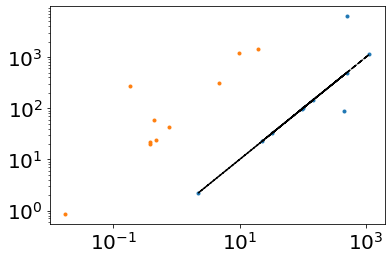

In [49]:
#Create the ensemble
#Rerun this code with Nenzymes=5 to generate the small network illustrated in Figure 1, and rename output files accordingly.
### Right phi1 constraint
ConstrainedResults = []
saveargsY = []

kappamean = 10**(2.1)
KMmean = 10**(-4.2)
for i in range(5000): #5000
    Nenzymes = 10
    sigmakappa = 3/3
    sigmaKM = 2.5#/2

    #perm = np.random.permutation(Nenzymes)
    #kappas = argsref[0, :Nenzymes][perm]
    #KMs = argsref[0, Nenzymes:2*Nenzymes][perm]
    kappas = np.random.lognormal(np.log(kappamean), sigmakappa, Nenzymes) #np.ones(Nenzymes)*kappamean #
    KMs = np.random.lognormal(np.log(KMmean), sigmaKM, Nenzymes) #np.ones(Nenzymes)*KMmean #
    
    bs = np.ones(Nenzymes)
    nu = .3*KMmean #0.03*KMmean
    lamapprox = .1
    argsStem = np.array([*kappas, *KMs, *bs, nu, lamapprox])

    
    #perm = np.random.permutation(Nenzymes)
    #kappas = argsref[1, :Nenzymes][perm]
    #KMs = argsref[1, Nenzymes:2*Nenzymes][perm]
    kappas = np.random.lognormal(np.log(kappamean), sigmakappa, Nenzymes) #np.ones(Nenzymes)*kappamean #
    KMs = np.random.lognormal(np.log(KMmean), sigmaKM, Nenzymes) #np.ones(Nenzymes)*KMmean #
    KMs[-1] = KMmean*10
    kappas[-1] = kappamean/8
    bs = np.ones(Nenzymes)
    nuLeft = 30*KMmean #0.03*KMmean
    lamapprox = .1
    argsLeft = np.array([*kappas, *KMs, *bs, nuLeft, lamapprox])

    
    #perm = np.random.permutation(Nenzymes)
    #kappas = argsref[2, :Nenzymes][perm]
    #KMs = argsref[2, Nenzymes:2*Nenzymes][perm]
    kappas = np.random.lognormal(np.log(kappamean), sigmakappa, Nenzymes) #np.ones(Nenzymes)*kappamean #
    KMs = np.random.lognormal(np.log(KMmean), sigmaKM, Nenzymes) #np.ones(Nenzymes)*KMmean #
    KMs[-1] = KMmean/3
    kappas[-1] = kappamean/2
    kappas[0] = argsLeft[0]
    bs = np.ones(Nenzymes)
    nuRight = 30*KMmean #0.03*KMmean
    rhoRight = 0.03*KMmean #0.03*KMmean
    lamapprox = .1
    argsRight = np.array([*kappas, *KMs, *bs, nuRight, lamapprox])
    
    K = argsRight[Nenzymes]*argsLeft[Nenzymes] #1*KMmean**2 #
    
    argsY = [argsStem, argsLeft, argsRight, K, nuLeft, rhoRight]
    
    #create a ribosome:
    #argsStem[0] = 10000
    #argsStem[Nenzymes] = 1e-8
    #argsStem[0] = 3/np.sum(argsStem[:Nenzymes]**(-1)+argsLeft[:Nenzymes]**(-1)+argsRight[:Nenzymes]**(-1)) #has half of the stem protein mass
    #argsStem[Nenzymes] = (0.07*np.sum(np.sqrt(argsStem[Nenzymes:2*Nenzymes]/argsStem[:Nenzymes])+np.sqrt(argsLeft[Nenzymes:2*Nenzymes]/argsLeft[:Nenzymes])+np.sqrt(argsRight[Nenzymes:2*Nenzymes]/argsRight[:Nenzymes]))*np.sqrt(argsStem[0]))**2 #has 7% of the mass at 0 growth
    #print(kappas[-1], KMs[-1])
    
    try:
        logrho0, logrhoRight = optimize2D(argsY)
        print("success", i)
    except:
        print("failed")
        continue
        
    rhosStem, rhosLeft, rhosRight = SolveYchainBC_FWD(KMmean*10**logrho0, KMmean*10**logrhoRight, K, argsStem, argsLeft, argsRight)
    rhosY = [rhosStem, rhosLeft, rhosRight]
    
    phisStem, phisLeft, phisRight, jsStem, jsLeft, jsRight = findPhisAndJsY(argsY, rhosY)
    
    phisY = [phisStem, phisLeft, phisRight]
    jsY = [jsStem, jsLeft, jsRight]
    
    localresults = np.zeros((10, 3, 3, Nenzymes)) # grs: [1, 0.99, 0.95, 0.9, 0.7, 0.5, 0.3, 0.1, 0.05, 0.01]
    res0 = np.array([rhosY, phisY, jsY])
    localresults[0] = res0
    #print(np.shape(localresults))
    #print(np.shape(res0))
    
    alpha = 1
    #eps = 0.1/phisRight[-1]#1e-3#3
    n = 5
    eps = n/((n-1)*phisRight[-1]+1)-1
    Kreg = argsRight[2*Nenzymes-1] #Kreg = KM must always be the case
    nuRight = rhosRight[-1]
    
    #print(Kreg, nuRight, nuRight/Kreg)
    phi1_0 = phisRight[-1]/(1+alpha*eps/(1+eps*nuRight/Kreg))
    
    print(rhosLeft[-1]/argsLeft[2*Nenzymes-1], rhosRight[-1]/argsRight[2*Nenzymes-1], jsStem[0])
    
    Rightreduction = -2
    for m in range(3):
        minreduction = 0
        maxreduction = -Rightreduction
        for findreduction in range(8):
            for reduction in np.linspace(maxreduction, minreduction, 10):
                rhosStem2, rhosLeft2, rhosRight2 = SolveYchainConstrained_FWD(KMmean*10**(logrho0-reduction), KMmean*10**(logrhoRight+Rightreduction), K, alpha, eps, phi1_0, argsStem, argsLeft, argsRight)
                rhosY2 = [rhosStem2, rhosLeft2, rhosRight2]
                phisStem2, phisLeft2, phisRight2, jsStem2, jsLeft2, jsRight2 = findPhisAndJsY(argsY, rhosY2)
                #print(rhosLeft2[-1]/argsLeft[2*Nenzymes-1], rhosRight2[-1]/argsRight[2*Nenzymes-1], jsStem2[0])
                if (np.isnan(rhosLeft2[-1])) or (rhosLeft2[-1]<0) or (rhosRight2[-1]<0) or np.isnan(jsStem2[0]):
                    minreduction = reduction
                    break
                maxreduction = reduction

        rhosStem2, rhosLeft2, rhosRight2 = SolveYchainConstrained_FWD(KMmean*10**(logrho0-maxreduction), KMmean*10**(logrhoRight+Rightreduction), K, alpha, eps, phi1_0, argsStem, argsLeft, argsRight)
        rhosY2 = [rhosStem2, rhosLeft2, rhosRight2]
        phisStem2, phisLeft2, phisRight2, jsStem2, jsLeft2, jsRight2 = findPhisAndJsY(argsY, rhosY2)
        Rightreduction = np.log10(10**(Rightreduction)*(0.5/(jsStem2[0]/jsStem[0]))**2)
        Rightreduction = min(Rightreduction, -0.1)
        print(rhosLeft2[-1]/argsLeft[2*Nenzymes-1], rhosRight2[-1]/argsRight[2*Nenzymes-1], jsStem2[0])
        print(Rightreduction)
    
    
    phisY2 = [phisStem2, phisLeft2, phisRight2]
    jsY2 = [jsStem2, jsLeft2, jsRight2]
    res5 = np.array([rhosY2, phisY2, jsY2])
    localresults[5] = res5
    
    RefRightreduction = np.copy(Rightreduction)
    
    grs = np.array([1, 0.99, 0.95, 0.9, 0.7, 0.5, 0.3, 0.1, 0.05, 0.01])
    
    for grindex in [1, 2, 3, 4, 6, 7, 8, 9]:
        Rightreduction = RefRightreduction*np.sqrt(np.log(grs[grindex])/np.log(.5))
        for m in range(4):
            minreduction = 0
            maxreduction = -Rightreduction
            for findreduction in range(8):
                for reduction in np.linspace(maxreduction, minreduction, 10):
                    rhosStem3, rhosLeft3, rhosRight3 = SolveYchainConstrained_FWD(KMmean*10**(logrho0-reduction), KMmean*10**(logrhoRight+Rightreduction), K, alpha, eps, phi1_0, argsStem, argsLeft, argsRight)
                    rhosY3 = [rhosStem3, rhosLeft3, rhosRight3]
                    phisStem3, phisLeft3, phisRight3, jsStem3, jsLeft3, jsRight3 = findPhisAndJsY(argsY, rhosY3)
                    #print(rhosLeft3[-1]/argsLeft[3*Nenzymes-1], rhosRight3[-1]/argsRight[3*Nenzymes-1], jsStem3[0])
                    if (np.isnan(rhosLeft3[-1])) or (rhosLeft3[-1]<0) or (rhosRight3[-1]<0) or np.isnan(jsStem3[0]):
                        minreduction = reduction
                        break
                    maxreduction = reduction

            rhosStem3, rhosLeft3, rhosRight3 = SolveYchainConstrained_FWD(KMmean*10**(logrho0-maxreduction), KMmean*10**(logrhoRight+Rightreduction), K, alpha, eps, phi1_0, argsStem, argsLeft, argsRight)
            rhosY3 = [rhosStem3, rhosLeft3, rhosRight3]
            phisStem3, phisLeft3, phisRight3, jsStem3, jsLeft3, jsRight3 = findPhisAndJsY(argsY, rhosY3)
            Rightreduction = np.log10(10**(Rightreduction)*(grs[grindex]/(jsStem3[0]/jsStem[0]))**(1+grs[grindex]/(1.01-grs[grindex])))
            Rightreduction = min(Rightreduction, -0.1)
            #print(rhosLeft3[-1]/argsLeft[3*Nenzymes-1], rhosRight3[-1]/argsRight[3*Nenzymes-1], jsStem3[0])
            #print(Rightreduction)
            
        print(grs[grindex], jsStem3[0]/jsStem[0])
    
    
        phisY3 = [phisStem3, phisLeft3, phisRight3]
        jsY3 = [jsStem3, jsLeft3, jsRight3]
        
        localresults[grindex] = np.array([rhosY3, phisY3, jsY3])
    
    
    if rhosLeft2[-1]/argsLeft[2*Nenzymes-1]>1:
        saveargsY.append([argsStem, argsLeft, argsRight])
        ConstrainedResults.append(localresults)
        
        

plt.plot(rhosLeft2/argsLeft[Nenzymes:2*Nenzymes], rhosLeft/argsLeft[Nenzymes:2*Nenzymes], ".")
plt.plot(rhosLeft2/argsLeft[Nenzymes:2*Nenzymes], rhosLeft2/argsLeft[Nenzymes:2*Nenzymes], "k--")
plt.plot(rhosRight2/argsRight[Nenzymes:2*Nenzymes], rhosRight/argsRight[Nenzymes:2*Nenzymes], ".")

plt.xscale("log")
plt.yscale("log")


In [51]:
ConstrainedResultsArray = np.array(ConstrainedResults)
print(np.shape(ConstrainedResultsArray))
np.save("ConstrainedYChain_10grs_Monod", ConstrainedResultsArray)
#iter, gr, type, branch, pos
saveargsYArray = np.array(saveargsY)
print(np.shape(saveargsYArray))
np.save("ConstrainedYChainParameters_10grs_Monod", saveargsYArray)
#iter, branch, [kappas, KMs, bs, ..]

(5, 10, 3, 3, 5)
(5, 3, 17)


In [53]:
#before #realization, nutrient, type, position
#iter, gr, type, branch, pos
ConstrainedResultsArray = np.load("ConstrainedYChain_10grs_Monod.npy")

saveargsYArray = np.load("ConstrainedYChainParameters_10grs_Monod.npy")
#iter, branch, [kappas, KMs, bs, ..]
ensemble = ConstrainedResultsArray
print(np.shape(ensemble))

### calculate efficiencies based on the whole network
Normalization = np.sum(saveargsYArray[:, :, :Nenzymes]**(-1), (1, 2))/np.sum(np.sqrt(saveargsYArray[:, :, Nenzymes:2*Nenzymes]/saveargsYArray[:, :, :Nenzymes]), (1, 2))
efficiencies = (Normalization * np.sqrt(saveargsYArray[:, :, Nenzymes:2*Nenzymes]*saveargsYArray[:, :, :Nenzymes]).T).T
print(np.shape(efficiencies))

### calculate efficiencies based on the Right branch and stem (inhibited part of the chain) only
Normalization2 = np.sum(saveargsYArray[:, ::2, :Nenzymes]**(-1), (1, 2))/np.sum(np.sqrt(saveargsYArray[:, ::2, Nenzymes:2*Nenzymes]/saveargsYArray[:, ::2, :Nenzymes]), (1, 2))
efficiencies2 = (Normalization2 * np.sqrt(saveargsYArray[:, :, Nenzymes:2*Nenzymes]*saveargsYArray[:, :, :Nenzymes]).T).T
print(np.shape(efficiencies2))

(5, 10, 3, 3, 5)
(5, 3, 5)
(5, 3, 5)


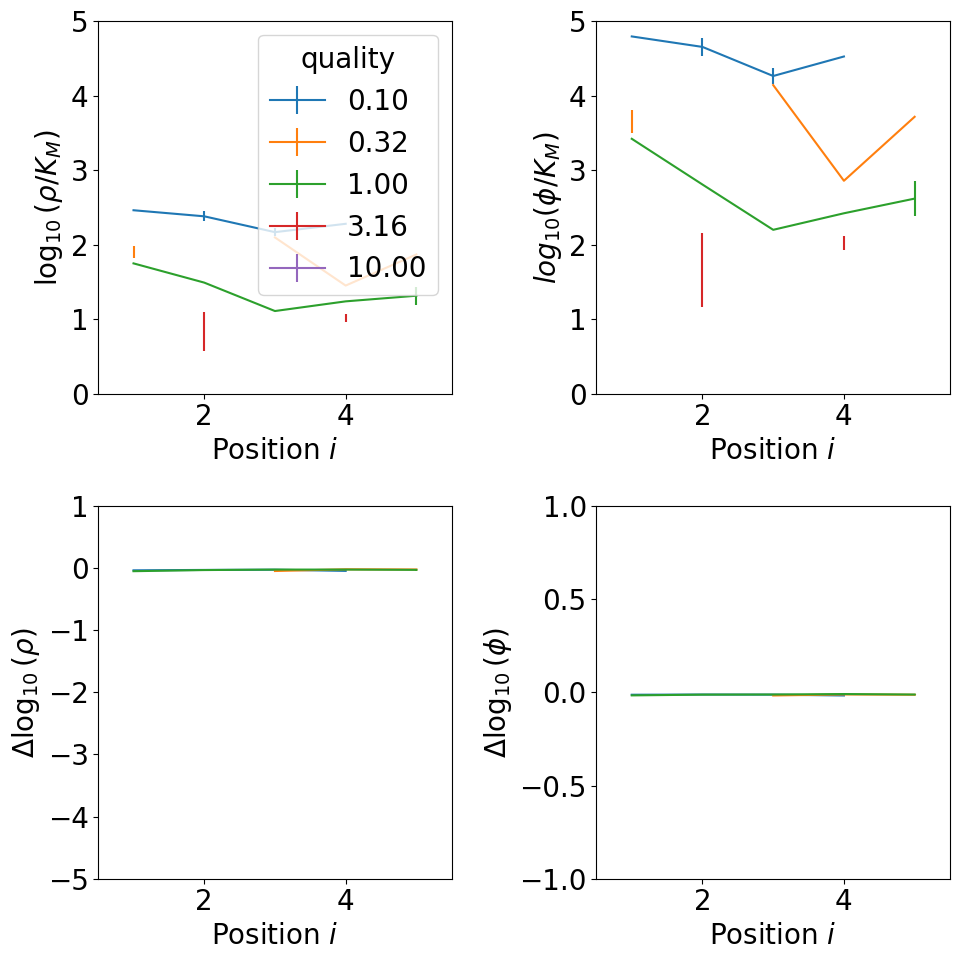

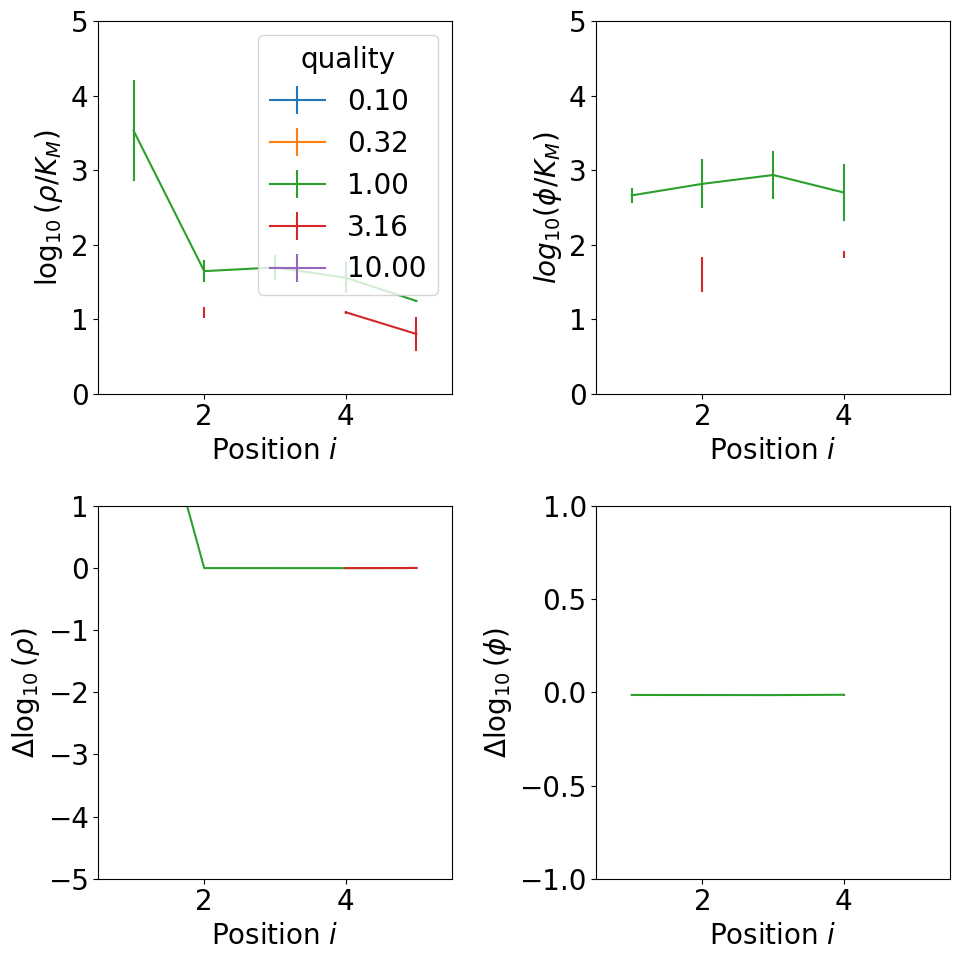

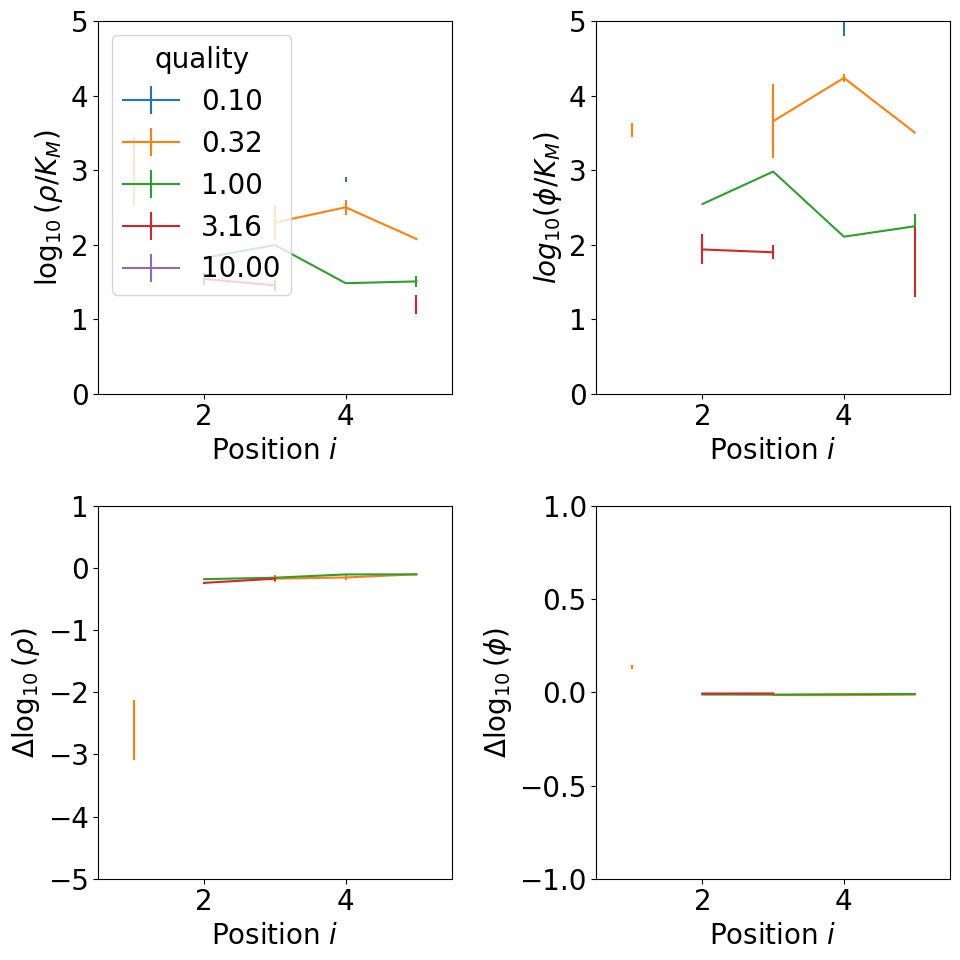

In [55]:
#efficiencybins = np.logspace(-float(sigma)/2-1e-2, float(sigma)/2+1e-2, 6)
efficiencybins = np.logspace(-1.25, 1.25, 6)
for branch in range(3):
    fig, axs = plt.subplots(2, 2, figsize = (10, 10))
    for i in range(np.shape(efficiencybins)[0]-1):
        mask = (efficiencies[:, branch, :]>efficiencybins[i])*(efficiencies[:, branch, :]<=efficiencybins[i+1])
        fullmask = mask[:, None, None, :]*np.ones((np.shape(ensemble)[1], np.shape(ensemble)[2]))[None, :, :, None]
        #maskeddata = ensemble*fullmask
        maskeddata = np.where(fullmask, ensemble[:, :, :, branch, :], np.nan)
        #maskeddata: iter, gr, type, pos
        logsaturation = np.log10(maskeddata[:, 0, 0, :]/saveargsYArray[:, branch, Nenzymes:2*Nenzymes])
        axs[0, 0].errorbar(np.arange(Nenzymes)[::-1]+1, np.nanmean(logsaturation, 0), np.nanstd(logsaturation, 0), label = "%.2f"%(efficiencybins[i]*efficiencybins[i+1])**(1/2))
        axs[0, 0].legend(title = "quality")
        axs[0, 0].set_ylabel(r"$\log_{10}(\rho/K_M)$")
        axs[0, 0].set_xlabel(r"Position $i$")
        axs[0, 0].set_ylim(0, 5)
        axs[0, 0].set_xlim(0.5, Nenzymes+.5)

        resources = maskeddata[:, 0, 1, :]/saveargsYArray[:, branch, Nenzymes:2*Nenzymes]
        axs[0, 1].errorbar(np.arange(Nenzymes)[::-1]+1, np.nanmean(np.log10(resources), 0), np.nanstd(np.log10(resources), 0), label = "%.2f"%(efficiencybins[i]*efficiencybins[i+1])**(1/2))
        #axs[0, 1].legend(title = "quality")
        axs[0, 1].set_ylabel(r"$log_{10}(\phi/K_M)$")
        axs[0, 1].set_xlabel(r"Position $i$")
        axs[0, 1].set_ylim(0, 5)
        axs[0, 1].set_xlim(0.5, Nenzymes+.5)

        logsaturationlow = np.log10(maskeddata[:, 1, 0, :]/saveargsYArray[:, branch, Nenzymes:2*Nenzymes])
        axs[1, 0].errorbar(np.arange(Nenzymes)[::-1]+1, np.nanmean(logsaturationlow-logsaturation, 0), np.nanstd(logsaturation-logsaturationlow, 0), label = "%.2f"%(efficiencybins[i]*efficiencybins[i+1])**(1/2))
        #axs[1, 0].legend(title = "quality")
        axs[1, 0].set_ylabel(r"$\Delta\log_{10}(\rho)$")
        axs[1, 0].set_xlabel(r"Position $i$")
        axs[1, 0].set_ylim(-5, 1)
        axs[1, 0].set_xlim(0.5, Nenzymes+.5)

        resourceslow = maskeddata[:, 1, 1, :]/saveargsYArray[:, branch, Nenzymes:2*Nenzymes]
        axs[1, 1].errorbar(np.arange(Nenzymes)[::-1]+1, np.nanmean(np.log10(resourceslow/resources), 0), np.nanstd(np.log10(resourceslow/resources), 0), label = "%.2f"%(efficiencybins[i]*efficiencybins[i+1])**(1/2))
        #axs[1, 1].legend(title = "quality")
        axs[1, 1].set_ylabel(r"$\Delta\log_{10}(\phi)$")
        axs[1, 1].set_xlabel(r"Position $i$")
        #print(np.sum(np.where(halfgrs == np.nanmin(np.where(halfgrs>0, halfgrs, np.max(halfgrs))), True, False)))
        #axs[1, 1].set_ylim(-float(sigma)/2, float(sigma)/2)
        axs[1, 1].set_ylim(-1, 1)
        axs[1, 1].set_xlim(0.5, Nenzymes+.5)
        #ilow = np.where(np.abs(maskeddata[:, :, 5, 0]-maxgrs/2)==np.abs(np.min(maskeddata[:, :, 5, 0]-maxgrs/2, 1)))

    fig.tight_layout()

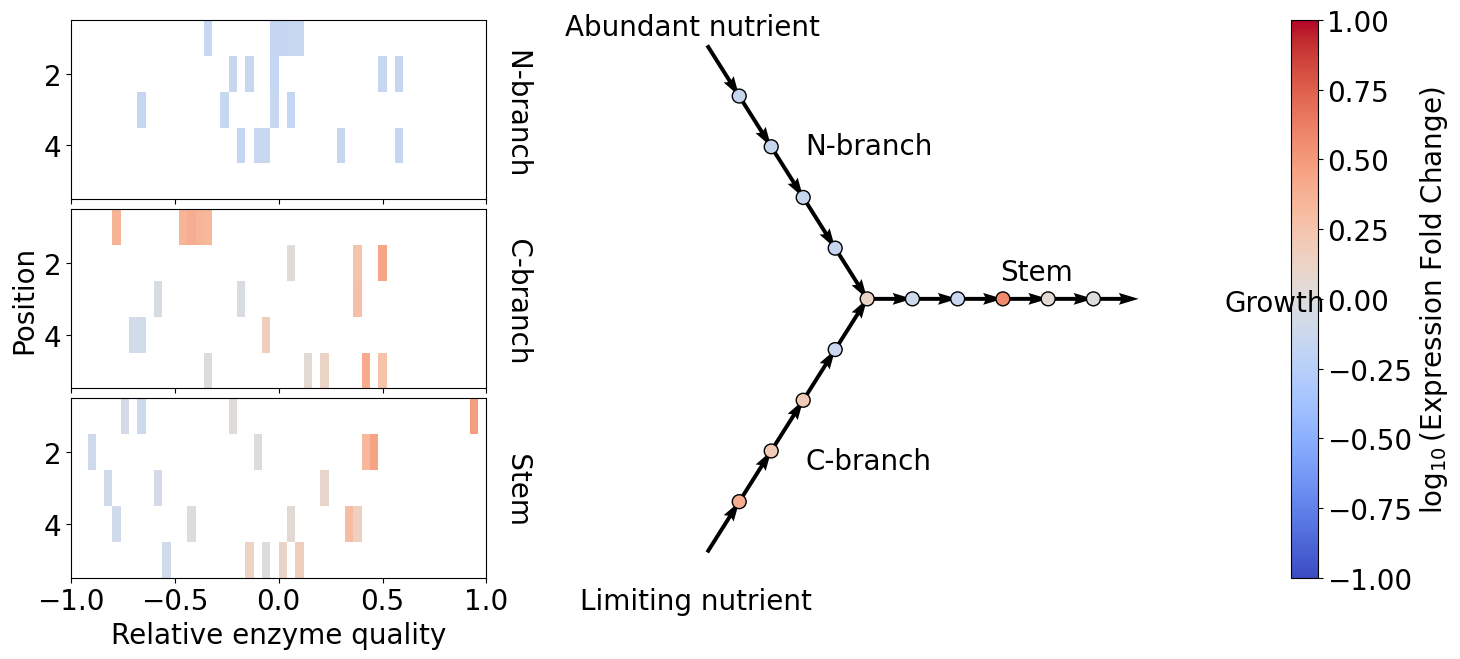

In [57]:
font = {'size'   : 20}
plt.rc('font', **font)
cm = plt.cm.get_cmap('coolwarm')

randomindex = 3

efficiencybins = np.logspace(-1, 1, 51)
heatmap = np.zeros((3, Nenzymes, 50)) #branch, pos, efficiency
heatmapsat = np.zeros((3, Nenzymes, 50)) #branch, pos, efficiency
for branch in range(3): #stem, left, right
    for i in range(np.shape(efficiencybins)[0]-1):
        mask = (efficiencies[:, branch, :]>efficiencybins[i])*(efficiencies[:, branch, :]<=efficiencybins[i+1])
        fullmask = mask[:, None, None, :]*np.ones((np.shape(ensemble)[1], np.shape(ensemble)[2]))[None, :, :, None]
        maskeddata = np.where(fullmask, ensemble[:, :, :, branch, :], np.nan)
        #maskeddata: iter, gr, type, pos
        logsaturation = np.log10(maskeddata[:, 0, 0, :]/saveargsYArray[:, branch, Nenzymes:2*Nenzymes])
        resources = maskeddata[:, 0, 1, :]/saveargsYArray[:, branch, Nenzymes:2*Nenzymes]

        logsaturationlow = np.log10(maskeddata[:, 4, 0, :]/saveargsYArray[:, branch, Nenzymes:2*Nenzymes])
        resourceslow = maskeddata[:, 4, 1, :]/saveargsYArray[:, branch, Nenzymes:2*Nenzymes]
        
        heatmap[branch, :, i] = np.nanmean(np.log10(resourceslow/resources), 0)[::-1]
        heatmapsat[branch, :, i] = np.nanmean(logsaturationlow-logsaturation, 0)[::-1]
        

fig, axs = plt.subplots(1, 3, figsize = (15, 7), gridspec_kw={'width_ratios': [4, 1, 6]})

dividerLeft = make_axes_locatable(axs[0])
caxtop = dividerLeft.append_axes("top", size="100%", pad=.1)
caxbottom = dividerLeft.append_axes("bottom", size="100%", pad=.1)

meaneffs = np.sqrt(efficiencybins[:-1]*efficiencybins[1:])
caxtop.pcolormesh(np.log10(meaneffs), np.arange(Nenzymes)+1, heatmap[1], cmap = cm, vmin = -1, vmax = 1)
axs[0].pcolormesh(np.log10(meaneffs), np.arange(Nenzymes)+1, heatmap[2], cmap = cm, vmin = -1, vmax = 1)
caxbottom.pcolormesh(np.log10(meaneffs), np.arange(Nenzymes)+1, heatmap[0], cmap = cm, vmin = -1, vmax = 1)
caxtop.set_ylim(Nenzymes+.5, 0.5)
caxtop.xaxis.set_ticklabels([])
axs[0].set_ylim(Nenzymes+.5, 0.5)
axs[0].xaxis.set_ticklabels([])
caxbottom.set_ylim(Nenzymes+.5, 0.5)
caxbottom.set_xlabel("Relative enzyme quality")
axs[0].set_ylabel("Position")

axs[1].axis('off')

FCstem = np.log10(ensemble[randomindex, 4, 1, 0, :]/ensemble[randomindex, 0, 1, 0, :])
FCleft = np.log10(ensemble[randomindex, 4, 1, 1, :]/ensemble[randomindex, 0, 1, 1, :])
FCright = np.log10(ensemble[randomindex, 4, 1, 2, :]/ensemble[randomindex, 0, 1, 2, :])
axs[2].axis('off')
axs[2].quiver(np.arange(Nenzymes)-1, np.arange(Nenzymes)[::-1]+1, 1, -1, scale_units='xy', angles='xy', scale=1,)
axs[2].quiver(np.arange(Nenzymes)-1, -np.arange(Nenzymes)[::-1]-1, 1, 1, scale_units='xy', angles='xy', scale=1)
axs[2].quiver(np.arange(Nenzymes+1)*np.sqrt(2)+Nenzymes-1, np.zeros(Nenzymes+1), np.sqrt(2), 0, scale_units='xy', angles='xy', scale=1)
axs[2].scatter(np.arange(Nenzymes-1), np.arange(Nenzymes)[:0:-1], c = FCleft[1:][::-1], s = 100, edgecolor = "k", vmin=-1, vmax=1, cmap=cm)
axs[2].scatter(np.arange(Nenzymes), -np.arange(Nenzymes)[::-1], c = FCright[::-1], s = 100, edgecolor = "k", vmin=-1, vmax=1, cmap=cm)
sc = axs[2].scatter(np.arange(Nenzymes)*np.sqrt(2)+Nenzymes-1+np.sqrt(2), np.zeros(Nenzymes), c = FCstem[::-1], s = 100, edgecolor = "k", vmin=-1, vmax=1, cmap=cm)
axs[2].set_xlim(-1.4, Nenzymes*(1+np.sqrt(2))+3)

divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="5%", pad= .7)
fig.colorbar(sc, cax=cax, label = "$\log_{10}$(Expression Fold Change)")

fig.text(0.83, 0.525, "Growth")
fig.text(0.40, 0.1, "Limiting nutrient")
fig.text(0.39, 0.92, "Abundant nutrient")

fig.text(0.68, 0.57, "Stem")
fig.text(0.55, 0.3, "C-branch")
fig.text(0.55, 0.75, "N-branch")
fig.text(0.35, 0.23, 'N-branch       C-branch          Stem', rotation=-90)

fig.tight_layout()

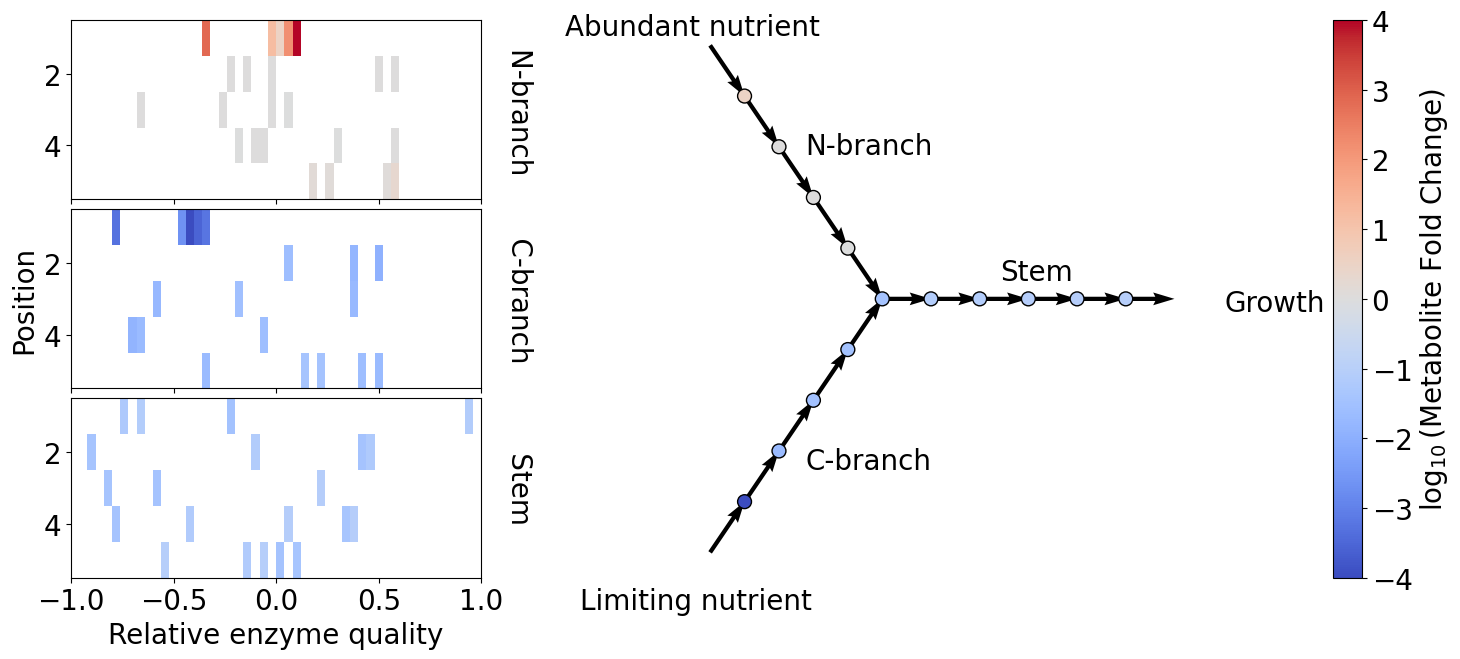

In [59]:
divnorm = matplotlib.colors.TwoSlopeNorm(vmin=-4, vcenter=0, vmax=4)
fig, axs = plt.subplots(1, 3, figsize = (15, 7), gridspec_kw={'width_ratios': [3.7, 1, 6]})

dividerLeft = make_axes_locatable(axs[0])
caxtop = dividerLeft.append_axes("top", size="100%", pad=.1)
caxbottom = dividerLeft.append_axes("bottom", size="100%", pad=.1)

meaneffs = np.sqrt(efficiencybins[:-1]*efficiencybins[1:])
caxtop.pcolormesh(np.log10(meaneffs), np.arange(Nenzymes)+1, heatmapsat[1], cmap = cm, norm=divnorm)
axs[0].pcolormesh(np.log10(meaneffs), np.arange(Nenzymes)+1, heatmapsat[2], cmap = cm, norm=divnorm)
caxbottom.pcolormesh(np.log10(meaneffs), np.arange(Nenzymes)+1, heatmapsat[0], cmap = cm, norm=divnorm)
caxtop.set_ylim(Nenzymes+.5, 0.5)
caxtop.xaxis.set_ticklabels([])
axs[0].set_ylim(Nenzymes+.5, 0.5)
axs[0].xaxis.set_ticklabels([])
caxbottom.set_ylim(Nenzymes+.5, 0.5)
caxbottom.set_xlabel("Relative enzyme quality")
axs[0].set_ylabel("Position")

axs[1].axis('off')

randomindex = 3
FCstem = np.log10(ensemble[randomindex, 4, 0, 0, :]/ensemble[randomindex, 0, 0, 0, :])
FCleft = np.log10(ensemble[randomindex, 4, 0, 1, :]/ensemble[randomindex, 0, 0, 1, :])
FCright = np.log10(ensemble[randomindex, 4, 0, 2, :]/ensemble[randomindex, 0, 0, 2, :])
axs[2].axis('off')
axs[2].quiver(np.arange(Nenzymes)-1, np.arange(Nenzymes)[::-1]+1, 1, -1, scale_units='xy', angles='xy', scale=1,)
axs[2].quiver(np.arange(Nenzymes)-1, -np.arange(Nenzymes)[::-1]-1, 1, 1, scale_units='xy', angles='xy', scale=1)
axs[2].quiver(np.arange(Nenzymes+1)*np.sqrt(2)+Nenzymes-1, np.zeros(Nenzymes+1), np.sqrt(2), 0, scale_units='xy', angles='xy', scale=1)
axs[2].scatter(np.arange(Nenzymes-1), np.arange(Nenzymes)[:0:-1], c = FCleft[1:][::-1], s = 100, edgecolor = "k", cmap=cm, norm=divnorm)
axs[2].scatter(np.arange(Nenzymes), -np.arange(Nenzymes)[::-1], c = FCright[::-1], s = 100, edgecolor = "k", cmap=cm, norm=divnorm)
sc = axs[2].scatter(np.arange(Nenzymes)*np.sqrt(2)+Nenzymes-1+np.sqrt(2), np.zeros(Nenzymes), c = FCstem[::-1], s = 100, edgecolor = "k", cmap=cm, norm=divnorm)
axs[2].set_xlim(-1.4, Nenzymes*(1+np.sqrt(2))+3)

divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="5%", pad= .7)
fig.colorbar(sc, cax=cax, label = "$\log_{10}$(Metabolite Fold Change)")

fig.text(0.83, 0.525, "Growth")
fig.text(0.40, 0.1, "Limiting nutrient")
fig.text(0.39, 0.92, "Abundant nutrient")

fig.text(0.68, 0.57, "Stem")
fig.text(0.55, 0.3, "C-branch")
fig.text(0.55, 0.75, "N-branch")
fig.text(0.35, 0.23, 'N-branch       C-branch          Stem', rotation=-90)

fig.tight_layout()

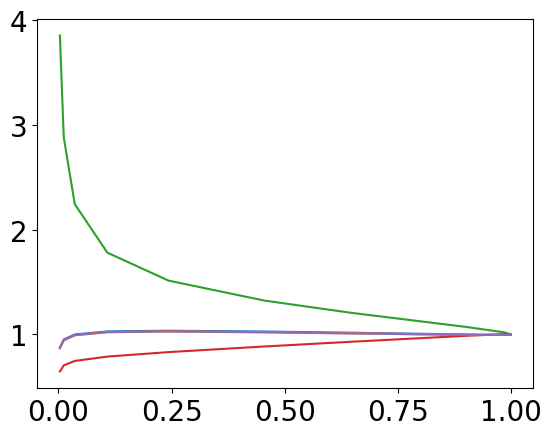

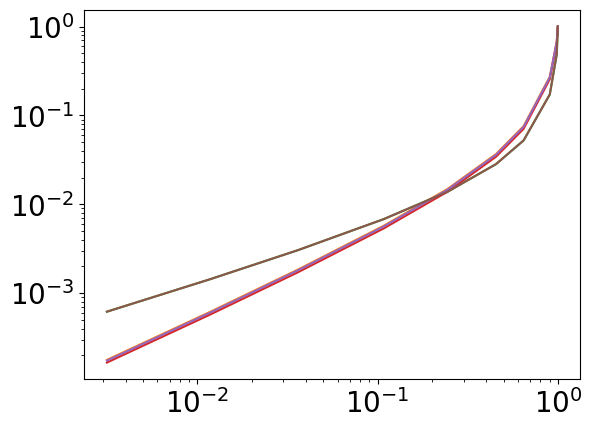

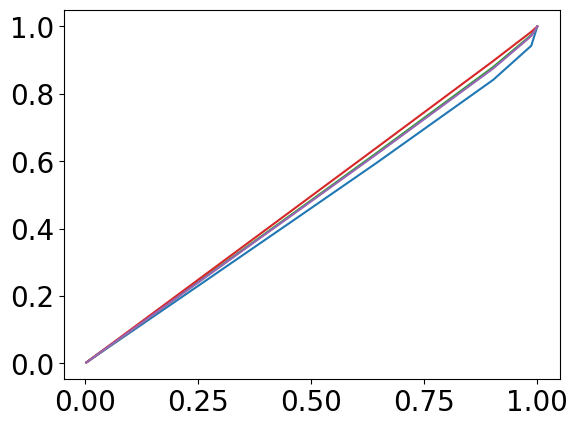

In [61]:
#numerical solution of a cycle/cyclic network
#topology: [Chain from \ell to 1] + [Reverse chain from k to y]

#parameters
KMmean = 0.0001
kappamean = 130
Nenzymes = 20
Nreverse = 5
kreverse = 5
yreverse = 10
beta0 = 100

kappas = np.ones(Nenzymes+Nreverse)*kappamean #np.random.lognormal(np.log(kappamean), 1, Nenzymes+Nreverse) #
KMs = np.ones(Nenzymes+Nreverse)*KMmean #np.random.lognormal(np.log(KMmean), 2.5, Nenzymes+Nreverse) #
lamapprox = np.sum(kappas**(-1))**(-1)

#to simplify the solution (see below)
KMs[20] = KMs[4]
Kspecial = KMs[9]


def fluxes(rhos, Nenzymes, Nreverse, kreverse, yreverse):
    js = np.zeros(Nenzymes+Nreverse)
    chain1 = np.zeros(Nenzymes)
    chain1[0] = 1
    for i in range(Nenzymes-1):
        chain1[i+1]=chain1[i]+rhos[i]
    #print(chain1)
    chain2 = np.ones(Nenzymes+Nreverse-kreverse)*np.sum(rhos[-Nreverse:])
    chain2[0]=rhos[Nenzymes]
    for i in range(Nreverse-1):
        chain2[i+1] = chain2[i]+rhos[-(i+1)]
    #print(chain2)
    circleflux = chain1[yreverse-1]+chain2[Nreverse+yreverse-kreverse-1]
    js[:Nenzymes] = chain1
    js[kreverse:yreverse] += circleflux
    js[-Nreverse:] += circleflux
    js[kreverse:Nenzymes] += chain2[Nreverse:]
    js[-Nreverse:][::-1] += chain2[:Nreverse]
    return js

#For now compute rho4 only for K20 = K4, so no need to use this function
def rhobranch(b, K20, K4, phi20, phi4):
    opt1 = (-K20*b - K4*b)/(3*b) + 2**(1/3)*(-3*b*(-K20*K4*b + K20*phi20 + K4*phi4) - (-K20*b - K4*b)**2)/(3*b*(2*K20**3*b**3 - 3*K20**2*K4*b**3 + 9*K20**2*b**2*phi20 - 3*K20*K4**2*b**3 - 18*K20*K4*b**2*phi20 - 18*K20*K4*b**2*phi4 + 2*K4**3*b**3 + 9*K4**2*b**2*phi4 + np.sqrt(4*(-3*b*(-K20*K4*b + K20*phi20 + K4*phi4) - (-K20*b - K4*b)**2)**3 + (2*K20**3*b**3 - 3*K20**2*K4*b**3 + 9*K20**2*b**2*phi20 - 3*K20*K4**2*b**3 - 18*K20*K4*b**2*phi20 - 18*K20*K4*b**2*phi4 + 2*K4**3*b**3 + 9*K4**2*b**2*phi4)**2))**(1/3)) - 2**(2/3)*(2*K20**3*b**3 - 3*K20**2*K4*b**3 + 9*K20**2*b**2*phi20 - 3*K20*K4**2*b**3 - 18*K20*K4*b**2*phi20 - 18*K20*K4*b**2*phi4 + 2*K4**3*b**3 + 9*K4**2*b**2*phi4 + np.sqrt(4*(-3*b*(-K20*K4*b + K20*phi20 + K4*phi4) - (-K20*b - K4*b)**2)**3 + (2*K20**3*b**3 - 3*K20**2*K4*b**3 + 9*K20**2*b**2*phi20 - 3*K20*K4**2*b**3 - 18*K20*K4*b**2*phi20 - 18*K20*K4*b**2*phi4 + 2*K4**3*b**3 + 9*K4**2*b**2*phi4)**2))**(1/3)/(6*b)
    opt2 = (-K20*b - K4*b)/(3*b) - 2**(1/3)*(1 + np.sqrt(3)*1j)*(-3*b*(-K20*K4*b + K20*phi20 + K4*phi4) - (-K20*b - K4*b)**2)/(6*b*(2*K20**3*b**3 - 3*K20**2*K4*b**3 + 9*K20**2*b**2*phi20 - 3*K20*K4**2*b**3 - 18*K20*K4*b**2*phi20 - 18*K20*K4*b**2*phi4 + 2*K4**3*b**3 + 9*K4**2*b**2*phi4 + np.sqrt(4*(-3*b*(-K20*K4*b + K20*phi20 + K4*phi4) - (-K20*b - K4*b)**2)**3 + (2*K20**3*b**3 - 3*K20**2*K4*b**3 + 9*K20**2*b**2*phi20 - 3*K20*K4**2*b**3 - 18*K20*K4*b**2*phi20 - 18*K20*K4*b**2*phi4 + 2*K4**3*b**3 + 9*K4**2*b**2*phi4)**2))**(1/3)) + 2**(2/3)*(1 - np.sqrt(3)*1j)*(2*K20**3*b**3 - 3*K20**2*K4*b**3 + 9*K20**2*b**2*phi20 - 3*K20*K4**2*b**3 - 18*K20*K4*b**2*phi20 - 18*K20*K4*b**2*phi4 + 2*K4**3*b**3 + 9*K4**2*b**2*phi4 + np.sqrt(4*(-3*b*(-K20*K4*b + K20*phi20 + K4*phi4) - (-K20*b - K4*b)**2)**3 + (2*K20**3*b**3 - 3*K20**2*K4*b**3 + 9*K20**2*b**2*phi20 - 3*K20*K4**2*b**3 - 18*K20*K4*b**2*phi20 - 18*K20*K4*b**2*phi4 + 2*K4**3*b**3 + 9*K4**2*b**2*phi4)**2))**(1/3)/(12*b)
    opt3 = (-K20*b - K4*b)/(3*b) - 2**(1/3)*(1 - np.sqrt(3)*1j)*(-3*b*(-K20*K4*b + K20*phi20 + K4*phi4) - (-K20*b - K4*b)**2)/(6*b*(2*K20**3*b**3 - 3*K20**2*K4*b**3 + 9*K20**2*b**2*phi20 - 3*K20*K4**2*b**3 - 18*K20*K4*b**2*phi20 - 18*K20*K4*b**2*phi4 + 2*K4**3*b**3 + 9*K4**2*b**2*phi4 + np.sqrt(4*(-3*b*(-K20*K4*b + K20*phi20 + K4*phi4) - (-K20*b - K4*b)**2)**3 + (2*K20**3*b**3 - 3*K20**2*K4*b**3 + 9*K20**2*b**2*phi20 - 3*K20*K4**2*b**3 - 18*K20*K4*b**2*phi20 - 18*K20*K4*b**2*phi4 + 2*K4**3*b**3 + 9*K4**2*b**2*phi4)**2))**(1/3)) + 2**(2/3)*(1 + np.sqrt(3)*1j)*(2*K20**3*b**3 - 3*K20**2*K4*b**3 + 9*K20**2*b**2*phi20 - 3*K20*K4**2*b**3 - 18*K20*K4*b**2*phi20 - 18*K20*K4*b**2*phi4 + 2*K4**3*b**3 + 9*K4**2*b**2*phi4 + np.sqrt(4*(-3*b*(-K20*K4*b + K20*phi20 + K4*phi4) - (-K20*b - K4*b)**2)**3 + (2*K20**3*b**3 - 3*K20**2*K4*b**3 + 9*K20**2*b**2*phi20 - 3*K20*K4**2*b**3 - 18*K20*K4*b**2*phi20 - 18*K20*K4*b**2*phi4 + 2*K4**3*b**3 + 9*K4**2*b**2*phi4)**2))**(1/3)/(12*b)
    #print(opt1, opt2, opt3)
    opt1, opt2, opt3 = np.abs(np.real(opt1)), np.abs(np.real(opt2)), np.abs(np.real(opt3))
    if np.abs(1 - (phi4/(1+opt1/K4)+phi20/(1+opt1/K20))/b/opt1)<1e-3:
        return opt1
    elif np.abs(1 - (phi4/(1+opt2/K4)+phi20/(1+opt2/K20))/b/opt2)<1e-3:
        return opt2
    elif np.abs(1 - (phi4/(1+opt3/K4)+phi20/(1+opt3/K20))/b/opt3)<1e-3:
        return opt3
    else: 
        print(failed)
        return np.nan

#compute junction inputs for equal K of for both inputs
def rhojunction(v, kappa, K, b):
    opt1 = 2**(1/3)*3**(2/3)*K*v/(3*(9*K**2*b**2*kappa**2*v + np.sqrt(3)*np.sqrt(27*K**4*b**4*kappa**4*v**2 - 4*K**3*b**3*kappa**3*v**3))**(1/3)) + 2**(2/3)*3**(1/3)*(9*K**2*b**2*kappa**2*v + np.sqrt(3)*np.sqrt(27*K**4*b**4*kappa**4*v**2 - 4*K**3*b**3*kappa**3*v**3))**(1/3)/(6*b*kappa)
    opt2 = -2**(1/3)*3**(2/3)*K*v*(1 + np.sqrt(3)*1j)/(6*(9*K**2*b**2*kappa**2*v + np.sqrt(3)*np.sqrt(27*K**4*b**4*kappa**4*v**2 - 4*K**3*b**3*kappa**3*v**3))**(1/3)) - 2**(2/3)*3**(1/3)*(1 - np.sqrt(3)*1j)*(9*K**2*b**2*kappa**2*v + np.sqrt(3)*np.sqrt(27*K**4*b**4*kappa**4*v**2 - 4*K**3*b**3*kappa**3*v**3))**(1/3)/(12*b*kappa)
    opt3 = -2**(1/3)*3**(2/3)*K*v*(1 - np.sqrt(3)*1j)/(6*(9*K**2*b**2*kappa**2*v + np.sqrt(3)*np.sqrt(27*K**4*b**4*kappa**4*v**2 - 4*K**3*b**3*kappa**3*v**3))**(1/3)) - 2**(2/3)*3**(1/3)*(1 + np.sqrt(3)*1j)*(9*K**2*b**2*kappa**2*v + np.sqrt(3)*np.sqrt(27*K**4*b**4*kappa**4*v**2 - 4*K**3*b**3*kappa**3*v**3))**(1/3)/(12*b*kappa)
    opt1, opt2, opt3 = np.abs(np.real(opt1)), np.abs(np.real(opt2)), np.abs(np.real(opt3))
    if np.abs(1 - (opt1/K)**3/(v/b/kappa/K*(1+opt1/K)))<1e-3:
        return opt1
    elif np.abs(1 - (opt2/K)**3/(v/b/kappa/K*(1+opt2/K)))<1e-3:
        return opt2
    elif np.abs(1 - (opt3/K)**3/(v/b/kappa/K*(1+opt3/K)))<1e-3:
        return opt3
    else: 
        print(failed)
        return np.nan

def numericalCycle(KMs, kappas, Kspecial, beta0, Nenzymes, Nreverse, kreverse, yreverse):

    #compute starting vector of rhos
    js = np.ones(Nenzymes+Nreverse)
    js[kreverse:yreverse] = 2
    js = js/np.sum(js/kappas)
    phis = js/kappas/np.sum(js/kappas)
    betas = np.linspace(0.1, 1, Nenzymes+Nreverse)[::-1]+beta0
    rhos = np.sqrt(js/betas*KMs/kappas)#KMs*(-1+np.sqrt(1+4*phis/betas/KMs))/2
    #simplified case with K9 = Kspecial
    rhos[9] = rhojunction(js[9]+0j, kappas[9]+0j, KMs[9]+0j, betas[9]+0j)
    rhos[20] = rhos[9] #Kspecial*(-1+np.sqrt(1+4*phis[9]/betas[-1]/Kspecial))/2
    #simplified case with K20 = K4
    rhos[4] = np.sqrt((js[4]*KMs[4]/kappas[4]+js[20]*KMs[20]/kappas[20])/betas[4])
    #KMs[4]*(-1+np.sqrt(1+4*(phis[4]+phis[20])/betas[4]/KMs[4]))/2
    #rhobranch(betas[4]+0j, KMs[20]+0j, KMs[4]+0j, phis[20]+0j, phis[4]+0j)

    js = fluxes(rhos, Nenzymes, Nreverse, kreverse, yreverse)
    
    sensitivities = []
    for i in range(len(js)):
        mockrhos = np.copy(rhos)
        mockrhos[i]+=1
        mockjs = fluxes(mockrhos, Nenzymes, Nreverse, kreverse, yreverse)
        sensitivities.append(mockjs-js)
    
    sensitivities = np.array(sensitivities)
    #contains djk/drhoi as [i, k]

    #iterate the concentration vector 5 times to improve intrinsic beta estimates
    for counter in range(5):
        js = fluxes(rhos, Nenzymes, Nreverse, kreverse, yreverse)
        
        Ms = js/kappas*(1+KMs/rhos)
        Ms[Nenzymes] = js[Nenzymes]/kappas[Nenzymes]*(1+KMs[Nenzymes]/rhos[kreverse-1])
        Ms[yreverse-1] = js[yreverse-1]/kappas[yreverse-1]*(1+KMs[yreverse-1]/rhos[yreverse-1])*(1+Kspecial/rhos[Nenzymes])
        phis = Ms/np.sum(Ms)
        js = js/np.sum(Ms)
        #print(js[0]) 
        rateconstants = kappas/(1+KMs/rhos)
        rateconstants[Nenzymes] = kappas[Nenzymes]/(1+KMs[Nenzymes]/rhos[kreverse-1])
        rateconstants[yreverse-1] = kappas[yreverse-1]/(1+KMs[yreverse-1]/rhos[yreverse-1])/(1+Kspecial/rhos[Nenzymes])
        
        #print(rateconstants**(-1)*sensitivities)
        betas = np.sum(rateconstants**(-1)*sensitivities*js[0], axis = 1)+beta0
        #print(betas)
        
        rhos = np.sqrt(js/betas*KMs/kappas)#KMs*(-1+np.sqrt(1+4*phis/betas/KMs))/2
        #simplified case with K9 = Kspecial
        rhos[9] = rhojunction(js[9]+0j, kappas[9]+0j, KMs[9]+0j, betas[9]+0j)
        rhos[20] = rhos[9] #Kspecial*(-1+np.sqrt(1+4*phis[9]/betas[-1]/Kspecial))/2
        #simplified case with K20 = K4
        rhos[4] = np.sqrt((js[4]*KMs[4]/kappas[4]+js[20]*KMs[20]/kappas[20])/betas[4])
        #KMs[4]*(-1+np.sqrt(1+4*(phis[4]+phis[20])/betas[4]/KMs[4]))/2
        #rhobranch(betas[4]+0j, KMs[20]+0j, KMs[4]+0j, phis[20]+0j, phis[4]+0j)
        
    js = fluxes(rhos, Nenzymes, Nreverse, kreverse, yreverse)
    #print(js) 
    
    Ms = js/kappas*(1+KMs/rhos)
    Ms[Nenzymes] = js[Nenzymes]/kappas[Nenzymes]*(1+KMs[Nenzymes]/rhos[kreverse-1])
    Ms[yreverse-1] = js[yreverse-1]/kappas[yreverse-1]*(1+KMs[yreverse-1]/rhos[yreverse-1])*(1+Kspecial/rhos[Nenzymes])
    phis = Ms/np.sum(Ms)
    js = js/np.sum(Ms)
    #print(js[0])
    #print(phis)
    results = np.array([kappas, KMs, js*0+1, rhos, phis, js])
    return results

ensemble = []
for beta0 in [0, 1, 1e1, 1e2, 3e2, 1e3, 3e3, 1e4, 3e4, 1e5]:
    ensemble.append(numericalCycle(KMs, kappas, Kspecial, beta0, Nenzymes, Nreverse, kreverse, yreverse))
    #print("")
ensemble = np.array(ensemble)
plt.plot(ensemble[:, 5, 0]/ensemble[0, 5, 0], ensemble[:, 4, 19]/ensemble[0, 4, 19])
plt.plot(ensemble[:, 5, 0]/ensemble[0, 5, 0], ensemble[:, 4, -1]/ensemble[0, 4, -1])
plt.plot(ensemble[:, 5, 0]/ensemble[0, 5, 0], ensemble[:, 4, 9]/ensemble[0, 4, 9])
plt.plot(ensemble[:, 5, 0]/ensemble[0, 5, 0], ensemble[:, 4, 4]/ensemble[0, 4, 4])
plt.plot(ensemble[:, 5, 0]/ensemble[0, 5, 0], ensemble[:, 4, -2]/ensemble[0, 4, -2])
#plt.plot(ensemble[:, 5, 0]/ensemble[0, 5, 0], ensemble[:, 4, :]/ensemble[0, 4, :])

plt.figure()
plt.plot(ensemble[:, 5, 0]/ensemble[0, 5, 0], ensemble[:, 3, 19]/ensemble[0, 3, 19])
plt.plot(ensemble[:, 5, 0]/ensemble[0, 5, 0], ensemble[:, 3, -1]/ensemble[0, 3, -1])
plt.plot(ensemble[:, 5, 0]/ensemble[0, 5, 0], ensemble[:, 3, 9]/ensemble[0, 3, 9])
plt.plot(ensemble[:, 5, 0]/ensemble[0, 5, 0], ensemble[:, 3, 4]/ensemble[0, 3, 4])
plt.plot(ensemble[:, 5, 0]/ensemble[0, 5, 0], ensemble[:, 3, -2]/ensemble[0, 3, -2])
plt.plot(ensemble[:, 5, 0]/ensemble[0, 5, 0], ensemble[:, 3, 20]/ensemble[0, 3, 20])
plt.yscale("log")
plt.xscale("log")

plt.figure()
plt.plot(ensemble[:, 5, 0]/ensemble[0, 5, 0], ensemble[:, 5, 19]/ensemble[0, 5, 19])
plt.plot(ensemble[:, 5, 0]/ensemble[0, 5, 0], ensemble[:, 5, -1]/ensemble[0, 5, -1])
plt.plot(ensemble[:, 5, 0]/ensemble[0, 5, 0], ensemble[:, 5, 9]/ensemble[0, 5, 9])
plt.plot(ensemble[:, 5, 0]/ensemble[0, 5, 0], ensemble[:, 5, 4]/ensemble[0, 5, 4])
plt.plot(ensemble[:, 5, 0]/ensemble[0, 5, 0], ensemble[:, 5, -2]/ensemble[0, 5, -2])

[0.33740535 6.05466133 2.14499086 2.66055818 4.61956765 2.17414541
 8.91630524 3.05149271 2.16390355 1.14515818 0.59697542 0.30865661
 2.74842921 0.10577207 2.04874008 0.7191975  4.67107926 5.60733536
 0.29367542 3.30007305 5.95290049 0.15823751 0.26908903 0.6153108
 2.80243111]
0.02746808755060188
0.002169512193608532
qbar 0.6373339321532134
0.6925114992026888
0.4335259328985056
0.862184397186345


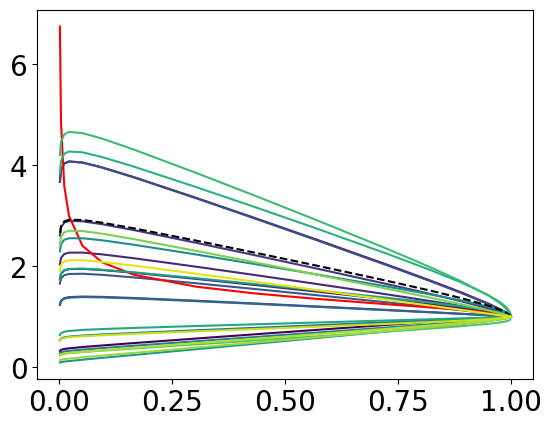

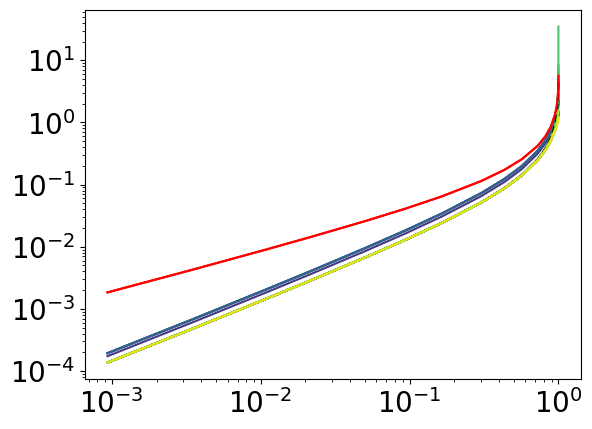

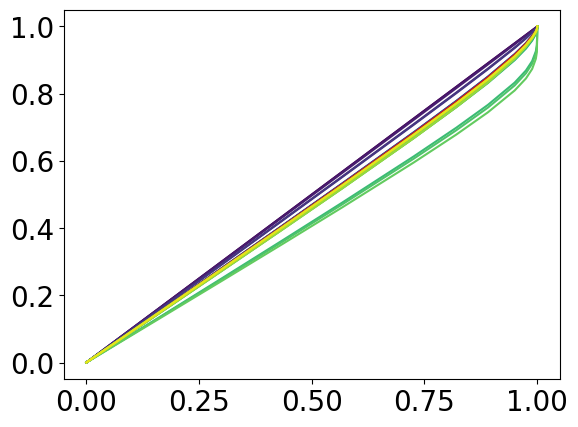

In [629]:
cmviridis = plt.cm.get_cmap('viridis')

#parameters
KMmean = 0.0001
kappamean = 130
Nenzymes = 20
Nreverse = 5
kreverse = 5
yreverse = 10
beta0 = 100

kappas = np.random.lognormal(np.log(kappamean), 1, Nenzymes+Nreverse) #np.ones(Nenzymes+Nreverse)*kappamean #
KMs = np.random.lognormal(np.log(KMmean), 2.5, Nenzymes+Nreverse) #np.ones(Nenzymes+Nreverse)*KMmean #
lamapprox = np.sum(kappas**(-1))**(-1)

kappas[9] = kappamean*np.random.normal(1, 0.1)
KMs[9] = KMmean*np.random.normal(2, 0.1)

#to simplify the solution (see below)
KMs[4] = 2e-3
KMs[20] = KMs[4]
Kspecial = KMs[9]
kappas[19] = 1e3

cyclicensemble = []
for beta0 in [0, 0.1, 0.2, 0.5, 1, 2, 5, 1e1, 2e1, 5e1, 1e2, 2e2, 5e2, 1e3, 2e3, 5e3, 1e4, 3e4, 1e5]:
    cyclicensemble.append(numericalCycle(KMs, kappas, Kspecial, beta0, Nenzymes, Nreverse, kreverse, yreverse))
cyclicensemble = np.array(cyclicensemble)
for i in range(Nenzymes+Nreverse):
    if i == 19:
        plt.plot(cyclicensemble[:, 5, 0]/cyclicensemble[0, 5, 0], cyclicensemble[:, 4, i]/cyclicensemble[0, 4, i], "k--")
    elif i == 9:
        plt.plot(cyclicensemble[:, 5, 0]/cyclicensemble[0, 5, 0], cyclicensemble[:, 4, i]/cyclicensemble[0, 4, i], "r-")
    else:
        plt.plot(cyclicensemble[:, 5, 0]/cyclicensemble[0, 5, 0], cyclicensemble[:, 4, i]/cyclicensemble[0, 4, i], "-", color = cmviridis(i/25))

plt.figure()
for i in range(Nenzymes+Nreverse):
    if i == 19:
        plt.plot(cyclicensemble[:, 5, 0]/cyclicensemble[0, 5, 0], cyclicensemble[:, 3, i]*np.sqrt(kappas[i]/KMs[i]), "k--")
    elif i == 9:
        plt.plot(cyclicensemble[:, 5, 0]/cyclicensemble[0, 5, 0], cyclicensemble[:, 3, i]*np.sqrt(kappas[i]/KMs[i]), "r-")
    elif i == 20:
        plt.plot(cyclicensemble[:, 5, 0]/cyclicensemble[0, 5, 0], cyclicensemble[:, 3, i]*np.sqrt(kappas[9]/Kspecial), "r-")
    else:
        plt.plot(cyclicensemble[:, 5, 0]/cyclicensemble[0, 5, 0], cyclicensemble[:, 3, i]*np.sqrt(kappas[i]/KMs[i]), "-", color = cmviridis(i/25))
plt.yscale("log")
plt.xscale("log")

plt.figure()
for i in range(Nenzymes+Nreverse):
    if i == 9:
        plt.plot(cyclicensemble[:, 5, 0]/cyclicensemble[0, 5, 0], cyclicensemble[:, 5, i]/cyclicensemble[0, 5, i], "r-")
    else:
        plt.plot(cyclicensemble[:, 5, 0]/cyclicensemble[0, 5, 0], cyclicensemble[:, 5, i]/cyclicensemble[0, 5, i], "-", color = cmviridis(i/25))


cyclicefficiencies = (np.sum(cyclicensemble[0, 0, :]**(-1))/np.sum(np.sqrt(cyclicensemble[0, 1, :]/cyclicensemble[0, 0, :]))*np.sqrt(cyclicensemble[0, 1, :]*cyclicensemble[0, 0, :]).T).T

print(cyclicefficiencies)

cyclicepsilon = np.sum(np.sqrt(cyclicensemble[0, 1, :]/cyclicensemble[0, 0, :]))/np.sqrt(np.sum(1/cyclicensemble[0, 0, :]))
cyclics = ((np.sqrt(cyclicensemble[0, 1, :]/cyclicensemble[0, 0, :]))/np.sum(np.sqrt(cyclicensemble[0, 1, :]/cyclicensemble[0, 0, :])))
cyclics[20] = ((np.sqrt(Kspecial/cyclicensemble[0, 0, 9]))/np.sum(np.sqrt(Kspecial/cyclicensemble[0, 0, 9])))

print(cyclicensemble[0, 4, 9])
print(cyclicensemble[0, 4, 19])
print("qbar", (np.sum(cyclicensemble[0, 4, 5:9]*cyclicefficiencies[5:9])+np.sum(cyclicensemble[0, 4, 20:]*cyclicefficiencies[20:]))/(np.sum(cyclicensemble[0, 4, 5:9])+np.sum(cyclicensemble[0, 4, 20:])))
print((np.sum(cyclicensemble[10, 4, 5:9])+np.sum(cyclicensemble[10, 4, 20:]))/(np.sum(cyclicensemble[0, 4, 5:9])+np.sum(cyclicensemble[0, 4, 20:])))
print(cyclicensemble[10, 5, 0]/cyclicensemble[0, 5, 0])
print(cyclicensemble[0, 5, 0]*(np.sum(1/cyclicensemble[0, 0, :])+np.sum(1/cyclicensemble[0, 0, 5:10])))
np.save("cyclicPathway_nutrientLimitation_1", cyclicensemble)